# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [6]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.10.0+cu111
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Othercomputers  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2021-11-25 06:33:32--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.20MB/s    in 1.0s    

2021-11-25 06:33:34 (2.20 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [7]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char == ' ' or char == '\n' or char == '\t':
          pass
        if char not in voc2ind:
          voc2ind[char] = len(voc2ind)

    ind2voc = {val: key for key, val in voc2ind.items()}
    eighty = int(len(data) * 0.8)
    train_text = data[0:eighty] # TODO Fill this in
    test_text = data[eighty:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']
        encoded_tokens = [self.voc2ind[char] for char in self.tokens]

        self.data = torch.LongTensor(
            encoded_tokens[:len(encoded_tokens) - (len(encoded_tokens) % batch_size)]
        ).view(batch_size, -1)
        self.seq_num =  math.ceil((self.data.shape[1] - 1) / sequence_length)


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.data.shape[0] * self.seq_num
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size
        front_idx = (idx // self.batch_size) * self.sequence_length
        data = self.data[batch_idx][front_idx : min(self.data.shape[1], front_idx + self.sequence_length + 1)]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
TEMPERATURE = 0.6
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        x = output[0].argmax().long()
        outputs.append(x)
        output, hidden = model.inference(x, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        x = torch.multinomial(output[0],1)[0].long()
        outputs.append(x)
        output, hidden = model.inference(x, hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    for ii in range(sequence_length):
        next_beam = []
        for i in range(len(beam)):
            cur_beam = beam[i]
            sample = torch.multinomial(output[0], beam_width, replacement=True)
            for x in sample:
                x = x.long()
                x_score = cur_beam[1][0][x]
                new_score = cur_beam[3] + torch.log(x_score)
                output, hidden = model.inference(x, cur_beam[2], TEMPERATURE)
                next_beam.append(([
                    cur_beam[0] + [x],
                    output,
                    hidden,
                    new_score
                ]))
        next_beam.sort(reverse=True, key=lambda v: v[3])
        beam = next_beam[:beam_width]
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	FqRCu-?Cu-jL$ $quYj$u-?qjrX8(jj~[^ju.qRIjjE0$u[MIu;`?qqJIms$u bu833mfrf?$[D4p[L"^rTL??qjr-$$u$[jOjIY


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	^uu[Mqu[?Iu[s^u??*'mOquujTj?rrjuUs"88??sRsq3pyMA~z~0ImsJ$qu$[ju-?qjrm-sq[u?9 gR?*^=uUjO Gr~*&{jIm$bu


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	j$[88?JImUL^usjj:u$jL$ $[jOY`FbDImM*f [jFu-ss$jImUL"u?JImJj%~qJ$quu?X0-u[LF88 RqqRCf?CImfbwjTF88y~G~


Input	 . .

  1%|          | 2/196 [00:00<00:43,  4.50it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 16.730846


  6%|▌         | 12/196 [00:02<00:32,  5.65it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 10.781863


 11%|█         | 22/196 [00:03<00:30,  5.68it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 5.838891


 16%|█▋        | 32/196 [00:05<00:28,  5.77it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 3.884646


 21%|██▏       | 42/196 [00:07<00:26,  5.77it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 3.040903


 27%|██▋       | 52/196 [00:09<00:25,  5.69it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 2.969909


 32%|███▏      | 62/196 [00:10<00:23,  5.69it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 3.489343


 37%|███▋      | 72/196 [00:12<00:21,  5.69it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 2.688848


 42%|████▏     | 82/196 [00:14<00:19,  5.71it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 2.287691


 47%|████▋     | 92/196 [00:16<00:18,  5.71it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 2.592377


 52%|█████▏    | 102/196 [00:17<00:16,  5.68it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 2.343120


 57%|█████▋    | 112/196 [00:19<00:14,  5.69it/s]

Train Epoch: 0 [28160/50176 (56%)]	Loss: 2.156093


 62%|██████▏   | 122/196 [00:21<00:12,  5.76it/s]

Train Epoch: 0 [30720/50176 (61%)]	Loss: 2.090987


 67%|██████▋   | 132/196 [00:23<00:11,  5.76it/s]

Train Epoch: 0 [33280/50176 (66%)]	Loss: 3.194149


 72%|███████▏  | 142/196 [00:24<00:09,  5.63it/s]

Train Epoch: 0 [35840/50176 (71%)]	Loss: 3.003133


 78%|███████▊  | 152/196 [00:26<00:07,  5.80it/s]

Train Epoch: 0 [38400/50176 (77%)]	Loss: 2.344510


 83%|████████▎ | 162/196 [00:28<00:05,  5.76it/s]

Train Epoch: 0 [40960/50176 (82%)]	Loss: 2.062145


 88%|████████▊ | 172/196 [00:30<00:04,  5.70it/s]

Train Epoch: 0 [43520/50176 (87%)]	Loss: 1.881305


 93%|█████████▎| 182/196 [00:31<00:02,  5.70it/s]

Train Epoch: 0 [46080/50176 (92%)]	Loss: 1.884923


 98%|█████████▊| 192/196 [00:33<00:00,  5.81it/s]

Train Epoch: 0 [48640/50176 (97%)]	Loss: 1.858987


100%|██████████| 196/196 [00:34<00:00,  5.73it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y whs toat th hot thshr  tu ause heldemort wed tuayeed tt whmh .
ba woocc tim elf afer th the sx e


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet ted jem wnoa .  wealddtd tim  aonl ng teck ard tn o the sascr tath h shiayse he whooneeed oh s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe tnd tes hael tiat the dreubd tn hhe  dokter tim and te an th torti fim  atiw y.fnd thpp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:43,  4.44it/s]

Train Epoch: 1 [0/50176 (0%)]	Loss: 1.827741


  6%|▌         | 12/196 [00:02<00:32,  5.67it/s]

Train Epoch: 1 [2560/50176 (5%)]	Loss: 1.837365


 11%|█         | 22/196 [00:03<00:30,  5.76it/s]

Train Epoch: 1 [5120/50176 (10%)]	Loss: 3.081440


 16%|█▋        | 32/196 [00:05<00:28,  5.77it/s]

Train Epoch: 1 [7680/50176 (15%)]	Loss: 2.492378


 21%|██▏       | 42/196 [00:07<00:27,  5.66it/s]

Train Epoch: 1 [10240/50176 (20%)]	Loss: 2.052839


 27%|██▋       | 52/196 [00:09<00:25,  5.68it/s]

Train Epoch: 1 [12800/50176 (26%)]	Loss: 1.861307


 32%|███▏      | 62/196 [00:10<00:23,  5.76it/s]

Train Epoch: 1 [15360/50176 (31%)]	Loss: 1.781926


 37%|███▋      | 72/196 [00:12<00:22,  5.56it/s]

Train Epoch: 1 [17920/50176 (36%)]	Loss: 1.744975


 42%|████▏     | 82/196 [00:14<00:20,  5.68it/s]

Train Epoch: 1 [20480/50176 (41%)]	Loss: 1.699651


 47%|████▋     | 92/196 [00:16<00:17,  5.79it/s]

Train Epoch: 1 [23040/50176 (46%)]	Loss: 1.696532


 52%|█████▏    | 102/196 [00:17<00:16,  5.69it/s]

Train Epoch: 1 [25600/50176 (51%)]	Loss: 1.765837


 57%|█████▋    | 112/196 [00:19<00:14,  5.75it/s]

Train Epoch: 1 [28160/50176 (56%)]	Loss: 2.328943


 62%|██████▏   | 122/196 [00:21<00:12,  5.71it/s]

Train Epoch: 1 [30720/50176 (61%)]	Loss: 2.089015


 67%|██████▋   | 132/196 [00:23<00:11,  5.70it/s]

Train Epoch: 1 [33280/50176 (66%)]	Loss: 1.828134


 72%|███████▏  | 142/196 [00:24<00:09,  5.83it/s]

Train Epoch: 1 [35840/50176 (71%)]	Loss: 1.721044


 78%|███████▊  | 152/196 [00:26<00:07,  5.71it/s]

Train Epoch: 1 [38400/50176 (77%)]	Loss: 1.684587


 83%|████████▎ | 162/196 [00:28<00:05,  5.72it/s]

Train Epoch: 1 [40960/50176 (82%)]	Loss: 1.681208


 88%|████████▊ | 172/196 [00:30<00:04,  5.85it/s]

Train Epoch: 1 [43520/50176 (87%)]	Loss: 1.624980


 93%|█████████▎| 182/196 [00:31<00:02,  5.78it/s]

Train Epoch: 1 [46080/50176 (92%)]	Loss: 1.659973


 98%|█████████▊| 192/196 [00:33<00:00,  5.65it/s]

Train Epoch: 1 [48640/50176 (97%)]	Loss: 1.678521


100%|██████████| 196/196 [00:34<00:00,  5.74it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y aan aoat th tot aascr  aucause toldemort wid auayted tt aama.. ae woonc oim elf aner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet aed aem wnoa
"  wealdded tim  aoclyng aack ard tn o the bascr tath a lteayte te waaapeled oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and Hem waet aaat the draund an the  waktyr aim and aeean th tanti aam  aaiwly and ttde y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:45,  4.28it/s]

Train Epoch: 2 [0/50176 (0%)]	Loss: 1.643086


  6%|▌         | 12/196 [00:02<00:31,  5.78it/s]

Train Epoch: 2 [2560/50176 (5%)]	Loss: 1.614302


 11%|█         | 22/196 [00:03<00:30,  5.64it/s]

Train Epoch: 2 [5120/50176 (10%)]	Loss: 1.660090


 16%|█▋        | 32/196 [00:05<00:28,  5.82it/s]

Train Epoch: 2 [7680/50176 (15%)]	Loss: 1.643577


 21%|██▏       | 42/196 [00:07<00:27,  5.70it/s]

Train Epoch: 2 [10240/50176 (20%)]	Loss: 1.611821


 27%|██▋       | 52/196 [00:09<00:25,  5.64it/s]

Train Epoch: 2 [12800/50176 (26%)]	Loss: 1.676874


 32%|███▏      | 62/196 [00:10<00:23,  5.82it/s]

Train Epoch: 2 [15360/50176 (31%)]	Loss: 1.732719


 37%|███▋      | 72/196 [00:12<00:22,  5.57it/s]

Train Epoch: 2 [17920/50176 (36%)]	Loss: 1.732748


 42%|████▏     | 82/196 [00:14<00:19,  5.79it/s]

Train Epoch: 2 [20480/50176 (41%)]	Loss: 1.631406


 47%|████▋     | 92/196 [00:16<00:18,  5.77it/s]

Train Epoch: 2 [23040/50176 (46%)]	Loss: 1.599375


 52%|█████▏    | 102/196 [00:17<00:16,  5.73it/s]

Train Epoch: 2 [25600/50176 (51%)]	Loss: 1.604757


 57%|█████▋    | 112/196 [00:19<00:14,  5.80it/s]

Train Epoch: 2 [28160/50176 (56%)]	Loss: 1.593057


 62%|██████▏   | 122/196 [00:21<00:13,  5.67it/s]

Train Epoch: 2 [30720/50176 (61%)]	Loss: 1.574745


 67%|██████▋   | 132/196 [00:23<00:11,  5.68it/s]

Train Epoch: 2 [33280/50176 (66%)]	Loss: 1.584554


 72%|███████▏  | 142/196 [00:24<00:09,  5.60it/s]

Train Epoch: 2 [35840/50176 (71%)]	Loss: 1.668079


 78%|███████▊  | 152/196 [00:26<00:07,  5.77it/s]

Train Epoch: 2 [38400/50176 (77%)]	Loss: 1.625271


 83%|████████▎ | 162/196 [00:28<00:05,  5.68it/s]

Train Epoch: 2 [40960/50176 (82%)]	Loss: 1.619580


 88%|████████▊ | 172/196 [00:30<00:04,  5.78it/s]

Train Epoch: 2 [43520/50176 (87%)]	Loss: 1.567727


 93%|█████████▎| 182/196 [00:31<00:02,  5.75it/s]

Train Epoch: 2 [46080/50176 (92%)]	Loss: 1.629381


 98%|█████████▊| 192/196 [00:33<00:00,  5.72it/s]

Train Epoch: 2 [48640/50176 (97%)]	Loss: 1.631746


100%|██████████| 196/196 [00:34<00:00,  5.74it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aot aaat th tot tite i aucause toldemort aed tuayted tt iemt.. ae soong oim elf ouer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet ted tem fno  "  wiaaate  tim  aocling ieck ard ttto the sole iiith a ltiatte te stoiteledooh s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	tee and tes foet aitt the doound tt the  aatte  iim atd teeantto tottiiaam  atiwly atd ttdp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:45,  4.30it/s]

Train Epoch: 3 [0/50176 (0%)]	Loss: 1.652508


  6%|▌         | 12/196 [00:02<00:32,  5.74it/s]

Train Epoch: 3 [2560/50176 (5%)]	Loss: 1.557343


 11%|█         | 22/196 [00:03<00:30,  5.74it/s]

Train Epoch: 3 [5120/50176 (10%)]	Loss: 1.576937


 16%|█▋        | 32/196 [00:05<00:28,  5.68it/s]

Train Epoch: 3 [7680/50176 (15%)]	Loss: 1.546050


 21%|██▏       | 42/196 [00:07<00:26,  5.76it/s]

Train Epoch: 3 [10240/50176 (20%)]	Loss: 1.529683


 27%|██▋       | 52/196 [00:09<00:25,  5.75it/s]

Train Epoch: 3 [12800/50176 (26%)]	Loss: 1.552449


 32%|███▏      | 62/196 [00:10<00:23,  5.77it/s]

Train Epoch: 3 [15360/50176 (31%)]	Loss: 1.594567


 37%|███▋      | 72/196 [00:12<00:21,  5.80it/s]

Train Epoch: 3 [17920/50176 (36%)]	Loss: 1.538311


 42%|████▏     | 82/196 [00:14<00:19,  5.73it/s]

Train Epoch: 3 [20480/50176 (41%)]	Loss: 1.521261


 47%|████▋     | 92/196 [00:16<00:18,  5.71it/s]

Train Epoch: 3 [23040/50176 (46%)]	Loss: 1.575111


 52%|█████▏    | 102/196 [00:17<00:16,  5.75it/s]

Train Epoch: 3 [25600/50176 (51%)]	Loss: 1.607748


 57%|█████▋    | 112/196 [00:19<00:14,  5.71it/s]

Train Epoch: 3 [28160/50176 (56%)]	Loss: 1.545417


 62%|██████▏   | 122/196 [00:21<00:12,  5.75it/s]

Train Epoch: 3 [30720/50176 (61%)]	Loss: 1.520527


 67%|██████▋   | 132/196 [00:23<00:11,  5.75it/s]

Train Epoch: 3 [33280/50176 (66%)]	Loss: 1.501753


 72%|███████▏  | 142/196 [00:24<00:09,  5.67it/s]

Train Epoch: 3 [35840/50176 (71%)]	Loss: 1.505706


 78%|███████▊  | 152/196 [00:26<00:07,  5.75it/s]

Train Epoch: 3 [38400/50176 (77%)]	Loss: 1.495932


 83%|████████▎ | 162/196 [00:28<00:05,  5.76it/s]

Train Epoch: 3 [40960/50176 (82%)]	Loss: 1.533183


 88%|████████▊ | 172/196 [00:30<00:04,  5.72it/s]

Train Epoch: 3 [43520/50176 (87%)]	Loss: 1.590029


 93%|█████████▎| 182/196 [00:31<00:02,  5.80it/s]

Train Epoch: 3 [46080/50176 (92%)]	Loss: 1.642581


 98%|█████████▊| 192/196 [00:33<00:00,  5.81it/s]

Train Epoch: 3 [48640/50176 (97%)]	Loss: 1.582955


100%|██████████| 196/196 [00:34<00:00,  5.73it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ohn oitt ah tet thscr  aucause toldemort wav tuacted tn oomt.. ae toong oom elf oner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat tev bem hno 
"t wiaaase  tem  aocling oock ard tn o the salcr thth a lteanse te sthameled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and hes hoet aift ahe ooound tt the  wakt n tim ond seean to torriioam  atiwly otd ttdp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:44,  4.35it/s]

Train Epoch: 4 [0/50176 (0%)]	Loss: 1.559103


  6%|▌         | 12/196 [00:02<00:32,  5.73it/s]

Train Epoch: 4 [2560/50176 (5%)]	Loss: 1.496878


 11%|█         | 22/196 [00:03<00:30,  5.76it/s]

Train Epoch: 4 [5120/50176 (10%)]	Loss: 1.512815


 16%|█▋        | 32/196 [00:05<00:28,  5.82it/s]

Train Epoch: 4 [7680/50176 (15%)]	Loss: 1.486836


 21%|██▏       | 42/196 [00:07<00:26,  5.71it/s]

Train Epoch: 4 [10240/50176 (20%)]	Loss: 1.471483


 27%|██▋       | 52/196 [00:09<00:24,  5.76it/s]

Train Epoch: 4 [12800/50176 (26%)]	Loss: 1.472911


 32%|███▏      | 62/196 [00:10<00:23,  5.72it/s]

Train Epoch: 4 [15360/50176 (31%)]	Loss: 1.496134


 37%|███▋      | 72/196 [00:12<00:22,  5.59it/s]

Train Epoch: 4 [17920/50176 (36%)]	Loss: 1.482787


 42%|████▏     | 82/196 [00:14<00:19,  5.80it/s]

Train Epoch: 4 [20480/50176 (41%)]	Loss: 1.467323


 47%|████▋     | 92/196 [00:16<00:17,  5.82it/s]

Train Epoch: 4 [23040/50176 (46%)]	Loss: 1.476016


 52%|█████▏    | 102/196 [00:17<00:16,  5.75it/s]

Train Epoch: 4 [25600/50176 (51%)]	Loss: 1.582849


 57%|█████▋    | 112/196 [00:19<00:14,  5.86it/s]

Train Epoch: 4 [28160/50176 (56%)]	Loss: 1.542676


 62%|██████▏   | 122/196 [00:21<00:12,  5.75it/s]

Train Epoch: 4 [30720/50176 (61%)]	Loss: 1.495737


 67%|██████▋   | 132/196 [00:23<00:11,  5.75it/s]

Train Epoch: 4 [33280/50176 (66%)]	Loss: 1.467090


 72%|███████▏  | 142/196 [00:24<00:09,  5.77it/s]

Train Epoch: 4 [35840/50176 (71%)]	Loss: 1.465639


 78%|███████▊  | 152/196 [00:26<00:07,  5.73it/s]

Train Epoch: 4 [38400/50176 (77%)]	Loss: 1.454395


 83%|████████▎ | 162/196 [00:28<00:05,  5.79it/s]

Train Epoch: 4 [40960/50176 (82%)]	Loss: 1.500371


 88%|████████▊ | 172/196 [00:30<00:04,  5.75it/s]

Train Epoch: 4 [43520/50176 (87%)]	Loss: 1.466707


 93%|█████████▎| 182/196 [00:31<00:02,  5.82it/s]

Train Epoch: 4 [46080/50176 (92%)]	Loss: 1.494418


 98%|█████████▊| 192/196 [00:33<00:00,  5.78it/s]

Train Epoch: 4 [48640/50176 (97%)]	Loss: 1.490524


100%|██████████| 196/196 [00:34<00:00,  5.74it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aas aiat th tit aiscr  aucause toldemort wad aaanted tn almt . aa wlong oim elf aner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat ted aam wnm 
"  wiaiase  tim  aocling aeck ard tn o the salcr aath a lheanse te htaambled ah t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and hes faet aaft ahe wlound an hhe  aakt d aim and teean to tarri aam  atiwly atd atdp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:43,  4.48it/s]

Train Epoch: 5 [0/50176 (0%)]	Loss: 1.504003


  6%|▌         | 12/196 [00:02<00:32,  5.68it/s]

Train Epoch: 5 [2560/50176 (5%)]	Loss: 1.460983


 11%|█         | 22/196 [00:03<00:30,  5.72it/s]

Train Epoch: 5 [5120/50176 (10%)]	Loss: 1.495065


 16%|█▋        | 32/196 [00:05<00:28,  5.78it/s]

Train Epoch: 5 [7680/50176 (15%)]	Loss: 1.458272


 21%|██▏       | 42/196 [00:07<00:26,  5.73it/s]

Train Epoch: 5 [10240/50176 (20%)]	Loss: 1.446426


 27%|██▋       | 52/196 [00:09<00:24,  5.78it/s]

Train Epoch: 5 [12800/50176 (26%)]	Loss: 1.447403


 32%|███▏      | 62/196 [00:10<00:23,  5.76it/s]

Train Epoch: 5 [15360/50176 (31%)]	Loss: 1.462004


 37%|███▋      | 72/196 [00:12<00:21,  5.75it/s]

Train Epoch: 5 [17920/50176 (36%)]	Loss: 1.459725


 42%|████▏     | 82/196 [00:14<00:19,  5.77it/s]

Train Epoch: 5 [20480/50176 (41%)]	Loss: 1.446852


 47%|████▋     | 92/196 [00:16<00:18,  5.71it/s]

Train Epoch: 5 [23040/50176 (46%)]	Loss: 1.454734


 52%|█████▏    | 102/196 [00:17<00:16,  5.71it/s]

Train Epoch: 5 [25600/50176 (51%)]	Loss: 1.509420


 57%|█████▋    | 112/196 [00:19<00:14,  5.80it/s]

Train Epoch: 5 [28160/50176 (56%)]	Loss: 1.480491


 62%|██████▏   | 122/196 [00:21<00:13,  5.69it/s]

Train Epoch: 5 [30720/50176 (61%)]	Loss: 1.452756


 67%|██████▋   | 132/196 [00:23<00:11,  5.65it/s]

Train Epoch: 5 [33280/50176 (66%)]	Loss: 1.432009


 72%|███████▏  | 142/196 [00:24<00:09,  5.75it/s]

Train Epoch: 5 [35840/50176 (71%)]	Loss: 1.441480


 78%|███████▊  | 152/196 [00:26<00:07,  5.76it/s]

Train Epoch: 5 [38400/50176 (77%)]	Loss: 1.431155


 83%|████████▎ | 162/196 [00:28<00:05,  5.74it/s]

Train Epoch: 5 [40960/50176 (82%)]	Loss: 1.467864


 88%|████████▊ | 172/196 [00:30<00:04,  5.78it/s]

Train Epoch: 5 [43520/50176 (87%)]	Loss: 1.434560


 93%|█████████▎| 182/196 [00:31<00:02,  5.79it/s]

Train Epoch: 5 [46080/50176 (92%)]	Loss: 1.455202


 98%|█████████▊| 192/196 [00:33<00:00,  5.71it/s]

Train Epoch: 5 [48640/50176 (97%)]	Loss: 1.464529


100%|██████████| 196/196 [00:34<00:00,  5.74it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y tan titt th tit tiscr  aucause toldemort wid tuaneed tn tomt . ae woong oim elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 whet ted bem wnm  "  wimiase  tim  tocling teck ard tn o the siler tith t lheanhe te hthameled to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aift the diound tn hhe  wokted tim tnd tetan to torri tam  ahiwly and thdp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:45,  4.31it/s]

Train Epoch: 6 [0/50176 (0%)]	Loss: 1.464644


  6%|▌         | 12/196 [00:02<00:32,  5.66it/s]

Train Epoch: 6 [2560/50176 (5%)]	Loss: 1.429618


 11%|█         | 22/196 [00:03<00:30,  5.73it/s]

Train Epoch: 6 [5120/50176 (10%)]	Loss: 1.475096


 16%|█▋        | 32/196 [00:05<00:28,  5.67it/s]

Train Epoch: 6 [7680/50176 (15%)]	Loss: 1.457691


 21%|██▏       | 42/196 [00:07<00:26,  5.76it/s]

Train Epoch: 6 [10240/50176 (20%)]	Loss: 1.436092


 27%|██▋       | 52/196 [00:09<00:25,  5.75it/s]

Train Epoch: 6 [12800/50176 (26%)]	Loss: 1.427118


 32%|███▏      | 62/196 [00:10<00:23,  5.72it/s]

Train Epoch: 6 [15360/50176 (31%)]	Loss: 1.439035


 37%|███▋      | 72/196 [00:12<00:21,  5.68it/s]

Train Epoch: 6 [17920/50176 (36%)]	Loss: 1.445786


 42%|████▏     | 82/196 [00:14<00:20,  5.69it/s]

Train Epoch: 6 [20480/50176 (41%)]	Loss: 1.441581


 47%|████▋     | 92/196 [00:16<00:17,  5.78it/s]

Train Epoch: 6 [23040/50176 (46%)]	Loss: 1.452132


 52%|█████▏    | 102/196 [00:17<00:16,  5.76it/s]

Train Epoch: 6 [25600/50176 (51%)]	Loss: 1.427609


 57%|█████▋    | 112/196 [00:19<00:14,  5.70it/s]

Train Epoch: 6 [28160/50176 (56%)]	Loss: 1.430011


 62%|██████▏   | 122/196 [00:21<00:12,  5.80it/s]

Train Epoch: 6 [30720/50176 (61%)]	Loss: 1.429992


 67%|██████▋   | 132/196 [00:23<00:11,  5.71it/s]

Train Epoch: 6 [33280/50176 (66%)]	Loss: 1.418695


 72%|███████▏  | 142/196 [00:24<00:09,  5.76it/s]

Train Epoch: 6 [35840/50176 (71%)]	Loss: 1.436391


 78%|███████▊  | 152/196 [00:26<00:07,  5.74it/s]

Train Epoch: 6 [38400/50176 (77%)]	Loss: 1.411805


 83%|████████▎ | 162/196 [00:28<00:05,  5.76it/s]

Train Epoch: 6 [40960/50176 (82%)]	Loss: 1.456336


 88%|████████▊ | 172/196 [00:30<00:04,  5.75it/s]

Train Epoch: 6 [43520/50176 (87%)]	Loss: 1.451421


 93%|█████████▎| 182/196 [00:31<00:02,  5.84it/s]

Train Epoch: 6 [46080/50176 (92%)]	Loss: 1.455309


 98%|█████████▊| 192/196 [00:33<00:00,  5.84it/s]

Train Epoch: 6 [48640/50176 (97%)]	Loss: 1.452625


100%|██████████| 196/196 [00:34<00:00,  5.74it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y ohs tiat th tot tiscr  aucause holdemort sid buaneed tn iomt . ae woong oim elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woet ted bem fnm 
"t wemiase  tim  aocling ieck ard tnto the coler oith h ltlathe oe htoameled oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  dnd hes foet aift the diound tt hhe  cokted tim ond tegan to torri aim  aoiwly atd ttdp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:46,  4.15it/s]

Train Epoch: 7 [0/50176 (0%)]	Loss: 1.448725


  6%|▌         | 12/196 [00:02<00:31,  5.78it/s]

Train Epoch: 7 [2560/50176 (5%)]	Loss: 1.413760


 11%|█         | 22/196 [00:03<00:30,  5.74it/s]

Train Epoch: 7 [5120/50176 (10%)]	Loss: 1.442320


 16%|█▋        | 32/196 [00:05<00:28,  5.71it/s]

Train Epoch: 7 [7680/50176 (15%)]	Loss: 1.418511


 21%|██▏       | 42/196 [00:07<00:26,  5.80it/s]

Train Epoch: 7 [10240/50176 (20%)]	Loss: 1.409211


 27%|██▋       | 52/196 [00:09<00:24,  5.80it/s]

Train Epoch: 7 [12800/50176 (26%)]	Loss: 1.407414


 32%|███▏      | 62/196 [00:10<00:23,  5.72it/s]

Train Epoch: 7 [15360/50176 (31%)]	Loss: 1.425691


 37%|███▋      | 72/196 [00:12<00:22,  5.58it/s]

Train Epoch: 7 [17920/50176 (36%)]	Loss: 1.422650


 42%|████▏     | 82/196 [00:14<00:20,  5.69it/s]

Train Epoch: 7 [20480/50176 (41%)]	Loss: 1.401147


 47%|████▋     | 92/196 [00:16<00:17,  5.79it/s]

Train Epoch: 7 [23040/50176 (46%)]	Loss: 1.424207


 52%|█████▏    | 102/196 [00:17<00:16,  5.61it/s]

Train Epoch: 7 [25600/50176 (51%)]	Loss: 1.416002


 57%|█████▋    | 112/196 [00:19<00:14,  5.79it/s]

Train Epoch: 7 [28160/50176 (56%)]	Loss: 1.420795


 62%|██████▏   | 122/196 [00:21<00:12,  5.71it/s]

Train Epoch: 7 [30720/50176 (61%)]	Loss: 1.442278


 67%|██████▋   | 132/196 [00:23<00:11,  5.77it/s]

Train Epoch: 7 [33280/50176 (66%)]	Loss: 1.405491


 72%|███████▏  | 142/196 [00:24<00:09,  5.75it/s]

Train Epoch: 7 [35840/50176 (71%)]	Loss: 1.413933


 78%|███████▊  | 152/196 [00:26<00:07,  5.78it/s]

Train Epoch: 7 [38400/50176 (77%)]	Loss: 1.399734


 83%|████████▎ | 162/196 [00:28<00:06,  5.62it/s]

Train Epoch: 7 [40960/50176 (82%)]	Loss: 1.433797


 88%|████████▊ | 172/196 [00:30<00:04,  5.72it/s]

Train Epoch: 7 [43520/50176 (87%)]	Loss: 1.403731


 93%|█████████▎| 182/196 [00:31<00:02,  5.74it/s]

Train Epoch: 7 [46080/50176 (92%)]	Loss: 1.427359


 98%|█████████▊| 192/196 [00:33<00:00,  5.74it/s]

Train Epoch: 7 [48640/50176 (97%)]	Loss: 1.431220


100%|██████████| 196/196 [00:34<00:00,  5.73it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y ahs titt th tet tiscr  aucause holdemort sad buaneed tn womt . ae woong oim elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 what ted bam wnm 
"t wemiased tim  aocleng aack ard tnto the diler aith a stiathe te htaameled oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aift the dround tn hhe  wokted aim ond selan to torri aam  ahiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:45,  4.28it/s]

Train Epoch: 8 [0/50176 (0%)]	Loss: 1.419950


  6%|▌         | 12/196 [00:02<00:33,  5.50it/s]

Train Epoch: 8 [2560/50176 (5%)]	Loss: 1.397560


 11%|█         | 22/196 [00:03<00:29,  5.80it/s]

Train Epoch: 8 [5120/50176 (10%)]	Loss: 1.433286


 16%|█▋        | 32/196 [00:05<00:28,  5.69it/s]

Train Epoch: 8 [7680/50176 (15%)]	Loss: 1.411157


 21%|██▏       | 42/196 [00:07<00:26,  5.78it/s]

Train Epoch: 8 [10240/50176 (20%)]	Loss: 1.406745


 27%|██▋       | 52/196 [00:09<00:24,  5.80it/s]

Train Epoch: 8 [12800/50176 (26%)]	Loss: 1.397585


 32%|███▏      | 62/196 [00:10<00:22,  5.83it/s]

Train Epoch: 8 [15360/50176 (31%)]	Loss: 1.414854


 37%|███▋      | 72/196 [00:12<00:22,  5.63it/s]

Train Epoch: 8 [17920/50176 (36%)]	Loss: 1.415357


 42%|████▏     | 82/196 [00:14<00:19,  5.78it/s]

Train Epoch: 8 [20480/50176 (41%)]	Loss: 1.404111


 47%|████▋     | 92/196 [00:16<00:18,  5.75it/s]

Train Epoch: 8 [23040/50176 (46%)]	Loss: 1.436777


 52%|█████▏    | 102/196 [00:17<00:16,  5.78it/s]

Train Epoch: 8 [25600/50176 (51%)]	Loss: 1.412166


 57%|█████▋    | 112/196 [00:19<00:14,  5.72it/s]

Train Epoch: 8 [28160/50176 (56%)]	Loss: 1.420940


 62%|██████▏   | 122/196 [00:21<00:13,  5.60it/s]

Train Epoch: 8 [30720/50176 (61%)]	Loss: 1.406292


 67%|██████▋   | 132/196 [00:23<00:11,  5.78it/s]

Train Epoch: 8 [33280/50176 (66%)]	Loss: 1.394292


 72%|███████▏  | 142/196 [00:24<00:09,  5.72it/s]

Train Epoch: 8 [35840/50176 (71%)]	Loss: 1.405495


 78%|███████▊  | 152/196 [00:26<00:07,  5.70it/s]

Train Epoch: 8 [38400/50176 (77%)]	Loss: 1.390847


 83%|████████▎ | 162/196 [00:28<00:05,  5.81it/s]

Train Epoch: 8 [40960/50176 (82%)]	Loss: 1.429582


 88%|████████▊ | 172/196 [00:30<00:04,  5.71it/s]

Train Epoch: 8 [43520/50176 (87%)]	Loss: 1.405823


 93%|█████████▎| 182/196 [00:31<00:02,  5.73it/s]

Train Epoch: 8 [46080/50176 (92%)]	Loss: 1.426007


 98%|█████████▊| 192/196 [00:33<00:00,  5.82it/s]

Train Epoch: 8 [48640/50176 (97%)]	Loss: 1.421617


100%|██████████| 196/196 [00:34<00:00,  5.73it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y ohs tott th tot tiscr  aucause holdemort wid tuaneed tn womt . ae woong oim elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat ted bem wrm 
Ht wemiased tim  aocleng oack ard tnto the diler oith h stiithe oe htoameled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes foet aoft toe dround tn hhe  wokeed tim ond solan to torri aim  aoiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 1/196 [00:00<00:56,  3.45it/s]

Train Epoch: 9 [0/50176 (0%)]	Loss: 1.418211


  6%|▌         | 12/196 [00:02<00:32,  5.68it/s]

Train Epoch: 9 [2560/50176 (5%)]	Loss: 1.389917


 11%|█         | 22/196 [00:03<00:30,  5.73it/s]

Train Epoch: 9 [5120/50176 (10%)]	Loss: 1.417781


 16%|█▋        | 32/196 [00:05<00:29,  5.60it/s]

Train Epoch: 9 [7680/50176 (15%)]	Loss: 1.400267


 21%|██▏       | 42/196 [00:07<00:27,  5.70it/s]

Train Epoch: 9 [10240/50176 (20%)]	Loss: 1.388904


 27%|██▋       | 52/196 [00:09<00:25,  5.58it/s]

Train Epoch: 9 [12800/50176 (26%)]	Loss: 1.392837


 32%|███▏      | 62/196 [00:10<00:23,  5.76it/s]

Train Epoch: 9 [15360/50176 (31%)]	Loss: 1.412358


 37%|███▋      | 72/196 [00:12<00:21,  5.70it/s]

Train Epoch: 9 [17920/50176 (36%)]	Loss: 1.406036


 42%|████▏     | 82/196 [00:14<00:19,  5.71it/s]

Train Epoch: 9 [20480/50176 (41%)]	Loss: 1.382821


 47%|████▋     | 92/196 [00:16<00:17,  5.81it/s]

Train Epoch: 9 [23040/50176 (46%)]	Loss: 1.394112


 52%|█████▏    | 102/196 [00:17<00:16,  5.78it/s]

Train Epoch: 9 [25600/50176 (51%)]	Loss: 1.394465


 57%|█████▋    | 112/196 [00:19<00:14,  5.82it/s]

Train Epoch: 9 [28160/50176 (56%)]	Loss: 1.401782


 62%|██████▏   | 122/196 [00:21<00:12,  5.78it/s]

Train Epoch: 9 [30720/50176 (61%)]	Loss: 1.406726


 67%|██████▋   | 132/196 [00:23<00:11,  5.68it/s]

Train Epoch: 9 [33280/50176 (66%)]	Loss: 1.409157


 72%|███████▏  | 142/196 [00:24<00:09,  5.75it/s]

Train Epoch: 9 [35840/50176 (71%)]	Loss: 1.409331


 78%|███████▊  | 152/196 [00:26<00:07,  5.74it/s]

Train Epoch: 9 [38400/50176 (77%)]	Loss: 1.388513


 83%|████████▎ | 162/196 [00:28<00:05,  5.73it/s]

Train Epoch: 9 [40960/50176 (82%)]	Loss: 1.426759


 88%|████████▊ | 172/196 [00:30<00:04,  5.79it/s]

Train Epoch: 9 [43520/50176 (87%)]	Loss: 1.388052


 93%|█████████▎| 182/196 [00:31<00:02,  5.64it/s]

Train Epoch: 9 [46080/50176 (92%)]	Loss: 1.417050


 98%|█████████▊| 192/196 [00:33<00:00,  5.75it/s]

Train Epoch: 9 [48640/50176 (97%)]	Loss: 1.412144


100%|██████████| 196/196 [00:34<00:00,  5.73it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y ohs tott th tot tiscr  aucause holdemort wad buaneed tt womm . ae woeng oim elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat wed bam hrm 
Ht wemiased tim  hocling oack ard tnto the caler oath a stiith  oe htoameled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes foet aoft toe dround tn hhe  wokted tim ond sotan to torry aim  aoiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:42,  4.52it/s]

Train Epoch: 10 [0/50176 (0%)]	Loss: 1.410836


  6%|▌         | 12/196 [00:02<00:31,  5.77it/s]

Train Epoch: 10 [2560/50176 (5%)]	Loss: 1.380923


 11%|█         | 22/196 [00:03<00:31,  5.57it/s]

Train Epoch: 10 [5120/50176 (10%)]	Loss: 1.410116


 16%|█▋        | 32/196 [00:05<00:28,  5.77it/s]

Train Epoch: 10 [7680/50176 (15%)]	Loss: 1.396035


 21%|██▏       | 42/196 [00:07<00:26,  5.73it/s]

Train Epoch: 10 [10240/50176 (20%)]	Loss: 1.382535


 27%|██▋       | 52/196 [00:09<00:24,  5.80it/s]

Train Epoch: 10 [12800/50176 (26%)]	Loss: 1.387626


 32%|███▏      | 62/196 [00:10<00:23,  5.72it/s]

Train Epoch: 10 [15360/50176 (31%)]	Loss: 1.399780


 37%|███▋      | 72/196 [00:12<00:21,  5.77it/s]

Train Epoch: 10 [17920/50176 (36%)]	Loss: 1.400953


 42%|████▏     | 82/196 [00:14<00:19,  5.79it/s]

Train Epoch: 10 [20480/50176 (41%)]	Loss: 1.379085


 47%|████▋     | 92/196 [00:16<00:18,  5.66it/s]

Train Epoch: 10 [23040/50176 (46%)]	Loss: 1.384404


 52%|█████▏    | 102/196 [00:17<00:16,  5.75it/s]

Train Epoch: 10 [25600/50176 (51%)]	Loss: 1.391522


 57%|█████▋    | 112/196 [00:19<00:14,  5.71it/s]

Train Epoch: 10 [28160/50176 (56%)]	Loss: 1.399460


 62%|██████▏   | 122/196 [00:21<00:12,  5.71it/s]

Train Epoch: 10 [30720/50176 (61%)]	Loss: 1.398767


 67%|██████▋   | 132/196 [00:23<00:11,  5.76it/s]

Train Epoch: 10 [33280/50176 (66%)]	Loss: 1.409528


 72%|███████▏  | 142/196 [00:24<00:09,  5.82it/s]

Train Epoch: 10 [35840/50176 (71%)]	Loss: 1.406978


 78%|███████▊  | 152/196 [00:26<00:07,  5.83it/s]

Train Epoch: 10 [38400/50176 (77%)]	Loss: 1.383289


 83%|████████▎ | 162/196 [00:28<00:05,  5.68it/s]

Train Epoch: 10 [40960/50176 (82%)]	Loss: 1.416169


 88%|████████▊ | 172/196 [00:30<00:04,  5.84it/s]

Train Epoch: 10 [43520/50176 (87%)]	Loss: 1.381155


 93%|█████████▎| 182/196 [00:31<00:02,  5.80it/s]

Train Epoch: 10 [46080/50176 (92%)]	Loss: 1.408121


 98%|█████████▊| 192/196 [00:33<00:00,  5.82it/s]

Train Epoch: 10 [48640/50176 (97%)]	Loss: 1.405657


100%|██████████| 196/196 [00:34<00:00,  5.74it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y oas tott th tot thscr  aucause holdemort wad buanned tt womm . oe woeng oim elf oner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed bas hrm 
Ht wemiased tim  hocling oack ard anto the caler oath a stiith  oe htoameled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoft the dround tn hhe  wokted tim ond setan to horey aim  aoiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:44,  4.39it/s]

Train Epoch: 11 [0/50176 (0%)]	Loss: 1.403388


  6%|▌         | 12/196 [00:02<00:32,  5.65it/s]

Train Epoch: 11 [2560/50176 (5%)]	Loss: 1.375551


 11%|█         | 22/196 [00:03<00:29,  5.86it/s]

Train Epoch: 11 [5120/50176 (10%)]	Loss: 1.405055


 16%|█▋        | 32/196 [00:05<00:28,  5.77it/s]

Train Epoch: 11 [7680/50176 (15%)]	Loss: 1.391793


 21%|██▏       | 42/196 [00:07<00:26,  5.75it/s]

Train Epoch: 11 [10240/50176 (20%)]	Loss: 1.378976


 27%|██▋       | 52/196 [00:09<00:25,  5.71it/s]

Train Epoch: 11 [12800/50176 (26%)]	Loss: 1.380299


 32%|███▏      | 62/196 [00:10<00:23,  5.67it/s]

Train Epoch: 11 [15360/50176 (31%)]	Loss: 1.393597


 37%|███▋      | 72/196 [00:12<00:21,  5.74it/s]

Train Epoch: 11 [17920/50176 (36%)]	Loss: 1.396428


 42%|████▏     | 82/196 [00:14<00:19,  5.79it/s]

Train Epoch: 11 [20480/50176 (41%)]	Loss: 1.378953


 47%|████▋     | 92/196 [00:16<00:17,  5.79it/s]

Train Epoch: 11 [23040/50176 (46%)]	Loss: 1.386215


 52%|█████▏    | 102/196 [00:17<00:16,  5.71it/s]

Train Epoch: 11 [25600/50176 (51%)]	Loss: 1.407420


 57%|█████▋    | 112/196 [00:19<00:14,  5.81it/s]

Train Epoch: 11 [28160/50176 (56%)]	Loss: 1.398668


 62%|██████▏   | 122/196 [00:21<00:12,  5.70it/s]

Train Epoch: 11 [30720/50176 (61%)]	Loss: 1.394815


 67%|██████▋   | 132/196 [00:23<00:11,  5.64it/s]

Train Epoch: 11 [33280/50176 (66%)]	Loss: 1.376681


 72%|███████▏  | 142/196 [00:24<00:09,  5.69it/s]

Train Epoch: 11 [35840/50176 (71%)]	Loss: 1.389873


 78%|███████▊  | 152/196 [00:26<00:07,  5.73it/s]

Train Epoch: 11 [38400/50176 (77%)]	Loss: 1.373994


 83%|████████▎ | 162/196 [00:28<00:05,  5.74it/s]

Train Epoch: 11 [40960/50176 (82%)]	Loss: 1.427076


 88%|████████▊ | 172/196 [00:30<00:04,  5.63it/s]

Train Epoch: 11 [43520/50176 (87%)]	Loss: 1.382895


 93%|█████████▎| 182/196 [00:31<00:02,  5.85it/s]

Train Epoch: 11 [46080/50176 (92%)]	Loss: 1.409137


 98%|█████████▊| 192/196 [00:33<00:00,  5.71it/s]

Train Epoch: 11 [48640/50176 (97%)]	Loss: 1.402450


100%|██████████| 196/196 [00:34<00:00,  5.73it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y ohs tott th hot thscr  aucause holdemort wad buanned tn womm . oe woeng oim elf oner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bas hrm  Ht wemiased tim  hocling oack ard anto the caler oath h stiith  oe htaameled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoat the doound tn hhe  wokted tim ond tetan to horey aim  hoiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:45,  4.29it/s]

Train Epoch: 12 [0/50176 (0%)]	Loss: 1.400386


  6%|▌         | 12/196 [00:02<00:32,  5.68it/s]

Train Epoch: 12 [2560/50176 (5%)]	Loss: 1.370440


 11%|█         | 22/196 [00:03<00:30,  5.72it/s]

Train Epoch: 12 [5120/50176 (10%)]	Loss: 1.405072


 16%|█▋        | 32/196 [00:05<00:29,  5.62it/s]

Train Epoch: 12 [7680/50176 (15%)]	Loss: 1.383395


 21%|██▏       | 42/196 [00:07<00:27,  5.64it/s]

Train Epoch: 12 [10240/50176 (20%)]	Loss: 1.373027


 27%|██▋       | 52/196 [00:09<00:25,  5.70it/s]

Train Epoch: 12 [12800/50176 (26%)]	Loss: 1.372002


 32%|███▏      | 62/196 [00:11<00:23,  5.63it/s]

Train Epoch: 12 [15360/50176 (31%)]	Loss: 1.385019


 37%|███▋      | 72/196 [00:12<00:21,  5.77it/s]

Train Epoch: 12 [17920/50176 (36%)]	Loss: 1.391807


 42%|████▏     | 82/196 [00:14<00:19,  5.79it/s]

Train Epoch: 12 [20480/50176 (41%)]	Loss: 1.375113


 47%|████▋     | 92/196 [00:16<00:18,  5.70it/s]

Train Epoch: 12 [23040/50176 (46%)]	Loss: 1.373259


 52%|█████▏    | 102/196 [00:18<00:16,  5.80it/s]

Train Epoch: 12 [25600/50176 (51%)]	Loss: 1.384046


 57%|█████▋    | 112/196 [00:19<00:14,  5.68it/s]

Train Epoch: 12 [28160/50176 (56%)]	Loss: 1.388007


 62%|██████▏   | 122/196 [00:21<00:12,  5.71it/s]

Train Epoch: 12 [30720/50176 (61%)]	Loss: 1.384744


 67%|██████▋   | 132/196 [00:23<00:11,  5.64it/s]

Train Epoch: 12 [33280/50176 (66%)]	Loss: 1.385711


 72%|███████▏  | 142/196 [00:25<00:09,  5.70it/s]

Train Epoch: 12 [35840/50176 (71%)]	Loss: 1.393966


 78%|███████▊  | 152/196 [00:26<00:07,  5.78it/s]

Train Epoch: 12 [38400/50176 (77%)]	Loss: 1.375880


 83%|████████▎ | 162/196 [00:28<00:05,  5.75it/s]

Train Epoch: 12 [40960/50176 (82%)]	Loss: 1.405975


 88%|████████▊ | 172/196 [00:30<00:04,  5.80it/s]

Train Epoch: 12 [43520/50176 (87%)]	Loss: 1.374431


 93%|█████████▎| 182/196 [00:31<00:02,  5.64it/s]

Train Epoch: 12 [46080/50176 (92%)]	Loss: 1.401703


 98%|█████████▊| 192/196 [00:33<00:00,  5.81it/s]

Train Epoch: 12 [48640/50176 (97%)]	Loss: 1.394416


100%|██████████| 196/196 [00:34<00:00,  5.71it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y ahs tott th hot thscr  aucause holdemort wad buanned tn womt . te woeng oim elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bas frm  Ht wemiased tim  hocling aack ard anto the caler aath h ltiith  oe htrameled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoat the dround tn hhe  wokted tim and tecan to horey aim  hoiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:44,  4.35it/s]

Train Epoch: 13 [0/50176 (0%)]	Loss: 1.395168


  6%|▌         | 12/196 [00:02<00:32,  5.64it/s]

Train Epoch: 13 [2560/50176 (5%)]	Loss: 1.367230


 11%|█         | 22/196 [00:03<00:30,  5.79it/s]

Train Epoch: 13 [5120/50176 (10%)]	Loss: 1.399555


 16%|█▋        | 32/196 [00:05<00:28,  5.75it/s]

Train Epoch: 13 [7680/50176 (15%)]	Loss: 1.379469


 21%|██▏       | 42/196 [00:07<00:26,  5.73it/s]

Train Epoch: 13 [10240/50176 (20%)]	Loss: 1.368132


 27%|██▋       | 52/196 [00:09<00:24,  5.84it/s]

Train Epoch: 13 [12800/50176 (26%)]	Loss: 1.369246


 32%|███▏      | 62/196 [00:10<00:23,  5.72it/s]

Train Epoch: 13 [15360/50176 (31%)]	Loss: 1.383218


 37%|███▋      | 72/196 [00:12<00:21,  5.82it/s]

Train Epoch: 13 [17920/50176 (36%)]	Loss: 1.386015


 42%|████▏     | 82/196 [00:14<00:19,  5.77it/s]

Train Epoch: 13 [20480/50176 (41%)]	Loss: 1.368133


 47%|████▋     | 92/196 [00:16<00:18,  5.69it/s]

Train Epoch: 13 [23040/50176 (46%)]	Loss: 1.367914


 52%|█████▏    | 102/196 [00:17<00:16,  5.61it/s]

Train Epoch: 13 [25600/50176 (51%)]	Loss: 1.381596


 57%|█████▋    | 112/196 [00:19<00:14,  5.79it/s]

Train Epoch: 13 [28160/50176 (56%)]	Loss: 1.386757


 62%|██████▏   | 122/196 [00:21<00:12,  5.73it/s]

Train Epoch: 13 [30720/50176 (61%)]	Loss: 1.409925


 67%|██████▋   | 132/196 [00:23<00:10,  5.85it/s]

Train Epoch: 13 [33280/50176 (66%)]	Loss: 1.375257


 72%|███████▏  | 142/196 [00:24<00:09,  5.70it/s]

Train Epoch: 13 [35840/50176 (71%)]	Loss: 1.386362


 78%|███████▊  | 152/196 [00:26<00:07,  5.71it/s]

Train Epoch: 13 [38400/50176 (77%)]	Loss: 1.366316


 83%|████████▎ | 162/196 [00:28<00:05,  5.79it/s]

Train Epoch: 13 [40960/50176 (82%)]	Loss: 1.399912


 88%|████████▊ | 172/196 [00:30<00:04,  5.77it/s]

Train Epoch: 13 [43520/50176 (87%)]	Loss: 1.370738


 93%|█████████▎| 182/196 [00:31<00:02,  5.68it/s]

Train Epoch: 13 [46080/50176 (92%)]	Loss: 1.398097


 98%|█████████▊| 192/196 [00:33<00:00,  5.82it/s]

Train Epoch: 13 [48640/50176 (97%)]	Loss: 1.389430


100%|██████████| 196/196 [00:34<00:00,  5.73it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th tot thscr  tucause holdemort wad buanted tn tomt . te woing him elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bas frm  Ht wemiased tim  hocling aack ard anto the coler aath h ltiith  oe htrambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes foet aoat the dround tn hhe  wokted tim and tocan to torey aim  hoiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:46,  4.21it/s]

Train Epoch: 14 [0/50176 (0%)]	Loss: 1.398669


  6%|▌         | 12/196 [00:02<00:32,  5.66it/s]

Train Epoch: 14 [2560/50176 (5%)]	Loss: 1.364308


 11%|█         | 22/196 [00:03<00:30,  5.73it/s]

Train Epoch: 14 [5120/50176 (10%)]	Loss: 1.396578


 16%|█▋        | 32/196 [00:05<00:29,  5.59it/s]

Train Epoch: 14 [7680/50176 (15%)]	Loss: 1.373333


 21%|██▏       | 42/196 [00:07<00:26,  5.75it/s]

Train Epoch: 14 [10240/50176 (20%)]	Loss: 1.364095


 27%|██▋       | 52/196 [00:09<00:25,  5.66it/s]

Train Epoch: 14 [12800/50176 (26%)]	Loss: 1.365027


 32%|███▏      | 62/196 [00:10<00:23,  5.73it/s]

Train Epoch: 14 [15360/50176 (31%)]	Loss: 1.379812


 37%|███▋      | 72/196 [00:12<00:21,  5.75it/s]

Train Epoch: 14 [17920/50176 (36%)]	Loss: 1.384391


 42%|████▏     | 82/196 [00:14<00:20,  5.69it/s]

Train Epoch: 14 [20480/50176 (41%)]	Loss: 1.366380


 47%|████▋     | 92/196 [00:16<00:18,  5.68it/s]

Train Epoch: 14 [23040/50176 (46%)]	Loss: 1.363293


 52%|█████▏    | 102/196 [00:17<00:16,  5.85it/s]

Train Epoch: 14 [25600/50176 (51%)]	Loss: 1.377405


 57%|█████▋    | 112/196 [00:19<00:14,  5.71it/s]

Train Epoch: 14 [28160/50176 (56%)]	Loss: 1.379942


 62%|██████▏   | 122/196 [00:21<00:13,  5.66it/s]

Train Epoch: 14 [30720/50176 (61%)]	Loss: 1.377388


 67%|██████▋   | 132/196 [00:23<00:11,  5.72it/s]

Train Epoch: 14 [33280/50176 (66%)]	Loss: 1.377368


 72%|███████▏  | 142/196 [00:24<00:09,  5.81it/s]

Train Epoch: 14 [35840/50176 (71%)]	Loss: 1.388628


 78%|███████▊  | 152/196 [00:26<00:07,  5.68it/s]

Train Epoch: 14 [38400/50176 (77%)]	Loss: 1.368284


 83%|████████▎ | 162/196 [00:28<00:05,  5.70it/s]

Train Epoch: 14 [40960/50176 (82%)]	Loss: 1.393657


 88%|████████▊ | 172/196 [00:30<00:04,  5.72it/s]

Train Epoch: 14 [43520/50176 (87%)]	Loss: 1.366365


 93%|█████████▎| 182/196 [00:31<00:02,  5.75it/s]

Train Epoch: 14 [46080/50176 (92%)]	Loss: 1.394071


 98%|█████████▊| 192/196 [00:33<00:00,  5.70it/s]

Train Epoch: 14 [48640/50176 (97%)]	Loss: 1.384173


100%|██████████| 196/196 [00:34<00:00,  5.72it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th tot thscr  aucause holdemort wad tuanted tn tomt . ta woung oim elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed bas frm  Ht wemiased tim  aocling aack ard anto the coler aath a ltiith  oe htrambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoat the dround an hhe  wokted tim and tecan to torey aim  ahiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:44,  4.34it/s]

Train Epoch: 15 [0/50176 (0%)]	Loss: 1.388302


  6%|▌         | 12/196 [00:02<00:32,  5.68it/s]

Train Epoch: 15 [2560/50176 (5%)]	Loss: 1.359166


 11%|█         | 22/196 [00:03<00:30,  5.80it/s]

Train Epoch: 15 [5120/50176 (10%)]	Loss: 1.391446


 16%|█▋        | 32/196 [00:05<00:28,  5.81it/s]

Train Epoch: 15 [7680/50176 (15%)]	Loss: 1.372121


 21%|██▏       | 42/196 [00:07<00:26,  5.81it/s]

Train Epoch: 15 [10240/50176 (20%)]	Loss: 1.361094


 27%|██▋       | 52/196 [00:09<00:25,  5.76it/s]

Train Epoch: 15 [12800/50176 (26%)]	Loss: 1.362236


 32%|███▏      | 62/196 [00:10<00:23,  5.76it/s]

Train Epoch: 15 [15360/50176 (31%)]	Loss: 1.377877


 37%|███▋      | 72/196 [00:12<00:21,  5.70it/s]

Train Epoch: 15 [17920/50176 (36%)]	Loss: 1.382911


 42%|████▏     | 82/196 [00:14<00:19,  5.70it/s]

Train Epoch: 15 [20480/50176 (41%)]	Loss: 1.361216


 47%|████▋     | 92/196 [00:16<00:18,  5.72it/s]

Train Epoch: 15 [23040/50176 (46%)]	Loss: 1.360650


 52%|█████▏    | 102/196 [00:17<00:16,  5.86it/s]

Train Epoch: 15 [25600/50176 (51%)]	Loss: 1.372973


 57%|█████▋    | 112/196 [00:19<00:14,  5.83it/s]

Train Epoch: 15 [28160/50176 (56%)]	Loss: 1.376337


 62%|██████▏   | 122/196 [00:21<00:12,  5.69it/s]

Train Epoch: 15 [30720/50176 (61%)]	Loss: 1.377180


 67%|██████▋   | 132/196 [00:23<00:11,  5.77it/s]

Train Epoch: 15 [33280/50176 (66%)]	Loss: 1.386656


 72%|███████▏  | 142/196 [00:24<00:09,  5.79it/s]

Train Epoch: 15 [35840/50176 (71%)]	Loss: 1.383983


 78%|███████▊  | 152/196 [00:26<00:07,  5.81it/s]

Train Epoch: 15 [38400/50176 (77%)]	Loss: 1.361228


 83%|████████▎ | 162/196 [00:28<00:05,  5.68it/s]

Train Epoch: 15 [40960/50176 (82%)]	Loss: 1.388357


 88%|████████▊ | 172/196 [00:30<00:04,  5.77it/s]

Train Epoch: 15 [43520/50176 (87%)]	Loss: 1.362871


 93%|█████████▎| 182/196 [00:31<00:02,  5.80it/s]

Train Epoch: 15 [46080/50176 (92%)]	Loss: 1.390036


 98%|█████████▊| 192/196 [00:33<00:00,  5.69it/s]

Train Epoch: 15 [48640/50176 (97%)]	Loss: 1.383200


100%|██████████| 196/196 [00:34<00:00,  5.75it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th tot thscr  aucause holdemort had tuanted tn iomt . ta woung him elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat hed bas hrm  Ht weaiated tim  hocling aack ard anto the caler aith h ltiith  oe htrambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aoat the dround an hhe  wokted tim and tenan to holey aim  hhiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:45,  4.30it/s]

Train Epoch: 16 [0/50176 (0%)]	Loss: 1.385415


  6%|▌         | 12/196 [00:02<00:32,  5.62it/s]

Train Epoch: 16 [2560/50176 (5%)]	Loss: 1.355621


 11%|█         | 22/196 [00:04<00:30,  5.69it/s]

Train Epoch: 16 [5120/50176 (10%)]	Loss: 1.388482


 16%|█▋        | 32/196 [00:05<00:28,  5.66it/s]

Train Epoch: 16 [7680/50176 (15%)]	Loss: 1.369596


 21%|██▏       | 42/196 [00:07<00:27,  5.70it/s]

Train Epoch: 16 [10240/50176 (20%)]	Loss: 1.358894


 27%|██▋       | 52/196 [00:09<00:25,  5.71it/s]

Train Epoch: 16 [12800/50176 (26%)]	Loss: 1.358029


 32%|███▏      | 62/196 [00:11<00:23,  5.79it/s]

Train Epoch: 16 [15360/50176 (31%)]	Loss: 1.374246


 37%|███▋      | 72/196 [00:12<00:21,  5.77it/s]

Train Epoch: 16 [17920/50176 (36%)]	Loss: 1.382253


 42%|████▏     | 82/196 [00:14<00:19,  5.85it/s]

Train Epoch: 16 [20480/50176 (41%)]	Loss: 1.356035


 47%|████▋     | 92/196 [00:16<00:17,  5.83it/s]

Train Epoch: 16 [23040/50176 (46%)]	Loss: 1.355014


 52%|█████▏    | 102/196 [00:17<00:16,  5.72it/s]

Train Epoch: 16 [25600/50176 (51%)]	Loss: 1.368211


 57%|█████▋    | 112/196 [00:19<00:14,  5.77it/s]

Train Epoch: 16 [28160/50176 (56%)]	Loss: 1.371213


 62%|██████▏   | 122/196 [00:21<00:12,  5.74it/s]

Train Epoch: 16 [30720/50176 (61%)]	Loss: 1.369730


 67%|██████▋   | 132/196 [00:23<00:11,  5.75it/s]

Train Epoch: 16 [33280/50176 (66%)]	Loss: 1.360453


 72%|███████▏  | 142/196 [00:24<00:09,  5.78it/s]

Train Epoch: 16 [35840/50176 (71%)]	Loss: 1.373799


 78%|███████▊  | 152/196 [00:26<00:07,  5.74it/s]

Train Epoch: 16 [38400/50176 (77%)]	Loss: 1.361378


 83%|████████▎ | 162/196 [00:28<00:05,  5.77it/s]

Train Epoch: 16 [40960/50176 (82%)]	Loss: 1.386494


 88%|████████▊ | 172/196 [00:30<00:04,  5.79it/s]

Train Epoch: 16 [43520/50176 (87%)]	Loss: 1.360911


 93%|█████████▎| 182/196 [00:31<00:02,  5.82it/s]

Train Epoch: 16 [46080/50176 (92%)]	Loss: 1.386735


 98%|█████████▊| 192/196 [00:33<00:00,  5.72it/s]

Train Epoch: 16 [48640/50176 (97%)]	Loss: 1.379950


100%|██████████| 196/196 [00:34<00:00,  5.73it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th tot thscr  aucause holdemort wad tuanted tn iomt . ta woyng him elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat hed bas frm  Ht weaiated tim  hocling aack ard anto the caler aith h ltiith  oe htrambled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aoat the dround on hhe  wokted tim and tenan to holey aim  hhiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:46,  4.21it/s]

Train Epoch: 17 [0/50176 (0%)]	Loss: 1.382512


  6%|▌         | 12/196 [00:02<00:31,  5.80it/s]

Train Epoch: 17 [2560/50176 (5%)]	Loss: 1.352764


 11%|█         | 22/196 [00:03<00:30,  5.66it/s]

Train Epoch: 17 [5120/50176 (10%)]	Loss: 1.386277


 16%|█▋        | 32/196 [00:05<00:29,  5.59it/s]

Train Epoch: 17 [7680/50176 (15%)]	Loss: 1.367294


 21%|██▏       | 42/196 [00:07<00:26,  5.79it/s]

Train Epoch: 17 [10240/50176 (20%)]	Loss: 1.356076


 27%|██▋       | 52/196 [00:09<00:25,  5.74it/s]

Train Epoch: 17 [12800/50176 (26%)]	Loss: 1.354509


 32%|███▏      | 62/196 [00:10<00:23,  5.59it/s]

Train Epoch: 17 [15360/50176 (31%)]	Loss: 1.371465


 37%|███▋      | 72/196 [00:12<00:21,  5.75it/s]

Train Epoch: 17 [17920/50176 (36%)]	Loss: 1.381604


 42%|████▏     | 82/196 [00:14<00:19,  5.79it/s]

Train Epoch: 17 [20480/50176 (41%)]	Loss: 1.352449


 47%|████▋     | 92/196 [00:16<00:18,  5.70it/s]

Train Epoch: 17 [23040/50176 (46%)]	Loss: 1.352829


 52%|█████▏    | 102/196 [00:17<00:16,  5.71it/s]

Train Epoch: 17 [25600/50176 (51%)]	Loss: 1.365007


 57%|█████▋    | 112/196 [00:19<00:14,  5.79it/s]

Train Epoch: 17 [28160/50176 (56%)]	Loss: 1.368564


 62%|██████▏   | 122/196 [00:21<00:13,  5.69it/s]

Train Epoch: 17 [30720/50176 (61%)]	Loss: 1.366402


 67%|██████▋   | 132/196 [00:23<00:10,  5.83it/s]

Train Epoch: 17 [33280/50176 (66%)]	Loss: 1.356818


 72%|███████▏  | 142/196 [00:24<00:09,  5.77it/s]

Train Epoch: 17 [35840/50176 (71%)]	Loss: 1.372540


 78%|███████▊  | 152/196 [00:26<00:07,  5.79it/s]

Train Epoch: 17 [38400/50176 (77%)]	Loss: 1.355205


 83%|████████▎ | 162/196 [00:28<00:05,  5.72it/s]

Train Epoch: 17 [40960/50176 (82%)]	Loss: 1.382940


 88%|████████▊ | 172/196 [00:30<00:04,  5.71it/s]

Train Epoch: 17 [43520/50176 (87%)]	Loss: 1.357020


 93%|█████████▎| 182/196 [00:31<00:02,  5.66it/s]

Train Epoch: 17 [46080/50176 (92%)]	Loss: 1.382041


 98%|█████████▊| 192/196 [00:33<00:00,  5.83it/s]

Train Epoch: 17 [48640/50176 (97%)]	Loss: 1.377494


100%|██████████| 196/196 [00:34<00:00,  5.73it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th tot thscr  aucause holdemort wad tuanted tn tomt . ta woyng him elf aner th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bas frm 
Ht weaeated tim  hocling aack ard anto the caler aith h ltiith  oe htrembled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoat the dround on hhe  wokted tim and tenan to holey aim  hhiwly atd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:45,  4.25it/s]

Train Epoch: 18 [0/50176 (0%)]	Loss: 1.378670


  6%|▌         | 12/196 [00:02<00:32,  5.59it/s]

Train Epoch: 18 [2560/50176 (5%)]	Loss: 1.348862


 11%|█         | 22/196 [00:04<00:30,  5.66it/s]

Train Epoch: 18 [5120/50176 (10%)]	Loss: 1.384105


 16%|█▋        | 32/196 [00:05<00:28,  5.69it/s]

Train Epoch: 18 [7680/50176 (15%)]	Loss: 1.364053


 21%|██▏       | 42/196 [00:07<00:26,  5.76it/s]

Train Epoch: 18 [10240/50176 (20%)]	Loss: 1.353953


 27%|██▋       | 52/196 [00:09<00:24,  5.76it/s]

Train Epoch: 18 [12800/50176 (26%)]	Loss: 1.351577


 32%|███▏      | 62/196 [00:11<00:23,  5.65it/s]

Train Epoch: 18 [15360/50176 (31%)]	Loss: 1.370340


 37%|███▋      | 72/196 [00:12<00:21,  5.74it/s]

Train Epoch: 18 [17920/50176 (36%)]	Loss: 1.378038


 42%|████▏     | 82/196 [00:14<00:20,  5.63it/s]

Train Epoch: 18 [20480/50176 (41%)]	Loss: 1.349142


 47%|████▋     | 92/196 [00:16<00:17,  5.78it/s]

Train Epoch: 18 [23040/50176 (46%)]	Loss: 1.349574


 52%|█████▏    | 102/196 [00:18<00:16,  5.76it/s]

Train Epoch: 18 [25600/50176 (51%)]	Loss: 1.361826


 57%|█████▋    | 112/196 [00:19<00:14,  5.78it/s]

Train Epoch: 18 [28160/50176 (56%)]	Loss: 1.366198


 62%|██████▏   | 122/196 [00:21<00:12,  5.76it/s]

Train Epoch: 18 [30720/50176 (61%)]	Loss: 1.363262


 67%|██████▋   | 132/196 [00:23<00:11,  5.68it/s]

Train Epoch: 18 [33280/50176 (66%)]	Loss: 1.353028


 72%|███████▏  | 142/196 [00:24<00:09,  5.77it/s]

Train Epoch: 18 [35840/50176 (71%)]	Loss: 1.370240


 78%|███████▊  | 152/196 [00:26<00:07,  5.79it/s]

Train Epoch: 18 [38400/50176 (77%)]	Loss: 1.351955


 83%|████████▎ | 162/196 [00:28<00:05,  5.75it/s]

Train Epoch: 18 [40960/50176 (82%)]	Loss: 1.379660


 88%|████████▊ | 172/196 [00:30<00:04,  5.64it/s]

Train Epoch: 18 [43520/50176 (87%)]	Loss: 1.354098


 93%|█████████▎| 182/196 [00:31<00:02,  5.80it/s]

Train Epoch: 18 [46080/50176 (92%)]	Loss: 1.378826


 98%|█████████▊| 192/196 [00:33<00:00,  5.67it/s]

Train Epoch: 18 [48640/50176 (97%)]	Loss: 1.375284


100%|██████████| 196/196 [00:34<00:00,  5.71it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th tot thscr  aucause holdemort wad tuayted tn.tomt . ta woyng oim elf aner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bas frm 
Ht weaeated tim  hocling aack ard anto the caler aith h ltiith  oe htrembled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoat the dround on hhe  wokted tim and tecan to torey aim  hoiwly ttd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:47,  4.09it/s]

Train Epoch: 19 [0/50176 (0%)]	Loss: 1.376014


  6%|▌         | 12/196 [00:02<00:32,  5.70it/s]

Train Epoch: 19 [2560/50176 (5%)]	Loss: 1.344382


 11%|█         | 22/196 [00:03<00:30,  5.76it/s]

Train Epoch: 19 [5120/50176 (10%)]	Loss: 1.381678


 16%|█▋        | 32/196 [00:05<00:29,  5.65it/s]

Train Epoch: 19 [7680/50176 (15%)]	Loss: 1.360387


 21%|██▏       | 42/196 [00:07<00:27,  5.66it/s]

Train Epoch: 19 [10240/50176 (20%)]	Loss: 1.352046


 27%|██▋       | 52/196 [00:09<00:24,  5.76it/s]

Train Epoch: 19 [12800/50176 (26%)]	Loss: 1.349012


 32%|███▏      | 62/196 [00:10<00:23,  5.68it/s]

Train Epoch: 19 [15360/50176 (31%)]	Loss: 1.369155


 37%|███▋      | 72/196 [00:12<00:22,  5.62it/s]

Train Epoch: 19 [17920/50176 (36%)]	Loss: 1.374677


 42%|████▏     | 82/196 [00:14<00:20,  5.68it/s]

Train Epoch: 19 [20480/50176 (41%)]	Loss: 1.346570


 47%|████▋     | 92/196 [00:16<00:18,  5.61it/s]

Train Epoch: 19 [23040/50176 (46%)]	Loss: 1.347291


 52%|█████▏    | 102/196 [00:18<00:16,  5.80it/s]

Train Epoch: 19 [25600/50176 (51%)]	Loss: 1.358859


 57%|█████▋    | 112/196 [00:19<00:14,  5.76it/s]

Train Epoch: 19 [28160/50176 (56%)]	Loss: 1.364011


 62%|██████▏   | 122/196 [00:21<00:13,  5.60it/s]

Train Epoch: 19 [30720/50176 (61%)]	Loss: 1.361127


 67%|██████▋   | 132/196 [00:23<00:11,  5.67it/s]

Train Epoch: 19 [33280/50176 (66%)]	Loss: 1.350588


 72%|███████▏  | 142/196 [00:24<00:09,  5.68it/s]

Train Epoch: 19 [35840/50176 (71%)]	Loss: 1.368232


 78%|███████▊  | 152/196 [00:26<00:07,  5.67it/s]

Train Epoch: 19 [38400/50176 (77%)]	Loss: 1.348690


 83%|████████▎ | 162/196 [00:28<00:05,  5.76it/s]

Train Epoch: 19 [40960/50176 (82%)]	Loss: 1.376834


 88%|████████▊ | 172/196 [00:30<00:04,  5.63it/s]

Train Epoch: 19 [43520/50176 (87%)]	Loss: 1.352581


 93%|█████████▎| 182/196 [00:31<00:02,  5.68it/s]

Train Epoch: 19 [46080/50176 (92%)]	Loss: 1.376278


 98%|█████████▊| 192/196 [00:33<00:00,  5.74it/s]

Train Epoch: 19 [48640/50176 (97%)]	Loss: 1.372815


100%|██████████| 196/196 [00:34<00:00,  5.71it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs tott th tot thscr  tucause holdemort wad tuayted tn tomt . te woyng him elf aner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bes frm 
Ht weaeated tim  hocling aack ard anto the coler aith h ltiith  oe htrembled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes foet aoat the dround on the  wokted tim and tecan to torey aim  hoiwly ttd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:46,  4.17it/s]

Train Epoch: 20 [0/50176 (0%)]	Loss: 1.372731


  6%|▌         | 12/196 [00:02<00:32,  5.64it/s]

Train Epoch: 20 [2560/50176 (5%)]	Loss: 1.341682


 11%|█         | 22/196 [00:04<00:30,  5.70it/s]

Train Epoch: 20 [5120/50176 (10%)]	Loss: 1.379212


 16%|█▋        | 32/196 [00:05<00:28,  5.69it/s]

Train Epoch: 20 [7680/50176 (15%)]	Loss: 1.357950


 21%|██▏       | 42/196 [00:07<00:26,  5.78it/s]

Train Epoch: 20 [10240/50176 (20%)]	Loss: 1.349643


 27%|██▋       | 52/196 [00:09<00:25,  5.75it/s]

Train Epoch: 20 [12800/50176 (26%)]	Loss: 1.346399


 32%|███▏      | 62/196 [00:10<00:23,  5.73it/s]

Train Epoch: 20 [15360/50176 (31%)]	Loss: 1.366881


 37%|███▋      | 72/196 [00:12<00:21,  5.75it/s]

Train Epoch: 20 [17920/50176 (36%)]	Loss: 1.373278


 42%|████▏     | 82/196 [00:14<00:19,  5.75it/s]

Train Epoch: 20 [20480/50176 (41%)]	Loss: 1.344306


 47%|████▋     | 92/196 [00:16<00:18,  5.71it/s]

Train Epoch: 20 [23040/50176 (46%)]	Loss: 1.345219


 52%|█████▏    | 102/196 [00:17<00:16,  5.75it/s]

Train Epoch: 20 [25600/50176 (51%)]	Loss: 1.356773


 57%|█████▋    | 112/196 [00:19<00:14,  5.83it/s]

Train Epoch: 20 [28160/50176 (56%)]	Loss: 1.361863


 62%|██████▏   | 122/196 [00:21<00:13,  5.68it/s]

Train Epoch: 20 [30720/50176 (61%)]	Loss: 1.358944


 67%|██████▋   | 132/196 [00:23<00:11,  5.75it/s]

Train Epoch: 20 [33280/50176 (66%)]	Loss: 1.348313


 72%|███████▏  | 142/196 [00:24<00:09,  5.68it/s]

Train Epoch: 20 [35840/50176 (71%)]	Loss: 1.366608


 78%|███████▊  | 152/196 [00:26<00:07,  5.55it/s]

Train Epoch: 20 [38400/50176 (77%)]	Loss: 1.345978


 83%|████████▎ | 162/196 [00:28<00:05,  5.80it/s]

Train Epoch: 20 [40960/50176 (82%)]	Loss: 1.375113


 88%|████████▊ | 172/196 [00:30<00:04,  5.59it/s]

Train Epoch: 20 [43520/50176 (87%)]	Loss: 1.350833


 93%|█████████▎| 182/196 [00:31<00:02,  5.71it/s]

Train Epoch: 20 [46080/50176 (92%)]	Loss: 1.374159


 98%|█████████▊| 192/196 [00:33<00:00,  5.73it/s]

Train Epoch: 20 [48640/50176 (97%)]	Loss: 1.370552


100%|██████████| 196/196 [00:34<00:00,  5.71it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs toat th tot thscr  tucause holdemort wad tuayted tn tomt . te woyng him elf aner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed bas frm 
Ht weaeased tim  hocling aack ard anto the doler aith h ltiith  oe htrembled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes foet aoat toe dround on the  wokted tim and tecan to torey aim  hoiwly ttd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:47,  4.05it/s]

Train Epoch: 21 [0/50176 (0%)]	Loss: 1.369046


  6%|▌         | 12/196 [00:02<00:32,  5.70it/s]

Train Epoch: 21 [2560/50176 (5%)]	Loss: 1.339554


 11%|█         | 22/196 [00:03<00:30,  5.70it/s]

Train Epoch: 21 [5120/50176 (10%)]	Loss: 1.377574


 16%|█▋        | 32/196 [00:05<00:29,  5.64it/s]

Train Epoch: 21 [7680/50176 (15%)]	Loss: 1.355828


 21%|██▏       | 42/196 [00:07<00:26,  5.76it/s]

Train Epoch: 21 [10240/50176 (20%)]	Loss: 1.348201


 27%|██▋       | 52/196 [00:09<00:25,  5.61it/s]

Train Epoch: 21 [12800/50176 (26%)]	Loss: 1.344081


 32%|███▏      | 62/196 [00:11<00:23,  5.74it/s]

Train Epoch: 21 [15360/50176 (31%)]	Loss: 1.363593


 37%|███▋      | 72/196 [00:12<00:21,  5.64it/s]

Train Epoch: 21 [17920/50176 (36%)]	Loss: 1.369162


 42%|████▏     | 82/196 [00:14<00:20,  5.65it/s]

Train Epoch: 21 [20480/50176 (41%)]	Loss: 1.342159


 47%|████▋     | 92/196 [00:16<00:18,  5.64it/s]

Train Epoch: 21 [23040/50176 (46%)]	Loss: 1.344431


 52%|█████▏    | 102/196 [00:18<00:16,  5.75it/s]

Train Epoch: 21 [25600/50176 (51%)]	Loss: 1.354872


 57%|█████▋    | 112/196 [00:19<00:14,  5.61it/s]

Train Epoch: 21 [28160/50176 (56%)]	Loss: 1.359451


 62%|██████▏   | 122/196 [00:21<00:12,  5.78it/s]

Train Epoch: 21 [30720/50176 (61%)]	Loss: 1.356908


 67%|██████▋   | 132/196 [00:23<00:11,  5.69it/s]

Train Epoch: 21 [33280/50176 (66%)]	Loss: 1.347162


 72%|███████▏  | 142/196 [00:25<00:09,  5.70it/s]

Train Epoch: 21 [35840/50176 (71%)]	Loss: 1.364455


 78%|███████▊  | 152/196 [00:26<00:07,  5.75it/s]

Train Epoch: 21 [38400/50176 (77%)]	Loss: 1.344041


 83%|████████▎ | 162/196 [00:28<00:06,  5.60it/s]

Train Epoch: 21 [40960/50176 (82%)]	Loss: 1.372884


 88%|████████▊ | 172/196 [00:30<00:04,  5.82it/s]

Train Epoch: 21 [43520/50176 (87%)]	Loss: 1.348506


 93%|█████████▎| 182/196 [00:31<00:02,  5.81it/s]

Train Epoch: 21 [46080/50176 (92%)]	Loss: 1.372602


 98%|█████████▊| 192/196 [00:33<00:00,  5.74it/s]

Train Epoch: 21 [48640/50176 (97%)]	Loss: 1.368131


100%|██████████| 196/196 [00:34<00:00,  5.71it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs toat th tot tiscr  tucause toldemort wad tuayted tn tomt . te woyng aim elf aner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed bes frm 
Ht weaeased tim  hocling aack ard anto the doler aith h stiith  oe htrembled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes foet aoat toe dround on the  wokted tim and tecan to torey aim  hoiwly ttd ttrp y  auck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:46,  4.21it/s]

Train Epoch: 22 [0/50176 (0%)]	Loss: 1.366160


  6%|▌         | 12/196 [00:02<00:32,  5.63it/s]

Train Epoch: 22 [2560/50176 (5%)]	Loss: 1.339817


 11%|█         | 22/196 [00:03<00:30,  5.73it/s]

Train Epoch: 22 [5120/50176 (10%)]	Loss: 1.375960


 16%|█▋        | 32/196 [00:05<00:28,  5.66it/s]

Train Epoch: 22 [7680/50176 (15%)]	Loss: 1.354702


 21%|██▏       | 42/196 [00:07<00:27,  5.62it/s]

Train Epoch: 22 [10240/50176 (20%)]	Loss: 1.346271


 27%|██▋       | 52/196 [00:09<00:24,  5.78it/s]

Train Epoch: 22 [12800/50176 (26%)]	Loss: 1.341713


 32%|███▏      | 62/196 [00:10<00:23,  5.75it/s]

Train Epoch: 22 [15360/50176 (31%)]	Loss: 1.359790


 37%|███▋      | 72/196 [00:12<00:21,  5.71it/s]

Train Epoch: 22 [17920/50176 (36%)]	Loss: 1.364136


 42%|████▏     | 82/196 [00:14<00:20,  5.66it/s]

Train Epoch: 22 [20480/50176 (41%)]	Loss: 1.340865


 47%|████▋     | 92/196 [00:16<00:18,  5.58it/s]

Train Epoch: 22 [23040/50176 (46%)]	Loss: 1.343161


 52%|█████▏    | 102/196 [00:17<00:16,  5.70it/s]

Train Epoch: 22 [25600/50176 (51%)]	Loss: 1.352304


 57%|█████▋    | 112/196 [00:19<00:14,  5.71it/s]

Train Epoch: 22 [28160/50176 (56%)]	Loss: 1.358513


 62%|██████▏   | 122/196 [00:21<00:12,  5.75it/s]

Train Epoch: 22 [30720/50176 (61%)]	Loss: 1.355917


 67%|██████▋   | 132/196 [00:23<00:11,  5.65it/s]

Train Epoch: 22 [33280/50176 (66%)]	Loss: 1.345104


 72%|███████▏  | 142/196 [00:25<00:09,  5.69it/s]

Train Epoch: 22 [35840/50176 (71%)]	Loss: 1.362093


 78%|███████▊  | 152/196 [00:26<00:07,  5.67it/s]

Train Epoch: 22 [38400/50176 (77%)]	Loss: 1.342042


 83%|████████▎ | 162/196 [00:28<00:06,  5.60it/s]

Train Epoch: 22 [40960/50176 (82%)]	Loss: 1.370675


 88%|████████▊ | 172/196 [00:30<00:04,  5.75it/s]

Train Epoch: 22 [43520/50176 (87%)]	Loss: 1.345623


 93%|█████████▎| 182/196 [00:32<00:02,  5.71it/s]

Train Epoch: 22 [46080/50176 (92%)]	Loss: 1.371548


 98%|█████████▊| 192/196 [00:33<00:00,  5.80it/s]

Train Epoch: 22 [48640/50176 (97%)]	Loss: 1.366069


100%|██████████| 196/196 [00:34<00:00,  5.70it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ahs toat th tot tiscr  tucause toldemort wad tuayted tn tomt . te woyng him elf aner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed tes frm 
Ht weaeased tim  hocling aack ard anto the doler aith h stiith  oe htrembled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes foet aott toe dround on the  wokted tim and tecan to torey aim  hoiwly ttd ttrp y  tuck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:45,  4.23it/s]

Train Epoch: 23 [0/50176 (0%)]	Loss: 1.365407


  6%|▌         | 12/196 [00:02<00:32,  5.71it/s]

Train Epoch: 23 [2560/50176 (5%)]	Loss: 1.340796


 11%|█         | 22/196 [00:04<00:30,  5.66it/s]

Train Epoch: 23 [5120/50176 (10%)]	Loss: 1.371994


 16%|█▋        | 32/196 [00:05<00:29,  5.60it/s]

Train Epoch: 23 [7680/50176 (15%)]	Loss: 1.352753


 21%|██▏       | 42/196 [00:07<00:26,  5.74it/s]

Train Epoch: 23 [10240/50176 (20%)]	Loss: 1.344452


 27%|██▋       | 52/196 [00:09<00:24,  5.78it/s]

Train Epoch: 23 [12800/50176 (26%)]	Loss: 1.339605


 32%|███▏      | 62/196 [00:11<00:23,  5.77it/s]

Train Epoch: 23 [15360/50176 (31%)]	Loss: 1.356412


 37%|███▋      | 72/196 [00:12<00:22,  5.59it/s]

Train Epoch: 23 [17920/50176 (36%)]	Loss: 1.360472


 42%|████▏     | 82/196 [00:14<00:19,  5.78it/s]

Train Epoch: 23 [20480/50176 (41%)]	Loss: 1.339913


 47%|████▋     | 92/196 [00:16<00:18,  5.75it/s]

Train Epoch: 23 [23040/50176 (46%)]	Loss: 1.342831


 52%|█████▏    | 102/196 [00:18<00:16,  5.75it/s]

Train Epoch: 23 [25600/50176 (51%)]	Loss: 1.351655


 57%|█████▋    | 112/196 [00:19<00:14,  5.83it/s]

Train Epoch: 23 [28160/50176 (56%)]	Loss: 1.360474


 62%|██████▏   | 122/196 [00:21<00:13,  5.65it/s]

Train Epoch: 23 [30720/50176 (61%)]	Loss: 1.355387


 67%|██████▋   | 132/196 [00:23<00:11,  5.77it/s]

Train Epoch: 23 [33280/50176 (66%)]	Loss: 1.342732


 72%|███████▏  | 142/196 [00:24<00:09,  5.71it/s]

Train Epoch: 23 [35840/50176 (71%)]	Loss: 1.359754


 78%|███████▊  | 152/196 [00:26<00:07,  5.66it/s]

Train Epoch: 23 [38400/50176 (77%)]	Loss: 1.340478


 83%|████████▎ | 162/196 [00:28<00:05,  5.68it/s]

Train Epoch: 23 [40960/50176 (82%)]	Loss: 1.367430


 88%|████████▊ | 172/196 [00:30<00:04,  5.58it/s]

Train Epoch: 23 [43520/50176 (87%)]	Loss: 1.342190


 93%|█████████▎| 182/196 [00:32<00:02,  5.72it/s]

Train Epoch: 23 [46080/50176 (92%)]	Loss: 1.370243


 98%|█████████▊| 192/196 [00:33<00:00,  5.75it/s]

Train Epoch: 23 [48640/50176 (97%)]	Loss: 1.363557


100%|██████████| 196/196 [00:34<00:00,  5.70it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ohs toat to tot tiscr  tucause toldemort wad tuayted tn tomt . te woynt him elf aner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed tes frm 
Ht weaeased tim  hocling aack ard anto the doler aith h stiith  oe htrembled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes foet aott toe dround on the  wokted tim and tecan to torey aim  hoiwly ttd ttrp y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 1/196 [00:00<00:55,  3.49it/s]

Train Epoch: 24 [0/50176 (0%)]	Loss: 1.364011


  6%|▌         | 12/196 [00:02<00:32,  5.61it/s]

Train Epoch: 24 [2560/50176 (5%)]	Loss: 1.335562


 11%|█         | 22/196 [00:03<00:30,  5.78it/s]

Train Epoch: 24 [5120/50176 (10%)]	Loss: 1.371541


 16%|█▋        | 32/196 [00:05<00:29,  5.63it/s]

Train Epoch: 24 [7680/50176 (15%)]	Loss: 1.352244


 21%|██▏       | 42/196 [00:07<00:26,  5.76it/s]

Train Epoch: 24 [10240/50176 (20%)]	Loss: 1.341631


 27%|██▋       | 52/196 [00:09<00:25,  5.66it/s]

Train Epoch: 24 [12800/50176 (26%)]	Loss: 1.336477


 32%|███▏      | 62/196 [00:11<00:23,  5.69it/s]

Train Epoch: 24 [15360/50176 (31%)]	Loss: 1.354607


 37%|███▋      | 72/196 [00:12<00:21,  5.68it/s]

Train Epoch: 24 [17920/50176 (36%)]	Loss: 1.358024


 42%|████▏     | 82/196 [00:14<00:20,  5.70it/s]

Train Epoch: 24 [20480/50176 (41%)]	Loss: 1.338860


 47%|████▋     | 92/196 [00:16<00:18,  5.58it/s]

Train Epoch: 24 [23040/50176 (46%)]	Loss: 1.341725


 52%|█████▏    | 102/196 [00:18<00:16,  5.66it/s]

Train Epoch: 24 [25600/50176 (51%)]	Loss: 1.351711


 57%|█████▋    | 112/196 [00:19<00:14,  5.67it/s]

Train Epoch: 24 [28160/50176 (56%)]	Loss: 1.356170


 62%|██████▏   | 122/196 [00:21<00:12,  5.72it/s]

Train Epoch: 24 [30720/50176 (61%)]	Loss: 1.354266


 67%|██████▋   | 132/196 [00:23<00:11,  5.72it/s]

Train Epoch: 24 [33280/50176 (66%)]	Loss: 1.339849


 72%|███████▏  | 142/196 [00:25<00:09,  5.74it/s]

Train Epoch: 24 [35840/50176 (71%)]	Loss: 1.356985


 78%|███████▊  | 152/196 [00:26<00:07,  5.79it/s]

Train Epoch: 24 [38400/50176 (77%)]	Loss: 1.339958


 83%|████████▎ | 162/196 [00:28<00:06,  5.66it/s]

Train Epoch: 24 [40960/50176 (82%)]	Loss: 1.364644


 88%|████████▊ | 172/196 [00:30<00:04,  5.78it/s]

Train Epoch: 24 [43520/50176 (87%)]	Loss: 1.340102


 93%|█████████▎| 182/196 [00:32<00:02,  5.62it/s]

Train Epoch: 24 [46080/50176 (92%)]	Loss: 1.366050


 98%|█████████▊| 192/196 [00:33<00:00,  5.71it/s]

Train Epoch: 24 [48640/50176 (97%)]	Loss: 1.360558


100%|██████████| 196/196 [00:34<00:00,  5.70it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y oas toat to tot tiscr  tucause toldemort wad tuayted tn oomt . te woynt him elf aner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed tes frm 
Ht weaeased tim  hocling aack ard anto the doler aith h stiithi oe htrembled to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes foet aott toe toound on the  wokted tim and tecan to torey aim  hoiwly ttd ttrp y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:45,  4.31it/s]

Train Epoch: 25 [0/50176 (0%)]	Loss: 1.362212


  6%|▌         | 12/196 [00:02<00:32,  5.74it/s]

Train Epoch: 25 [2560/50176 (5%)]	Loss: 1.334864


 11%|█         | 22/196 [00:03<00:30,  5.77it/s]

Train Epoch: 25 [5120/50176 (10%)]	Loss: 1.369600


 16%|█▋        | 32/196 [00:05<00:29,  5.63it/s]

Train Epoch: 25 [7680/50176 (15%)]	Loss: 1.350421


 21%|██▏       | 42/196 [00:07<00:27,  5.61it/s]

Train Epoch: 25 [10240/50176 (20%)]	Loss: 1.338502


 27%|██▋       | 52/196 [00:09<00:25,  5.63it/s]

Train Epoch: 25 [12800/50176 (26%)]	Loss: 1.334293


 32%|███▏      | 62/196 [00:10<00:23,  5.82it/s]

Train Epoch: 25 [15360/50176 (31%)]	Loss: 1.351022


 37%|███▋      | 72/196 [00:12<00:21,  5.79it/s]

Train Epoch: 25 [17920/50176 (36%)]	Loss: 1.355228


 42%|████▏     | 82/196 [00:14<00:19,  5.72it/s]

Train Epoch: 25 [20480/50176 (41%)]	Loss: 1.334729


 47%|████▋     | 92/196 [00:16<00:18,  5.68it/s]

Train Epoch: 25 [23040/50176 (46%)]	Loss: 1.341937


 52%|█████▏    | 102/196 [00:17<00:16,  5.69it/s]

Train Epoch: 25 [25600/50176 (51%)]	Loss: 1.348350


 57%|█████▋    | 112/196 [00:19<00:14,  5.75it/s]

Train Epoch: 25 [28160/50176 (56%)]	Loss: 1.357058


 62%|██████▏   | 122/196 [00:21<00:12,  5.77it/s]

Train Epoch: 25 [30720/50176 (61%)]	Loss: 1.351941


 67%|██████▋   | 132/196 [00:23<00:11,  5.73it/s]

Train Epoch: 25 [33280/50176 (66%)]	Loss: 1.336672


 72%|███████▏  | 142/196 [00:24<00:09,  5.75it/s]

Train Epoch: 25 [35840/50176 (71%)]	Loss: 1.356803


 78%|███████▊  | 152/196 [00:26<00:07,  5.75it/s]

Train Epoch: 25 [38400/50176 (77%)]	Loss: 1.335273


 83%|████████▎ | 162/196 [00:28<00:05,  5.70it/s]

Train Epoch: 25 [40960/50176 (82%)]	Loss: 1.362077


 88%|████████▊ | 172/196 [00:30<00:04,  5.66it/s]

Train Epoch: 25 [43520/50176 (87%)]	Loss: 1.336983


 93%|█████████▎| 182/196 [00:31<00:02,  5.82it/s]

Train Epoch: 25 [46080/50176 (92%)]	Loss: 1.365621


 98%|█████████▊| 192/196 [00:33<00:00,  5.64it/s]

Train Epoch: 25 [48640/50176 (97%)]	Loss: 1.360707


100%|██████████| 196/196 [00:34<00:00,  5.71it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ohs tott th tot tiscr  tucause toldemort wad tuayted tn iomt . te woynt him elf tner th the onge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed tes frm 
Ht weaiased tim  hocling aack ard tnto the doler oith h stiithi oe htrembled to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes foet aott toe tround on the  wokted tim and tecan to torey aim  hoiwly ttd ttrp y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:46,  4.14it/s]

Train Epoch: 26 [0/50176 (0%)]	Loss: 1.362816


  6%|▌         | 12/196 [00:02<00:32,  5.68it/s]

Train Epoch: 26 [2560/50176 (5%)]	Loss: 1.336409


 11%|█         | 22/196 [00:04<00:30,  5.65it/s]

Train Epoch: 26 [5120/50176 (10%)]	Loss: 1.366861


 16%|█▋        | 32/196 [00:05<00:29,  5.65it/s]

Train Epoch: 26 [7680/50176 (15%)]	Loss: 1.350110


 21%|██▏       | 42/196 [00:07<00:27,  5.69it/s]

Train Epoch: 26 [10240/50176 (20%)]	Loss: 1.336497


 27%|██▋       | 52/196 [00:09<00:24,  5.80it/s]

Train Epoch: 26 [12800/50176 (26%)]	Loss: 1.332290


 32%|███▏      | 62/196 [00:11<00:23,  5.66it/s]

Train Epoch: 26 [15360/50176 (31%)]	Loss: 1.348946


 37%|███▋      | 72/196 [00:12<00:21,  5.68it/s]

Train Epoch: 26 [17920/50176 (36%)]	Loss: 1.353055


 42%|████▏     | 82/196 [00:14<00:19,  5.74it/s]

Train Epoch: 26 [20480/50176 (41%)]	Loss: 1.334288


 47%|████▋     | 92/196 [00:16<00:18,  5.74it/s]

Train Epoch: 26 [23040/50176 (46%)]	Loss: 1.342232


 52%|█████▏    | 102/196 [00:18<00:16,  5.66it/s]

Train Epoch: 26 [25600/50176 (51%)]	Loss: 1.346280


 57%|█████▋    | 112/196 [00:19<00:14,  5.66it/s]

Train Epoch: 26 [28160/50176 (56%)]	Loss: 1.353474


 62%|██████▏   | 122/196 [00:21<00:12,  5.79it/s]

Train Epoch: 26 [30720/50176 (61%)]	Loss: 1.354563


 67%|██████▋   | 132/196 [00:23<00:10,  5.86it/s]

Train Epoch: 26 [33280/50176 (66%)]	Loss: 1.333201


 72%|███████▏  | 142/196 [00:25<00:09,  5.68it/s]

Train Epoch: 26 [35840/50176 (71%)]	Loss: 1.354751


 78%|███████▊  | 152/196 [00:26<00:07,  5.72it/s]

Train Epoch: 26 [38400/50176 (77%)]	Loss: 1.332602


 83%|████████▎ | 162/196 [00:28<00:05,  5.74it/s]

Train Epoch: 26 [40960/50176 (82%)]	Loss: 1.360192


 88%|████████▊ | 172/196 [00:30<00:04,  5.77it/s]

Train Epoch: 26 [43520/50176 (87%)]	Loss: 1.335496


 93%|█████████▎| 182/196 [00:32<00:02,  5.63it/s]

Train Epoch: 26 [46080/50176 (92%)]	Loss: 1.363089


 98%|█████████▊| 192/196 [00:33<00:00,  5.77it/s]

Train Epoch: 26 [48640/50176 (97%)]	Loss: 1.358626


100%|██████████| 196/196 [00:34<00:00,  5.70it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y oas tott th tot tiscr  tucause toldemort wad buayted tn iomt . te woynt him elf tner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed tas frm 
Ht weaiased tim  hocling aack ard tnto the daler oith h stiithi oe htrembled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aott toe dround on the  wokted tim and tecan to torey aim  hoiwly atd ttrp y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:46,  4.18it/s]

Train Epoch: 27 [0/50176 (0%)]	Loss: 1.358231


  6%|▌         | 12/196 [00:02<00:32,  5.66it/s]

Train Epoch: 27 [2560/50176 (5%)]	Loss: 1.336675


 11%|█         | 22/196 [00:03<00:30,  5.68it/s]

Train Epoch: 27 [5120/50176 (10%)]	Loss: 1.367195


 16%|█▋        | 32/196 [00:05<00:28,  5.72it/s]

Train Epoch: 27 [7680/50176 (15%)]	Loss: 1.348762


 21%|██▏       | 42/196 [00:07<00:26,  5.77it/s]

Train Epoch: 27 [10240/50176 (20%)]	Loss: 1.335930


 27%|██▋       | 52/196 [00:09<00:25,  5.60it/s]

Train Epoch: 27 [12800/50176 (26%)]	Loss: 1.330815


 32%|███▏      | 62/196 [00:11<00:23,  5.73it/s]

Train Epoch: 27 [15360/50176 (31%)]	Loss: 1.348635


 37%|███▋      | 72/196 [00:12<00:21,  5.67it/s]

Train Epoch: 27 [17920/50176 (36%)]	Loss: 1.354120


 42%|████▏     | 82/196 [00:14<00:19,  5.78it/s]

Train Epoch: 27 [20480/50176 (41%)]	Loss: 1.332717


 47%|████▋     | 92/196 [00:16<00:18,  5.77it/s]

Train Epoch: 27 [23040/50176 (46%)]	Loss: 1.337884


 52%|█████▏    | 102/196 [00:18<00:16,  5.64it/s]

Train Epoch: 27 [25600/50176 (51%)]	Loss: 1.344917


 57%|█████▋    | 112/196 [00:19<00:14,  5.76it/s]

Train Epoch: 27 [28160/50176 (56%)]	Loss: 1.353548


 62%|██████▏   | 122/196 [00:21<00:13,  5.65it/s]

Train Epoch: 27 [30720/50176 (61%)]	Loss: 1.346700


 67%|██████▋   | 132/196 [00:23<00:11,  5.73it/s]

Train Epoch: 27 [33280/50176 (66%)]	Loss: 1.332709


 72%|███████▏  | 142/196 [00:25<00:09,  5.79it/s]

Train Epoch: 27 [35840/50176 (71%)]	Loss: 1.354129


 78%|███████▊  | 152/196 [00:26<00:07,  5.72it/s]

Train Epoch: 27 [38400/50176 (77%)]	Loss: 1.333415


 83%|████████▎ | 162/196 [00:28<00:05,  5.72it/s]

Train Epoch: 27 [40960/50176 (82%)]	Loss: 1.359820


 88%|████████▊ | 172/196 [00:30<00:04,  5.75it/s]

Train Epoch: 27 [43520/50176 (87%)]	Loss: 1.335407


 93%|█████████▎| 182/196 [00:31<00:02,  5.76it/s]

Train Epoch: 27 [46080/50176 (92%)]	Loss: 1.361892


 98%|█████████▊| 192/196 [00:33<00:00,  5.71it/s]

Train Epoch: 27 [48640/50176 (97%)]	Loss: 1.357153


100%|██████████| 196/196 [00:34<00:00,  5.70it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y oas toat to tot tiscr  tucause toldemort wad buayeed tn iomt . te woint him elf tner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed tes frm 
Ht weaeased tim  aocling aack ard tnto the doler oith h stiithi se htretbeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aott toe tround on the  wokted tis and secan to torey ais  aoiwly atd ttre y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:43,  4.41it/s]

Train Epoch: 28 [0/50176 (0%)]	Loss: 1.354558


  6%|▌         | 12/196 [00:02<00:33,  5.52it/s]

Train Epoch: 28 [2560/50176 (5%)]	Loss: 1.332928


 11%|█         | 22/196 [00:03<00:30,  5.63it/s]

Train Epoch: 28 [5120/50176 (10%)]	Loss: 1.364302


 16%|█▋        | 32/196 [00:05<00:29,  5.58it/s]

Train Epoch: 28 [7680/50176 (15%)]	Loss: 1.347238


 21%|██▏       | 42/196 [00:07<00:26,  5.71it/s]

Train Epoch: 28 [10240/50176 (20%)]	Loss: 1.334709


 27%|██▋       | 52/196 [00:09<00:25,  5.68it/s]

Train Epoch: 28 [12800/50176 (26%)]	Loss: 1.331152


 32%|███▏      | 62/196 [00:11<00:23,  5.67it/s]

Train Epoch: 28 [15360/50176 (31%)]	Loss: 1.347642


 37%|███▋      | 72/196 [00:12<00:22,  5.62it/s]

Train Epoch: 28 [17920/50176 (36%)]	Loss: 1.352669


 42%|████▏     | 82/196 [00:14<00:19,  5.83it/s]

Train Epoch: 28 [20480/50176 (41%)]	Loss: 1.331546


 47%|████▋     | 92/196 [00:16<00:18,  5.71it/s]

Train Epoch: 28 [23040/50176 (46%)]	Loss: 1.333493


 52%|█████▏    | 102/196 [00:18<00:16,  5.63it/s]

Train Epoch: 28 [25600/50176 (51%)]	Loss: 1.343904


 57%|█████▋    | 112/196 [00:19<00:14,  5.71it/s]

Train Epoch: 28 [28160/50176 (56%)]	Loss: 1.350494


 62%|██████▏   | 122/196 [00:21<00:13,  5.52it/s]

Train Epoch: 28 [30720/50176 (61%)]	Loss: 1.346489


 67%|██████▋   | 132/196 [00:23<00:11,  5.78it/s]

Train Epoch: 28 [33280/50176 (66%)]	Loss: 1.330301


 72%|███████▏  | 142/196 [00:25<00:09,  5.73it/s]

Train Epoch: 28 [35840/50176 (71%)]	Loss: 1.352331


 78%|███████▊  | 152/196 [00:26<00:07,  5.79it/s]

Train Epoch: 28 [38400/50176 (77%)]	Loss: 1.331986


 83%|████████▎ | 162/196 [00:28<00:05,  5.69it/s]

Train Epoch: 28 [40960/50176 (82%)]	Loss: 1.356263


 88%|████████▊ | 172/196 [00:30<00:04,  5.64it/s]

Train Epoch: 28 [43520/50176 (87%)]	Loss: 1.334428


 93%|█████████▎| 182/196 [00:31<00:02,  5.83it/s]

Train Epoch: 28 [46080/50176 (92%)]	Loss: 1.360605


 98%|█████████▊| 192/196 [00:33<00:00,  5.77it/s]

Train Epoch: 28 [48640/50176 (97%)]	Loss: 1.357254


100%|██████████| 196/196 [00:34<00:00,  5.71it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y oas toat th tet tiscr  tucause toldemort wad buayeed tn iomt . te woint him elf tner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed tes fnm 
Ht weaeased tim  aocling aack ard tnto the daler tith h stiithi se htretbled to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aott toe tround on the  wokted tis and secan to totey ais  aoiwly ttd ttre y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:46,  4.16it/s]

Train Epoch: 29 [0/50176 (0%)]	Loss: 1.352235


  6%|▌         | 12/196 [00:02<00:33,  5.54it/s]

Train Epoch: 29 [2560/50176 (5%)]	Loss: 1.331813


 11%|█         | 22/196 [00:04<00:30,  5.68it/s]

Train Epoch: 29 [5120/50176 (10%)]	Loss: 1.362327


 16%|█▋        | 32/196 [00:05<00:28,  5.78it/s]

Train Epoch: 29 [7680/50176 (15%)]	Loss: 1.345472


 21%|██▏       | 42/196 [00:07<00:27,  5.53it/s]

Train Epoch: 29 [10240/50176 (20%)]	Loss: 1.333677


 27%|██▋       | 52/196 [00:09<00:24,  5.79it/s]

Train Epoch: 29 [12800/50176 (26%)]	Loss: 1.328160


 32%|███▏      | 62/196 [00:11<00:23,  5.67it/s]

Train Epoch: 29 [15360/50176 (31%)]	Loss: 1.348169


 37%|███▋      | 72/196 [00:12<00:21,  5.74it/s]

Train Epoch: 29 [17920/50176 (36%)]	Loss: 1.350503


 42%|████▏     | 82/196 [00:14<00:19,  5.71it/s]

Train Epoch: 29 [20480/50176 (41%)]	Loss: 1.330853


 47%|████▋     | 92/196 [00:16<00:18,  5.76it/s]

Train Epoch: 29 [23040/50176 (46%)]	Loss: 1.331735


 52%|█████▏    | 102/196 [00:18<00:16,  5.58it/s]

Train Epoch: 29 [25600/50176 (51%)]	Loss: 1.342834


 57%|█████▋    | 112/196 [00:19<00:14,  5.72it/s]

Train Epoch: 29 [28160/50176 (56%)]	Loss: 1.348450


 62%|██████▏   | 122/196 [00:21<00:12,  5.74it/s]

Train Epoch: 29 [30720/50176 (61%)]	Loss: 1.345430


 67%|██████▋   | 132/196 [00:23<00:11,  5.80it/s]

Train Epoch: 29 [33280/50176 (66%)]	Loss: 1.328872


 72%|███████▏  | 142/196 [00:25<00:09,  5.71it/s]

Train Epoch: 29 [35840/50176 (71%)]	Loss: 1.350497


 78%|███████▊  | 152/196 [00:26<00:07,  5.64it/s]

Train Epoch: 29 [38400/50176 (77%)]	Loss: 1.329592


 83%|████████▎ | 162/196 [00:28<00:05,  5.76it/s]

Train Epoch: 29 [40960/50176 (82%)]	Loss: 1.354666


 88%|████████▊ | 172/196 [00:30<00:04,  5.71it/s]

Train Epoch: 29 [43520/50176 (87%)]	Loss: 1.333031


 93%|█████████▎| 182/196 [00:31<00:02,  5.74it/s]

Train Epoch: 29 [46080/50176 (92%)]	Loss: 1.360586


 98%|█████████▊| 192/196 [00:33<00:00,  5.77it/s]

Train Epoch: 29 [48640/50176 (97%)]	Loss: 1.358152


100%|██████████| 196/196 [00:34<00:00,  5.71it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y oas oott th tet tiscr  tucause toldemort wad tuayeed tn iomt.. Ie woint him elf tner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed tes fnm 
Ht weaiased tim  aocling aack ard tnto the daler tith h stiithi se htretbled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aitt the dround on the  wokted tim and secan to totey aim  aoiwly atd ttre y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  1%|          | 2/196 [00:00<00:46,  4.22it/s]

Train Epoch: 30 [0/50176 (0%)]	Loss: 1.351696


  6%|▌         | 12/196 [00:02<00:32,  5.68it/s]

Train Epoch: 30 [2560/50176 (5%)]	Loss: 1.330848


 11%|█         | 22/196 [00:03<00:30,  5.67it/s]

Train Epoch: 30 [5120/50176 (10%)]	Loss: 1.361013


 16%|█▋        | 32/196 [00:05<00:28,  5.71it/s]

Train Epoch: 30 [7680/50176 (15%)]	Loss: 1.343585


 21%|██▏       | 42/196 [00:07<00:27,  5.62it/s]

Train Epoch: 30 [10240/50176 (20%)]	Loss: 1.332080


 27%|██▋       | 52/196 [00:09<00:24,  5.77it/s]

Train Epoch: 30 [12800/50176 (26%)]	Loss: 1.327473


 32%|███▏      | 62/196 [00:11<00:23,  5.70it/s]

Train Epoch: 30 [15360/50176 (31%)]	Loss: 1.346213


 37%|███▋      | 72/196 [00:12<00:21,  5.72it/s]

Train Epoch: 30 [17920/50176 (36%)]	Loss: 1.349384


 42%|████▏     | 82/196 [00:14<00:19,  5.73it/s]

Train Epoch: 30 [20480/50176 (41%)]	Loss: 1.328514


 47%|████▋     | 92/196 [00:16<00:17,  5.85it/s]

Train Epoch: 30 [23040/50176 (46%)]	Loss: 1.332435


 52%|█████▏    | 102/196 [00:17<00:16,  5.82it/s]

Train Epoch: 30 [25600/50176 (51%)]	Loss: 1.341645


 57%|█████▋    | 112/196 [00:19<00:14,  5.76it/s]

Train Epoch: 30 [28160/50176 (56%)]	Loss: 1.346977


 62%|██████▏   | 122/196 [00:21<00:12,  5.75it/s]

Train Epoch: 30 [30720/50176 (61%)]	Loss: 1.344043


 67%|██████▋   | 132/196 [00:23<00:11,  5.81it/s]

Train Epoch: 30 [33280/50176 (66%)]	Loss: 1.328460


 72%|███████▏  | 142/196 [00:24<00:09,  5.84it/s]

Train Epoch: 30 [35840/50176 (71%)]	Loss: 1.350913


 78%|███████▊  | 152/196 [00:26<00:07,  5.82it/s]

Train Epoch: 30 [38400/50176 (77%)]	Loss: 1.328233


 83%|████████▎ | 162/196 [00:28<00:06,  5.61it/s]

Train Epoch: 30 [40960/50176 (82%)]	Loss: 1.354999


 88%|████████▊ | 172/196 [00:30<00:04,  5.78it/s]

Train Epoch: 30 [43520/50176 (87%)]	Loss: 1.331927


 93%|█████████▎| 182/196 [00:31<00:02,  5.75it/s]

Train Epoch: 30 [46080/50176 (92%)]	Loss: 1.358935


 98%|█████████▊| 192/196 [00:33<00:00,  5.70it/s]

Train Epoch: 30 [48640/50176 (97%)]	Loss: 1.358034


100%|██████████| 196/196 [00:34<00:00,  5.72it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y oas oitt th tet tiscr  tucause toldemort wad buayeed tn iomt.. Ie woint him elf tner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed tes fnm 
Ht wealased tim  aocling aack ard tnto the daler tith h stiithi se htretbled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aitt the dround on the  wokted tis and secan to totey aim  aoiwly atd ttre y  "uck 


Input	 . . .
Dumbledore scooped the locket 

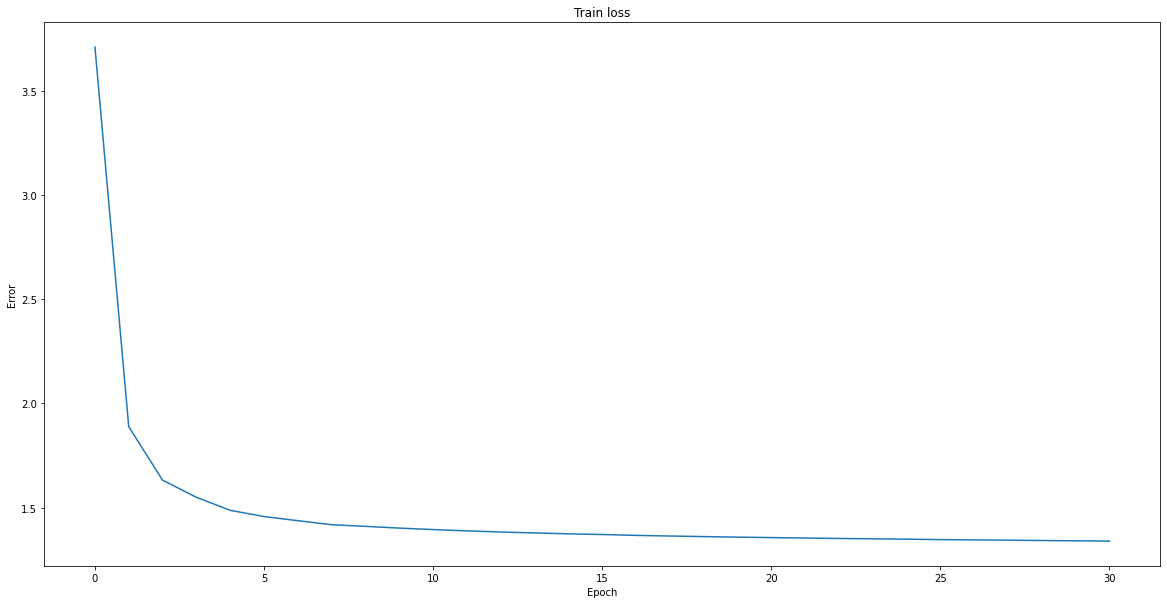

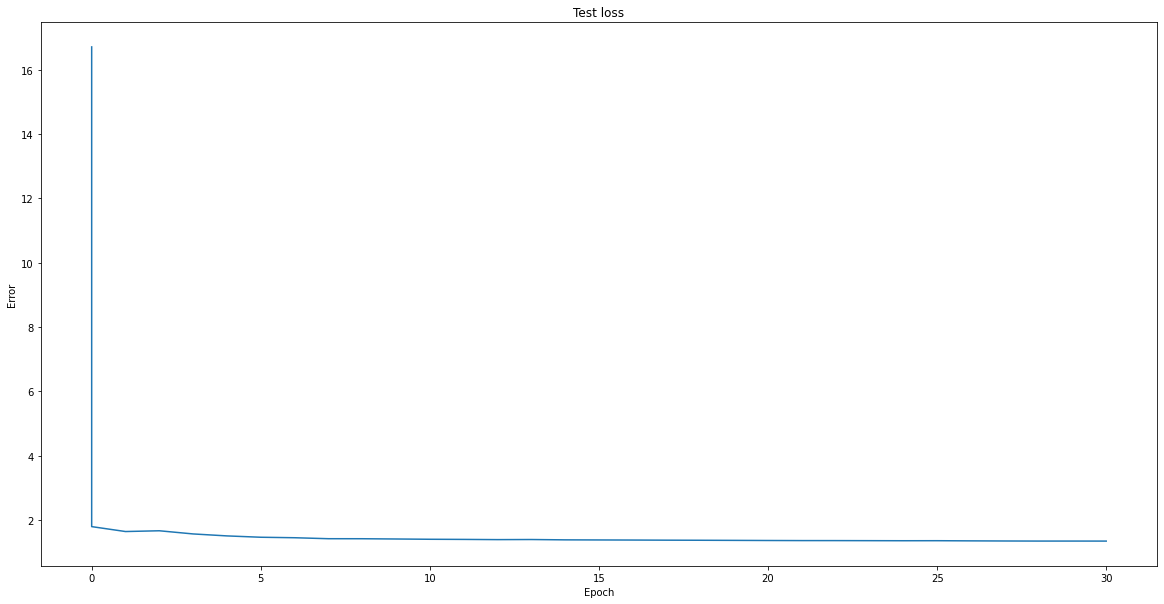

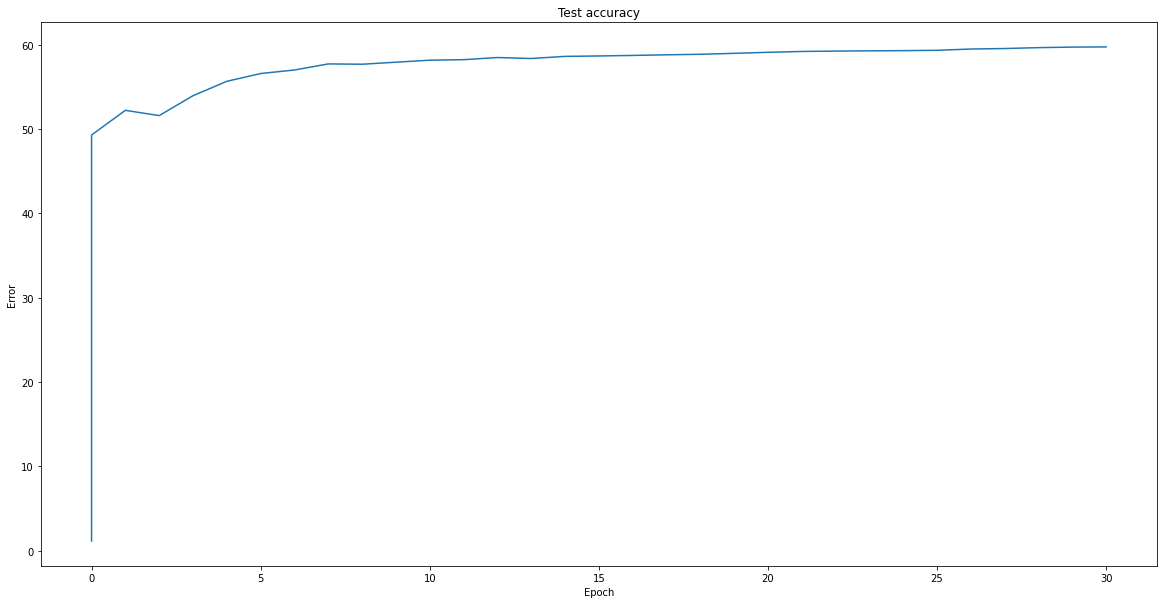

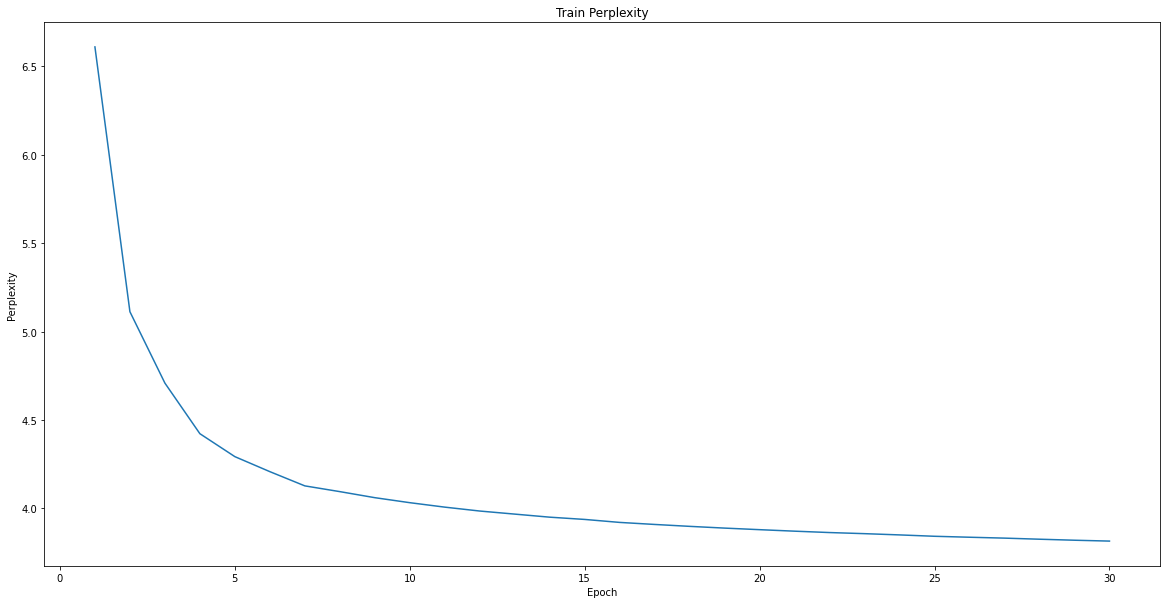

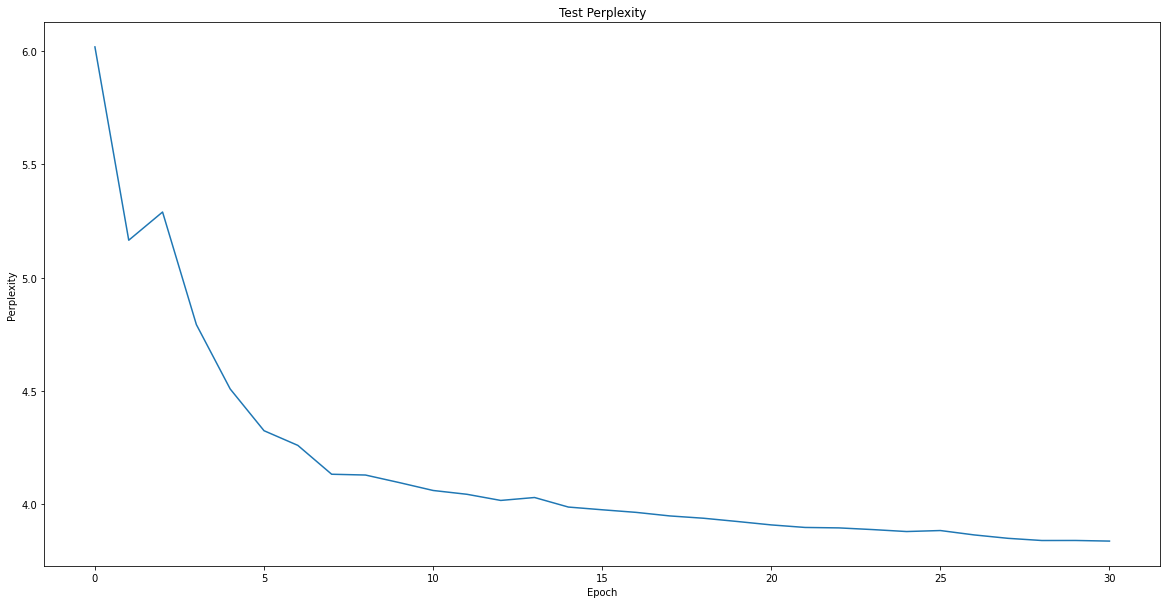

Max test perplexity:  3.8371661750300015


In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 30
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_losses)
        pt_util.plot(ep[1:], np.exp(val)[1:], 'Train Perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep[1:], np.exp(val)[1:], 'Test Perplexity', 'Epoch', 'Perplexity')
        print('Max test perplexity: ', min(np.exp(val)))
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the only one of the school of the school of the stairs were still still be the stairs and the only one of the stairs were still still be the stairs and the only one of the stairs were still still be the 
generated with sample	 Harry Potter and then still on hardly to the for the only one difficented list accept down the strietchen for into the door from Harry could hear the next to Ron and Scept to the corridor. "I move the Direlarnis?" said H
generated with sample	 Harry Potter and the fire with fire and sure you is sure it isn't it. He supposed to know . . she might of cave of the Dursleys and Hermione did not foug to atthing I ampled to straight I could not
think of still straine
generated with sample	 Harry Potter and the Death EFOUE ETT ENI HOI RSOE TN ORL THE EPERR TEEE LEU RIF LNE. ThI Ron had inle strowing drinking broom that the letter of Harry looked with the once furious, straightening from the fire, he was dre
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

# Other things 1: New Corpus


## Preprocess

In [18]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char == ' ' or char == '\n' or char == '\t':
          pass
        if char not in voc2ind:
          voc2ind[char] = len(voc2ind)

    ind2voc = {val: key for key, val in voc2ind.items()}
    eighty = int(len(data) * 0.8)
    train_text = data[0:eighty] # TODO Fill this in
    test_text = data[eighty:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'roman_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'roman_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'roman.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

In [ ]:
class RomanDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(RomanDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']
        encoded_tokens = [self.voc2ind[char] for char in self.tokens]

        self.data = torch.LongTensor(
            encoded_tokens[:len(encoded_tokens) - (len(encoded_tokens) % batch_size)]
        ).view(batch_size, -1)
        self.seq_num =  math.ceil((self.data.shape[1] - 1) / sequence_length)


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.data.shape[0] * self.seq_num
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size
        front_idx = (idx // self.batch_size) * self.sequence_length
        data = self.data[batch_idx][front_idx : min(self.data.shape[1], front_idx + self.sequence_length + 1)]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

In [ ]:
TEMPERATURE = 0.5

class RomanNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(RomanNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

## Train

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([164, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([164, 512]) = 0MB
decoder.bias -> 	torch.Size([164]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints/007.pt
Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	nhoas sicited bn the sume trme oy t soltitude of       trlgrima  and thet the soetioal of thini and 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	tet
sartil
an
  

  0%|          | 2/424 [00:00<01:30,  4.66it/s]

Train Epoch: 7 [0/108544 (0%)]	Loss: 1.268657


  3%|▎         | 12/424 [00:02<01:13,  5.64it/s]

Train Epoch: 7 [2560/108544 (2%)]	Loss: 1.619476


  5%|▌         | 22/424 [00:03<01:10,  5.68it/s]

Train Epoch: 7 [5120/108544 (5%)]	Loss: 1.422983


  8%|▊         | 32/424 [00:05<01:09,  5.63it/s]

Train Epoch: 7 [7680/108544 (7%)]	Loss: 1.297411


 10%|▉         | 42/424 [00:07<01:08,  5.57it/s]

Train Epoch: 7 [10240/108544 (9%)]	Loss: 1.275504


 12%|█▏        | 52/424 [00:09<01:05,  5.68it/s]

Train Epoch: 7 [12800/108544 (12%)]	Loss: 1.297608


 15%|█▍        | 62/424 [00:11<01:04,  5.58it/s]

Train Epoch: 7 [15360/108544 (14%)]	Loss: 1.263177


 17%|█▋        | 72/424 [00:12<01:01,  5.70it/s]

Train Epoch: 7 [17920/108544 (17%)]	Loss: 1.266991


 19%|█▉        | 82/424 [00:14<01:00,  5.70it/s]

Train Epoch: 7 [20480/108544 (19%)]	Loss: 1.239894


 22%|██▏       | 92/424 [00:16<00:57,  5.74it/s]

Train Epoch: 7 [23040/108544 (21%)]	Loss: 1.250290


 24%|██▍       | 102/424 [00:18<00:57,  5.59it/s]

Train Epoch: 7 [25600/108544 (24%)]	Loss: 1.236845


 26%|██▋       | 112/424 [00:19<00:54,  5.70it/s]

Train Epoch: 7 [28160/108544 (26%)]	Loss: 1.259579


 29%|██▉       | 122/424 [00:21<00:53,  5.61it/s]

Train Epoch: 7 [30720/108544 (28%)]	Loss: 1.266334


 31%|███       | 132/424 [00:23<00:52,  5.60it/s]

Train Epoch: 7 [33280/108544 (31%)]	Loss: 1.253086


 33%|███▎      | 142/424 [00:25<00:49,  5.71it/s]

Train Epoch: 7 [35840/108544 (33%)]	Loss: 1.232857


 36%|███▌      | 152/424 [00:26<00:47,  5.71it/s]

Train Epoch: 7 [38400/108544 (35%)]	Loss: 1.262508


 38%|███▊      | 162/424 [00:28<00:46,  5.60it/s]

Train Epoch: 7 [40960/108544 (38%)]	Loss: 1.247588


 41%|████      | 172/424 [00:30<00:45,  5.56it/s]

Train Epoch: 7 [43520/108544 (40%)]	Loss: 1.230313


 43%|████▎     | 182/424 [00:32<00:42,  5.64it/s]

Train Epoch: 7 [46080/108544 (42%)]	Loss: 1.242247


 45%|████▌     | 192/424 [00:33<00:40,  5.66it/s]

Train Epoch: 7 [48640/108544 (45%)]	Loss: 1.224782


 48%|████▊     | 202/424 [00:35<00:39,  5.58it/s]

Train Epoch: 7 [51200/108544 (47%)]	Loss: 1.258896


 50%|█████     | 212/424 [00:37<00:37,  5.68it/s]

Train Epoch: 7 [53760/108544 (50%)]	Loss: 1.267719


 52%|█████▏    | 222/424 [00:39<00:36,  5.51it/s]

Train Epoch: 7 [56320/108544 (52%)]	Loss: 1.260363


 55%|█████▍    | 232/424 [00:41<00:34,  5.58it/s]

Train Epoch: 7 [58880/108544 (54%)]	Loss: 1.267891


 57%|█████▋    | 242/424 [00:42<00:31,  5.71it/s]

Train Epoch: 7 [61440/108544 (57%)]	Loss: 1.248837


 59%|█████▉    | 252/424 [00:44<00:30,  5.60it/s]

Train Epoch: 7 [64000/108544 (59%)]	Loss: 1.257368


 62%|██████▏   | 262/424 [00:46<00:28,  5.60it/s]

Train Epoch: 7 [66560/108544 (61%)]	Loss: 1.253672


 64%|██████▍   | 272/424 [00:48<00:26,  5.70it/s]

Train Epoch: 7 [69120/108544 (64%)]	Loss: 1.255224


 67%|██████▋   | 282/424 [00:49<00:25,  5.59it/s]

Train Epoch: 7 [71680/108544 (66%)]	Loss: 1.230064


 69%|██████▉   | 292/424 [00:51<00:23,  5.68it/s]

Train Epoch: 7 [74240/108544 (68%)]	Loss: 1.259589


 71%|███████   | 302/424 [00:53<00:21,  5.67it/s]

Train Epoch: 7 [76800/108544 (71%)]	Loss: 1.278597


 74%|███████▎  | 312/424 [00:55<00:19,  5.71it/s]

Train Epoch: 7 [79360/108544 (73%)]	Loss: 1.247314


 76%|███████▌  | 322/424 [00:56<00:17,  5.72it/s]

Train Epoch: 7 [81920/108544 (75%)]	Loss: 1.258843


 78%|███████▊  | 332/424 [00:58<00:16,  5.74it/s]

Train Epoch: 7 [84480/108544 (78%)]	Loss: 1.236969


 81%|████████  | 342/424 [01:00<00:14,  5.69it/s]

Train Epoch: 7 [87040/108544 (80%)]	Loss: 1.228980


 83%|████████▎ | 352/424 [01:02<00:12,  5.66it/s]

Train Epoch: 7 [89600/108544 (83%)]	Loss: 1.251811


 85%|████████▌ | 362/424 [01:04<00:11,  5.51it/s]

Train Epoch: 7 [92160/108544 (85%)]	Loss: 1.249676


 88%|████████▊ | 372/424 [01:05<00:09,  5.63it/s]

Train Epoch: 7 [94720/108544 (87%)]	Loss: 1.267068


 90%|█████████ | 382/424 [01:07<00:07,  5.71it/s]

Train Epoch: 7 [97280/108544 (90%)]	Loss: 1.242656


 92%|█████████▏| 392/424 [01:09<00:05,  5.59it/s]

Train Epoch: 7 [99840/108544 (92%)]	Loss: 1.236669


 95%|█████████▍| 402/424 [01:11<00:03,  5.71it/s]

Train Epoch: 7 [102400/108544 (94%)]	Loss: 1.217992


 97%|█████████▋| 412/424 [01:12<00:02,  5.68it/s]

Train Epoch: 7 [104960/108544 (97%)]	Loss: 1.224960


100%|█████████▉| 422/424 [01:14<00:00,  5.69it/s]

Train Epoch: 7 [107520/108544 (99%)]	Loss: 1.236097


100%|██████████| 424/424 [01:14<00:00,  5.66it/s]


Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	s oas secited bn the peme oome oe t soltitude of       trllrims, and thet the paetioal of thanirand 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	tet pastis
an
      oescrted tis eertdard  Teo r the par   aetd tnuel,a  ah tis       roristian pral


Input	hat were exposed for sale, the money that was
      brought for purchase, the gay decorations of the
GT	at were exposed for sale, the money that was
      brought for purchase, the gay decorations of the 
pred	et tere txtesed trr tetu  the posa  ooat oes       reotght oor trbphase  the prt oeslrateon  of the 


Input	ative expression in the text, though


  0%|          | 2/424 [00:00<01:37,  4.31it/s]

Train Epoch: 8 [0/108544 (0%)]	Loss: 1.273341


  3%|▎         | 12/424 [00:02<01:13,  5.61it/s]

Train Epoch: 8 [2560/108544 (2%)]	Loss: 1.260461


  5%|▌         | 22/424 [00:04<01:12,  5.56it/s]

Train Epoch: 8 [5120/108544 (5%)]	Loss: 1.260146


  8%|▊         | 32/424 [00:05<01:10,  5.53it/s]

Train Epoch: 8 [7680/108544 (7%)]	Loss: 1.224741


 10%|▉         | 42/424 [00:07<01:07,  5.62it/s]

Train Epoch: 8 [10240/108544 (9%)]	Loss: 1.251822


 12%|█▏        | 52/424 [00:09<01:07,  5.51it/s]

Train Epoch: 8 [12800/108544 (12%)]	Loss: 1.278128


 15%|█▍        | 62/424 [00:11<01:04,  5.61it/s]

Train Epoch: 8 [15360/108544 (14%)]	Loss: 1.251176


 17%|█▋        | 72/424 [00:12<01:02,  5.65it/s]

Train Epoch: 8 [17920/108544 (17%)]	Loss: 1.260407


 19%|█▉        | 82/424 [00:14<01:01,  5.53it/s]

Train Epoch: 8 [20480/108544 (19%)]	Loss: 1.236314


 22%|██▏       | 92/424 [00:16<00:59,  5.62it/s]

Train Epoch: 8 [23040/108544 (21%)]	Loss: 1.244245


 24%|██▍       | 102/424 [00:18<00:56,  5.69it/s]

Train Epoch: 8 [25600/108544 (24%)]	Loss: 1.235106


 26%|██▋       | 112/424 [00:20<00:56,  5.49it/s]

Train Epoch: 8 [28160/108544 (26%)]	Loss: 1.257170


 29%|██▉       | 122/424 [00:21<00:53,  5.62it/s]

Train Epoch: 8 [30720/108544 (28%)]	Loss: 1.266822


 31%|███       | 132/424 [00:23<00:52,  5.58it/s]

Train Epoch: 8 [33280/108544 (31%)]	Loss: 1.250794


 33%|███▎      | 142/424 [00:25<00:50,  5.61it/s]

Train Epoch: 8 [35840/108544 (33%)]	Loss: 1.233472


 36%|███▌      | 152/424 [00:27<00:48,  5.58it/s]

Train Epoch: 8 [38400/108544 (35%)]	Loss: 1.267805


 38%|███▊      | 162/424 [00:28<00:46,  5.59it/s]

Train Epoch: 8 [40960/108544 (38%)]	Loss: 1.246861


 41%|████      | 172/424 [00:30<00:44,  5.65it/s]

Train Epoch: 8 [43520/108544 (40%)]	Loss: 1.226395


 43%|████▎     | 182/424 [00:32<00:43,  5.61it/s]

Train Epoch: 8 [46080/108544 (42%)]	Loss: 1.240345


 45%|████▌     | 192/424 [00:34<00:41,  5.64it/s]

Train Epoch: 8 [48640/108544 (45%)]	Loss: 1.221836


 48%|████▊     | 202/424 [00:36<00:39,  5.64it/s]

Train Epoch: 8 [51200/108544 (47%)]	Loss: 1.256582


 50%|█████     | 212/424 [00:37<00:37,  5.65it/s]

Train Epoch: 8 [53760/108544 (50%)]	Loss: 1.261222


 52%|█████▏    | 222/424 [00:39<00:36,  5.53it/s]

Train Epoch: 8 [56320/108544 (52%)]	Loss: 1.255378


 55%|█████▍    | 232/424 [00:41<00:33,  5.71it/s]

Train Epoch: 8 [58880/108544 (54%)]	Loss: 1.267281


 57%|█████▋    | 242/424 [00:43<00:32,  5.67it/s]

Train Epoch: 8 [61440/108544 (57%)]	Loss: 1.247977


 59%|█████▉    | 252/424 [00:44<00:30,  5.67it/s]

Train Epoch: 8 [64000/108544 (59%)]	Loss: 1.258162


 62%|██████▏   | 262/424 [00:46<00:28,  5.61it/s]

Train Epoch: 8 [66560/108544 (61%)]	Loss: 1.254906


 64%|██████▍   | 272/424 [00:48<00:26,  5.71it/s]

Train Epoch: 8 [69120/108544 (64%)]	Loss: 1.251278


 67%|██████▋   | 282/424 [00:50<00:25,  5.57it/s]

Train Epoch: 8 [71680/108544 (66%)]	Loss: 1.226030


 69%|██████▉   | 292/424 [00:51<00:23,  5.68it/s]

Train Epoch: 8 [74240/108544 (68%)]	Loss: 1.252065


 71%|███████   | 302/424 [00:53<00:22,  5.52it/s]

Train Epoch: 8 [76800/108544 (71%)]	Loss: 1.273256


 74%|███████▎  | 312/424 [00:55<00:19,  5.69it/s]

Train Epoch: 8 [79360/108544 (73%)]	Loss: 1.244765


 76%|███████▌  | 322/424 [00:57<00:18,  5.61it/s]

Train Epoch: 8 [81920/108544 (75%)]	Loss: 1.254875


 78%|███████▊  | 332/424 [00:58<00:16,  5.61it/s]

Train Epoch: 8 [84480/108544 (78%)]	Loss: 1.233940


 81%|████████  | 342/424 [01:00<00:14,  5.74it/s]

Train Epoch: 8 [87040/108544 (80%)]	Loss: 1.227831


 83%|████████▎ | 352/424 [01:02<00:12,  5.74it/s]

Train Epoch: 8 [89600/108544 (83%)]	Loss: 1.246595


 85%|████████▌ | 362/424 [01:04<00:11,  5.59it/s]

Train Epoch: 8 [92160/108544 (85%)]	Loss: 1.244577


 88%|████████▊ | 372/424 [01:05<00:09,  5.67it/s]

Train Epoch: 8 [94720/108544 (87%)]	Loss: 1.264943


 90%|█████████ | 382/424 [01:07<00:07,  5.73it/s]

Train Epoch: 8 [97280/108544 (90%)]	Loss: 1.237867


 92%|█████████▏| 392/424 [01:09<00:05,  5.60it/s]

Train Epoch: 8 [99840/108544 (92%)]	Loss: 1.230745


 95%|█████████▍| 402/424 [01:11<00:03,  5.67it/s]

Train Epoch: 8 [102400/108544 (94%)]	Loss: 1.209735


 97%|█████████▋| 412/424 [01:13<00:02,  5.68it/s]

Train Epoch: 8 [104960/108544 (97%)]	Loss: 1.216867


100%|█████████▉| 422/424 [01:14<00:00,  5.58it/s]

Train Epoch: 8 [107520/108544 (99%)]	Loss: 1.231740


100%|██████████| 424/424 [01:15<00:00,  5.65it/s]


Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	shoas selited bn the peme ohme oy t soltitude of       trllrims, and thet the paatioal of thani and 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	tet sastis
an
      oestrted tis fertdard  Tne r the par   aetd tfuel,a  ao tis       roristian pril


Input	hat were exposed for sale, the money that was
      brought for purchase, the gay decorations of the
GT	at were exposed for sale, the money that was
      brought for purchase, the gay decorations of the 
pred	et tere txtesed trr totu  the posa  ooat ths       reotght oor trbphase  the prt oeslrateon  of the 


Input	ative expression in the text, though


  0%|          | 2/424 [00:00<01:41,  4.16it/s]

Train Epoch: 9 [0/108544 (0%)]	Loss: 1.275165


  3%|▎         | 12/424 [00:02<01:12,  5.65it/s]

Train Epoch: 9 [2560/108544 (2%)]	Loss: 1.254371


  5%|▌         | 22/424 [00:04<01:12,  5.53it/s]

Train Epoch: 9 [5120/108544 (5%)]	Loss: 1.250191


  8%|▊         | 32/424 [00:05<01:09,  5.62it/s]

Train Epoch: 9 [7680/108544 (7%)]	Loss: 1.219961


 10%|▉         | 42/424 [00:07<01:07,  5.69it/s]

Train Epoch: 9 [10240/108544 (9%)]	Loss: 1.247242


 12%|█▏        | 52/424 [00:09<01:05,  5.66it/s]

Train Epoch: 9 [12800/108544 (12%)]	Loss: 1.273793


 15%|█▍        | 62/424 [00:11<01:03,  5.66it/s]

Train Epoch: 9 [15360/108544 (14%)]	Loss: 1.246419


 17%|█▋        | 72/424 [00:12<01:01,  5.68it/s]

Train Epoch: 9 [17920/108544 (17%)]	Loss: 1.255288


 19%|█▉        | 82/424 [00:14<01:01,  5.56it/s]

Train Epoch: 9 [20480/108544 (19%)]	Loss: 1.229640


 22%|██▏       | 92/424 [00:16<00:59,  5.58it/s]

Train Epoch: 9 [23040/108544 (21%)]	Loss: 1.240004


 24%|██▍       | 102/424 [00:18<00:57,  5.62it/s]

Train Epoch: 9 [25600/108544 (24%)]	Loss: 1.230793


 26%|██▋       | 112/424 [00:19<00:55,  5.60it/s]

Train Epoch: 9 [28160/108544 (26%)]	Loss: 1.251324


 29%|██▉       | 122/424 [00:21<00:53,  5.65it/s]

Train Epoch: 9 [30720/108544 (28%)]	Loss: 1.259097


 31%|███       | 132/424 [00:23<00:52,  5.60it/s]

Train Epoch: 9 [33280/108544 (31%)]	Loss: 1.244060


 33%|███▎      | 142/424 [00:25<00:50,  5.56it/s]

Train Epoch: 9 [35840/108544 (33%)]	Loss: 1.225795


 36%|███▌      | 152/424 [00:27<00:48,  5.62it/s]

Train Epoch: 9 [38400/108544 (35%)]	Loss: 1.257429


 38%|███▊      | 162/424 [00:28<00:46,  5.60it/s]

Train Epoch: 9 [40960/108544 (38%)]	Loss: 1.242587


 41%|████      | 172/424 [00:30<00:45,  5.58it/s]

Train Epoch: 9 [43520/108544 (40%)]	Loss: 1.216464


 43%|████▎     | 182/424 [00:32<00:43,  5.62it/s]

Train Epoch: 9 [46080/108544 (42%)]	Loss: 1.235223


 45%|████▌     | 192/424 [00:34<00:40,  5.68it/s]

Train Epoch: 9 [48640/108544 (45%)]	Loss: 1.217703


 48%|████▊     | 202/424 [00:35<00:39,  5.58it/s]

Train Epoch: 9 [51200/108544 (47%)]	Loss: 1.249911


 50%|█████     | 212/424 [00:37<00:38,  5.57it/s]

Train Epoch: 9 [53760/108544 (50%)]	Loss: 1.255580


 52%|█████▏    | 222/424 [00:39<00:35,  5.73it/s]

Train Epoch: 9 [56320/108544 (52%)]	Loss: 1.252753


 55%|█████▍    | 232/424 [00:41<00:34,  5.61it/s]

Train Epoch: 9 [58880/108544 (54%)]	Loss: 1.268040


 57%|█████▋    | 242/424 [00:43<00:32,  5.55it/s]

Train Epoch: 9 [61440/108544 (57%)]	Loss: 1.244740


 59%|█████▉    | 252/424 [00:44<00:30,  5.73it/s]

Train Epoch: 9 [64000/108544 (59%)]	Loss: 1.249685


 62%|██████▏   | 262/424 [00:46<00:28,  5.61it/s]

Train Epoch: 9 [66560/108544 (61%)]	Loss: 1.247994


 64%|██████▍   | 272/424 [00:48<00:26,  5.65it/s]

Train Epoch: 9 [69120/108544 (64%)]	Loss: 1.246086


 67%|██████▋   | 282/424 [00:50<00:25,  5.52it/s]

Train Epoch: 9 [71680/108544 (66%)]	Loss: 1.221788


 69%|██████▉   | 292/424 [00:51<00:23,  5.64it/s]

Train Epoch: 9 [74240/108544 (68%)]	Loss: 1.248989


 71%|███████   | 302/424 [00:53<00:21,  5.62it/s]

Train Epoch: 9 [76800/108544 (71%)]	Loss: 1.271004


 74%|███████▎  | 312/424 [00:55<00:19,  5.72it/s]

Train Epoch: 9 [79360/108544 (73%)]	Loss: 1.240043


 76%|███████▌  | 322/424 [00:57<00:18,  5.64it/s]

Train Epoch: 9 [81920/108544 (75%)]	Loss: 1.245154


 78%|███████▊  | 332/424 [00:59<00:16,  5.72it/s]

Train Epoch: 9 [84480/108544 (78%)]	Loss: 1.229969


 81%|████████  | 342/424 [01:00<00:14,  5.67it/s]

Train Epoch: 9 [87040/108544 (80%)]	Loss: 1.226541


 83%|████████▎ | 352/424 [01:02<00:12,  5.62it/s]

Train Epoch: 9 [89600/108544 (83%)]	Loss: 1.239859


 85%|████████▌ | 362/424 [01:04<00:11,  5.63it/s]

Train Epoch: 9 [92160/108544 (85%)]	Loss: 1.239022


 88%|████████▊ | 372/424 [01:06<00:09,  5.59it/s]

Train Epoch: 9 [94720/108544 (87%)]	Loss: 1.259350


 90%|█████████ | 382/424 [01:07<00:07,  5.58it/s]

Train Epoch: 9 [97280/108544 (90%)]	Loss: 1.234476


 92%|█████████▏| 392/424 [01:09<00:05,  5.57it/s]

Train Epoch: 9 [99840/108544 (92%)]	Loss: 1.225317


 95%|█████████▍| 402/424 [01:11<00:03,  5.64it/s]

Train Epoch: 9 [102400/108544 (94%)]	Loss: 1.202077


 97%|█████████▋| 412/424 [01:13<00:02,  5.69it/s]

Train Epoch: 9 [104960/108544 (97%)]	Loss: 1.213218


100%|█████████▉| 422/424 [01:14<00:00,  5.76it/s]

Train Epoch: 9 [107520/108544 (99%)]	Loss: 1.225137


100%|██████████| 424/424 [01:15<00:00,  5.63it/s]


Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	nhoas selited bn the peme ohme oy t soltitude of       trllrims  and thet the paatival of thaci and 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	tei sastil
an
      aestrted tis fertdard  Tne r the par   aetd tfrel,a  ao tis       raristian pril


Input	hat were exposed for sale, the money that was
      brought for purchase, the gay decorations of the
GT	at were exposed for sale, the money that was
      brought for purchase, the gay decorations of the 
pred	et tere axtesed trr totu  the posa  ooat ths       reotght trr trbphase  ahe prt oeslrateon  of the 


Input	ative expression in the text, though


  0%|          | 2/424 [00:00<01:40,  4.20it/s]

Train Epoch: 10 [0/108544 (0%)]	Loss: 1.272779


  3%|▎         | 12/424 [00:02<01:13,  5.59it/s]

Train Epoch: 10 [2560/108544 (2%)]	Loss: 1.246538


  5%|▌         | 22/424 [00:04<01:12,  5.55it/s]

Train Epoch: 10 [5120/108544 (5%)]	Loss: 1.241139


  8%|▊         | 32/424 [00:05<01:09,  5.63it/s]

Train Epoch: 10 [7680/108544 (7%)]	Loss: 1.216112


 10%|▉         | 42/424 [00:07<01:08,  5.56it/s]

Train Epoch: 10 [10240/108544 (9%)]	Loss: 1.241795


 12%|█▏        | 52/424 [00:09<01:06,  5.62it/s]

Train Epoch: 10 [12800/108544 (12%)]	Loss: 1.268186


 15%|█▍        | 62/424 [00:11<01:04,  5.62it/s]

Train Epoch: 10 [15360/108544 (14%)]	Loss: 1.241647


 17%|█▋        | 72/424 [00:12<01:03,  5.58it/s]

Train Epoch: 10 [17920/108544 (17%)]	Loss: 1.250112


 19%|█▉        | 82/424 [00:14<01:00,  5.63it/s]

Train Epoch: 10 [20480/108544 (19%)]	Loss: 1.224262


 22%|██▏       | 92/424 [00:16<00:58,  5.66it/s]

Train Epoch: 10 [23040/108544 (21%)]	Loss: 1.234492


 24%|██▍       | 102/424 [00:18<00:57,  5.64it/s]

Train Epoch: 10 [25600/108544 (24%)]	Loss: 1.226483


 26%|██▋       | 112/424 [00:20<00:55,  5.64it/s]

Train Epoch: 10 [28160/108544 (26%)]	Loss: 1.248381


 29%|██▉       | 122/424 [00:21<00:54,  5.58it/s]

Train Epoch: 10 [30720/108544 (28%)]	Loss: 1.251949


 31%|███       | 132/424 [00:23<00:51,  5.69it/s]

Train Epoch: 10 [33280/108544 (31%)]	Loss: 1.236116


 33%|███▎      | 142/424 [00:25<00:50,  5.62it/s]

Train Epoch: 10 [35840/108544 (33%)]	Loss: 1.219406


 36%|███▌      | 152/424 [00:27<00:48,  5.59it/s]

Train Epoch: 10 [38400/108544 (35%)]	Loss: 1.252471


 38%|███▊      | 162/424 [00:28<00:46,  5.59it/s]

Train Epoch: 10 [40960/108544 (38%)]	Loss: 1.241319


 41%|████      | 172/424 [00:30<00:45,  5.59it/s]

Train Epoch: 10 [43520/108544 (40%)]	Loss: 1.213113


 43%|████▎     | 182/424 [00:32<00:42,  5.72it/s]

Train Epoch: 10 [46080/108544 (42%)]	Loss: 1.230614


 45%|████▌     | 192/424 [00:34<00:41,  5.62it/s]

Train Epoch: 10 [48640/108544 (45%)]	Loss: 1.212672


 48%|████▊     | 202/424 [00:36<00:39,  5.69it/s]

Train Epoch: 10 [51200/108544 (47%)]	Loss: 1.245371


 50%|█████     | 212/424 [00:37<00:37,  5.66it/s]

Train Epoch: 10 [53760/108544 (50%)]	Loss: 1.250437


 52%|█████▏    | 222/424 [00:39<00:35,  5.64it/s]

Train Epoch: 10 [56320/108544 (52%)]	Loss: 1.253104


 55%|█████▍    | 232/424 [00:41<00:34,  5.63it/s]

Train Epoch: 10 [58880/108544 (54%)]	Loss: 1.260693


 57%|█████▋    | 242/424 [00:43<00:32,  5.58it/s]

Train Epoch: 10 [61440/108544 (57%)]	Loss: 1.238156


 59%|█████▉    | 252/424 [00:44<00:30,  5.64it/s]

Train Epoch: 10 [64000/108544 (59%)]	Loss: 1.242247


 62%|██████▏   | 262/424 [00:46<00:28,  5.66it/s]

Train Epoch: 10 [66560/108544 (61%)]	Loss: 1.242572


 64%|██████▍   | 272/424 [00:48<00:26,  5.64it/s]

Train Epoch: 10 [69120/108544 (64%)]	Loss: 1.240994


 67%|██████▋   | 282/424 [00:50<00:25,  5.58it/s]

Train Epoch: 10 [71680/108544 (66%)]	Loss: 1.215780


 69%|██████▉   | 292/424 [00:51<00:23,  5.68it/s]

Train Epoch: 10 [74240/108544 (68%)]	Loss: 1.242429


 71%|███████   | 302/424 [00:53<00:21,  5.65it/s]

Train Epoch: 10 [76800/108544 (71%)]	Loss: 1.266897


 74%|███████▎  | 312/424 [00:55<00:19,  5.66it/s]

Train Epoch: 10 [79360/108544 (73%)]	Loss: 1.233405


 76%|███████▌  | 322/424 [00:57<00:17,  5.69it/s]

Train Epoch: 10 [81920/108544 (75%)]	Loss: 1.240907


 78%|███████▊  | 332/424 [00:59<00:16,  5.67it/s]

Train Epoch: 10 [84480/108544 (78%)]	Loss: 1.222835


 81%|████████  | 342/424 [01:00<00:14,  5.65it/s]

Train Epoch: 10 [87040/108544 (80%)]	Loss: 1.219027


 83%|████████▎ | 352/424 [01:02<00:12,  5.71it/s]

Train Epoch: 10 [89600/108544 (83%)]	Loss: 1.235265


 85%|████████▌ | 362/424 [01:04<00:10,  5.72it/s]

Train Epoch: 10 [92160/108544 (85%)]	Loss: 1.234282


 88%|████████▊ | 372/424 [01:06<00:09,  5.60it/s]

Train Epoch: 10 [94720/108544 (87%)]	Loss: 1.256511


 90%|█████████ | 382/424 [01:07<00:07,  5.51it/s]

Train Epoch: 10 [97280/108544 (90%)]	Loss: 1.230287


 92%|█████████▏| 392/424 [01:09<00:05,  5.66it/s]

Train Epoch: 10 [99840/108544 (92%)]	Loss: 1.221472


 95%|█████████▍| 402/424 [01:11<00:03,  5.68it/s]

Train Epoch: 10 [102400/108544 (94%)]	Loss: 1.196155


 97%|█████████▋| 412/424 [01:13<00:02,  5.53it/s]

Train Epoch: 10 [104960/108544 (97%)]	Loss: 1.208710


100%|█████████▉| 422/424 [01:15<00:00,  5.63it/s]

Train Epoch: 10 [107520/108544 (99%)]	Loss: 1.219356


100%|██████████| 424/424 [01:15<00:00,  5.63it/s]


Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	nhoas telited bn the peme ahme oy t soltitude of       trllrims  and thet the paatilal of thaci and 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	tei sastil
an
      cestrted tis featdard  Tne r the par   aetd tfyil,a  ao tis       raristian pril


Input	hat were exposed for sale, the money that was
      brought for purchase, the gay decorations of the
GT	at were exposed for sale, the money that was
      brought for purchase, the gay decorations of the 
pred	et tere axtesed trr totu  aha posa  ohat ths       reowgh  trr trbihase  tha prt oeslrdteon  of the 


Input	ative expression in the text, though


  0%|          | 2/424 [00:00<01:39,  4.25it/s]

Train Epoch: 11 [0/108544 (0%)]	Loss: 1.267249


  3%|▎         | 12/424 [00:02<01:15,  5.48it/s]

Train Epoch: 11 [2560/108544 (2%)]	Loss: 1.240703


  5%|▌         | 22/424 [00:04<01:11,  5.63it/s]

Train Epoch: 11 [5120/108544 (5%)]	Loss: 1.234471


  8%|▊         | 32/424 [00:05<01:09,  5.65it/s]

Train Epoch: 11 [7680/108544 (7%)]	Loss: 1.211496


 10%|▉         | 42/424 [00:07<01:09,  5.53it/s]

Train Epoch: 11 [10240/108544 (9%)]	Loss: 1.236027


 12%|█▏        | 52/424 [00:09<01:06,  5.59it/s]

Train Epoch: 11 [12800/108544 (12%)]	Loss: 1.263398


 15%|█▍        | 62/424 [00:11<01:03,  5.66it/s]

Train Epoch: 11 [15360/108544 (14%)]	Loss: 1.237202


 17%|█▋        | 72/424 [00:12<01:01,  5.73it/s]

Train Epoch: 11 [17920/108544 (17%)]	Loss: 1.245330


 19%|█▉        | 82/424 [00:14<01:00,  5.62it/s]

Train Epoch: 11 [20480/108544 (19%)]	Loss: 1.222318


 22%|██▏       | 92/424 [00:16<00:58,  5.67it/s]

Train Epoch: 11 [23040/108544 (21%)]	Loss: 1.229510


 24%|██▍       | 102/424 [00:18<00:57,  5.59it/s]

Train Epoch: 11 [25600/108544 (24%)]	Loss: 1.222568


 26%|██▋       | 112/424 [00:20<00:56,  5.57it/s]

Train Epoch: 11 [28160/108544 (26%)]	Loss: 1.245270


 29%|██▉       | 122/424 [00:21<00:53,  5.62it/s]

Train Epoch: 11 [30720/108544 (28%)]	Loss: 1.248127


 31%|███       | 132/424 [00:23<00:51,  5.66it/s]

Train Epoch: 11 [33280/108544 (31%)]	Loss: 1.232309


 33%|███▎      | 142/424 [00:25<00:49,  5.75it/s]

Train Epoch: 11 [35840/108544 (33%)]	Loss: 1.216515


 36%|███▌      | 152/424 [00:27<00:48,  5.61it/s]

Train Epoch: 11 [38400/108544 (35%)]	Loss: 1.246090


 38%|███▊      | 162/424 [00:28<00:46,  5.68it/s]

Train Epoch: 11 [40960/108544 (38%)]	Loss: 1.236320


 41%|████      | 172/424 [00:30<00:45,  5.54it/s]

Train Epoch: 11 [43520/108544 (40%)]	Loss: 1.209911


 43%|████▎     | 182/424 [00:32<00:42,  5.65it/s]

Train Epoch: 11 [46080/108544 (42%)]	Loss: 1.226235


 45%|████▌     | 192/424 [00:34<00:41,  5.63it/s]

Train Epoch: 11 [48640/108544 (45%)]	Loss: 1.209827


 48%|████▊     | 202/424 [00:35<00:38,  5.75it/s]

Train Epoch: 11 [51200/108544 (47%)]	Loss: 1.243744


 50%|█████     | 212/424 [00:37<00:38,  5.57it/s]

Train Epoch: 11 [53760/108544 (50%)]	Loss: 1.245553


 52%|█████▏    | 222/424 [00:39<00:36,  5.55it/s]

Train Epoch: 11 [56320/108544 (52%)]	Loss: 1.248003


 55%|█████▍    | 232/424 [00:41<00:34,  5.61it/s]

Train Epoch: 11 [58880/108544 (54%)]	Loss: 1.253836


 57%|█████▋    | 242/424 [00:43<00:31,  5.69it/s]

Train Epoch: 11 [61440/108544 (57%)]	Loss: 1.235460


 59%|█████▉    | 252/424 [00:44<00:30,  5.65it/s]

Train Epoch: 11 [64000/108544 (59%)]	Loss: 1.238106


 62%|██████▏   | 262/424 [00:46<00:28,  5.61it/s]

Train Epoch: 11 [66560/108544 (61%)]	Loss: 1.239809


 64%|██████▍   | 272/424 [00:48<00:26,  5.65it/s]

Train Epoch: 11 [69120/108544 (64%)]	Loss: 1.238044


 67%|██████▋   | 282/424 [00:50<00:25,  5.62it/s]

Train Epoch: 11 [71680/108544 (66%)]	Loss: 1.212084


 69%|██████▉   | 292/424 [00:51<00:23,  5.69it/s]

Train Epoch: 11 [74240/108544 (68%)]	Loss: 1.236567


 71%|███████   | 302/424 [00:53<00:21,  5.60it/s]

Train Epoch: 11 [76800/108544 (71%)]	Loss: 1.263371


 74%|███████▎  | 312/424 [00:55<00:20,  5.54it/s]

Train Epoch: 11 [79360/108544 (73%)]	Loss: 1.229729


 76%|███████▌  | 322/424 [00:57<00:17,  5.69it/s]

Train Epoch: 11 [81920/108544 (75%)]	Loss: 1.232736


 78%|███████▊  | 332/424 [00:59<00:16,  5.64it/s]

Train Epoch: 11 [84480/108544 (78%)]	Loss: 1.216860


 81%|████████  | 342/424 [01:00<00:14,  5.62it/s]

Train Epoch: 11 [87040/108544 (80%)]	Loss: 1.212578


 83%|████████▎ | 352/424 [01:02<00:12,  5.71it/s]

Train Epoch: 11 [89600/108544 (83%)]	Loss: 1.231357


 85%|████████▌ | 362/424 [01:04<00:10,  5.65it/s]

Train Epoch: 11 [92160/108544 (85%)]	Loss: 1.231826


 88%|████████▊ | 372/424 [01:06<00:09,  5.66it/s]

Train Epoch: 11 [94720/108544 (87%)]	Loss: 1.252397


 90%|█████████ | 382/424 [01:07<00:07,  5.53it/s]

Train Epoch: 11 [97280/108544 (90%)]	Loss: 1.227937


 92%|█████████▏| 392/424 [01:09<00:05,  5.60it/s]

Train Epoch: 11 [99840/108544 (92%)]	Loss: 1.218935


 95%|█████████▍| 402/424 [01:11<00:03,  5.63it/s]

Train Epoch: 11 [102400/108544 (94%)]	Loss: 1.192033


 97%|█████████▋| 412/424 [01:13<00:02,  5.56it/s]

Train Epoch: 11 [104960/108544 (97%)]	Loss: 1.206307


100%|█████████▉| 422/424 [01:14<00:00,  5.70it/s]

Train Epoch: 11 [107520/108544 (99%)]	Loss: 1.214454


100%|██████████| 424/424 [01:15<00:00,  5.64it/s]


Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	n oas selited bn the peme ohme oy t soltitude of       trllrims  and thet the saatilal of thani and 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	tei sastil
an
      oestrted tis featdard  Tno r the sar   aeid tfril,a  ah tis       raristian pril


Input	hat were exposed for sale, the money that was
      brought for purchase, the gay decorations of the
GT	at were exposed for sale, the money that was
      brought for purchase, the gay decorations of the 
pred	et thre axtesed trr tttu  aha sosa  ohat ohs
      reought trr trbihase  aha srt oeslrdteon  of the 


Input	ative expression in the text, though


  0%|          | 2/424 [00:00<01:42,  4.13it/s]

Train Epoch: 12 [0/108544 (0%)]	Loss: 1.261552


  3%|▎         | 12/424 [00:02<01:13,  5.60it/s]

Train Epoch: 12 [2560/108544 (2%)]	Loss: 1.235964


  5%|▌         | 22/424 [00:04<01:12,  5.55it/s]

Train Epoch: 12 [5120/108544 (5%)]	Loss: 1.228650


  8%|▊         | 32/424 [00:05<01:10,  5.55it/s]

Train Epoch: 12 [7680/108544 (7%)]	Loss: 1.206877


 10%|▉         | 42/424 [00:07<01:08,  5.61it/s]

Train Epoch: 12 [10240/108544 (9%)]	Loss: 1.231210


 12%|█▏        | 52/424 [00:09<01:06,  5.60it/s]

Train Epoch: 12 [12800/108544 (12%)]	Loss: 1.258678


 15%|█▍        | 62/424 [00:11<01:04,  5.60it/s]

Train Epoch: 12 [15360/108544 (14%)]	Loss: 1.235978


 17%|█▋        | 72/424 [00:12<01:02,  5.59it/s]

Train Epoch: 12 [17920/108544 (17%)]	Loss: 1.240169


 19%|█▉        | 82/424 [00:14<00:59,  5.72it/s]

Train Epoch: 12 [20480/108544 (19%)]	Loss: 1.220121


 22%|██▏       | 92/424 [00:16<00:59,  5.54it/s]

Train Epoch: 12 [23040/108544 (21%)]	Loss: 1.227448


 24%|██▍       | 102/424 [00:18<00:56,  5.68it/s]

Train Epoch: 12 [25600/108544 (24%)]	Loss: 1.219250


 26%|██▋       | 112/424 [00:20<00:56,  5.52it/s]

Train Epoch: 12 [28160/108544 (26%)]	Loss: 1.241668


 29%|██▉       | 122/424 [00:21<00:54,  5.55it/s]

Train Epoch: 12 [30720/108544 (28%)]	Loss: 1.244572


 31%|███       | 132/424 [00:23<00:51,  5.65it/s]

Train Epoch: 12 [33280/108544 (31%)]	Loss: 1.227475


 33%|███▎      | 142/424 [00:25<00:49,  5.73it/s]

Train Epoch: 12 [35840/108544 (33%)]	Loss: 1.213737


 36%|███▌      | 152/424 [00:27<00:48,  5.64it/s]

Train Epoch: 12 [38400/108544 (35%)]	Loss: 1.240931


 38%|███▊      | 162/424 [00:28<00:46,  5.58it/s]

Train Epoch: 12 [40960/108544 (38%)]	Loss: 1.232819


 41%|████      | 172/424 [00:30<00:44,  5.70it/s]

Train Epoch: 12 [43520/108544 (40%)]	Loss: 1.208256


 43%|████▎     | 182/424 [00:32<00:42,  5.69it/s]

Train Epoch: 12 [46080/108544 (42%)]	Loss: 1.224988


 45%|████▌     | 192/424 [00:34<00:41,  5.62it/s]

Train Epoch: 12 [48640/108544 (45%)]	Loss: 1.206679


 48%|████▊     | 202/424 [00:36<00:39,  5.68it/s]

Train Epoch: 12 [51200/108544 (47%)]	Loss: 1.240300


 50%|█████     | 212/424 [00:37<00:38,  5.55it/s]

Train Epoch: 12 [53760/108544 (50%)]	Loss: 1.243026


 52%|█████▏    | 222/424 [00:39<00:36,  5.49it/s]

Train Epoch: 12 [56320/108544 (52%)]	Loss: 1.243593


 55%|█████▍    | 232/424 [00:41<00:33,  5.67it/s]

Train Epoch: 12 [58880/108544 (54%)]	Loss: 1.250286


 57%|█████▋    | 242/424 [00:43<00:31,  5.69it/s]

Train Epoch: 12 [61440/108544 (57%)]	Loss: 1.231537


 59%|█████▉    | 252/424 [00:44<00:30,  5.62it/s]

Train Epoch: 12 [64000/108544 (59%)]	Loss: 1.235690


 62%|██████▏   | 262/424 [00:46<00:28,  5.70it/s]

Train Epoch: 12 [66560/108544 (61%)]	Loss: 1.236075


 64%|██████▍   | 272/424 [00:48<00:26,  5.68it/s]

Train Epoch: 12 [69120/108544 (64%)]	Loss: 1.233530


 67%|██████▋   | 282/424 [00:50<00:25,  5.63it/s]

Train Epoch: 12 [71680/108544 (66%)]	Loss: 1.207956


 69%|██████▉   | 292/424 [00:52<00:23,  5.70it/s]

Train Epoch: 12 [74240/108544 (68%)]	Loss: 1.232057


 71%|███████   | 302/424 [00:53<00:21,  5.57it/s]

Train Epoch: 12 [76800/108544 (71%)]	Loss: 1.258569


 74%|███████▎  | 312/424 [00:55<00:19,  5.68it/s]

Train Epoch: 12 [79360/108544 (73%)]	Loss: 1.226573


 76%|███████▌  | 322/424 [00:57<00:17,  5.67it/s]

Train Epoch: 12 [81920/108544 (75%)]	Loss: 1.229885


 78%|███████▊  | 332/424 [00:59<00:16,  5.57it/s]

Train Epoch: 12 [84480/108544 (78%)]	Loss: 1.213748


 81%|████████  | 342/424 [01:00<00:14,  5.58it/s]

Train Epoch: 12 [87040/108544 (80%)]	Loss: 1.209421


 83%|████████▎ | 352/424 [01:02<00:12,  5.54it/s]

Train Epoch: 12 [89600/108544 (83%)]	Loss: 1.228150


 85%|████████▌ | 362/424 [01:04<00:10,  5.73it/s]

Train Epoch: 12 [92160/108544 (85%)]	Loss: 1.230036


 88%|████████▊ | 372/424 [01:06<00:09,  5.52it/s]

Train Epoch: 12 [94720/108544 (87%)]	Loss: 1.248196


 90%|█████████ | 382/424 [01:07<00:07,  5.67it/s]

Train Epoch: 12 [97280/108544 (90%)]	Loss: 1.223626


 92%|█████████▏| 392/424 [01:09<00:05,  5.65it/s]

Train Epoch: 12 [99840/108544 (92%)]	Loss: 1.216868


 95%|█████████▍| 402/424 [01:11<00:03,  5.54it/s]

Train Epoch: 12 [102400/108544 (94%)]	Loss: 1.187413


 97%|█████████▋| 412/424 [01:13<00:02,  5.61it/s]

Train Epoch: 12 [104960/108544 (97%)]	Loss: 1.204002


100%|█████████▉| 422/424 [01:15<00:00,  5.72it/s]

Train Epoch: 12 [107520/108544 (99%)]	Loss: 1.212006


100%|██████████| 424/424 [01:15<00:00,  5.62it/s]


Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	n oas aelited bn the seme ohme oy t soltitude of       trllrims  and thet the saatival of thani and 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	teinsastil
an
      oestrted tis fuatdard  Tno r the sar   aeid tlrilua  ao tis       phristian pril


Input	hat were exposed for sale, the money that was
      brought for purchase, the gay decorations of the
GT	at were exposed for sale, the money that was
      brought for purchase, the gay decorations of the 
pred	et thre axtesed trr tutu  aha sosa  ohat ohs
      reought trr trbphase  aha srt oeslrdteon  of the 


Input	ative expression in the text, though


  0%|          | 2/424 [00:00<01:42,  4.11it/s]

Train Epoch: 13 [0/108544 (0%)]	Loss: 1.257955


  3%|▎         | 12/424 [00:02<01:14,  5.56it/s]

Train Epoch: 13 [2560/108544 (2%)]	Loss: 1.232114


  5%|▌         | 22/424 [00:04<01:11,  5.59it/s]

Train Epoch: 13 [5120/108544 (5%)]	Loss: 1.224610


  8%|▊         | 32/424 [00:05<01:11,  5.46it/s]

Train Epoch: 13 [7680/108544 (7%)]	Loss: 1.202584


 10%|▉         | 42/424 [00:07<01:09,  5.47it/s]

Train Epoch: 13 [10240/108544 (9%)]	Loss: 1.228179


 12%|█▏        | 52/424 [00:09<01:08,  5.45it/s]

Train Epoch: 13 [12800/108544 (12%)]	Loss: 1.255002


 15%|█▍        | 62/424 [00:11<01:04,  5.61it/s]

Train Epoch: 13 [15360/108544 (14%)]	Loss: 1.232964


 17%|█▋        | 72/424 [00:12<01:01,  5.71it/s]

Train Epoch: 13 [17920/108544 (17%)]	Loss: 1.235660


 19%|█▉        | 82/424 [00:14<01:00,  5.68it/s]

Train Epoch: 13 [20480/108544 (19%)]	Loss: 1.215475


 22%|██▏       | 92/424 [00:16<00:58,  5.67it/s]

Train Epoch: 13 [23040/108544 (21%)]	Loss: 1.225223


 24%|██▍       | 102/424 [00:18<00:56,  5.74it/s]

Train Epoch: 13 [25600/108544 (24%)]	Loss: 1.217892


 26%|██▋       | 112/424 [00:20<00:55,  5.66it/s]

Train Epoch: 13 [28160/108544 (26%)]	Loss: 1.239896


 29%|██▉       | 122/424 [00:21<00:53,  5.68it/s]

Train Epoch: 13 [30720/108544 (28%)]	Loss: 1.241700


 31%|███       | 132/424 [00:23<00:52,  5.55it/s]

Train Epoch: 13 [33280/108544 (31%)]	Loss: 1.224546


 33%|███▎      | 142/424 [00:25<00:50,  5.55it/s]

Train Epoch: 13 [35840/108544 (33%)]	Loss: 1.212282


 36%|███▌      | 152/424 [00:27<00:48,  5.63it/s]

Train Epoch: 13 [38400/108544 (35%)]	Loss: 1.239311


 38%|███▊      | 162/424 [00:28<00:46,  5.67it/s]

Train Epoch: 13 [40960/108544 (38%)]	Loss: 1.230574


 41%|████      | 172/424 [00:30<00:45,  5.54it/s]

Train Epoch: 13 [43520/108544 (40%)]	Loss: 1.206138


 43%|████▎     | 182/424 [00:32<00:42,  5.67it/s]

Train Epoch: 13 [46080/108544 (42%)]	Loss: 1.223667


 45%|████▌     | 192/424 [00:34<00:41,  5.57it/s]

Train Epoch: 13 [48640/108544 (45%)]	Loss: 1.204664


 48%|████▊     | 202/424 [00:36<00:39,  5.60it/s]

Train Epoch: 13 [51200/108544 (47%)]	Loss: 1.237139


 50%|█████     | 212/424 [00:37<00:38,  5.56it/s]

Train Epoch: 13 [53760/108544 (50%)]	Loss: 1.238994


 52%|█████▏    | 222/424 [00:39<00:36,  5.55it/s]

Train Epoch: 13 [56320/108544 (52%)]	Loss: 1.239815


 55%|█████▍    | 232/424 [00:41<00:33,  5.71it/s]

Train Epoch: 13 [58880/108544 (54%)]	Loss: 1.247607


 57%|█████▋    | 242/424 [00:43<00:31,  5.71it/s]

Train Epoch: 13 [61440/108544 (57%)]	Loss: 1.228599


 59%|█████▉    | 252/424 [00:44<00:30,  5.70it/s]

Train Epoch: 13 [64000/108544 (59%)]	Loss: 1.234849


 62%|██████▏   | 262/424 [00:46<00:28,  5.66it/s]

Train Epoch: 13 [66560/108544 (61%)]	Loss: 1.233357


 64%|██████▍   | 272/424 [00:48<00:27,  5.61it/s]

Train Epoch: 13 [69120/108544 (64%)]	Loss: 1.230359


 67%|██████▋   | 282/424 [00:50<00:25,  5.66it/s]

Train Epoch: 13 [71680/108544 (66%)]	Loss: 1.204600


 69%|██████▉   | 292/424 [00:52<00:23,  5.68it/s]

Train Epoch: 13 [74240/108544 (68%)]	Loss: 1.230174


 71%|███████   | 302/424 [00:53<00:21,  5.65it/s]

Train Epoch: 13 [76800/108544 (71%)]	Loss: 1.255306


 74%|███████▎  | 312/424 [00:55<00:19,  5.64it/s]

Train Epoch: 13 [79360/108544 (73%)]	Loss: 1.223814


 76%|███████▌  | 322/424 [00:57<00:17,  5.72it/s]

Train Epoch: 13 [81920/108544 (75%)]	Loss: 1.228264


 78%|███████▊  | 332/424 [00:59<00:16,  5.74it/s]

Train Epoch: 13 [84480/108544 (78%)]	Loss: 1.211854


 81%|████████  | 342/424 [01:00<00:14,  5.58it/s]

Train Epoch: 13 [87040/108544 (80%)]	Loss: 1.208593


 83%|████████▎ | 352/424 [01:02<00:12,  5.54it/s]

Train Epoch: 13 [89600/108544 (83%)]	Loss: 1.223526


 85%|████████▌ | 362/424 [01:04<00:10,  5.71it/s]

Train Epoch: 13 [92160/108544 (85%)]	Loss: 1.228965


 88%|████████▊ | 372/424 [01:06<00:09,  5.60it/s]

Train Epoch: 13 [94720/108544 (87%)]	Loss: 1.243465


 90%|█████████ | 382/424 [01:07<00:07,  5.66it/s]

Train Epoch: 13 [97280/108544 (90%)]	Loss: 1.218403


 92%|█████████▏| 392/424 [01:09<00:05,  5.67it/s]

Train Epoch: 13 [99840/108544 (92%)]	Loss: 1.213216


 95%|█████████▍| 402/424 [01:11<00:03,  5.69it/s]

Train Epoch: 13 [102400/108544 (94%)]	Loss: 1.184737


 97%|█████████▋| 412/424 [01:13<00:02,  5.69it/s]

Train Epoch: 13 [104960/108544 (97%)]	Loss: 1.203610


100%|█████████▉| 422/424 [01:15<00:00,  5.69it/s]

Train Epoch: 13 [107520/108544 (99%)]	Loss: 1.209691


100%|██████████| 424/424 [01:15<00:00,  5.63it/s]


Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	n oas aelited bn the seme ohme oy t
soltitude of       trllrims  and thet the saatival of thani and 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	tetnsastil
an
      aestrted tis fuatdard  Tno r ohe sar   aeid tnrilua, ao tis
      phristian pril


Input	hat were exposed for sale, the money that was
      brought for purchase, the gay decorations of the
GT	at were exposed for sale, the money that was
      brought for purchase, the gay decorations of the 
pred	et thre axtesed trr tutu  aha sosas ohat ohs
      reought trr trbphase  aha srt oeslrdteon  of the 


Input	ative expression in the text, though


  0%|          | 1/424 [00:00<02:09,  3.26it/s]

Train Epoch: 14 [0/108544 (0%)]	Loss: 1.254154


  3%|▎         | 12/424 [00:02<01:14,  5.55it/s]

Train Epoch: 14 [2560/108544 (2%)]	Loss: 1.229148


  5%|▌         | 22/424 [00:04<01:12,  5.57it/s]

Train Epoch: 14 [5120/108544 (5%)]	Loss: 1.221148


  8%|▊         | 32/424 [00:05<01:12,  5.41it/s]

Train Epoch: 14 [7680/108544 (7%)]	Loss: 1.199061


 10%|▉         | 42/424 [00:07<01:08,  5.55it/s]

Train Epoch: 14 [10240/108544 (9%)]	Loss: 1.224532


 12%|█▏        | 52/424 [00:09<01:06,  5.58it/s]

Train Epoch: 14 [12800/108544 (12%)]	Loss: 1.252937


 15%|█▍        | 62/424 [00:11<01:05,  5.51it/s]

Train Epoch: 14 [15360/108544 (14%)]	Loss: 1.229786


 17%|█▋        | 72/424 [00:13<01:02,  5.65it/s]

Train Epoch: 14 [17920/108544 (17%)]	Loss: 1.233403


 19%|█▉        | 82/424 [00:14<01:00,  5.61it/s]

Train Epoch: 14 [20480/108544 (19%)]	Loss: 1.211145


 22%|██▏       | 92/424 [00:16<00:59,  5.55it/s]

Train Epoch: 14 [23040/108544 (21%)]	Loss: 1.224503


 24%|██▍       | 102/424 [00:18<00:56,  5.67it/s]

Train Epoch: 14 [25600/108544 (24%)]	Loss: 1.218926


 26%|██▋       | 112/424 [00:20<00:56,  5.56it/s]

Train Epoch: 14 [28160/108544 (26%)]	Loss: 1.238369


 29%|██▉       | 122/424 [00:21<00:54,  5.58it/s]

Train Epoch: 14 [30720/108544 (28%)]	Loss: 1.238977


 31%|███       | 132/424 [00:23<00:51,  5.63it/s]

Train Epoch: 14 [33280/108544 (31%)]	Loss: 1.222309


 33%|███▎      | 142/424 [00:25<00:50,  5.54it/s]

Train Epoch: 14 [35840/108544 (33%)]	Loss: 1.209466


 36%|███▌      | 152/424 [00:27<00:47,  5.68it/s]

Train Epoch: 14 [38400/108544 (35%)]	Loss: 1.239280


 38%|███▊      | 162/424 [00:29<00:46,  5.58it/s]

Train Epoch: 14 [40960/108544 (38%)]	Loss: 1.228722


 41%|████      | 172/424 [00:30<00:44,  5.63it/s]

Train Epoch: 14 [43520/108544 (40%)]	Loss: 1.203272


 43%|████▎     | 182/424 [00:32<00:43,  5.54it/s]

Train Epoch: 14 [46080/108544 (42%)]	Loss: 1.221752


 45%|████▌     | 192/424 [00:34<00:40,  5.68it/s]

Train Epoch: 14 [48640/108544 (45%)]	Loss: 1.203378


 48%|████▊     | 202/424 [00:36<00:39,  5.63it/s]

Train Epoch: 14 [51200/108544 (47%)]	Loss: 1.234374


 50%|█████     | 212/424 [00:37<00:38,  5.44it/s]

Train Epoch: 14 [53760/108544 (50%)]	Loss: 1.235395


 52%|█████▏    | 222/424 [00:39<00:36,  5.61it/s]

Train Epoch: 14 [56320/108544 (52%)]	Loss: 1.236745


 55%|█████▍    | 232/424 [00:41<00:34,  5.53it/s]

Train Epoch: 14 [58880/108544 (54%)]	Loss: 1.245868


 57%|█████▋    | 242/424 [00:43<00:31,  5.70it/s]

Train Epoch: 14 [61440/108544 (57%)]	Loss: 1.226088


 59%|█████▉    | 252/424 [00:45<00:30,  5.57it/s]

Train Epoch: 14 [64000/108544 (59%)]	Loss: 1.232771


 62%|██████▏   | 262/424 [00:46<00:28,  5.68it/s]

Train Epoch: 14 [66560/108544 (61%)]	Loss: 1.230660


 64%|██████▍   | 272/424 [00:48<00:26,  5.72it/s]

Train Epoch: 14 [69120/108544 (64%)]	Loss: 1.227609


 67%|██████▋   | 282/424 [00:50<00:25,  5.64it/s]

Train Epoch: 14 [71680/108544 (66%)]	Loss: 1.200950


 69%|██████▉   | 292/424 [00:52<00:23,  5.52it/s]

Train Epoch: 14 [74240/108544 (68%)]	Loss: 1.228371


 71%|███████   | 302/424 [00:53<00:21,  5.66it/s]

Train Epoch: 14 [76800/108544 (71%)]	Loss: 1.252450


 74%|███████▎  | 312/424 [00:55<00:19,  5.72it/s]

Train Epoch: 14 [79360/108544 (73%)]	Loss: 1.220047


 76%|███████▌  | 322/424 [00:57<00:18,  5.50it/s]

Train Epoch: 14 [81920/108544 (75%)]	Loss: 1.225221


 78%|███████▊  | 332/424 [00:59<00:16,  5.63it/s]

Train Epoch: 14 [84480/108544 (78%)]	Loss: 1.208802


 81%|████████  | 342/424 [01:01<00:14,  5.66it/s]

Train Epoch: 14 [87040/108544 (80%)]	Loss: 1.205760


 83%|████████▎ | 352/424 [01:02<00:12,  5.70it/s]

Train Epoch: 14 [89600/108544 (83%)]	Loss: 1.222387


 85%|████████▌ | 362/424 [01:04<00:11,  5.62it/s]

Train Epoch: 14 [92160/108544 (85%)]	Loss: 1.227564


 88%|████████▊ | 372/424 [01:06<00:09,  5.68it/s]

Train Epoch: 14 [94720/108544 (87%)]	Loss: 1.242383


 90%|█████████ | 382/424 [01:08<00:07,  5.56it/s]

Train Epoch: 14 [97280/108544 (90%)]	Loss: 1.216133


 92%|█████████▏| 392/424 [01:09<00:05,  5.62it/s]

Train Epoch: 14 [99840/108544 (92%)]	Loss: 1.211524


 95%|█████████▍| 402/424 [01:11<00:03,  5.71it/s]

Train Epoch: 14 [102400/108544 (94%)]	Loss: 1.183279


 97%|█████████▋| 412/424 [01:13<00:02,  5.68it/s]

Train Epoch: 14 [104960/108544 (97%)]	Loss: 1.201417


100%|█████████▉| 422/424 [01:15<00:00,  5.71it/s]

Train Epoch: 14 [107520/108544 (99%)]	Loss: 1.208221


100%|██████████| 424/424 [01:15<00:00,  5.62it/s]


Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	n oas aelited bn the seme ohme oy t
soltitude of       trllrims  and thet the saatival of thani and 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	tetnsastil
an
      aestrted tis fuatdard  Tno r ohe sar   aeid tnrilua, ao tis
      phristian pril


Input	hat were exposed for sale, the money that was
      brought for purchase, the gay decorations of the
GT	at were exposed for sale, the money that was
      brought for purchase, the gay decorations of the 
pred	at thre axtesed trr tulu  aha sosas ohat ohs
      reought trr trbphase  aha srt oeslrdteon  of the 


Input	ative expression in the text, though


  0%|          | 2/424 [00:00<01:42,  4.10it/s]

Train Epoch: 15 [0/108544 (0%)]	Loss: 1.253844


  3%|▎         | 12/424 [00:02<01:13,  5.62it/s]

Train Epoch: 15 [2560/108544 (2%)]	Loss: 1.228047


  5%|▌         | 22/424 [00:04<01:11,  5.62it/s]

Train Epoch: 15 [5120/108544 (5%)]	Loss: 1.219859


  8%|▊         | 32/424 [00:05<01:10,  5.60it/s]

Train Epoch: 15 [7680/108544 (7%)]	Loss: 1.196781


 10%|▉         | 42/424 [00:07<01:07,  5.69it/s]

Train Epoch: 15 [10240/108544 (9%)]	Loss: 1.223147


 12%|█▏        | 52/424 [00:09<01:06,  5.61it/s]

Train Epoch: 15 [12800/108544 (12%)]	Loss: 1.251040


 15%|█▍        | 62/424 [00:11<01:05,  5.52it/s]

Train Epoch: 15 [15360/108544 (14%)]	Loss: 1.226684


 17%|█▋        | 72/424 [00:12<01:02,  5.66it/s]

Train Epoch: 15 [17920/108544 (17%)]	Loss: 1.230623


 19%|█▉        | 82/424 [00:14<01:00,  5.68it/s]

Train Epoch: 15 [20480/108544 (19%)]	Loss: 1.209843


 22%|██▏       | 92/424 [00:16<01:00,  5.50it/s]

Train Epoch: 15 [23040/108544 (21%)]	Loss: 1.222075


 24%|██▍       | 102/424 [00:18<00:57,  5.59it/s]

Train Epoch: 15 [25600/108544 (24%)]	Loss: 1.213999


 26%|██▋       | 112/424 [00:20<00:55,  5.66it/s]

Train Epoch: 15 [28160/108544 (26%)]	Loss: 1.235741


 29%|██▉       | 122/424 [00:21<00:53,  5.60it/s]

Train Epoch: 15 [30720/108544 (28%)]	Loss: 1.235862


 31%|███       | 132/424 [00:23<00:52,  5.54it/s]

Train Epoch: 15 [33280/108544 (31%)]	Loss: 1.219969


 33%|███▎      | 142/424 [00:25<00:51,  5.45it/s]

Train Epoch: 15 [35840/108544 (33%)]	Loss: 1.207165


 36%|███▌      | 152/424 [00:27<00:48,  5.64it/s]

Train Epoch: 15 [38400/108544 (35%)]	Loss: 1.236015


 38%|███▊      | 162/424 [00:29<00:47,  5.54it/s]

Train Epoch: 15 [40960/108544 (38%)]	Loss: 1.227682


 41%|████      | 172/424 [00:30<00:44,  5.61it/s]

Train Epoch: 15 [43520/108544 (40%)]	Loss: 1.201679


 43%|████▎     | 182/424 [00:32<00:42,  5.68it/s]

Train Epoch: 15 [46080/108544 (42%)]	Loss: 1.219573


 45%|████▌     | 192/424 [00:34<00:40,  5.70it/s]

Train Epoch: 15 [48640/108544 (45%)]	Loss: 1.200378


 48%|████▊     | 202/424 [00:36<00:39,  5.65it/s]

Train Epoch: 15 [51200/108544 (47%)]	Loss: 1.231611


 50%|█████     | 212/424 [00:37<00:37,  5.59it/s]

Train Epoch: 15 [53760/108544 (50%)]	Loss: 1.233004


 52%|█████▏    | 222/424 [00:39<00:35,  5.63it/s]

Train Epoch: 15 [56320/108544 (52%)]	Loss: 1.237189


 55%|█████▍    | 232/424 [00:41<00:34,  5.58it/s]

Train Epoch: 15 [58880/108544 (54%)]	Loss: 1.243712


 57%|█████▋    | 242/424 [00:43<00:32,  5.60it/s]

Train Epoch: 15 [61440/108544 (57%)]	Loss: 1.224210


 59%|█████▉    | 252/424 [00:45<00:30,  5.58it/s]

Train Epoch: 15 [64000/108544 (59%)]	Loss: 1.230212


 62%|██████▏   | 262/424 [00:46<00:28,  5.63it/s]

Train Epoch: 15 [66560/108544 (61%)]	Loss: 1.229758


 64%|██████▍   | 272/424 [00:48<00:27,  5.59it/s]

Train Epoch: 15 [69120/108544 (64%)]	Loss: 1.225657


 67%|██████▋   | 282/424 [00:50<00:25,  5.47it/s]

Train Epoch: 15 [71680/108544 (66%)]	Loss: 1.198817


 69%|██████▉   | 292/424 [00:52<00:23,  5.60it/s]

Train Epoch: 15 [74240/108544 (68%)]	Loss: 1.226974


 71%|███████   | 302/424 [00:53<00:21,  5.69it/s]

Train Epoch: 15 [76800/108544 (71%)]	Loss: 1.249350


 74%|███████▎  | 312/424 [00:55<00:20,  5.59it/s]

Train Epoch: 15 [79360/108544 (73%)]	Loss: 1.215787


 76%|███████▌  | 322/424 [00:57<00:17,  5.68it/s]

Train Epoch: 15 [81920/108544 (75%)]	Loss: 1.221351


 78%|███████▊  | 332/424 [00:59<00:16,  5.68it/s]

Train Epoch: 15 [84480/108544 (78%)]	Loss: 1.205715


 81%|████████  | 342/424 [01:01<00:14,  5.63it/s]

Train Epoch: 15 [87040/108544 (80%)]	Loss: 1.204422


 83%|████████▎ | 352/424 [01:02<00:12,  5.73it/s]

Train Epoch: 15 [89600/108544 (83%)]	Loss: 1.218811


 85%|████████▌ | 362/424 [01:04<00:11,  5.49it/s]

Train Epoch: 15 [92160/108544 (85%)]	Loss: 1.225622


 88%|████████▊ | 372/424 [01:06<00:09,  5.60it/s]

Train Epoch: 15 [94720/108544 (87%)]	Loss: 1.238923


 90%|█████████ | 382/424 [01:08<00:07,  5.64it/s]

Train Epoch: 15 [97280/108544 (90%)]	Loss: 1.214122


 92%|█████████▏| 392/424 [01:09<00:05,  5.67it/s]

Train Epoch: 15 [99840/108544 (92%)]	Loss: 1.207903


 95%|█████████▍| 402/424 [01:11<00:03,  5.71it/s]

Train Epoch: 15 [102400/108544 (94%)]	Loss: 1.183995


 97%|█████████▋| 412/424 [01:13<00:02,  5.59it/s]

Train Epoch: 15 [104960/108544 (97%)]	Loss: 1.199310


100%|█████████▉| 422/424 [01:15<00:00,  5.64it/s]

Train Epoch: 15 [107520/108544 (99%)]	Loss: 1.205353


100%|██████████| 424/424 [01:15<00:00,  5.62it/s]


Input	it was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and
GT	t was visited at the same time by a multitude of
      pilgrims; and that the festival of trade and 
pred	n oas aelibed bn the seme ohme oy t
soltitude of       trllrims  and thet the saatival of thidi and 


Input	ot a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian gui
GT	t a Mussulman
      deserted his standard. “Lead the way,” said Abdallah to his
      Christian guid
pred	tetnsassil
an
      wescrted tis fuatdard  T o r ahe sar   aeid tnrilua, ao tis
      phristian pril


Input	hat were exposed for sale, the money that was
      brought for purchase, the gay decorations of the
GT	at were exposed for sale, the money that was
      brought for purchase, the gay decorations of the 
pred	at thre axtesed trr tuiu  aha sosas ohat ohs
      reought trr trbphase  aha srt oeslrdteon  of the 


Input	ative expression in the text, though


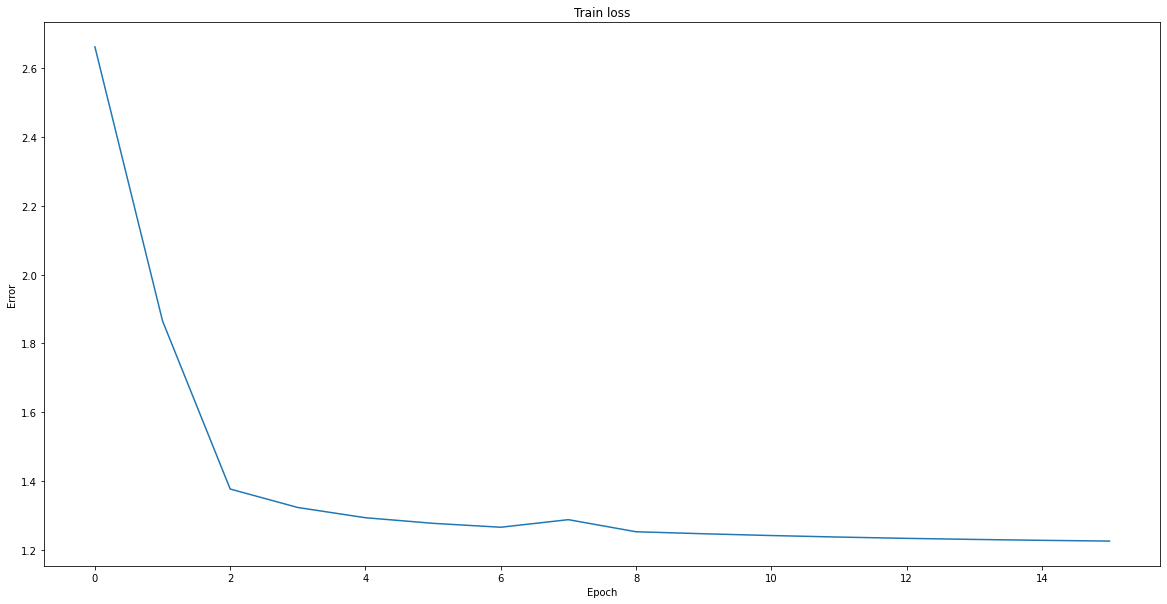

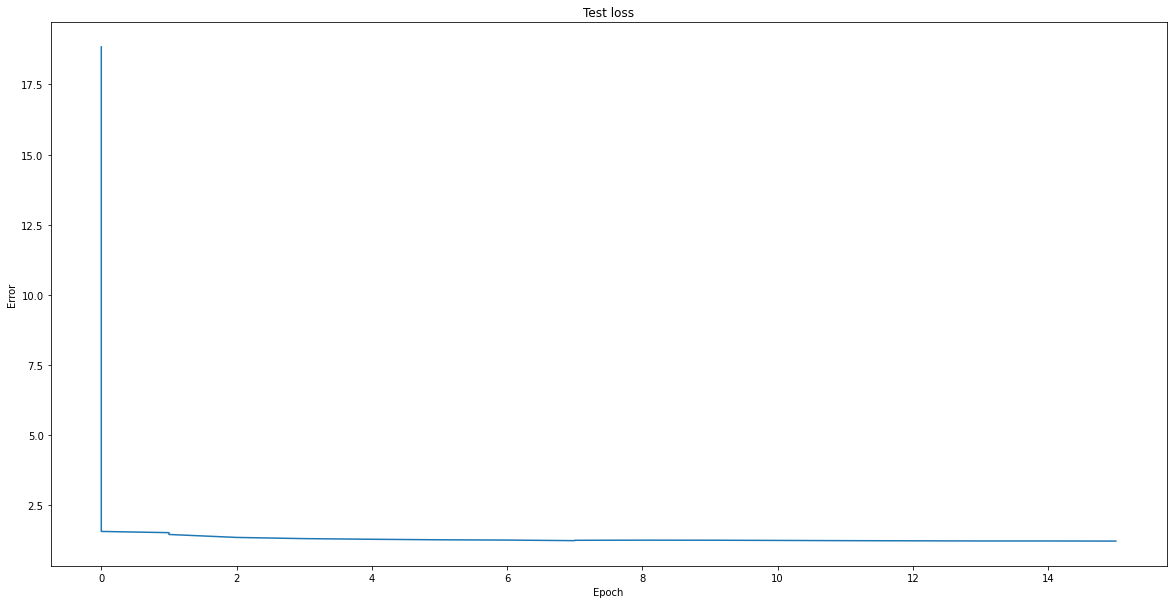

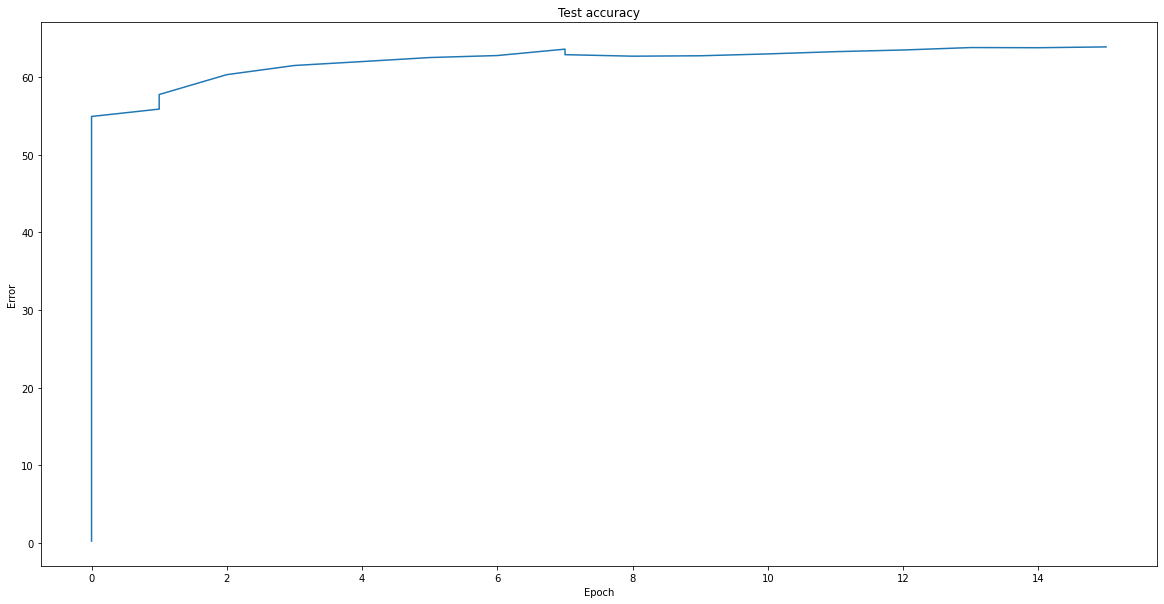

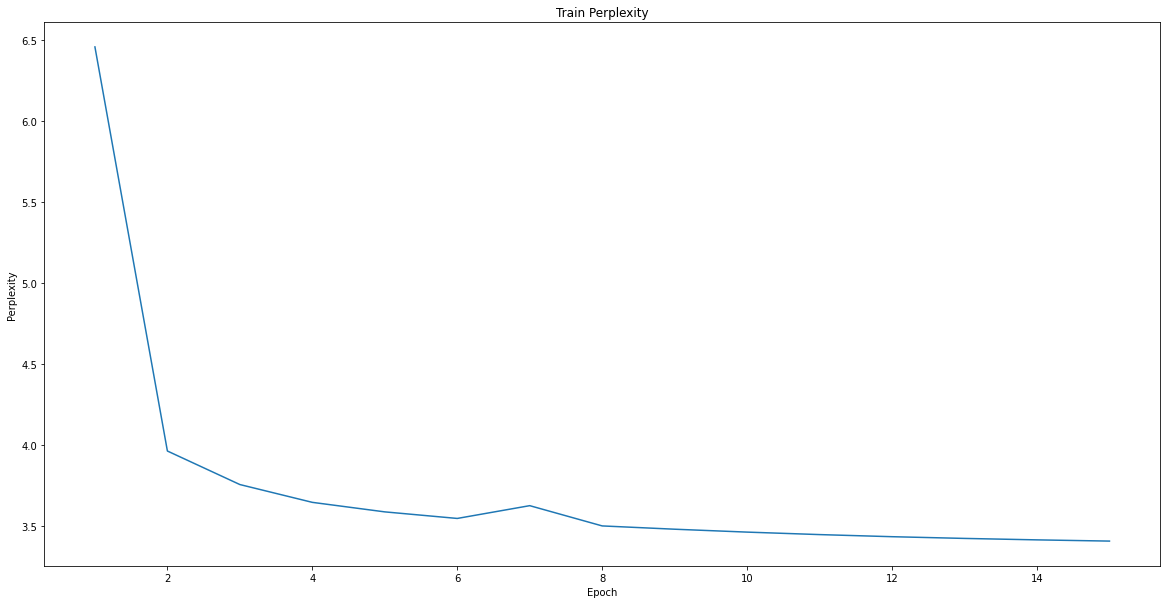

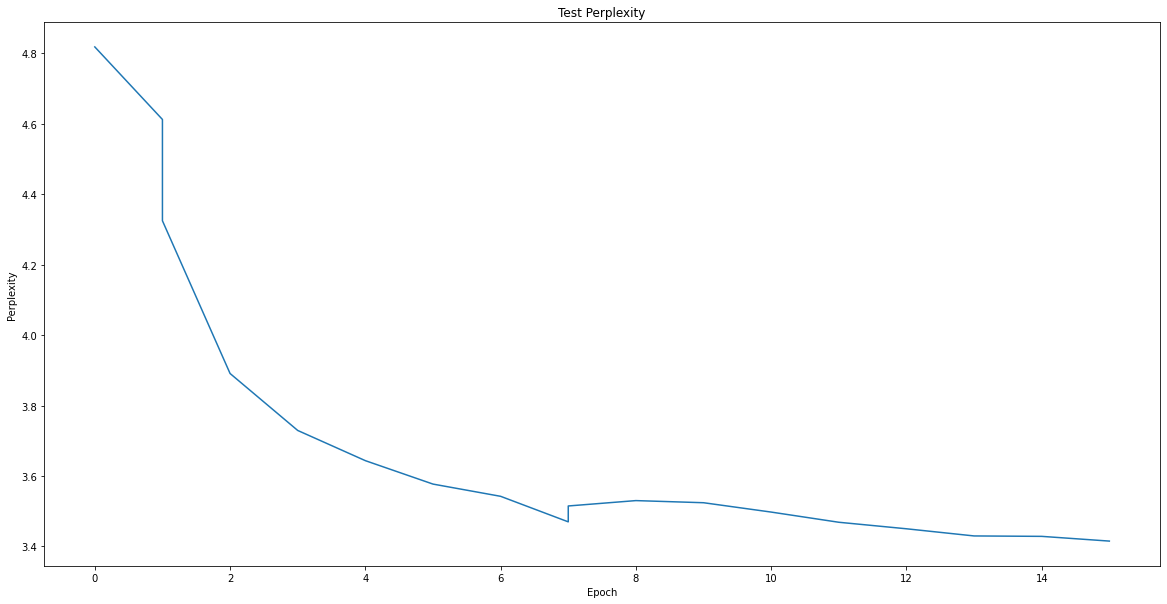

Max test perplexity:  3.4153263958971056


In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 15
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = RomanDataset(DATA_PATH + 'roman_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = RomanDataset(DATA_PATH + 'roman_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = RomanNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_losses)
        pt_util.plot(ep[1:], np.exp(val)[1:], 'Train Perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep[1:], np.exp(val)[1:], 'Test Perplexity', 'Epoch', 'Perplexity')
        print('Max test perplexity: ', min(np.exp(val)))
        return model, vocab, device

final_model, vocab, device = main()

## Evaluate

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'The emperor of the Romans'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 The emperor of the Romans were alleged to the service of the
      prince of the emperor and the emperor of the emperor. The prophet
      of the emperor was seriously and in the service of the emperor
      of the emperor an
generated with sample	 The emperor of the Romans, the attach of Goderato, The adjant
      of Gratonia had been in they disciple to the right of the Casil
      descended by the same in a temper of his privilege and their
      reign. The emperor w
generated with sample	 The emperor of the Romans, and the religious and mourteent
      trouble of imperious in the emperor. The subject of the annal
      of seventies in the series had been in the destitution of the
      emperor monk of the Olin
generated with sample	 The emperor of the Romans, by still prophet, and
      found in the subject of the emperor. His valian expedience, that the
      province of the humanity of the presential person was entired the
      femal of the war for th
generat

# Other thing 2: Train by words

## Preprocess the data

In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    voc2ind = {}
    occ = {}
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    data = data.split()
    for i in range(len(data)):
        data[i] = data[i] + ' '
    for word in data:
        if word in occ:
            occ[word] += 1
        else:
            occ[word] = 1
    for word, num in occ.items():
        if num >= 5:
            voc2ind[word] = len(voc2ind)
    voc2ind['<UNKNOWN> '] = len(voc2ind)
    
    ind2voc = {val: key for key, val in voc2ind.items()}
    eighty = int(len(data) * 0.8)
    train_text = data[0:eighty] # TODO Fill this in
    test_text = data[eighty:] # TODO Fill this in

    print(voc2ind)
    print(len(voc2ind))
    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        words = words.split()
        for i in range(len(words)):
            words[i] = words[i] + ' '
        return torch.LongTensor([self.voc2ind[word] if word in self.voc2ind else self.voc2ind['<UNKNOWN> '] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

{'Harry ': 0, 'Potter ': 1, 'and ': 2, 'the ': 3, "Sorcerer's ": 4, 'Stone ': 5, 'CHAPTER ': 6, 'ONE ': 7, 'THE ': 8, 'WHO ': 9, 'Mr. ': 10, 'Mrs. ': 11, 'Dursley, ': 12, 'of ': 13, 'number ': 14, 'four, ': 15, 'Privet ': 16, 'Drive, ': 17, 'were ': 18, 'proud ': 19, 'to ': 20, 'say ': 21, 'that ': 22, 'they ': 23, 'perfectly ': 24, 'normal, ': 25, 'thank ': 26, 'you ': 27, 'very ': 28, 'much. ': 29, 'They ': 30, 'last ': 31, 'people ': 32, "you'd ": 33, 'expect ': 34, 'be ': 35, 'involved ': 36, 'in ': 37, 'anything ': 38, 'strange ': 39, 'or ': 40, 'because ': 41, 'just ': 42, "didn't ": 43, 'hold ': 44, 'with ': 45, 'such ': 46, 'Dursley ': 47, 'was ': 48, 'a ': 49, 'firm ': 50, 'called ': 51, 'which ': 52, 'made ': 53, 'He ': 54, 'big, ': 55, 'man ': 56, 'hardly ': 57, 'any ': 58, 'neck, ': 59, 'although ': 60, 'he ': 61, 'did ': 62, 'have ': 63, 'large ': 64, 'mustache. ': 65, 'thin ': 66, 'blonde ': 67, 'had ': 68, 'nearly ': 69, 'twice ': 70, 'usual ': 71, 'amount ': 72, 'came '

In [ ]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']
        # for char in data:
        #     if char == ' ' or char == '\n' or char == '\t':
        #         if word != "" and word + " " in dataset['voc2ind'] and dataset['voc2ind'][word + " "] >= 0:
        #             encoded_tokens.append(dataset['voc2ind'][word + " "])
        #         word = ""
        #         pass
        #     word += char

        encoded_tokens = [self.voc2ind[word] if word in self.voc2ind else self.voc2ind['<UNKNOWN> '] for word in self.tokens]
        # encoded_tokens = [self.voc2ind[word + " "] for word in self.tokens]
        # print(encoded_tokens[:1000])

        self.data = torch.LongTensor(
            encoded_tokens[:len(encoded_tokens) - (len(encoded_tokens) % batch_size)]
        ).view(batch_size, -1)
        self.seq_num =  math.ceil((self.data.shape[1] - 1) / sequence_length)


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.data.shape[0] * self.seq_num
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size
        front_idx = (idx // self.batch_size) * self.sequence_length
        data = self.data[batch_idx][front_idx : min(self.data.shape[1], front_idx + self.sequence_length + 1)]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [ ]:
TEMPERATURE = 0.6
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        x = output[0].argmax().long()
        outputs.append(x)
        output, hidden = model.inference(x, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        x = torch.multinomial(output[0],1)[0].long()
        outputs.append(x)
        output, hidden = model.inference(x, hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    for ii in range(sequence_length):
        next_beam = []
        for i in range(len(beam)):
            cur_beam = beam[i]
            sample = torch.multinomial(output[0], beam_width, replacement=True)
            for x in sample:
                x = x.long()
                x_score = cur_beam[1][0][x]
                new_score = cur_beam[3] + torch.log(x_score)
                output, hidden = model.inference(x, cur_beam[2], TEMPERATURE)
                next_beam.append(([
                    cur_beam[0] + [x],
                    output,
                    hidden,
                    new_score
                ]))
        next_beam.sort(reverse=True, key=lambda v: v[3])
        beam = next_beam[:beam_width]
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

## Train

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([14403, 512]) = 29MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([14403, 512]) = 29MB
decoder.bias -> 	torch.Size([14403]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints/030.pt
Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN>

  0%|          | 1/860 [00:00<01:58,  7.27it/s]

Train Epoch: 30 [0/55040 (0%)]	Loss: 5.817821


  5%|▌         | 46/860 [00:02<00:36, 22.48it/s]

Train Epoch: 30 [2560/55040 (5%)]	Loss: 5.889647


 10%|▉         | 85/860 [00:03<00:34, 22.20it/s]

Train Epoch: 30 [5120/55040 (9%)]	Loss: 5.708055


 14%|█▍        | 124/860 [00:05<00:33, 22.30it/s]

Train Epoch: 30 [7680/55040 (14%)]	Loss: 5.970738


 19%|█▉        | 166/860 [00:07<00:31, 22.27it/s]

Train Epoch: 30 [10240/55040 (19%)]	Loss: 5.780576


 24%|██▍       | 205/860 [00:09<00:29, 22.18it/s]

Train Epoch: 30 [12800/55040 (23%)]	Loss: 5.745197


 28%|██▊       | 244/860 [00:11<00:27, 22.48it/s]

Train Epoch: 30 [15360/55040 (28%)]	Loss: 5.840898


 33%|███▎      | 286/860 [00:12<00:25, 22.10it/s]

Train Epoch: 30 [17920/55040 (33%)]	Loss: 5.753954


 38%|███▊      | 325/860 [00:14<00:24, 22.19it/s]

Train Epoch: 30 [20480/55040 (37%)]	Loss: 5.623363


 42%|████▏     | 364/860 [00:16<00:21, 22.73it/s]

Train Epoch: 30 [23040/55040 (42%)]	Loss: 5.877757


 47%|████▋     | 406/860 [00:18<00:20, 22.29it/s]

Train Epoch: 30 [25600/55040 (47%)]	Loss: 5.643286


 52%|█████▏    | 445/860 [00:20<00:18, 22.19it/s]

Train Epoch: 30 [28160/55040 (51%)]	Loss: 5.844991


 56%|█████▋    | 484/860 [00:21<00:16, 22.53it/s]

Train Epoch: 30 [30720/55040 (56%)]	Loss: 5.713542


 61%|██████    | 526/860 [00:23<00:15, 22.24it/s]

Train Epoch: 30 [33280/55040 (60%)]	Loss: 5.767676


 66%|██████▌   | 565/860 [00:25<00:13, 22.00it/s]

Train Epoch: 30 [35840/55040 (65%)]	Loss: 5.700836


 70%|███████   | 604/860 [00:27<00:11, 22.51it/s]

Train Epoch: 30 [38400/55040 (70%)]	Loss: 5.714215


 75%|███████▌  | 646/860 [00:29<00:09, 22.36it/s]

Train Epoch: 30 [40960/55040 (74%)]	Loss: 5.703044


 80%|███████▉  | 685/860 [00:30<00:07, 22.21it/s]

Train Epoch: 30 [43520/55040 (79%)]	Loss: 5.653703


 84%|████████▍ | 724/860 [00:32<00:06, 22.60it/s]

Train Epoch: 30 [46080/55040 (84%)]	Loss: 5.619634


 89%|████████▉ | 766/860 [00:34<00:04, 22.38it/s]

Train Epoch: 30 [48640/55040 (88%)]	Loss: 5.575928


 94%|█████████▎| 805/860 [00:36<00:02, 22.29it/s]

Train Epoch: 30 [51200/55040 (93%)]	Loss: 5.660911


 98%|█████████▊| 844/860 [00:37<00:00, 22.25it/s]

Train Epoch: 30 [53760/55040 (98%)]	Loss: 5.634282


100%|██████████| 860/860 [00:38<00:00, 22.24it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> and and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> don't 


Input	behind whenever they had entered a building ... wherever they had murdered ...

  0%|          | 1/860 [00:00<02:08,  6.66it/s]

Train Epoch: 31 [0/55040 (0%)]	Loss: 5.816733


  5%|▌         | 44/860 [00:02<00:36, 22.61it/s]

Train Epoch: 31 [2560/55040 (5%)]	Loss: 5.718986


 10%|█         | 86/860 [00:03<00:34, 22.42it/s]

Train Epoch: 31 [5120/55040 (9%)]	Loss: 5.586195


 15%|█▍        | 125/860 [00:05<00:32, 22.31it/s]

Train Epoch: 31 [7680/55040 (14%)]	Loss: 5.885903


 19%|█▉        | 164/860 [00:07<00:30, 22.60it/s]

Train Epoch: 31 [10240/55040 (19%)]	Loss: 5.721955


 24%|██▍       | 206/860 [00:09<00:29, 22.47it/s]

Train Epoch: 31 [12800/55040 (23%)]	Loss: 5.699833


 28%|██▊       | 245/860 [00:11<00:27, 22.13it/s]

Train Epoch: 31 [15360/55040 (28%)]	Loss: 5.809499


 33%|███▎      | 284/860 [00:12<00:25, 22.39it/s]

Train Epoch: 31 [17920/55040 (33%)]	Loss: 5.724177


 38%|███▊      | 323/860 [00:14<00:24, 22.30it/s]

Train Epoch: 31 [20480/55040 (37%)]	Loss: 5.593860


 42%|████▏     | 365/860 [00:16<00:22, 22.27it/s]

Train Epoch: 31 [23040/55040 (42%)]	Loss: 5.855329


 47%|████▋     | 404/860 [00:18<00:20, 22.70it/s]

Train Epoch: 31 [25600/55040 (47%)]	Loss: 5.626443


 52%|█████▏    | 446/860 [00:20<00:18, 22.44it/s]

Train Epoch: 31 [28160/55040 (51%)]	Loss: 5.832782


 56%|█████▋    | 485/860 [00:21<00:16, 22.31it/s]

Train Epoch: 31 [30720/55040 (56%)]	Loss: 5.701976


 61%|██████    | 524/860 [00:23<00:14, 22.78it/s]

Train Epoch: 31 [33280/55040 (60%)]	Loss: 5.759003


 66%|██████▌   | 566/860 [00:25<00:13, 22.36it/s]

Train Epoch: 31 [35840/55040 (65%)]	Loss: 5.689710


 70%|███████   | 605/860 [00:27<00:11, 22.35it/s]

Train Epoch: 31 [38400/55040 (70%)]	Loss: 5.705946


 75%|███████▍  | 644/860 [00:28<00:09, 22.69it/s]

Train Epoch: 31 [40960/55040 (74%)]	Loss: 5.695053


 80%|███████▉  | 686/860 [00:30<00:07, 22.27it/s]

Train Epoch: 31 [43520/55040 (79%)]	Loss: 5.647809


 84%|████████▍ | 725/860 [00:32<00:06, 22.26it/s]

Train Epoch: 31 [46080/55040 (84%)]	Loss: 5.613005


 89%|████████▉ | 764/860 [00:34<00:04, 22.52it/s]

Train Epoch: 31 [48640/55040 (88%)]	Loss: 5.570604


 94%|█████████▎| 806/860 [00:36<00:02, 22.43it/s]

Train Epoch: 31 [51200/55040 (93%)]	Loss: 5.656844


 98%|█████████▊| 845/860 [00:37<00:00, 22.48it/s]

Train Epoch: 31 [53760/55040 (98%)]	Loss: 5.629865


100%|██████████| 860/860 [00:38<00:00, 22.26it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> don't 


Input	behind whenever they had entered a building ... wherever they had murdered ..

  0%|          | 1/860 [00:00<02:20,  6.13it/s]

Train Epoch: 32 [0/55040 (0%)]	Loss: 5.816619


  5%|▌         | 45/860 [00:02<00:36, 22.42it/s]

Train Epoch: 32 [2560/55040 (5%)]	Loss: 5.714776


 10%|▉         | 84/860 [00:03<00:34, 22.42it/s]

Train Epoch: 32 [5120/55040 (9%)]	Loss: 5.581921


 15%|█▍        | 126/860 [00:05<00:32, 22.36it/s]

Train Epoch: 32 [7680/55040 (14%)]	Loss: 5.881998


 19%|█▉        | 165/860 [00:07<00:31, 22.38it/s]

Train Epoch: 32 [10240/55040 (19%)]	Loss: 5.719510


 24%|██▎       | 204/860 [00:09<00:29, 22.22it/s]

Train Epoch: 32 [12800/55040 (23%)]	Loss: 5.696509


 29%|██▊       | 246/860 [00:11<00:27, 22.32it/s]

Train Epoch: 32 [15360/55040 (28%)]	Loss: 5.806851


 33%|███▎      | 285/860 [00:12<00:25, 22.45it/s]

Train Epoch: 32 [17920/55040 (33%)]	Loss: 5.721154


 38%|███▊      | 324/860 [00:14<00:23, 22.58it/s]

Train Epoch: 32 [20480/55040 (37%)]	Loss: 5.591112


 43%|████▎     | 366/860 [00:16<00:22, 22.38it/s]

Train Epoch: 32 [23040/55040 (42%)]	Loss: 5.854456


 47%|████▋     | 405/860 [00:18<00:20, 22.55it/s]

Train Epoch: 32 [25600/55040 (47%)]	Loss: 5.625802


 52%|█████▏    | 444/860 [00:19<00:18, 22.52it/s]

Train Epoch: 32 [28160/55040 (51%)]	Loss: 5.832180


 57%|█████▋    | 486/860 [00:21<00:16, 22.47it/s]

Train Epoch: 32 [30720/55040 (56%)]	Loss: 5.701154


 61%|██████    | 525/860 [00:23<00:15, 22.28it/s]

Train Epoch: 32 [33280/55040 (60%)]	Loss: 5.757810


 66%|██████▌   | 564/860 [00:25<00:13, 22.36it/s]

Train Epoch: 32 [35840/55040 (65%)]	Loss: 5.687372


 70%|███████   | 606/860 [00:27<00:11, 22.29it/s]

Train Epoch: 32 [38400/55040 (70%)]	Loss: 5.705092


 75%|███████▌  | 645/860 [00:28<00:09, 22.47it/s]

Train Epoch: 32 [40960/55040 (74%)]	Loss: 5.693757


 80%|███████▉  | 684/860 [00:30<00:07, 22.67it/s]

Train Epoch: 32 [43520/55040 (79%)]	Loss: 5.646972


 84%|████████▍ | 726/860 [00:32<00:05, 22.53it/s]

Train Epoch: 32 [46080/55040 (84%)]	Loss: 5.611753


 89%|████████▉ | 765/860 [00:34<00:04, 22.48it/s]

Train Epoch: 32 [48640/55040 (88%)]	Loss: 5.568812


 93%|█████████▎| 804/860 [00:36<00:02, 22.57it/s]

Train Epoch: 32 [51200/55040 (93%)]	Loss: 5.654882


 98%|█████████▊| 846/860 [00:37<00:00, 22.39it/s]

Train Epoch: 32 [53760/55040 (98%)]	Loss: 5.627914


100%|██████████| 860/860 [00:38<00:00, 22.30it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> don't 


Input	behind whenever they had entered a building ... wherever they had murdered ..

  0%|          | 1/860 [00:00<02:07,  6.75it/s]

Train Epoch: 33 [0/55040 (0%)]	Loss: 5.816676


  5%|▌         | 44/860 [00:02<00:36, 22.50it/s]

Train Epoch: 33 [2560/55040 (5%)]	Loss: 5.713963


 10%|█         | 86/860 [00:03<00:34, 22.40it/s]

Train Epoch: 33 [5120/55040 (9%)]	Loss: 5.580448


 15%|█▍        | 125/860 [00:05<00:33, 22.16it/s]

Train Epoch: 33 [7680/55040 (14%)]	Loss: 5.880350


 19%|█▉        | 164/860 [00:07<00:30, 22.60it/s]

Train Epoch: 33 [10240/55040 (19%)]	Loss: 5.719110


 24%|██▍       | 206/860 [00:09<00:29, 22.21it/s]

Train Epoch: 33 [12800/55040 (23%)]	Loss: 5.695107


 28%|██▊       | 245/860 [00:11<00:27, 22.48it/s]

Train Epoch: 33 [15360/55040 (28%)]	Loss: 5.806173


 33%|███▎      | 284/860 [00:12<00:25, 22.51it/s]

Train Epoch: 33 [17920/55040 (33%)]	Loss: 5.719040


 38%|███▊      | 326/860 [00:14<00:23, 22.31it/s]

Train Epoch: 33 [20480/55040 (37%)]	Loss: 5.592131


 42%|████▏     | 365/860 [00:16<00:22, 22.21it/s]

Train Epoch: 33 [23040/55040 (42%)]	Loss: 5.853534


 47%|████▋     | 404/860 [00:18<00:20, 22.55it/s]

Train Epoch: 33 [25600/55040 (47%)]	Loss: 5.624837


 52%|█████▏    | 446/860 [00:20<00:18, 22.30it/s]

Train Epoch: 33 [28160/55040 (51%)]	Loss: 5.830917


 56%|█████▋    | 485/860 [00:21<00:16, 22.48it/s]

Train Epoch: 33 [30720/55040 (56%)]	Loss: 5.700243


 61%|██████    | 524/860 [00:23<00:14, 22.69it/s]

Train Epoch: 33 [33280/55040 (60%)]	Loss: 5.756151


 66%|██████▌   | 566/860 [00:25<00:13, 22.48it/s]

Train Epoch: 33 [35840/55040 (65%)]	Loss: 5.687960


 70%|███████   | 605/860 [00:27<00:11, 22.47it/s]

Train Epoch: 33 [38400/55040 (70%)]	Loss: 5.703589


 75%|███████▍  | 644/860 [00:28<00:09, 22.67it/s]

Train Epoch: 33 [40960/55040 (74%)]	Loss: 5.692245


 80%|███████▉  | 686/860 [00:30<00:07, 22.34it/s]

Train Epoch: 33 [43520/55040 (79%)]	Loss: 5.646672


 84%|████████▍ | 725/860 [00:32<00:06, 22.47it/s]

Train Epoch: 33 [46080/55040 (84%)]	Loss: 5.610439


 89%|████████▉ | 764/860 [00:34<00:04, 22.61it/s]

Train Epoch: 33 [48640/55040 (88%)]	Loss: 5.567787


 94%|█████████▎| 806/860 [00:36<00:02, 22.50it/s]

Train Epoch: 33 [51200/55040 (93%)]	Loss: 5.655094


 98%|█████████▊| 845/860 [00:37<00:00, 22.37it/s]

Train Epoch: 33 [53760/55040 (98%)]	Loss: 5.627519


100%|██████████| 860/860 [00:38<00:00, 22.29it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> don't 


Input	behind whenever they had entered a building ... wherever they had murdered ..

  0%|          | 1/860 [00:00<02:04,  6.89it/s]

Train Epoch: 34 [0/55040 (0%)]	Loss: 5.817328


  5%|▌         | 45/860 [00:02<00:36, 22.36it/s]

Train Epoch: 34 [2560/55040 (5%)]	Loss: 5.712906


 10%|▉         | 84/860 [00:03<00:34, 22.72it/s]

Train Epoch: 34 [5120/55040 (9%)]	Loss: 5.579524


 15%|█▍        | 126/860 [00:05<00:32, 22.31it/s]

Train Epoch: 34 [7680/55040 (14%)]	Loss: 5.880266


 19%|█▉        | 165/860 [00:07<00:30, 22.48it/s]

Train Epoch: 34 [10240/55040 (19%)]	Loss: 5.718386


 24%|██▎       | 204/860 [00:09<00:28, 22.81it/s]

Train Epoch: 34 [12800/55040 (23%)]	Loss: 5.693972


 29%|██▊       | 246/860 [00:11<00:27, 22.32it/s]

Train Epoch: 34 [15360/55040 (28%)]	Loss: 5.805186


 33%|███▎      | 285/860 [00:12<00:25, 22.39it/s]

Train Epoch: 34 [17920/55040 (33%)]	Loss: 5.719169


 38%|███▊      | 324/860 [00:14<00:23, 22.59it/s]

Train Epoch: 34 [20480/55040 (37%)]	Loss: 5.589444


 43%|████▎     | 366/860 [00:16<00:21, 22.55it/s]

Train Epoch: 34 [23040/55040 (42%)]	Loss: 5.852116


 47%|████▋     | 405/860 [00:18<00:20, 22.54it/s]

Train Epoch: 34 [25600/55040 (47%)]	Loss: 5.623487


 52%|█████▏    | 444/860 [00:19<00:18, 22.75it/s]

Train Epoch: 34 [28160/55040 (51%)]	Loss: 5.831039


 57%|█████▋    | 486/860 [00:21<00:16, 22.43it/s]

Train Epoch: 34 [30720/55040 (56%)]	Loss: 5.699008


 61%|██████    | 525/860 [00:23<00:14, 22.44it/s]

Train Epoch: 34 [33280/55040 (60%)]	Loss: 5.754933


 66%|██████▌   | 564/860 [00:25<00:13, 22.61it/s]

Train Epoch: 34 [35840/55040 (65%)]	Loss: 5.687203


 70%|███████   | 606/860 [00:27<00:11, 22.48it/s]

Train Epoch: 34 [38400/55040 (70%)]	Loss: 5.702859


 75%|███████▌  | 645/860 [00:28<00:09, 22.31it/s]

Train Epoch: 34 [40960/55040 (74%)]	Loss: 5.692869


 80%|███████▉  | 684/860 [00:30<00:07, 22.72it/s]

Train Epoch: 34 [43520/55040 (79%)]	Loss: 5.646358


 84%|████████▍ | 726/860 [00:32<00:05, 22.56it/s]

Train Epoch: 34 [46080/55040 (84%)]	Loss: 5.609723


 89%|████████▉ | 765/860 [00:34<00:04, 22.32it/s]

Train Epoch: 34 [48640/55040 (88%)]	Loss: 5.567026


 93%|█████████▎| 804/860 [00:35<00:02, 22.75it/s]

Train Epoch: 34 [51200/55040 (93%)]	Loss: 5.653891


 98%|█████████▊| 846/860 [00:37<00:00, 22.36it/s]

Train Epoch: 34 [53760/55040 (98%)]	Loss: 5.626430


100%|██████████| 860/860 [00:38<00:00, 22.35it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> don't 


Input	behind whenever they had entered a building ... wherever they had murdered ..

  0%|          | 1/860 [00:00<02:03,  6.96it/s]

Train Epoch: 35 [0/55040 (0%)]	Loss: 5.816958


  5%|▌         | 45/860 [00:02<00:36, 22.27it/s]

Train Epoch: 35 [2560/55040 (5%)]	Loss: 5.712907


 10%|▉         | 84/860 [00:03<00:33, 22.89it/s]

Train Epoch: 35 [5120/55040 (9%)]	Loss: 5.578653


 15%|█▍        | 126/860 [00:05<00:32, 22.42it/s]

Train Epoch: 35 [7680/55040 (14%)]	Loss: 5.878739


 19%|█▉        | 165/860 [00:07<00:31, 22.29it/s]

Train Epoch: 35 [10240/55040 (19%)]	Loss: 5.717039


 24%|██▎       | 204/860 [00:09<00:29, 22.48it/s]

Train Epoch: 35 [12800/55040 (23%)]	Loss: 5.694285


 29%|██▊       | 246/860 [00:11<00:27, 22.25it/s]

Train Epoch: 35 [15360/55040 (28%)]	Loss: 5.805783


 33%|███▎      | 285/860 [00:12<00:25, 22.32it/s]

Train Epoch: 35 [17920/55040 (33%)]	Loss: 5.718499


 38%|███▊      | 324/860 [00:14<00:23, 22.60it/s]

Train Epoch: 35 [20480/55040 (37%)]	Loss: 5.589845


 42%|████▏     | 363/860 [00:16<00:22, 22.31it/s]

Train Epoch: 35 [23040/55040 (42%)]	Loss: 5.852523


 47%|████▋     | 405/860 [00:18<00:20, 22.22it/s]

Train Epoch: 35 [25600/55040 (47%)]	Loss: 5.622611


 52%|█████▏    | 444/860 [00:19<00:18, 22.48it/s]

Train Epoch: 35 [28160/55040 (51%)]	Loss: 5.829970


 57%|█████▋    | 486/860 [00:21<00:16, 22.29it/s]

Train Epoch: 35 [30720/55040 (56%)]	Loss: 5.698625


 61%|██████    | 525/860 [00:23<00:14, 22.37it/s]

Train Epoch: 35 [33280/55040 (60%)]	Loss: 5.755501


 66%|██████▌   | 564/860 [00:25<00:13, 22.44it/s]

Train Epoch: 35 [35840/55040 (65%)]	Loss: 5.687419


 70%|███████   | 606/860 [00:27<00:11, 22.43it/s]

Train Epoch: 35 [38400/55040 (70%)]	Loss: 5.702037


 75%|███████▌  | 645/860 [00:28<00:09, 22.25it/s]

Train Epoch: 35 [40960/55040 (74%)]	Loss: 5.691630


 80%|███████▉  | 684/860 [00:30<00:07, 22.43it/s]

Train Epoch: 35 [43520/55040 (79%)]	Loss: 5.645915


 84%|████████▍ | 726/860 [00:32<00:05, 22.48it/s]

Train Epoch: 35 [46080/55040 (84%)]	Loss: 5.609333


 89%|████████▉ | 765/860 [00:34<00:04, 22.50it/s]

Train Epoch: 35 [48640/55040 (88%)]	Loss: 5.566263


 93%|█████████▎| 804/860 [00:35<00:02, 22.70it/s]

Train Epoch: 35 [51200/55040 (93%)]	Loss: 5.654116


 98%|█████████▊| 846/860 [00:37<00:00, 22.52it/s]

Train Epoch: 35 [53760/55040 (98%)]	Loss: 5.626673


100%|██████████| 860/860 [00:38<00:00, 22.33it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> don't 


Input	behind whenever they had entered a building ... wherever they had murdered ..

  0%|          | 1/860 [00:00<02:08,  6.70it/s]

Train Epoch: 36 [0/55040 (0%)]	Loss: 5.816491


  5%|▌         | 44/860 [00:02<00:35, 22.79it/s]

Train Epoch: 36 [2560/55040 (5%)]	Loss: 5.712856


 10%|█         | 86/860 [00:03<00:34, 22.53it/s]

Train Epoch: 36 [5120/55040 (9%)]	Loss: 5.578959


 15%|█▍        | 125/860 [00:05<00:32, 22.53it/s]

Train Epoch: 36 [7680/55040 (14%)]	Loss: 5.879175


 19%|█▉        | 164/860 [00:07<00:30, 22.71it/s]

Train Epoch: 36 [10240/55040 (19%)]	Loss: 5.717297


 24%|██▍       | 206/860 [00:09<00:28, 22.56it/s]

Train Epoch: 36 [12800/55040 (23%)]	Loss: 5.692874


 28%|██▊       | 245/860 [00:11<00:27, 22.27it/s]

Train Epoch: 36 [15360/55040 (28%)]	Loss: 5.805832


 33%|███▎      | 284/860 [00:12<00:25, 22.64it/s]

Train Epoch: 36 [17920/55040 (33%)]	Loss: 5.717916


 38%|███▊      | 326/860 [00:14<00:23, 22.37it/s]

Train Epoch: 36 [20480/55040 (37%)]	Loss: 5.589956


 42%|████▏     | 365/860 [00:16<00:21, 22.52it/s]

Train Epoch: 36 [23040/55040 (42%)]	Loss: 5.851788


 47%|████▋     | 404/860 [00:18<00:20, 22.70it/s]

Train Epoch: 36 [25600/55040 (47%)]	Loss: 5.622630


 52%|█████▏    | 446/860 [00:20<00:18, 22.32it/s]

Train Epoch: 36 [28160/55040 (51%)]	Loss: 5.829229


 56%|█████▋    | 485/860 [00:21<00:16, 22.26it/s]

Train Epoch: 36 [30720/55040 (56%)]	Loss: 5.697849


 61%|██████    | 524/860 [00:23<00:14, 22.53it/s]

Train Epoch: 36 [33280/55040 (60%)]	Loss: 5.755243


 66%|██████▌   | 566/860 [00:25<00:13, 22.53it/s]

Train Epoch: 36 [35840/55040 (65%)]	Loss: 5.687022


 70%|███████   | 605/860 [00:27<00:11, 22.33it/s]

Train Epoch: 36 [38400/55040 (70%)]	Loss: 5.702844


 75%|███████▍  | 644/860 [00:28<00:09, 22.59it/s]

Train Epoch: 36 [40960/55040 (74%)]	Loss: 5.692353


 80%|███████▉  | 686/860 [00:30<00:07, 22.51it/s]

Train Epoch: 36 [43520/55040 (79%)]	Loss: 5.645709


 84%|████████▍ | 725/860 [00:32<00:06, 22.33it/s]

Train Epoch: 36 [46080/55040 (84%)]	Loss: 5.608780


 89%|████████▉ | 764/860 [00:34<00:04, 22.65it/s]

Train Epoch: 36 [48640/55040 (88%)]	Loss: 5.566040


 94%|█████████▎| 806/860 [00:36<00:02, 22.48it/s]

Train Epoch: 36 [51200/55040 (93%)]	Loss: 5.653631


 98%|█████████▊| 845/860 [00:37<00:00, 22.36it/s]

Train Epoch: 36 [53760/55040 (98%)]	Loss: 5.625845


100%|██████████| 860/860 [00:38<00:00, 22.33it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> don't 


Input	behind whenever they had entered a building ... wherever they had murdered ..

  0%|          | 1/860 [00:00<02:07,  6.75it/s]

Train Epoch: 37 [0/55040 (0%)]	Loss: 5.816582


  5%|▌         | 45/860 [00:02<00:36, 22.34it/s]

Train Epoch: 37 [2560/55040 (5%)]	Loss: 5.711653


 10%|▉         | 84/860 [00:03<00:34, 22.79it/s]

Train Epoch: 37 [5120/55040 (9%)]	Loss: 5.578470


 15%|█▍        | 126/860 [00:05<00:32, 22.46it/s]

Train Epoch: 37 [7680/55040 (14%)]	Loss: 5.878072


 19%|█▉        | 165/860 [00:07<00:31, 22.31it/s]

Train Epoch: 37 [10240/55040 (19%)]	Loss: 5.716953


 24%|██▎       | 204/860 [00:09<00:29, 22.61it/s]

Train Epoch: 37 [12800/55040 (23%)]	Loss: 5.691608


 29%|██▊       | 246/860 [00:11<00:27, 22.50it/s]

Train Epoch: 37 [15360/55040 (28%)]	Loss: 5.805304


 33%|███▎      | 285/860 [00:12<00:25, 22.31it/s]

Train Epoch: 37 [17920/55040 (33%)]	Loss: 5.718751


 38%|███▊      | 324/860 [00:14<00:23, 22.77it/s]

Train Epoch: 37 [20480/55040 (37%)]	Loss: 5.589237


 43%|████▎     | 366/860 [00:16<00:22, 22.38it/s]

Train Epoch: 37 [23040/55040 (42%)]	Loss: 5.851871


 47%|████▋     | 405/860 [00:18<00:20, 22.41it/s]

Train Epoch: 37 [25600/55040 (47%)]	Loss: 5.622660


 52%|█████▏    | 444/860 [00:19<00:18, 22.59it/s]

Train Epoch: 37 [28160/55040 (51%)]	Loss: 5.830688


 57%|█████▋    | 486/860 [00:21<00:16, 22.37it/s]

Train Epoch: 37 [30720/55040 (56%)]	Loss: 5.697899


 61%|██████    | 525/860 [00:23<00:14, 22.52it/s]

Train Epoch: 37 [33280/55040 (60%)]	Loss: 5.755384


 66%|██████▌   | 564/860 [00:25<00:13, 22.64it/s]

Train Epoch: 37 [35840/55040 (65%)]	Loss: 5.686985


 70%|███████   | 606/860 [00:27<00:11, 22.50it/s]

Train Epoch: 37 [38400/55040 (70%)]	Loss: 5.702393


 75%|███████▌  | 645/860 [00:28<00:09, 22.51it/s]

Train Epoch: 37 [40960/55040 (74%)]	Loss: 5.691331


 80%|███████▉  | 684/860 [00:30<00:07, 22.50it/s]

Train Epoch: 37 [43520/55040 (79%)]	Loss: 5.644836


 84%|████████▍ | 723/860 [00:32<00:06, 22.04it/s]

Train Epoch: 37 [46080/55040 (84%)]	Loss: 5.607897


 89%|████████▉ | 765/860 [00:34<00:04, 22.43it/s]

Train Epoch: 37 [48640/55040 (88%)]	Loss: 5.565746


 93%|█████████▎| 804/860 [00:35<00:02, 22.74it/s]

Train Epoch: 37 [51200/55040 (93%)]	Loss: 5.652950


 98%|█████████▊| 846/860 [00:37<00:00, 22.54it/s]

Train Epoch: 37 [53760/55040 (98%)]	Loss: 5.626489


100%|██████████| 860/860 [00:38<00:00, 22.34it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> don't 


Input	behind whenever they had entered a building ... wherever they had murdered ..

  0%|          | 1/860 [00:00<02:10,  6.59it/s]

Train Epoch: 38 [0/55040 (0%)]	Loss: 5.817185


  5%|▌         | 45/860 [00:02<00:36, 22.29it/s]

Train Epoch: 38 [2560/55040 (5%)]	Loss: 5.711924


 10%|▉         | 84/860 [00:03<00:33, 22.85it/s]

Train Epoch: 38 [5120/55040 (9%)]	Loss: 5.576305


 15%|█▍        | 126/860 [00:05<00:32, 22.47it/s]

Train Epoch: 38 [7680/55040 (14%)]	Loss: 5.877095


 19%|█▉        | 165/860 [00:07<00:31, 22.36it/s]

Train Epoch: 38 [10240/55040 (19%)]	Loss: 5.716911


 24%|██▎       | 204/860 [00:09<00:29, 22.57it/s]

Train Epoch: 38 [12800/55040 (23%)]	Loss: 5.692060


 29%|██▊       | 246/860 [00:11<00:27, 22.59it/s]

Train Epoch: 38 [15360/55040 (28%)]	Loss: 5.804893


 33%|███▎      | 285/860 [00:12<00:25, 22.26it/s]

Train Epoch: 38 [17920/55040 (33%)]	Loss: 5.718460


 38%|███▊      | 324/860 [00:14<00:23, 22.58it/s]

Train Epoch: 38 [20480/55040 (37%)]	Loss: 5.587860


 43%|████▎     | 366/860 [00:16<00:22, 22.24it/s]

Train Epoch: 38 [23040/55040 (42%)]	Loss: 5.851479


 47%|████▋     | 405/860 [00:18<00:20, 22.48it/s]

Train Epoch: 38 [25600/55040 (47%)]	Loss: 5.622150


 52%|█████▏    | 444/860 [00:19<00:18, 22.52it/s]

Train Epoch: 38 [28160/55040 (51%)]	Loss: 5.830348


 57%|█████▋    | 486/860 [00:21<00:16, 22.23it/s]

Train Epoch: 38 [30720/55040 (56%)]	Loss: 5.697715


 61%|██████    | 525/860 [00:23<00:15, 22.25it/s]

Train Epoch: 38 [33280/55040 (60%)]	Loss: 5.753950


 66%|██████▌   | 564/860 [00:25<00:13, 22.69it/s]

Train Epoch: 38 [35840/55040 (65%)]	Loss: 5.686473


 70%|███████   | 606/860 [00:27<00:11, 22.47it/s]

Train Epoch: 38 [38400/55040 (70%)]	Loss: 5.701749


 75%|███████▌  | 645/860 [00:28<00:09, 22.46it/s]

Train Epoch: 38 [40960/55040 (74%)]	Loss: 5.691611


 80%|███████▉  | 684/860 [00:30<00:07, 22.27it/s]

Train Epoch: 38 [43520/55040 (79%)]	Loss: 5.645441


 84%|████████▍ | 726/860 [00:32<00:05, 22.36it/s]

Train Epoch: 38 [46080/55040 (84%)]	Loss: 5.607847


 89%|████████▉ | 765/860 [00:34<00:04, 22.43it/s]

Train Epoch: 38 [48640/55040 (88%)]	Loss: 5.565593


 93%|█████████▎| 804/860 [00:36<00:02, 22.47it/s]

Train Epoch: 38 [51200/55040 (93%)]	Loss: 5.653477


 98%|█████████▊| 846/860 [00:37<00:00, 22.44it/s]

Train Epoch: 38 [53760/55040 (98%)]	Loss: 5.626348


100%|██████████| 860/860 [00:38<00:00, 22.28it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> think 


Input	behind whenever they had entered a building ... wherever they had murdered ..

  0%|          | 1/860 [00:00<02:11,  6.53it/s]

Train Epoch: 39 [0/55040 (0%)]	Loss: 5.815597


  5%|▌         | 45/860 [00:02<00:36, 22.43it/s]

Train Epoch: 39 [2560/55040 (5%)]	Loss: 5.710308


 10%|▉         | 84/860 [00:03<00:34, 22.57it/s]

Train Epoch: 39 [5120/55040 (9%)]	Loss: 5.577258


 15%|█▍        | 126/860 [00:05<00:32, 22.44it/s]

Train Epoch: 39 [7680/55040 (14%)]	Loss: 5.878057


 19%|█▉        | 165/860 [00:07<00:31, 22.29it/s]

Train Epoch: 39 [10240/55040 (19%)]	Loss: 5.717262


 24%|██▎       | 204/860 [00:09<00:29, 22.53it/s]

Train Epoch: 39 [12800/55040 (23%)]	Loss: 5.691822


 29%|██▊       | 246/860 [00:11<00:27, 22.36it/s]

Train Epoch: 39 [15360/55040 (28%)]	Loss: 5.804676


 33%|███▎      | 285/860 [00:12<00:25, 22.42it/s]

Train Epoch: 39 [17920/55040 (33%)]	Loss: 5.718587


 38%|███▊      | 324/860 [00:14<00:23, 22.57it/s]

Train Epoch: 39 [20480/55040 (37%)]	Loss: 5.588555


 43%|████▎     | 366/860 [00:16<00:22, 22.34it/s]

Train Epoch: 39 [23040/55040 (42%)]	Loss: 5.851713


 47%|████▋     | 405/860 [00:18<00:20, 22.34it/s]

Train Epoch: 39 [25600/55040 (47%)]	Loss: 5.623152


 52%|█████▏    | 444/860 [00:19<00:18, 22.62it/s]

Train Epoch: 39 [28160/55040 (51%)]	Loss: 5.830793


 57%|█████▋    | 486/860 [00:21<00:16, 22.43it/s]

Train Epoch: 39 [30720/55040 (56%)]	Loss: 5.697862


 61%|██████    | 525/860 [00:23<00:14, 22.44it/s]

Train Epoch: 39 [33280/55040 (60%)]	Loss: 5.753774


 66%|██████▌   | 564/860 [00:25<00:13, 22.22it/s]

Train Epoch: 39 [35840/55040 (65%)]	Loss: 5.686088


 70%|███████   | 606/860 [00:27<00:11, 22.32it/s]

Train Epoch: 39 [38400/55040 (70%)]	Loss: 5.701942


 75%|███████▌  | 645/860 [00:28<00:09, 22.32it/s]

Train Epoch: 39 [40960/55040 (74%)]	Loss: 5.689977


 80%|███████▉  | 684/860 [00:30<00:07, 22.68it/s]

Train Epoch: 39 [43520/55040 (79%)]	Loss: 5.644893


 84%|████████▍ | 726/860 [00:32<00:05, 22.47it/s]

Train Epoch: 39 [46080/55040 (84%)]	Loss: 5.606493


 89%|████████▉ | 765/860 [00:34<00:04, 22.20it/s]

Train Epoch: 39 [48640/55040 (88%)]	Loss: 5.565317


 93%|█████████▎| 804/860 [00:36<00:02, 22.60it/s]

Train Epoch: 39 [51200/55040 (93%)]	Loss: 5.652137


 98%|█████████▊| 846/860 [00:37<00:00, 22.51it/s]

Train Epoch: 39 [53760/55040 (98%)]	Loss: 5.626235


100%|██████████| 860/860 [00:38<00:00, 22.30it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> think 


Input	behind whenever they had entered a building ... wherever they had murdered ..

  0%|          | 1/860 [00:00<02:21,  6.07it/s]

Train Epoch: 40 [0/55040 (0%)]	Loss: 5.815986


  5%|▌         | 45/860 [00:02<00:36, 22.51it/s]

Train Epoch: 40 [2560/55040 (5%)]	Loss: 5.710495


 10%|▉         | 84/860 [00:03<00:34, 22.64it/s]

Train Epoch: 40 [5120/55040 (9%)]	Loss: 5.577298


 15%|█▍        | 126/860 [00:05<00:32, 22.54it/s]

Train Epoch: 40 [7680/55040 (14%)]	Loss: 5.877507


 19%|█▉        | 165/860 [00:07<00:31, 22.39it/s]

Train Epoch: 40 [10240/55040 (19%)]	Loss: 5.716401


 24%|██▎       | 204/860 [00:09<00:29, 22.34it/s]

Train Epoch: 40 [12800/55040 (23%)]	Loss: 5.690510


 29%|██▊       | 246/860 [00:11<00:27, 22.25it/s]

Train Epoch: 40 [15360/55040 (28%)]	Loss: 5.804933


 33%|███▎      | 285/860 [00:12<00:25, 22.48it/s]

Train Epoch: 40 [17920/55040 (33%)]	Loss: 5.718910


 38%|███▊      | 324/860 [00:14<00:23, 22.59it/s]

Train Epoch: 40 [20480/55040 (37%)]	Loss: 5.588398


 43%|████▎     | 366/860 [00:16<00:22, 22.22it/s]

Train Epoch: 40 [23040/55040 (42%)]	Loss: 5.852011


 47%|████▋     | 405/860 [00:18<00:20, 22.43it/s]

Train Epoch: 40 [25600/55040 (47%)]	Loss: 5.622913


 52%|█████▏    | 444/860 [00:19<00:18, 22.67it/s]

Train Epoch: 40 [28160/55040 (51%)]	Loss: 5.830616


 57%|█████▋    | 486/860 [00:21<00:16, 22.31it/s]

Train Epoch: 40 [30720/55040 (56%)]	Loss: 5.697007


 61%|██████    | 525/860 [00:23<00:14, 22.58it/s]

Train Epoch: 40 [33280/55040 (60%)]	Loss: 5.752956


 66%|██████▌   | 564/860 [00:25<00:13, 22.16it/s]

Train Epoch: 40 [35840/55040 (65%)]	Loss: 5.686142


 70%|███████   | 606/860 [00:27<00:11, 22.45it/s]

Train Epoch: 40 [38400/55040 (70%)]	Loss: 5.702282


 75%|███████▌  | 645/860 [00:28<00:09, 22.54it/s]

Train Epoch: 40 [40960/55040 (74%)]	Loss: 5.690812


 80%|███████▉  | 684/860 [00:30<00:07, 22.53it/s]

Train Epoch: 40 [43520/55040 (79%)]	Loss: 5.644987


 84%|████████▍ | 726/860 [00:32<00:05, 22.39it/s]

Train Epoch: 40 [46080/55040 (84%)]	Loss: 5.607801


 89%|████████▉ | 765/860 [00:34<00:04, 22.54it/s]

Train Epoch: 40 [48640/55040 (88%)]	Loss: 5.565437


 93%|█████████▎| 804/860 [00:36<00:02, 22.59it/s]

Train Epoch: 40 [51200/55040 (93%)]	Loss: 5.652809


 98%|█████████▊| 846/860 [00:37<00:00, 22.51it/s]

Train Epoch: 40 [53760/55040 (98%)]	Loss: 5.626676


100%|██████████| 860/860 [00:38<00:00, 22.31it/s]


Input	him more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw 
GT	more Inferi creeping towards him around the sides of <UNKNOWN> but he blinked and saw that 
pred	to <UNKNOWN> than and the and the <UNKNOWN> of the <UNKNOWN> he was his Ron the 


Input	all he could think was that he must somehow get Dumbledore quickly to the hospital wing. 
GT	he could think was that he must somehow get Dumbledore quickly to the hospital wing. 'We 
pred	the had not he <UNKNOWN> he was have <UNKNOWN> to to to the <UNKNOWN> <UNKNOWN> <UNKNOWN> 


Input	'I saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I 
GT	saw you Apparate as I was pulling my bedroom <UNKNOWN> Thank goodness, thank goodness, I couldn't 
pred	<UNKNOWN> the <UNKNOWN> <UNKNOWN> though <UNKNOWN> <UNKNOWN> the <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> don't 


Input	behind whenever they had entered a building ... wherever they had murdered ..

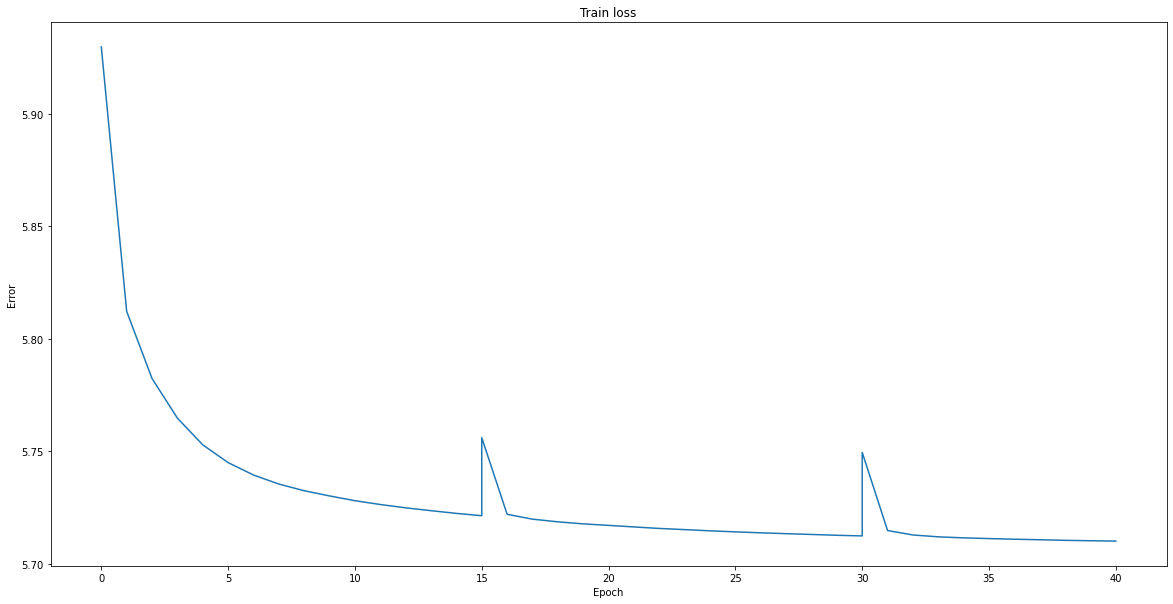

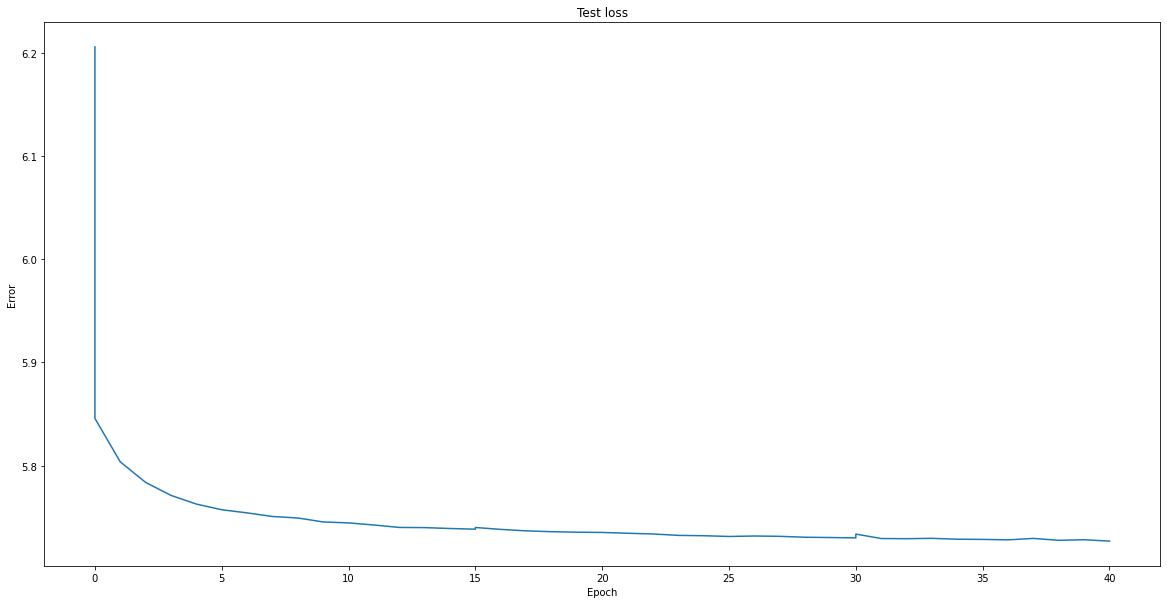

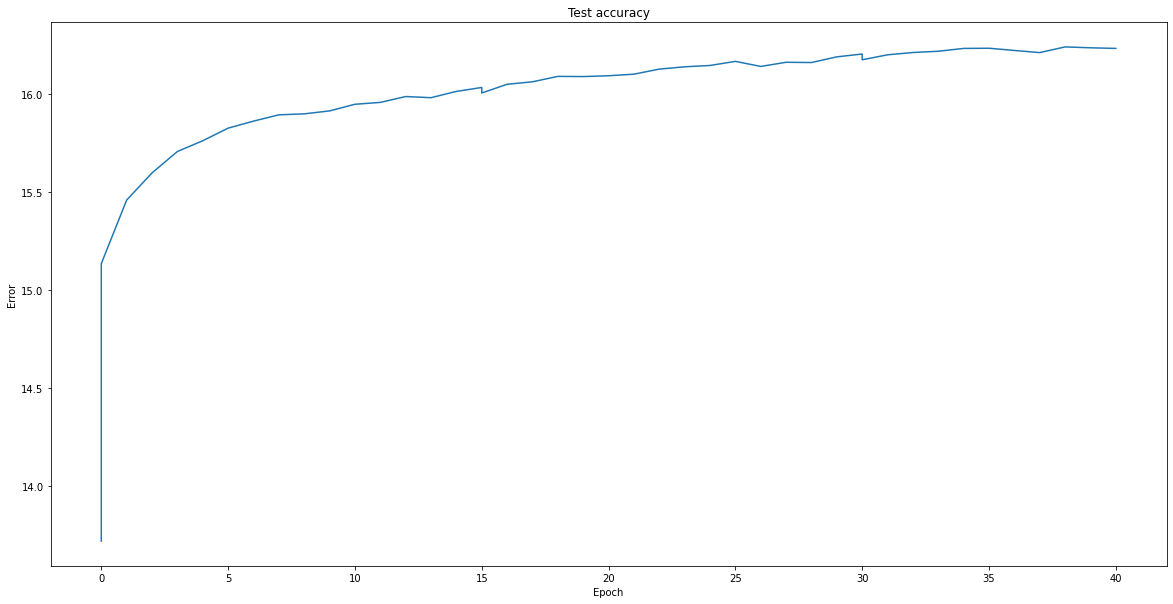

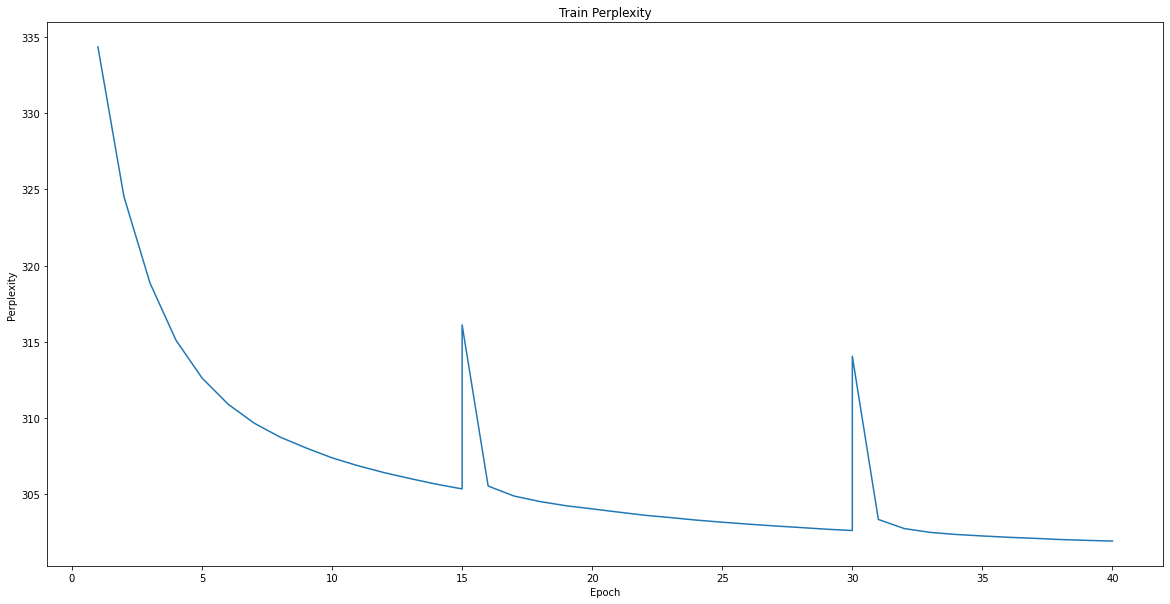

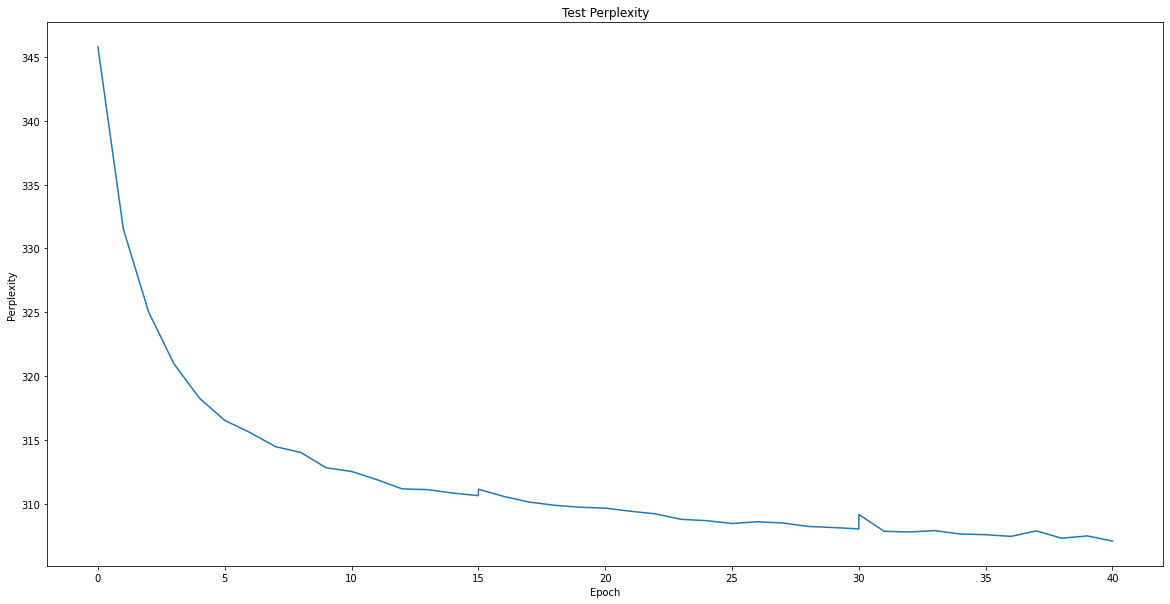

Max test perplexity:  307.0700545690484


In [ ]:
def main():
    SEQUENCE_LENGTH = 16
    BATCH_SIZE = 64
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 128
    EPOCHS = 40
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 40
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_losses)
        pt_util.plot(ep[1:], np.exp(val)[1:], 'Train Perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep[1:], np.exp(val)[1:], 'Test Perplexity', 'Epoch', 'Perplexity')
        print('Max test perplexity: ', min(np.exp(val)))
        return model, vocab, device

final_model, vocab, device = main()

## Evaluate

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the <UNKNOWN> he was <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> <U

# Other thing 3: New Architecture

## Preprocess

In [8]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char == ' ' or char == '\n' or char == '\t':
          pass
        if char not in voc2ind:
          voc2ind[char] = len(voc2ind)

    ind2voc = {val: key for key, val in voc2ind.items()}
    eighty = int(len(data) * 0.8)
    train_text = data[0:eighty] # TODO Fill this in
    test_text = data[eighty:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']
        encoded_tokens = [self.voc2ind[char] for char in self.tokens]

        self.data = torch.LongTensor(
            encoded_tokens[:len(encoded_tokens) - (len(encoded_tokens) % batch_size)]
        ).view(batch_size, -1)
        self.seq_num =  math.ceil((self.data.shape[1] - 1) / sequence_length)


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.data.shape[0] * self.seq_num
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size
        front_idx = (idx // self.batch_size) * self.sequence_length
        data = self.data[batch_idx][front_idx : min(self.data.shape[1], front_idx + self.sequence_length + 1)]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

TEMPERATURE = 0.6
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, cell_state, vocab):
    outputs = []
    for ii in range(sequence_length):
        x = output[0].argmax().long()
        outputs.append(x)
        output, (hidden, cell_state) = model.inference(x, hidden, cell_state)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, cell_state, vocab):
    outputs = []
    for ii in range(sequence_length):
        x = torch.multinomial(output[0],1)[0].long()
        outputs.append(x)
        output, (hidden, cell_state) = model.inference(x, hidden, cell_state, temperature=TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, cell_state, vocab):
    outputs = []
    beam = [([], output, hidden, cell_state, 0)]
    for ii in range(sequence_length):
        next_beam = []
        for i in range(len(beam)):
            cur_beam = beam[i]
            sample = torch.multinomial(output[0], beam_width, replacement=True)
            for x in sample:
                x = x.long()
                x_score = cur_beam[1][0][x]
                new_score = cur_beam[4] + torch.log(x_score)
                output, (hidden, cell_state) = model.inference(x, cur_beam[2], cur_beam[3], temperature=TEMPERATURE)
                next_beam.append(([
                    cur_beam[0] + [x],
                    output,
                    hidden,
                    cell_state,
                    new_score
                ]))
        next_beam.sort(reverse=True, key=lambda v: v[4])
        beam = next_beam[:beam_width]
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH, batch_size=1):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = torch.zeros(model.num_layers, batch_size, model.feature_size).requires_grad_().to(device)
        cell_state = torch.zeros(model.num_layers, batch_size, model.feature_size).requires_grad_().to(device)
        for ind in seed_words_arr:
            data = ind.to(device)
            output, (hidden, cell_state) = model.inference(data, hidden, cell_state)
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, cell_state, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, cell_state, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, cell_state, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

## Network

In [15]:
TEMPERATURE = 0.75
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, feature_size, num_layers, dropout): # Vocab: output size, feature: hidden size 
        super(LSTMNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, num_layers=num_layers, dropout=self.dropout, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None, cell_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state))
        x = self.decoder(x)
        return x, (hidden_state, cell_state)

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, cell_state=None, temperature=1):
        x = x.view(-1, 1)
        x, (hidden_state, cell_state) = self.forward(x, hidden_state, cell_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, (hidden_state, cell_state)

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

## Train

Using device cuda
num workers: 2
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	EEGpp__UUpHp13yy3yyyy11111KvKKJH1KKHWTUUTT111P1hyP]]}}}rqq1Vcv3T&&88HHdd11EqF11fTHpp3JJJK//3y11FHtq


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	K9V11yy11yyhPPff1Pt(113V1/HHHHKHPPTTTPpp]pppqf1qqqq1t_(x1xyy11FF]111H1K1111yff]]UUhhhhHffH=KtpHUUtyy


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	qy1hhfft_hPPfffHHHHHH1Zy11Fq1=11rx_yqyfHWHHpp111ZPPPPP11thtq=rqyyy3y11KVPPPTTPPvv]UUUpr_b91KKHKvFK{w


Input	 . .

  0%|          | 2/782 [00:00<02:23,  5.44it/s]

Train Epoch: 0 [0/50048 (0%)]	Loss: 4.957424


  2%|▏         | 12/782 [00:01<01:38,  7.82it/s]

Train Epoch: 0 [640/50048 (1%)]	Loss: 2.874016


  3%|▎         | 22/782 [00:02<01:37,  7.82it/s]

Train Epoch: 0 [1280/50048 (3%)]	Loss: 2.588535


  4%|▍         | 32/782 [00:04<01:34,  7.91it/s]

Train Epoch: 0 [1920/50048 (4%)]	Loss: 2.325574


  5%|▌         | 42/782 [00:05<01:32,  8.02it/s]

Train Epoch: 0 [2560/50048 (5%)]	Loss: 2.215791


  7%|▋         | 52/782 [00:06<01:32,  7.87it/s]

Train Epoch: 0 [3200/50048 (6%)]	Loss: 2.188770


  8%|▊         | 62/782 [00:07<01:31,  7.85it/s]

Train Epoch: 0 [3840/50048 (8%)]	Loss: 2.071012


  9%|▉         | 72/782 [00:09<01:29,  7.90it/s]

Train Epoch: 0 [4480/50048 (9%)]	Loss: 2.020746


 10%|█         | 82/782 [00:10<01:29,  7.84it/s]

Train Epoch: 0 [5120/50048 (10%)]	Loss: 1.971472


 12%|█▏        | 92/782 [00:11<01:28,  7.75it/s]

Train Epoch: 0 [5760/50048 (12%)]	Loss: 1.943706


 13%|█▎        | 102/782 [00:13<01:27,  7.76it/s]

Train Epoch: 0 [6400/50048 (13%)]	Loss: 1.975360


 14%|█▍        | 112/782 [00:14<01:25,  7.81it/s]

Train Epoch: 0 [7040/50048 (14%)]	Loss: 1.885000


 16%|█▌        | 122/782 [00:15<01:23,  7.93it/s]

Train Epoch: 0 [7680/50048 (15%)]	Loss: 1.857033


 17%|█▋        | 132/782 [00:16<01:23,  7.78it/s]

Train Epoch: 0 [8320/50048 (17%)]	Loss: 1.857024


 18%|█▊        | 142/782 [00:18<01:22,  7.78it/s]

Train Epoch: 0 [8960/50048 (18%)]	Loss: 1.874173


 19%|█▉        | 152/782 [00:19<01:21,  7.77it/s]

Train Epoch: 0 [9600/50048 (19%)]	Loss: 1.919162


 21%|██        | 162/782 [00:20<01:20,  7.73it/s]

Train Epoch: 0 [10240/50048 (20%)]	Loss: 1.849255


 22%|██▏       | 172/782 [00:22<01:18,  7.79it/s]

Train Epoch: 0 [10880/50048 (22%)]	Loss: 1.819982


 23%|██▎       | 182/782 [00:23<01:16,  7.79it/s]

Train Epoch: 0 [11520/50048 (23%)]	Loss: 1.770470


 25%|██▍       | 192/782 [00:24<01:16,  7.74it/s]

Train Epoch: 0 [12160/50048 (24%)]	Loss: 1.815346


 26%|██▌       | 202/782 [00:25<01:14,  7.80it/s]

Train Epoch: 0 [12800/50048 (26%)]	Loss: 1.762145


 27%|██▋       | 212/782 [00:27<01:13,  7.78it/s]

Train Epoch: 0 [13440/50048 (27%)]	Loss: 1.764954


 28%|██▊       | 222/782 [00:28<01:12,  7.73it/s]

Train Epoch: 0 [14080/50048 (28%)]	Loss: 1.770191


 30%|██▉       | 232/782 [00:29<01:12,  7.61it/s]

Train Epoch: 0 [14720/50048 (29%)]	Loss: 1.776305


 31%|███       | 242/782 [00:31<01:09,  7.81it/s]

Train Epoch: 0 [15360/50048 (31%)]	Loss: 1.722259


 32%|███▏      | 252/782 [00:32<01:07,  7.86it/s]

Train Epoch: 0 [16000/50048 (32%)]	Loss: 1.711402


 34%|███▎      | 262/782 [00:33<01:06,  7.79it/s]

Train Epoch: 0 [16640/50048 (33%)]	Loss: 1.756122


 35%|███▍      | 272/782 [00:34<01:05,  7.77it/s]

Train Epoch: 0 [17280/50048 (35%)]	Loss: 1.746325


 36%|███▌      | 282/782 [00:36<01:04,  7.72it/s]

Train Epoch: 0 [17920/50048 (36%)]	Loss: 1.701540


 37%|███▋      | 292/782 [00:37<01:03,  7.67it/s]

Train Epoch: 0 [18560/50048 (37%)]	Loss: 1.717351


 39%|███▊      | 302/782 [00:38<01:02,  7.67it/s]

Train Epoch: 0 [19200/50048 (38%)]	Loss: 1.669625


 40%|███▉      | 312/782 [00:40<01:00,  7.82it/s]

Train Epoch: 0 [19840/50048 (40%)]	Loss: 1.680250


 41%|████      | 322/782 [00:41<00:59,  7.71it/s]

Train Epoch: 0 [20480/50048 (41%)]	Loss: 1.671467


 42%|████▏     | 332/782 [00:42<00:58,  7.72it/s]

Train Epoch: 0 [21120/50048 (42%)]	Loss: 1.665819


 44%|████▎     | 342/782 [00:43<00:56,  7.84it/s]

Train Epoch: 0 [21760/50048 (43%)]	Loss: 1.662174


 45%|████▌     | 352/782 [00:45<00:55,  7.68it/s]

Train Epoch: 0 [22400/50048 (45%)]	Loss: 1.643649


 46%|████▋     | 362/782 [00:46<00:54,  7.74it/s]

Train Epoch: 0 [23040/50048 (46%)]	Loss: 1.639456


 48%|████▊     | 372/782 [00:47<00:52,  7.76it/s]

Train Epoch: 0 [23680/50048 (47%)]	Loss: 1.682237


 49%|████▉     | 382/782 [00:49<00:51,  7.79it/s]

Train Epoch: 0 [24320/50048 (49%)]	Loss: 1.627311


 50%|█████     | 392/782 [00:50<00:50,  7.72it/s]

Train Epoch: 0 [24960/50048 (50%)]	Loss: 1.653201


 51%|█████▏    | 402/782 [00:51<00:48,  7.81it/s]

Train Epoch: 0 [25600/50048 (51%)]	Loss: 1.565997


 53%|█████▎    | 412/782 [00:52<00:48,  7.66it/s]

Train Epoch: 0 [26240/50048 (52%)]	Loss: 1.632961


 54%|█████▍    | 422/782 [00:54<00:46,  7.67it/s]

Train Epoch: 0 [26880/50048 (54%)]	Loss: 1.672287


 55%|█████▌    | 432/782 [00:55<00:45,  7.75it/s]

Train Epoch: 0 [27520/50048 (55%)]	Loss: 1.578260


 57%|█████▋    | 442/782 [00:56<00:44,  7.66it/s]

Train Epoch: 0 [28160/50048 (56%)]	Loss: 1.615674


 58%|█████▊    | 452/782 [00:58<00:42,  7.79it/s]

Train Epoch: 0 [28800/50048 (58%)]	Loss: 1.570158


 59%|█████▉    | 462/782 [00:59<00:40,  7.84it/s]

Train Epoch: 0 [29440/50048 (59%)]	Loss: 1.612366


 60%|██████    | 472/782 [01:00<00:40,  7.67it/s]

Train Epoch: 0 [30080/50048 (60%)]	Loss: 1.613387


 62%|██████▏   | 482/782 [01:01<00:38,  7.72it/s]

Train Epoch: 0 [30720/50048 (61%)]	Loss: 1.611517


 63%|██████▎   | 492/782 [01:03<00:37,  7.70it/s]

Train Epoch: 0 [31360/50048 (63%)]	Loss: 1.613610


 64%|██████▍   | 502/782 [01:04<00:35,  7.92it/s]

Train Epoch: 0 [32000/50048 (64%)]	Loss: 1.598444


 65%|██████▌   | 512/782 [01:05<00:34,  7.72it/s]

Train Epoch: 0 [32640/50048 (65%)]	Loss: 1.623283


 67%|██████▋   | 522/782 [01:07<00:34,  7.58it/s]

Train Epoch: 0 [33280/50048 (66%)]	Loss: 1.590675


 68%|██████▊   | 532/782 [01:08<00:32,  7.70it/s]

Train Epoch: 0 [33920/50048 (68%)]	Loss: 1.547879


 69%|██████▉   | 542/782 [01:09<00:30,  7.82it/s]

Train Epoch: 0 [34560/50048 (69%)]	Loss: 1.545849


 71%|███████   | 552/782 [01:11<00:29,  7.81it/s]

Train Epoch: 0 [35200/50048 (70%)]	Loss: 1.561968


 72%|███████▏  | 562/782 [01:12<00:28,  7.74it/s]

Train Epoch: 0 [35840/50048 (72%)]	Loss: 1.558131


 73%|███████▎  | 572/782 [01:13<00:27,  7.67it/s]

Train Epoch: 0 [36480/50048 (73%)]	Loss: 1.572147


 74%|███████▍  | 582/782 [01:14<00:25,  7.71it/s]

Train Epoch: 0 [37120/50048 (74%)]	Loss: 1.590563


 76%|███████▌  | 592/782 [01:16<00:24,  7.64it/s]

Train Epoch: 0 [37760/50048 (75%)]	Loss: 1.545580


 77%|███████▋  | 602/782 [01:17<00:23,  7.60it/s]

Train Epoch: 0 [38400/50048 (77%)]	Loss: 1.511739


 78%|███████▊  | 612/782 [01:18<00:21,  7.80it/s]

Train Epoch: 0 [39040/50048 (78%)]	Loss: 1.562085


 80%|███████▉  | 622/782 [01:20<00:21,  7.50it/s]

Train Epoch: 0 [39680/50048 (79%)]	Loss: 1.556227


 81%|████████  | 632/782 [01:21<00:19,  7.66it/s]

Train Epoch: 0 [40320/50048 (81%)]	Loss: 1.532444


 82%|████████▏ | 642/782 [01:22<00:18,  7.67it/s]

Train Epoch: 0 [40960/50048 (82%)]	Loss: 1.577113


 83%|████████▎ | 652/782 [01:24<00:17,  7.59it/s]

Train Epoch: 0 [41600/50048 (83%)]	Loss: 1.619645


 85%|████████▍ | 662/782 [01:25<00:15,  7.63it/s]

Train Epoch: 0 [42240/50048 (84%)]	Loss: 1.581502


 86%|████████▌ | 672/782 [01:26<00:14,  7.76it/s]

Train Epoch: 0 [42880/50048 (86%)]	Loss: 1.507144


 87%|████████▋ | 682/782 [01:27<00:13,  7.60it/s]

Train Epoch: 0 [43520/50048 (87%)]	Loss: 1.531949


 88%|████████▊ | 692/782 [01:29<00:11,  7.70it/s]

Train Epoch: 0 [44160/50048 (88%)]	Loss: 1.533534


 90%|████████▉ | 702/782 [01:30<00:10,  7.67it/s]

Train Epoch: 0 [44800/50048 (90%)]	Loss: 1.577506


 91%|█████████ | 712/782 [01:31<00:09,  7.66it/s]

Train Epoch: 0 [45440/50048 (91%)]	Loss: 1.576944


 92%|█████████▏| 722/782 [01:33<00:07,  7.64it/s]

Train Epoch: 0 [46080/50048 (92%)]	Loss: 1.550416


 94%|█████████▎| 732/782 [01:34<00:06,  7.66it/s]

Train Epoch: 0 [46720/50048 (93%)]	Loss: 1.528129


 95%|█████████▍| 742/782 [01:35<00:05,  7.64it/s]

Train Epoch: 0 [47360/50048 (95%)]	Loss: 1.525776


 96%|█████████▌| 752/782 [01:37<00:03,  7.70it/s]

Train Epoch: 0 [48000/50048 (96%)]	Loss: 1.560755


 97%|█████████▋| 762/782 [01:38<00:02,  7.71it/s]

Train Epoch: 0 [48640/50048 (97%)]	Loss: 1.563591


 99%|█████████▊| 772/782 [01:39<00:01,  7.61it/s]

Train Epoch: 0 [49280/50048 (98%)]	Loss: 1.528241


100%|██████████| 782/782 [01:40<00:00,  7.75it/s]

Train Epoch: 0 [49920/50048 (100%)]	Loss: 1.567312


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney was aoat to tot aiser  autause toldemort wad bractid an wtut . .a wootd tim elf tfer th the cage


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat ted bas b m  H  weaipted tis  brcling arck ard anto the cater aith a ltaath  te waaaweeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes saet aatt aoe craund on the  wotted ais a d setan to torty aas  btiwly atd ttrp y  tuck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:35,  5.03it/s]

Train Epoch: 1 [0/50048 (0%)]	Loss: 1.607529


  2%|▏         | 12/782 [00:01<01:45,  7.28it/s]

Train Epoch: 1 [640/50048 (1%)]	Loss: 1.515054


  3%|▎         | 22/782 [00:03<01:40,  7.53it/s]

Train Epoch: 1 [1280/50048 (3%)]	Loss: 1.541891


  4%|▍         | 32/782 [00:04<01:37,  7.68it/s]

Train Epoch: 1 [1920/50048 (4%)]	Loss: 1.500274


  5%|▌         | 42/782 [00:05<01:37,  7.58it/s]

Train Epoch: 1 [2560/50048 (5%)]	Loss: 1.485196


  7%|▋         | 52/782 [00:07<01:35,  7.61it/s]

Train Epoch: 1 [3200/50048 (6%)]	Loss: 1.541731


  8%|▊         | 62/782 [00:08<01:34,  7.65it/s]

Train Epoch: 1 [3840/50048 (8%)]	Loss: 1.439484


  9%|▉         | 72/782 [00:09<01:32,  7.66it/s]

Train Epoch: 1 [4480/50048 (9%)]	Loss: 1.490722


 10%|█         | 82/782 [00:10<01:32,  7.59it/s]

Train Epoch: 1 [5120/50048 (10%)]	Loss: 1.465988


 12%|█▏        | 92/782 [00:12<01:31,  7.56it/s]

Train Epoch: 1 [5760/50048 (12%)]	Loss: 1.492090


 13%|█▎        | 102/782 [00:13<01:28,  7.72it/s]

Train Epoch: 1 [6400/50048 (13%)]	Loss: 1.545331


 14%|█▍        | 112/782 [00:14<01:28,  7.53it/s]

Train Epoch: 1 [7040/50048 (14%)]	Loss: 1.507579


 16%|█▌        | 122/782 [00:16<01:25,  7.69it/s]

Train Epoch: 1 [7680/50048 (15%)]	Loss: 1.480760


 17%|█▋        | 132/782 [00:17<01:26,  7.56it/s]

Train Epoch: 1 [8320/50048 (17%)]	Loss: 1.478030


 18%|█▊        | 142/782 [00:18<01:22,  7.80it/s]

Train Epoch: 1 [8960/50048 (18%)]	Loss: 1.525152


 19%|█▉        | 152/782 [00:20<01:21,  7.71it/s]

Train Epoch: 1 [9600/50048 (19%)]	Loss: 1.603143


 21%|██        | 162/782 [00:21<01:19,  7.80it/s]

Train Epoch: 1 [10240/50048 (20%)]	Loss: 1.534356


 22%|██▏       | 172/782 [00:22<01:19,  7.65it/s]

Train Epoch: 1 [10880/50048 (22%)]	Loss: 1.513983


 23%|██▎       | 182/782 [00:23<01:19,  7.57it/s]

Train Epoch: 1 [11520/50048 (23%)]	Loss: 1.483419


 25%|██▍       | 192/782 [00:25<01:17,  7.59it/s]

Train Epoch: 1 [12160/50048 (24%)]	Loss: 1.538432


 26%|██▌       | 202/782 [00:26<01:14,  7.76it/s]

Train Epoch: 1 [12800/50048 (26%)]	Loss: 1.495409


 27%|██▋       | 212/782 [00:27<01:13,  7.72it/s]

Train Epoch: 1 [13440/50048 (27%)]	Loss: 1.505893


 28%|██▊       | 222/782 [00:29<01:12,  7.68it/s]

Train Epoch: 1 [14080/50048 (28%)]	Loss: 1.516235


 30%|██▉       | 232/782 [00:30<01:11,  7.72it/s]

Train Epoch: 1 [14720/50048 (29%)]	Loss: 1.541605


 31%|███       | 242/782 [00:31<01:10,  7.70it/s]

Train Epoch: 1 [15360/50048 (31%)]	Loss: 1.504274


 32%|███▏      | 252/782 [00:33<01:08,  7.70it/s]

Train Epoch: 1 [16000/50048 (32%)]	Loss: 1.481473


 34%|███▎      | 262/782 [00:34<01:08,  7.58it/s]

Train Epoch: 1 [16640/50048 (33%)]	Loss: 1.544821


 35%|███▍      | 272/782 [00:35<01:06,  7.65it/s]

Train Epoch: 1 [17280/50048 (35%)]	Loss: 1.520424


 36%|███▌      | 282/782 [00:36<01:04,  7.74it/s]

Train Epoch: 1 [17920/50048 (36%)]	Loss: 1.497070


 37%|███▋      | 292/782 [00:38<01:03,  7.66it/s]

Train Epoch: 1 [18560/50048 (37%)]	Loss: 1.537503


 39%|███▊      | 302/782 [00:39<01:02,  7.69it/s]

Train Epoch: 1 [19200/50048 (38%)]	Loss: 1.477986


 40%|███▉      | 312/782 [00:40<01:01,  7.69it/s]

Train Epoch: 1 [19840/50048 (40%)]	Loss: 1.499302


 41%|████      | 322/782 [00:42<00:58,  7.80it/s]

Train Epoch: 1 [20480/50048 (41%)]	Loss: 1.517725


 42%|████▏     | 332/782 [00:43<00:58,  7.65it/s]

Train Epoch: 1 [21120/50048 (42%)]	Loss: 1.502426


 44%|████▎     | 342/782 [00:44<00:57,  7.72it/s]

Train Epoch: 1 [21760/50048 (43%)]	Loss: 1.504066


 45%|████▌     | 352/782 [00:46<00:56,  7.59it/s]

Train Epoch: 1 [22400/50048 (45%)]	Loss: 1.488407


 46%|████▋     | 362/782 [00:47<00:55,  7.63it/s]

Train Epoch: 1 [23040/50048 (46%)]	Loss: 1.468040


 48%|████▊     | 372/782 [00:48<00:53,  7.63it/s]

Train Epoch: 1 [23680/50048 (47%)]	Loss: 1.535445


 49%|████▉     | 382/782 [00:49<00:52,  7.65it/s]

Train Epoch: 1 [24320/50048 (49%)]	Loss: 1.476335


 50%|█████     | 392/782 [00:51<00:50,  7.79it/s]

Train Epoch: 1 [24960/50048 (50%)]	Loss: 1.518236


 51%|█████▏    | 402/782 [00:52<00:49,  7.75it/s]

Train Epoch: 1 [25600/50048 (51%)]	Loss: 1.424887


 53%|█████▎    | 412/782 [00:53<00:48,  7.62it/s]

Train Epoch: 1 [26240/50048 (52%)]	Loss: 1.497895


 54%|█████▍    | 422/782 [00:55<00:47,  7.59it/s]

Train Epoch: 1 [26880/50048 (54%)]	Loss: 1.530828


 55%|█████▌    | 432/782 [00:56<00:45,  7.67it/s]

Train Epoch: 1 [27520/50048 (55%)]	Loss: 1.439667


 57%|█████▋    | 442/782 [00:57<00:45,  7.52it/s]

Train Epoch: 1 [28160/50048 (56%)]	Loss: 1.486881


 58%|█████▊    | 452/782 [00:59<00:43,  7.62it/s]

Train Epoch: 1 [28800/50048 (58%)]	Loss: 1.452957


 59%|█████▉    | 462/782 [01:00<00:42,  7.46it/s]

Train Epoch: 1 [29440/50048 (59%)]	Loss: 1.506429


 60%|██████    | 472/782 [01:01<00:41,  7.51it/s]

Train Epoch: 1 [30080/50048 (60%)]	Loss: 1.483389


 62%|██████▏   | 482/782 [01:02<00:38,  7.69it/s]

Train Epoch: 1 [30720/50048 (61%)]	Loss: 1.495031


 63%|██████▎   | 492/782 [01:04<00:37,  7.67it/s]

Train Epoch: 1 [31360/50048 (63%)]	Loss: 1.502578


 64%|██████▍   | 502/782 [01:05<00:36,  7.65it/s]

Train Epoch: 1 [32000/50048 (64%)]	Loss: 1.499418


 65%|██████▌   | 512/782 [01:06<00:35,  7.69it/s]

Train Epoch: 1 [32640/50048 (65%)]	Loss: 1.507971


 67%|██████▋   | 522/782 [01:08<00:34,  7.63it/s]

Train Epoch: 1 [33280/50048 (66%)]	Loss: 1.483966


 68%|██████▊   | 532/782 [01:09<00:32,  7.69it/s]

Train Epoch: 1 [33920/50048 (68%)]	Loss: 1.449022


 69%|██████▉   | 542/782 [01:10<00:31,  7.56it/s]

Train Epoch: 1 [34560/50048 (69%)]	Loss: 1.428371


 71%|███████   | 552/782 [01:12<00:29,  7.70it/s]

Train Epoch: 1 [35200/50048 (70%)]	Loss: 1.483619


 72%|███████▏  | 562/782 [01:13<00:28,  7.68it/s]

Train Epoch: 1 [35840/50048 (72%)]	Loss: 1.475182


 73%|███████▎  | 572/782 [01:14<00:26,  7.82it/s]

Train Epoch: 1 [36480/50048 (73%)]	Loss: 1.473922


 74%|███████▍  | 582/782 [01:15<00:26,  7.61it/s]

Train Epoch: 1 [37120/50048 (74%)]	Loss: 1.509669


 76%|███████▌  | 592/782 [01:17<00:25,  7.52it/s]

Train Epoch: 1 [37760/50048 (75%)]	Loss: 1.455121


 77%|███████▋  | 602/782 [01:18<00:23,  7.71it/s]

Train Epoch: 1 [38400/50048 (77%)]	Loss: 1.429333


 78%|███████▊  | 612/782 [01:19<00:22,  7.66it/s]

Train Epoch: 1 [39040/50048 (78%)]	Loss: 1.481969


 80%|███████▉  | 622/782 [01:21<00:21,  7.56it/s]

Train Epoch: 1 [39680/50048 (79%)]	Loss: 1.460692


 81%|████████  | 632/782 [01:22<00:19,  7.56it/s]

Train Epoch: 1 [40320/50048 (81%)]	Loss: 1.471797


 82%|████████▏ | 642/782 [01:23<00:18,  7.60it/s]

Train Epoch: 1 [40960/50048 (82%)]	Loss: 1.507073


 83%|████████▎ | 652/782 [01:25<00:16,  7.73it/s]

Train Epoch: 1 [41600/50048 (83%)]	Loss: 1.546694


 85%|████████▍ | 662/782 [01:26<00:15,  7.63it/s]

Train Epoch: 1 [42240/50048 (84%)]	Loss: 1.507847


 86%|████████▌ | 672/782 [01:27<00:14,  7.66it/s]

Train Epoch: 1 [42880/50048 (86%)]	Loss: 1.448947


 87%|████████▋ | 682/782 [01:29<00:13,  7.63it/s]

Train Epoch: 1 [43520/50048 (87%)]	Loss: 1.464124


 88%|████████▊ | 692/782 [01:30<00:11,  7.62it/s]

Train Epoch: 1 [44160/50048 (88%)]	Loss: 1.454170


 90%|████████▉ | 702/782 [01:31<00:10,  7.74it/s]

Train Epoch: 1 [44800/50048 (90%)]	Loss: 1.520558


 91%|█████████ | 712/782 [01:32<00:09,  7.68it/s]

Train Epoch: 1 [45440/50048 (91%)]	Loss: 1.536726


 92%|█████████▏| 722/782 [01:34<00:07,  7.65it/s]

Train Epoch: 1 [46080/50048 (92%)]	Loss: 1.496117


 94%|█████████▎| 732/782 [01:35<00:06,  7.60it/s]

Train Epoch: 1 [46720/50048 (93%)]	Loss: 1.480968


 95%|█████████▍| 742/782 [01:36<00:05,  7.57it/s]

Train Epoch: 1 [47360/50048 (95%)]	Loss: 1.464349


 96%|█████████▌| 752/782 [01:38<00:03,  7.76it/s]

Train Epoch: 1 [48000/50048 (96%)]	Loss: 1.496307


 97%|█████████▋| 762/782 [01:39<00:02,  7.70it/s]

Train Epoch: 1 [48640/50048 (97%)]	Loss: 1.510163


 99%|█████████▊| 772/782 [01:40<00:01,  7.50it/s]

Train Epoch: 1 [49280/50048 (98%)]	Loss: 1.482364


100%|██████████| 782/782 [01:41<00:00,  7.67it/s]

Train Epoch: 1 [49920/50048 (100%)]	Loss: 1.511546


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy aas aoat to sot aiscr  tutause toldemort sad braceed tn tomt . Ha wootd tim elf tuer th the cage


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed bas s m  Ht waaiated tis  brcling aack ard an o the cater aath a ltaath  te saaewbeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  "nd tes eaet aoat toe sraund an the  wokted tis a d setanito sorry ais  btiwiy atd stre y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:30,  5.18it/s]

Train Epoch: 2 [0/50048 (0%)]	Loss: 1.587418


  2%|▏         | 12/782 [00:01<01:45,  7.30it/s]

Train Epoch: 2 [640/50048 (1%)]	Loss: 1.461360


  3%|▎         | 22/782 [00:03<01:39,  7.61it/s]

Train Epoch: 2 [1280/50048 (3%)]	Loss: 1.490057


  4%|▍         | 32/782 [00:04<01:37,  7.69it/s]

Train Epoch: 2 [1920/50048 (4%)]	Loss: 1.446303


  5%|▌         | 42/782 [00:05<01:35,  7.79it/s]

Train Epoch: 2 [2560/50048 (5%)]	Loss: 1.423339


  7%|▋         | 52/782 [00:06<01:34,  7.74it/s]

Train Epoch: 2 [3200/50048 (6%)]	Loss: 1.485737


  8%|▊         | 62/782 [00:08<01:34,  7.62it/s]

Train Epoch: 2 [3840/50048 (8%)]	Loss: 1.392778


  9%|▉         | 72/782 [00:09<01:31,  7.72it/s]

Train Epoch: 2 [4480/50048 (9%)]	Loss: 1.432121


 10%|█         | 82/782 [00:10<01:31,  7.66it/s]

Train Epoch: 2 [5120/50048 (10%)]	Loss: 1.410460


 12%|█▏        | 92/782 [00:12<01:30,  7.63it/s]

Train Epoch: 2 [5760/50048 (12%)]	Loss: 1.444182


 13%|█▎        | 102/782 [00:13<01:29,  7.56it/s]

Train Epoch: 2 [6400/50048 (13%)]	Loss: 1.493706


 14%|█▍        | 112/782 [00:14<01:27,  7.68it/s]

Train Epoch: 2 [7040/50048 (14%)]	Loss: 1.445487


 16%|█▌        | 122/782 [00:16<01:25,  7.72it/s]

Train Epoch: 2 [7680/50048 (15%)]	Loss: 1.425728


 17%|█▋        | 132/782 [00:17<01:23,  7.79it/s]

Train Epoch: 2 [8320/50048 (17%)]	Loss: 1.448515


 18%|█▊        | 142/782 [00:18<01:22,  7.77it/s]

Train Epoch: 2 [8960/50048 (18%)]	Loss: 1.480154


 19%|█▉        | 152/782 [00:19<01:22,  7.60it/s]

Train Epoch: 2 [9600/50048 (19%)]	Loss: 1.547856


 21%|██        | 162/782 [00:21<01:21,  7.59it/s]

Train Epoch: 2 [10240/50048 (20%)]	Loss: 1.476344


 22%|██▏       | 172/782 [00:22<01:19,  7.64it/s]

Train Epoch: 2 [10880/50048 (22%)]	Loss: 1.453026


 23%|██▎       | 182/782 [00:23<01:16,  7.85it/s]

Train Epoch: 2 [11520/50048 (23%)]	Loss: 1.443087


 25%|██▍       | 192/782 [00:25<01:16,  7.73it/s]

Train Epoch: 2 [12160/50048 (24%)]	Loss: 1.501925


 26%|██▌       | 202/782 [00:26<01:16,  7.62it/s]

Train Epoch: 2 [12800/50048 (26%)]	Loss: 1.441626


 27%|██▋       | 212/782 [00:27<01:15,  7.57it/s]

Train Epoch: 2 [13440/50048 (27%)]	Loss: 1.449756


 28%|██▊       | 222/782 [00:29<01:12,  7.71it/s]

Train Epoch: 2 [14080/50048 (28%)]	Loss: 1.471107


 30%|██▉       | 232/782 [00:30<01:13,  7.49it/s]

Train Epoch: 2 [14720/50048 (29%)]	Loss: 1.490778


 31%|███       | 242/782 [00:31<01:09,  7.78it/s]

Train Epoch: 2 [15360/50048 (31%)]	Loss: 1.456190


 32%|███▏      | 252/782 [00:32<01:09,  7.67it/s]

Train Epoch: 2 [16000/50048 (32%)]	Loss: 1.435838


 34%|███▎      | 262/782 [00:34<01:07,  7.71it/s]

Train Epoch: 2 [16640/50048 (33%)]	Loss: 1.489574


 35%|███▍      | 272/782 [00:35<01:06,  7.71it/s]

Train Epoch: 2 [17280/50048 (35%)]	Loss: 1.485534


 36%|███▌      | 282/782 [00:36<01:06,  7.55it/s]

Train Epoch: 2 [17920/50048 (36%)]	Loss: 1.434868


 37%|███▋      | 292/782 [00:38<01:04,  7.56it/s]

Train Epoch: 2 [18560/50048 (37%)]	Loss: 1.493980


 39%|███▊      | 302/782 [00:39<01:02,  7.66it/s]

Train Epoch: 2 [19200/50048 (38%)]	Loss: 1.425647


 40%|███▉      | 312/782 [00:40<01:00,  7.72it/s]

Train Epoch: 2 [19840/50048 (40%)]	Loss: 1.449940


 41%|████      | 322/782 [00:41<00:59,  7.68it/s]

Train Epoch: 2 [20480/50048 (41%)]	Loss: 1.466079


 42%|████▏     | 332/782 [00:43<00:58,  7.66it/s]

Train Epoch: 2 [21120/50048 (42%)]	Loss: 1.453176


 44%|████▎     | 342/782 [00:44<00:57,  7.70it/s]

Train Epoch: 2 [21760/50048 (43%)]	Loss: 1.459722


 45%|████▌     | 352/782 [00:45<00:56,  7.61it/s]

Train Epoch: 2 [22400/50048 (45%)]	Loss: 1.435578


 46%|████▋     | 362/782 [00:47<00:55,  7.55it/s]

Train Epoch: 2 [23040/50048 (46%)]	Loss: 1.425096


 48%|████▊     | 372/782 [00:48<00:53,  7.65it/s]

Train Epoch: 2 [23680/50048 (47%)]	Loss: 1.485817


 49%|████▉     | 382/782 [00:49<00:51,  7.71it/s]

Train Epoch: 2 [24320/50048 (49%)]	Loss: 1.433015


 50%|█████     | 392/782 [00:51<00:51,  7.61it/s]

Train Epoch: 2 [24960/50048 (50%)]	Loss: 1.482055


 51%|█████▏    | 402/782 [00:52<00:49,  7.67it/s]

Train Epoch: 2 [25600/50048 (51%)]	Loss: 1.379598


 53%|█████▎    | 412/782 [00:53<00:48,  7.64it/s]

Train Epoch: 2 [26240/50048 (52%)]	Loss: 1.461901


 54%|█████▍    | 422/782 [00:55<00:47,  7.62it/s]

Train Epoch: 2 [26880/50048 (54%)]	Loss: 1.495352


 55%|█████▌    | 432/782 [00:56<00:45,  7.73it/s]

Train Epoch: 2 [27520/50048 (55%)]	Loss: 1.403741


 57%|█████▋    | 442/782 [00:57<00:44,  7.64it/s]

Train Epoch: 2 [28160/50048 (56%)]	Loss: 1.450988


 58%|█████▊    | 452/782 [00:58<00:43,  7.63it/s]

Train Epoch: 2 [28800/50048 (58%)]	Loss: 1.403533


 59%|█████▉    | 462/782 [01:00<00:42,  7.57it/s]

Train Epoch: 2 [29440/50048 (59%)]	Loss: 1.463485


 60%|██████    | 472/782 [01:01<00:40,  7.66it/s]

Train Epoch: 2 [30080/50048 (60%)]	Loss: 1.449075


 62%|██████▏   | 482/782 [01:02<00:39,  7.68it/s]

Train Epoch: 2 [30720/50048 (61%)]	Loss: 1.447918


 63%|██████▎   | 492/782 [01:04<00:37,  7.69it/s]

Train Epoch: 2 [31360/50048 (63%)]	Loss: 1.460731


 64%|██████▍   | 502/782 [01:05<00:36,  7.61it/s]

Train Epoch: 2 [32000/50048 (64%)]	Loss: 1.462160


 65%|██████▌   | 512/782 [01:06<00:35,  7.62it/s]

Train Epoch: 2 [32640/50048 (65%)]	Loss: 1.474140


 67%|██████▋   | 522/782 [01:08<00:33,  7.74it/s]

Train Epoch: 2 [33280/50048 (66%)]	Loss: 1.438206


 68%|██████▊   | 532/782 [01:09<00:32,  7.75it/s]

Train Epoch: 2 [33920/50048 (68%)]	Loss: 1.420669


 69%|██████▉   | 542/782 [01:10<00:31,  7.65it/s]

Train Epoch: 2 [34560/50048 (69%)]	Loss: 1.407577


 71%|███████   | 552/782 [01:11<00:29,  7.72it/s]

Train Epoch: 2 [35200/50048 (70%)]	Loss: 1.434059


 72%|███████▏  | 562/782 [01:13<00:29,  7.59it/s]

Train Epoch: 2 [35840/50048 (72%)]	Loss: 1.442296


 73%|███████▎  | 572/782 [01:14<00:28,  7.43it/s]

Train Epoch: 2 [36480/50048 (73%)]	Loss: 1.437543


 74%|███████▍  | 582/782 [01:15<00:26,  7.59it/s]

Train Epoch: 2 [37120/50048 (74%)]	Loss: 1.462034


 76%|███████▌  | 592/782 [01:17<00:24,  7.67it/s]

Train Epoch: 2 [37760/50048 (75%)]	Loss: 1.418680


 77%|███████▋  | 602/782 [01:18<00:23,  7.80it/s]

Train Epoch: 2 [38400/50048 (77%)]	Loss: 1.387179


 78%|███████▊  | 612/782 [01:19<00:22,  7.56it/s]

Train Epoch: 2 [39040/50048 (78%)]	Loss: 1.443858


 80%|███████▉  | 622/782 [01:21<00:20,  7.69it/s]

Train Epoch: 2 [39680/50048 (79%)]	Loss: 1.428362


 81%|████████  | 632/782 [01:22<00:19,  7.68it/s]

Train Epoch: 2 [40320/50048 (81%)]	Loss: 1.440441


 82%|████████▏ | 642/782 [01:23<00:18,  7.68it/s]

Train Epoch: 2 [40960/50048 (82%)]	Loss: 1.451516


 83%|████████▎ | 652/782 [01:25<00:16,  7.69it/s]

Train Epoch: 2 [41600/50048 (83%)]	Loss: 1.509329


 85%|████████▍ | 662/782 [01:26<00:15,  7.65it/s]

Train Epoch: 2 [42240/50048 (84%)]	Loss: 1.478621


 86%|████████▌ | 672/782 [01:27<00:14,  7.54it/s]

Train Epoch: 2 [42880/50048 (86%)]	Loss: 1.416294


 87%|████████▋ | 682/782 [01:28<00:13,  7.59it/s]

Train Epoch: 2 [43520/50048 (87%)]	Loss: 1.432338


 88%|████████▊ | 692/782 [01:30<00:11,  7.72it/s]

Train Epoch: 2 [44160/50048 (88%)]	Loss: 1.419274


 90%|████████▉ | 702/782 [01:31<00:10,  7.76it/s]

Train Epoch: 2 [44800/50048 (90%)]	Loss: 1.480829


 91%|█████████ | 712/782 [01:32<00:09,  7.70it/s]

Train Epoch: 2 [45440/50048 (91%)]	Loss: 1.476735


 92%|█████████▏| 722/782 [01:34<00:07,  7.68it/s]

Train Epoch: 2 [46080/50048 (92%)]	Loss: 1.450923


 94%|█████████▎| 732/782 [01:35<00:06,  7.70it/s]

Train Epoch: 2 [46720/50048 (93%)]	Loss: 1.451500


 95%|█████████▍| 742/782 [01:36<00:05,  7.61it/s]

Train Epoch: 2 [47360/50048 (95%)]	Loss: 1.419744


 96%|█████████▌| 752/782 [01:38<00:03,  7.53it/s]

Train Epoch: 2 [48000/50048 (96%)]	Loss: 1.455659


 97%|█████████▋| 762/782 [01:39<00:02,  7.70it/s]

Train Epoch: 2 [48640/50048 (97%)]	Loss: 1.468711


 99%|█████████▊| 772/782 [01:40<00:01,  7.59it/s]

Train Epoch: 2 [49280/50048 (98%)]	Loss: 1.446054


100%|██████████| 782/782 [01:41<00:00,  7.67it/s]

Train Epoch: 2 [49920/50048 (100%)]	Loss: 1.473505


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy tan toat to tot titcr  tucause toldemort sad braceed tn wtmt . Ha weotd ois elf tner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ooat hed bas erm  Ht weaaated his  brcling aeck ard anto the cater.aith a staath  he saaawbeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aeat the craund an the  wokted ais a d secan to torey ais  atiwiy atd stre y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:39,  4.90it/s]

Train Epoch: 3 [0/50048 (0%)]	Loss: 1.581229


  2%|▏         | 12/782 [00:01<01:44,  7.35it/s]

Train Epoch: 3 [640/50048 (1%)]	Loss: 1.429445


  3%|▎         | 22/782 [00:03<01:39,  7.64it/s]

Train Epoch: 3 [1280/50048 (3%)]	Loss: 1.456244


  4%|▍         | 32/782 [00:04<01:37,  7.68it/s]

Train Epoch: 3 [1920/50048 (4%)]	Loss: 1.410585


  5%|▌         | 42/782 [00:05<01:35,  7.71it/s]

Train Epoch: 3 [2560/50048 (5%)]	Loss: 1.396742


  7%|▋         | 52/782 [00:07<01:36,  7.60it/s]

Train Epoch: 3 [3200/50048 (6%)]	Loss: 1.446718


  8%|▊         | 62/782 [00:08<01:35,  7.55it/s]

Train Epoch: 3 [3840/50048 (8%)]	Loss: 1.373945


  9%|▉         | 72/782 [00:09<01:33,  7.57it/s]

Train Epoch: 3 [4480/50048 (9%)]	Loss: 1.402031


 10%|█         | 82/782 [00:10<01:31,  7.61it/s]

Train Epoch: 3 [5120/50048 (10%)]	Loss: 1.381228


 12%|█▏        | 92/782 [00:12<01:30,  7.61it/s]

Train Epoch: 3 [5760/50048 (12%)]	Loss: 1.401866


 13%|█▎        | 102/782 [00:13<01:27,  7.74it/s]

Train Epoch: 3 [6400/50048 (13%)]	Loss: 1.453655


 14%|█▍        | 112/782 [00:14<01:26,  7.72it/s]

Train Epoch: 3 [7040/50048 (14%)]	Loss: 1.401920


 16%|█▌        | 122/782 [00:16<01:26,  7.62it/s]

Train Epoch: 3 [7680/50048 (15%)]	Loss: 1.392574


 17%|█▋        | 132/782 [00:17<01:26,  7.55it/s]

Train Epoch: 3 [8320/50048 (17%)]	Loss: 1.402882


 18%|█▊        | 142/782 [00:18<01:24,  7.59it/s]

Train Epoch: 3 [8960/50048 (18%)]	Loss: 1.441366


 19%|█▉        | 152/782 [00:20<01:21,  7.72it/s]

Train Epoch: 3 [9600/50048 (19%)]	Loss: 1.520540


 21%|██        | 162/782 [00:21<01:20,  7.68it/s]

Train Epoch: 3 [10240/50048 (20%)]	Loss: 1.450663


 22%|██▏       | 172/782 [00:22<01:18,  7.72it/s]

Train Epoch: 3 [10880/50048 (22%)]	Loss: 1.421341


 23%|██▎       | 182/782 [00:23<01:17,  7.73it/s]

Train Epoch: 3 [11520/50048 (23%)]	Loss: 1.403383


 25%|██▍       | 192/782 [00:25<01:17,  7.62it/s]

Train Epoch: 3 [12160/50048 (24%)]	Loss: 1.471203


 26%|██▌       | 202/782 [00:26<01:15,  7.73it/s]

Train Epoch: 3 [12800/50048 (26%)]	Loss: 1.412984


 27%|██▋       | 212/782 [00:27<01:13,  7.78it/s]

Train Epoch: 3 [13440/50048 (27%)]	Loss: 1.429134


 28%|██▊       | 222/782 [00:29<01:12,  7.69it/s]

Train Epoch: 3 [14080/50048 (28%)]	Loss: 1.438079


 30%|██▉       | 232/782 [00:30<01:11,  7.71it/s]

Train Epoch: 3 [14720/50048 (29%)]	Loss: 1.465123


 31%|███       | 242/782 [00:31<01:09,  7.75it/s]

Train Epoch: 3 [15360/50048 (31%)]	Loss: 1.423896


 32%|███▏      | 252/782 [00:33<01:08,  7.70it/s]

Train Epoch: 3 [16000/50048 (32%)]	Loss: 1.415934


 34%|███▎      | 262/782 [00:34<01:08,  7.59it/s]

Train Epoch: 3 [16640/50048 (33%)]	Loss: 1.452637


 35%|███▍      | 272/782 [00:35<01:07,  7.59it/s]

Train Epoch: 3 [17280/50048 (35%)]	Loss: 1.446745


 36%|███▌      | 282/782 [00:36<01:04,  7.70it/s]

Train Epoch: 3 [17920/50048 (36%)]	Loss: 1.407820


 37%|███▋      | 292/782 [00:38<01:02,  7.78it/s]

Train Epoch: 3 [18560/50048 (37%)]	Loss: 1.450910


 39%|███▊      | 302/782 [00:39<01:03,  7.60it/s]

Train Epoch: 3 [19200/50048 (38%)]	Loss: 1.391744


 40%|███▉      | 312/782 [00:40<01:01,  7.64it/s]

Train Epoch: 3 [19840/50048 (40%)]	Loss: 1.416179


 41%|████      | 322/782 [00:42<01:00,  7.65it/s]

Train Epoch: 3 [20480/50048 (41%)]	Loss: 1.430502


 42%|████▏     | 332/782 [00:43<00:59,  7.61it/s]

Train Epoch: 3 [21120/50048 (42%)]	Loss: 1.416974


 44%|████▎     | 342/782 [00:44<00:57,  7.59it/s]

Train Epoch: 3 [21760/50048 (43%)]	Loss: 1.426406


 45%|████▌     | 352/782 [00:46<00:56,  7.59it/s]

Train Epoch: 3 [22400/50048 (45%)]	Loss: 1.411752


 46%|████▋     | 362/782 [00:47<00:55,  7.55it/s]

Train Epoch: 3 [23040/50048 (46%)]	Loss: 1.383403


 48%|████▊     | 372/782 [00:48<00:54,  7.57it/s]

Train Epoch: 3 [23680/50048 (47%)]	Loss: 1.456658


 49%|████▉     | 382/782 [00:49<00:52,  7.60it/s]

Train Epoch: 3 [24320/50048 (49%)]	Loss: 1.413390


 50%|█████     | 392/782 [00:51<00:51,  7.55it/s]

Train Epoch: 3 [24960/50048 (50%)]	Loss: 1.446250


 51%|█████▏    | 402/782 [00:52<00:49,  7.68it/s]

Train Epoch: 3 [25600/50048 (51%)]	Loss: 1.354559


 53%|█████▎    | 412/782 [00:53<00:48,  7.59it/s]

Train Epoch: 3 [26240/50048 (52%)]	Loss: 1.433125


 54%|█████▍    | 422/782 [00:55<00:47,  7.64it/s]

Train Epoch: 3 [26880/50048 (54%)]	Loss: 1.449241


 55%|█████▌    | 432/782 [00:56<00:45,  7.74it/s]

Train Epoch: 3 [27520/50048 (55%)]	Loss: 1.387178


 57%|█████▋    | 442/782 [00:57<00:44,  7.66it/s]

Train Epoch: 3 [28160/50048 (56%)]	Loss: 1.423177


 58%|█████▊    | 452/782 [00:59<00:43,  7.60it/s]

Train Epoch: 3 [28800/50048 (58%)]	Loss: 1.373743


 59%|█████▉    | 462/782 [01:00<00:41,  7.65it/s]

Train Epoch: 3 [29440/50048 (59%)]	Loss: 1.439098


 60%|██████    | 472/782 [01:01<00:40,  7.74it/s]

Train Epoch: 3 [30080/50048 (60%)]	Loss: 1.423690


 62%|██████▏   | 482/782 [01:03<00:39,  7.59it/s]

Train Epoch: 3 [30720/50048 (61%)]	Loss: 1.423848


 63%|██████▎   | 492/782 [01:04<00:38,  7.62it/s]

Train Epoch: 3 [31360/50048 (63%)]	Loss: 1.437936


 64%|██████▍   | 502/782 [01:05<00:37,  7.42it/s]

Train Epoch: 3 [32000/50048 (64%)]	Loss: 1.427987


 65%|██████▌   | 512/782 [01:06<00:34,  7.75it/s]

Train Epoch: 3 [32640/50048 (65%)]	Loss: 1.443881


 67%|██████▋   | 522/782 [01:08<00:33,  7.74it/s]

Train Epoch: 3 [33280/50048 (66%)]	Loss: 1.414929


 68%|██████▊   | 532/782 [01:09<00:32,  7.61it/s]

Train Epoch: 3 [33920/50048 (68%)]	Loss: 1.401502


 69%|██████▉   | 542/782 [01:10<00:32,  7.44it/s]

Train Epoch: 3 [34560/50048 (69%)]	Loss: 1.381372


 71%|███████   | 552/782 [01:12<00:29,  7.71it/s]

Train Epoch: 3 [35200/50048 (70%)]	Loss: 1.410927


 72%|███████▏  | 562/782 [01:13<00:28,  7.71it/s]

Train Epoch: 3 [35840/50048 (72%)]	Loss: 1.404195


 73%|███████▎  | 572/782 [01:14<00:28,  7.39it/s]

Train Epoch: 3 [36480/50048 (73%)]	Loss: 1.399409


 74%|███████▍  | 582/782 [01:16<00:25,  7.76it/s]

Train Epoch: 3 [37120/50048 (74%)]	Loss: 1.434962


 76%|███████▌  | 592/782 [01:17<00:25,  7.44it/s]

Train Epoch: 3 [37760/50048 (75%)]	Loss: 1.390610


 77%|███████▋  | 602/782 [01:18<00:23,  7.69it/s]

Train Epoch: 3 [38400/50048 (77%)]	Loss: 1.364543


 78%|███████▊  | 612/782 [01:20<00:22,  7.67it/s]

Train Epoch: 3 [39040/50048 (78%)]	Loss: 1.412153


 80%|███████▉  | 622/782 [01:21<00:21,  7.49it/s]

Train Epoch: 3 [39680/50048 (79%)]	Loss: 1.397326


 81%|████████  | 632/782 [01:22<00:19,  7.55it/s]

Train Epoch: 3 [40320/50048 (81%)]	Loss: 1.403211


 82%|████████▏ | 642/782 [01:23<00:18,  7.68it/s]

Train Epoch: 3 [40960/50048 (82%)]	Loss: 1.434265


 83%|████████▎ | 652/782 [01:25<00:16,  7.77it/s]

Train Epoch: 3 [41600/50048 (83%)]	Loss: 1.472684


 85%|████████▍ | 662/782 [01:26<00:15,  7.56it/s]

Train Epoch: 3 [42240/50048 (84%)]	Loss: 1.446522


 86%|████████▌ | 672/782 [01:27<00:14,  7.62it/s]

Train Epoch: 3 [42880/50048 (86%)]	Loss: 1.390782


 87%|████████▋ | 682/782 [01:29<00:13,  7.60it/s]

Train Epoch: 3 [43520/50048 (87%)]	Loss: 1.404742


 88%|████████▊ | 692/782 [01:30<00:11,  7.66it/s]

Train Epoch: 3 [44160/50048 (88%)]	Loss: 1.386835


 90%|████████▉ | 702/782 [01:31<00:10,  7.57it/s]

Train Epoch: 3 [44800/50048 (90%)]	Loss: 1.457639


 91%|█████████ | 712/782 [01:33<00:09,  7.75it/s]

Train Epoch: 3 [45440/50048 (91%)]	Loss: 1.454957


 92%|█████████▏| 722/782 [01:34<00:08,  7.49it/s]

Train Epoch: 3 [46080/50048 (92%)]	Loss: 1.423178


 94%|█████████▎| 732/782 [01:35<00:06,  7.61it/s]

Train Epoch: 3 [46720/50048 (93%)]	Loss: 1.428588


 95%|█████████▍| 742/782 [01:37<00:05,  7.63it/s]

Train Epoch: 3 [47360/50048 (95%)]	Loss: 1.392228


 96%|█████████▌| 752/782 [01:38<00:03,  7.58it/s]

Train Epoch: 3 [48000/50048 (96%)]	Loss: 1.441561


 97%|█████████▋| 762/782 [01:39<00:02,  7.55it/s]

Train Epoch: 3 [48640/50048 (97%)]	Loss: 1.442479


 99%|█████████▊| 772/782 [01:40<00:01,  7.51it/s]

Train Epoch: 3 [49280/50048 (98%)]	Loss: 1.412585


100%|██████████| 782/782 [01:42<00:00,  7.65it/s]

Train Epoch: 3 [49920/50048 (100%)]	Loss: 1.453532


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy tan toat to tot thscr  aucause toldemort wad buaceed tn wtmt . Ia wootd oim elf tner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ooat hed bas erm  "t weaiattd tis  arcling aeck ard anto the caler.aith a ctaath  he wareweeed ah t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aaat the sraund an the  wokted ais a d secan to torry ais  atiwiy atd ttre y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:32,  5.13it/s]

Train Epoch: 4 [0/50048 (0%)]	Loss: 1.590470


  2%|▏         | 12/782 [00:01<01:43,  7.47it/s]

Train Epoch: 4 [640/50048 (1%)]	Loss: 1.407200


  3%|▎         | 22/782 [00:03<01:40,  7.55it/s]

Train Epoch: 4 [1280/50048 (3%)]	Loss: 1.444435


  4%|▍         | 32/782 [00:04<01:41,  7.38it/s]

Train Epoch: 4 [1920/50048 (4%)]	Loss: 1.392820


  5%|▌         | 42/782 [00:05<01:36,  7.69it/s]

Train Epoch: 4 [2560/50048 (5%)]	Loss: 1.373556


  7%|▋         | 52/782 [00:07<01:34,  7.68it/s]

Train Epoch: 4 [3200/50048 (6%)]	Loss: 1.421579


  8%|▊         | 62/782 [00:08<01:34,  7.63it/s]

Train Epoch: 4 [3840/50048 (8%)]	Loss: 1.347877


  9%|▉         | 72/782 [00:09<01:33,  7.59it/s]

Train Epoch: 4 [4480/50048 (9%)]	Loss: 1.381103


 10%|█         | 82/782 [00:10<01:30,  7.70it/s]

Train Epoch: 4 [5120/50048 (10%)]	Loss: 1.362956


 12%|█▏        | 92/782 [00:12<01:30,  7.60it/s]

Train Epoch: 4 [5760/50048 (12%)]	Loss: 1.385405


 13%|█▎        | 102/782 [00:13<01:28,  7.70it/s]

Train Epoch: 4 [6400/50048 (13%)]	Loss: 1.439583


 14%|█▍        | 112/782 [00:14<01:26,  7.75it/s]

Train Epoch: 4 [7040/50048 (14%)]	Loss: 1.380391


 16%|█▌        | 122/782 [00:16<01:26,  7.67it/s]

Train Epoch: 4 [7680/50048 (15%)]	Loss: 1.371677


 17%|█▋        | 132/782 [00:17<01:25,  7.61it/s]

Train Epoch: 4 [8320/50048 (17%)]	Loss: 1.381431


 18%|█▊        | 142/782 [00:18<01:24,  7.61it/s]

Train Epoch: 4 [8960/50048 (18%)]	Loss: 1.423034


 19%|█▉        | 152/782 [00:20<01:23,  7.56it/s]

Train Epoch: 4 [9600/50048 (19%)]	Loss: 1.494183


 21%|██        | 162/782 [00:21<01:20,  7.70it/s]

Train Epoch: 4 [10240/50048 (20%)]	Loss: 1.426442


 22%|██▏       | 172/782 [00:22<01:19,  7.69it/s]

Train Epoch: 4 [10880/50048 (22%)]	Loss: 1.401124


 23%|██▎       | 182/782 [00:24<01:21,  7.38it/s]

Train Epoch: 4 [11520/50048 (23%)]	Loss: 1.383344


 25%|██▍       | 192/782 [00:25<01:17,  7.66it/s]

Train Epoch: 4 [12160/50048 (24%)]	Loss: 1.449667


 26%|██▌       | 202/782 [00:26<01:16,  7.59it/s]

Train Epoch: 4 [12800/50048 (26%)]	Loss: 1.393399


 27%|██▋       | 212/782 [00:27<01:13,  7.74it/s]

Train Epoch: 4 [13440/50048 (27%)]	Loss: 1.399040


 28%|██▊       | 222/782 [00:29<01:13,  7.63it/s]

Train Epoch: 4 [14080/50048 (28%)]	Loss: 1.408879


 30%|██▉       | 232/782 [00:30<01:11,  7.65it/s]

Train Epoch: 4 [14720/50048 (29%)]	Loss: 1.440757


 31%|███       | 242/782 [00:31<01:10,  7.68it/s]

Train Epoch: 4 [15360/50048 (31%)]	Loss: 1.414531


 32%|███▏      | 252/782 [00:33<01:08,  7.74it/s]

Train Epoch: 4 [16000/50048 (32%)]	Loss: 1.392112


 34%|███▎      | 262/782 [00:34<01:08,  7.56it/s]

Train Epoch: 4 [16640/50048 (33%)]	Loss: 1.440531


 35%|███▍      | 272/782 [00:35<01:07,  7.58it/s]

Train Epoch: 4 [17280/50048 (35%)]	Loss: 1.428409


 36%|███▌      | 282/782 [00:37<01:05,  7.64it/s]

Train Epoch: 4 [17920/50048 (36%)]	Loss: 1.391746


 37%|███▋      | 292/782 [00:38<01:04,  7.61it/s]

Train Epoch: 4 [18560/50048 (37%)]	Loss: 1.422274


 39%|███▊      | 302/782 [00:39<01:02,  7.68it/s]

Train Epoch: 4 [19200/50048 (38%)]	Loss: 1.369008


 40%|███▉      | 312/782 [00:40<01:02,  7.50it/s]

Train Epoch: 4 [19840/50048 (40%)]	Loss: 1.400576


 41%|████      | 322/782 [00:42<01:00,  7.58it/s]

Train Epoch: 4 [20480/50048 (41%)]	Loss: 1.418249


 42%|████▏     | 332/782 [00:43<00:58,  7.73it/s]

Train Epoch: 4 [21120/50048 (42%)]	Loss: 1.394304


 44%|████▎     | 342/782 [00:44<00:57,  7.63it/s]

Train Epoch: 4 [21760/50048 (43%)]	Loss: 1.409044


 45%|████▌     | 352/782 [00:46<00:57,  7.50it/s]

Train Epoch: 4 [22400/50048 (45%)]	Loss: 1.383644


 46%|████▋     | 362/782 [00:47<00:55,  7.57it/s]

Train Epoch: 4 [23040/50048 (46%)]	Loss: 1.361696


 48%|████▊     | 372/782 [00:48<00:52,  7.80it/s]

Train Epoch: 4 [23680/50048 (47%)]	Loss: 1.438376


 49%|████▉     | 382/782 [00:50<00:51,  7.71it/s]

Train Epoch: 4 [24320/50048 (49%)]	Loss: 1.394339


 50%|█████     | 392/782 [00:51<00:51,  7.65it/s]

Train Epoch: 4 [24960/50048 (50%)]	Loss: 1.416697


 51%|█████▏    | 402/782 [00:52<00:49,  7.74it/s]

Train Epoch: 4 [25600/50048 (51%)]	Loss: 1.336106


 53%|█████▎    | 412/782 [00:54<00:48,  7.68it/s]

Train Epoch: 4 [26240/50048 (52%)]	Loss: 1.407574


 54%|█████▍    | 422/782 [00:55<00:47,  7.53it/s]

Train Epoch: 4 [26880/50048 (54%)]	Loss: 1.435512


 55%|█████▌    | 432/782 [00:56<00:46,  7.54it/s]

Train Epoch: 4 [27520/50048 (55%)]	Loss: 1.366422


 57%|█████▋    | 442/782 [00:58<00:44,  7.61it/s]

Train Epoch: 4 [28160/50048 (56%)]	Loss: 1.406557


 58%|█████▊    | 452/782 [00:59<00:45,  7.32it/s]

Train Epoch: 4 [28800/50048 (58%)]	Loss: 1.357496


 59%|█████▉    | 462/782 [01:00<00:41,  7.67it/s]

Train Epoch: 4 [29440/50048 (59%)]	Loss: 1.420563


 60%|██████    | 472/782 [01:01<00:40,  7.58it/s]

Train Epoch: 4 [30080/50048 (60%)]	Loss: 1.405202


 62%|██████▏   | 482/782 [01:03<00:39,  7.57it/s]

Train Epoch: 4 [30720/50048 (61%)]	Loss: 1.405535


 63%|██████▎   | 492/782 [01:04<00:38,  7.59it/s]

Train Epoch: 4 [31360/50048 (63%)]	Loss: 1.421627


 64%|██████▍   | 502/782 [01:05<00:36,  7.70it/s]

Train Epoch: 4 [32000/50048 (64%)]	Loss: 1.409399


 65%|██████▌   | 512/782 [01:07<00:35,  7.64it/s]

Train Epoch: 4 [32640/50048 (65%)]	Loss: 1.439647


 67%|██████▋   | 522/782 [01:08<00:34,  7.63it/s]

Train Epoch: 4 [33280/50048 (66%)]	Loss: 1.397229


 68%|██████▊   | 532/782 [01:09<00:33,  7.56it/s]

Train Epoch: 4 [33920/50048 (68%)]	Loss: 1.380603


 69%|██████▉   | 542/782 [01:11<00:31,  7.67it/s]

Train Epoch: 4 [34560/50048 (69%)]	Loss: 1.357259


 71%|███████   | 552/782 [01:12<00:30,  7.64it/s]

Train Epoch: 4 [35200/50048 (70%)]	Loss: 1.404327


 72%|███████▏  | 562/782 [01:13<00:28,  7.65it/s]

Train Epoch: 4 [35840/50048 (72%)]	Loss: 1.394597


 73%|███████▎  | 572/782 [01:15<00:27,  7.51it/s]

Train Epoch: 4 [36480/50048 (73%)]	Loss: 1.387216


 74%|███████▍  | 582/782 [01:16<00:27,  7.38it/s]

Train Epoch: 4 [37120/50048 (74%)]	Loss: 1.417363


 76%|███████▌  | 592/782 [01:17<00:25,  7.57it/s]

Train Epoch: 4 [37760/50048 (75%)]	Loss: 1.382762


 77%|███████▋  | 602/782 [01:18<00:23,  7.79it/s]

Train Epoch: 4 [38400/50048 (77%)]	Loss: 1.350606


 78%|███████▊  | 612/782 [01:20<00:22,  7.57it/s]

Train Epoch: 4 [39040/50048 (78%)]	Loss: 1.397032


 80%|███████▉  | 622/782 [01:21<00:21,  7.55it/s]

Train Epoch: 4 [39680/50048 (79%)]	Loss: 1.385810


 81%|████████  | 632/782 [01:22<00:19,  7.62it/s]

Train Epoch: 4 [40320/50048 (81%)]	Loss: 1.390830


 82%|████████▏ | 642/782 [01:24<00:18,  7.61it/s]

Train Epoch: 4 [40960/50048 (82%)]	Loss: 1.418965


 83%|████████▎ | 652/782 [01:25<00:17,  7.59it/s]

Train Epoch: 4 [41600/50048 (83%)]	Loss: 1.461807


 85%|████████▍ | 662/782 [01:26<00:16,  7.49it/s]

Train Epoch: 4 [42240/50048 (84%)]	Loss: 1.427822


 86%|████████▌ | 672/782 [01:28<00:14,  7.64it/s]

Train Epoch: 4 [42880/50048 (86%)]	Loss: 1.377536


 87%|████████▋ | 682/782 [01:29<00:13,  7.69it/s]

Train Epoch: 4 [43520/50048 (87%)]	Loss: 1.389741


 88%|████████▊ | 692/782 [01:30<00:11,  7.61it/s]

Train Epoch: 4 [44160/50048 (88%)]	Loss: 1.381185


 90%|████████▉ | 702/782 [01:31<00:10,  7.70it/s]

Train Epoch: 4 [44800/50048 (90%)]	Loss: 1.446867


 91%|█████████ | 712/782 [01:33<00:09,  7.67it/s]

Train Epoch: 4 [45440/50048 (91%)]	Loss: 1.453698


 92%|█████████▏| 722/782 [01:34<00:07,  7.77it/s]

Train Epoch: 4 [46080/50048 (92%)]	Loss: 1.415833


 94%|█████████▎| 732/782 [01:35<00:06,  7.71it/s]

Train Epoch: 4 [46720/50048 (93%)]	Loss: 1.413370


 95%|█████████▍| 742/782 [01:37<00:05,  7.51it/s]

Train Epoch: 4 [47360/50048 (95%)]	Loss: 1.381025


 96%|█████████▌| 752/782 [01:38<00:04,  7.46it/s]

Train Epoch: 4 [48000/50048 (96%)]	Loss: 1.428610


 97%|█████████▋| 762/782 [01:39<00:02,  7.66it/s]

Train Epoch: 4 [48640/50048 (97%)]	Loss: 1.432014


 99%|█████████▊| 772/782 [01:41<00:01,  7.72it/s]

Train Epoch: 4 [49280/50048 (98%)]	Loss: 1.397877


100%|██████████| 782/782 [01:42<00:00,  7.64it/s]

Train Epoch: 4 [49920/50048 (100%)]	Loss: 1.433869


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy fanntoat to tot tiser  aucause toldemort wad braceed tn aomt . Iarwootd oem elf tuer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ooat hed bas erm  "t weaaattd tis  aocling aeck ard an o the caler aith a steath  he saoeweeed ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aoat toe sround an the  wokted tis a d secan to sorey aiss atiwiy atd stde y  huck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:40,  4.87it/s]

Train Epoch: 5 [0/50048 (0%)]	Loss: 1.584855


  2%|▏         | 12/782 [00:01<01:43,  7.41it/s]

Train Epoch: 5 [640/50048 (1%)]	Loss: 1.397115


  3%|▎         | 22/782 [00:03<01:40,  7.57it/s]

Train Epoch: 5 [1280/50048 (3%)]	Loss: 1.433330


  4%|▍         | 32/782 [00:04<01:37,  7.67it/s]

Train Epoch: 5 [1920/50048 (4%)]	Loss: 1.378883


  5%|▌         | 42/782 [00:05<01:34,  7.80it/s]

Train Epoch: 5 [2560/50048 (5%)]	Loss: 1.363643


  7%|▋         | 52/782 [00:07<01:33,  7.81it/s]

Train Epoch: 5 [3200/50048 (6%)]	Loss: 1.409536


  8%|▊         | 62/782 [00:08<01:36,  7.47it/s]

Train Epoch: 5 [3840/50048 (8%)]	Loss: 1.332735


  9%|▉         | 72/782 [00:09<01:33,  7.58it/s]

Train Epoch: 5 [4480/50048 (9%)]	Loss: 1.363624


 10%|█         | 82/782 [00:10<01:31,  7.61it/s]

Train Epoch: 5 [5120/50048 (10%)]	Loss: 1.337870


 12%|█▏        | 92/782 [00:12<01:29,  7.74it/s]

Train Epoch: 5 [5760/50048 (12%)]	Loss: 1.375921


 13%|█▎        | 102/782 [00:13<01:28,  7.66it/s]

Train Epoch: 5 [6400/50048 (13%)]	Loss: 1.420056


 14%|█▍        | 112/782 [00:14<01:26,  7.71it/s]

Train Epoch: 5 [7040/50048 (14%)]	Loss: 1.366114


 16%|█▌        | 122/782 [00:16<01:27,  7.57it/s]

Train Epoch: 5 [7680/50048 (15%)]	Loss: 1.358501


 17%|█▋        | 132/782 [00:17<01:26,  7.53it/s]

Train Epoch: 5 [8320/50048 (17%)]	Loss: 1.373937


 18%|█▊        | 142/782 [00:18<01:23,  7.64it/s]

Train Epoch: 5 [8960/50048 (18%)]	Loss: 1.414903


 19%|█▉        | 152/782 [00:20<01:22,  7.66it/s]

Train Epoch: 5 [9600/50048 (19%)]	Loss: 1.478773


 21%|██        | 162/782 [00:21<01:21,  7.60it/s]

Train Epoch: 5 [10240/50048 (20%)]	Loss: 1.416489


 22%|██▏       | 172/782 [00:22<01:19,  7.64it/s]

Train Epoch: 5 [10880/50048 (22%)]	Loss: 1.391256


 23%|██▎       | 182/782 [00:23<01:17,  7.70it/s]

Train Epoch: 5 [11520/50048 (23%)]	Loss: 1.371807


 25%|██▍       | 192/782 [00:25<01:16,  7.74it/s]

Train Epoch: 5 [12160/50048 (24%)]	Loss: 1.436041


 26%|██▌       | 202/782 [00:26<01:15,  7.64it/s]

Train Epoch: 5 [12800/50048 (26%)]	Loss: 1.380897


 27%|██▋       | 212/782 [00:27<01:13,  7.79it/s]

Train Epoch: 5 [13440/50048 (27%)]	Loss: 1.388791


 28%|██▊       | 222/782 [00:29<01:12,  7.72it/s]

Train Epoch: 5 [14080/50048 (28%)]	Loss: 1.395130


 30%|██▉       | 232/782 [00:30<01:12,  7.63it/s]

Train Epoch: 5 [14720/50048 (29%)]	Loss: 1.430681


 31%|███       | 242/782 [00:31<01:11,  7.57it/s]

Train Epoch: 5 [15360/50048 (31%)]	Loss: 1.391912


 32%|███▏      | 252/782 [00:33<01:11,  7.46it/s]

Train Epoch: 5 [16000/50048 (32%)]	Loss: 1.381963


 34%|███▎      | 262/782 [00:34<01:08,  7.57it/s]

Train Epoch: 5 [16640/50048 (33%)]	Loss: 1.416249


 35%|███▍      | 272/782 [00:35<01:07,  7.59it/s]

Train Epoch: 5 [17280/50048 (35%)]	Loss: 1.420881


 36%|███▌      | 282/782 [00:37<01:05,  7.69it/s]

Train Epoch: 5 [17920/50048 (36%)]	Loss: 1.385860


 37%|███▋      | 292/782 [00:38<01:03,  7.75it/s]

Train Epoch: 5 [18560/50048 (37%)]	Loss: 1.409002


 39%|███▊      | 302/782 [00:39<01:03,  7.54it/s]

Train Epoch: 5 [19200/50048 (38%)]	Loss: 1.352536


 40%|███▉      | 312/782 [00:40<01:01,  7.60it/s]

Train Epoch: 5 [19840/50048 (40%)]	Loss: 1.390728


 41%|████      | 322/782 [00:42<01:01,  7.50it/s]

Train Epoch: 5 [20480/50048 (41%)]	Loss: 1.402733


 42%|████▏     | 332/782 [00:43<01:00,  7.47it/s]

Train Epoch: 5 [21120/50048 (42%)]	Loss: 1.383343


 44%|████▎     | 342/782 [00:44<00:57,  7.59it/s]

Train Epoch: 5 [21760/50048 (43%)]	Loss: 1.398385


 45%|████▌     | 352/782 [00:46<00:56,  7.55it/s]

Train Epoch: 5 [22400/50048 (45%)]	Loss: 1.371333


 46%|████▋     | 362/782 [00:47<00:56,  7.41it/s]

Train Epoch: 5 [23040/50048 (46%)]	Loss: 1.354495


 48%|████▊     | 372/782 [00:48<00:53,  7.70it/s]

Train Epoch: 5 [23680/50048 (47%)]	Loss: 1.423471


 49%|████▉     | 382/782 [00:50<00:52,  7.58it/s]

Train Epoch: 5 [24320/50048 (49%)]	Loss: 1.382777


 50%|█████     | 392/782 [00:51<00:51,  7.62it/s]

Train Epoch: 5 [24960/50048 (50%)]	Loss: 1.412061


 51%|█████▏    | 402/782 [00:52<00:49,  7.68it/s]

Train Epoch: 5 [25600/50048 (51%)]	Loss: 1.327642


 53%|█████▎    | 412/782 [00:54<00:48,  7.61it/s]

Train Epoch: 5 [26240/50048 (52%)]	Loss: 1.398895


 54%|█████▍    | 422/782 [00:55<00:47,  7.62it/s]

Train Epoch: 5 [26880/50048 (54%)]	Loss: 1.427175


 55%|█████▌    | 432/782 [00:56<00:45,  7.71it/s]

Train Epoch: 5 [27520/50048 (55%)]	Loss: 1.355415


 57%|█████▋    | 442/782 [00:57<00:43,  7.76it/s]

Train Epoch: 5 [28160/50048 (56%)]	Loss: 1.399177


 58%|█████▊    | 452/782 [00:59<00:43,  7.53it/s]

Train Epoch: 5 [28800/50048 (58%)]	Loss: 1.350787


 59%|█████▉    | 462/782 [01:00<00:41,  7.63it/s]

Train Epoch: 5 [29440/50048 (59%)]	Loss: 1.412688


 60%|██████    | 472/782 [01:01<00:40,  7.60it/s]

Train Epoch: 5 [30080/50048 (60%)]	Loss: 1.404542


 62%|██████▏   | 482/782 [01:03<00:39,  7.54it/s]

Train Epoch: 5 [30720/50048 (61%)]	Loss: 1.392586


 63%|██████▎   | 492/782 [01:04<00:37,  7.67it/s]

Train Epoch: 5 [31360/50048 (63%)]	Loss: 1.410674


 64%|██████▍   | 502/782 [01:05<00:36,  7.61it/s]

Train Epoch: 5 [32000/50048 (64%)]	Loss: 1.407975


 65%|██████▌   | 512/782 [01:07<00:34,  7.72it/s]

Train Epoch: 5 [32640/50048 (65%)]	Loss: 1.428896


 67%|██████▋   | 522/782 [01:08<00:34,  7.62it/s]

Train Epoch: 5 [33280/50048 (66%)]	Loss: 1.382966


 68%|██████▊   | 532/782 [01:09<00:33,  7.49it/s]

Train Epoch: 5 [33920/50048 (68%)]	Loss: 1.371387


 69%|██████▉   | 542/782 [01:11<00:31,  7.57it/s]

Train Epoch: 5 [34560/50048 (69%)]	Loss: 1.355523


 71%|███████   | 552/782 [01:12<00:30,  7.64it/s]

Train Epoch: 5 [35200/50048 (70%)]	Loss: 1.399070


 72%|███████▏  | 562/782 [01:13<00:28,  7.67it/s]

Train Epoch: 5 [35840/50048 (72%)]	Loss: 1.388448


 73%|███████▎  | 572/782 [01:15<00:27,  7.56it/s]

Train Epoch: 5 [36480/50048 (73%)]	Loss: 1.379004


 74%|███████▍  | 582/782 [01:16<00:26,  7.45it/s]

Train Epoch: 5 [37120/50048 (74%)]	Loss: 1.414833


 76%|███████▌  | 592/782 [01:17<00:24,  7.72it/s]

Train Epoch: 5 [37760/50048 (75%)]	Loss: 1.371334


 77%|███████▋  | 602/782 [01:19<00:23,  7.61it/s]

Train Epoch: 5 [38400/50048 (77%)]	Loss: 1.336365


 78%|███████▊  | 612/782 [01:20<00:22,  7.69it/s]

Train Epoch: 5 [39040/50048 (78%)]	Loss: 1.391985


 80%|███████▉  | 622/782 [01:21<00:21,  7.57it/s]

Train Epoch: 5 [39680/50048 (79%)]	Loss: 1.380121


 81%|████████  | 632/782 [01:22<00:19,  7.65it/s]

Train Epoch: 5 [40320/50048 (81%)]	Loss: 1.380388


 82%|████████▏ | 642/782 [01:24<00:18,  7.74it/s]

Train Epoch: 5 [40960/50048 (82%)]	Loss: 1.393968


 83%|████████▎ | 652/782 [01:25<00:17,  7.63it/s]

Train Epoch: 5 [41600/50048 (83%)]	Loss: 1.454156


 85%|████████▍ | 662/782 [01:26<00:15,  7.59it/s]

Train Epoch: 5 [42240/50048 (84%)]	Loss: 1.426058


 86%|████████▌ | 672/782 [01:28<00:14,  7.61it/s]

Train Epoch: 5 [42880/50048 (86%)]	Loss: 1.364739


 87%|████████▋ | 682/782 [01:29<00:12,  7.74it/s]

Train Epoch: 5 [43520/50048 (87%)]	Loss: 1.378476


 88%|████████▊ | 692/782 [01:30<00:11,  7.51it/s]

Train Epoch: 5 [44160/50048 (88%)]	Loss: 1.366584


 90%|████████▉ | 702/782 [01:32<00:10,  7.64it/s]

Train Epoch: 5 [44800/50048 (90%)]	Loss: 1.434171


 91%|█████████ | 712/782 [01:33<00:09,  7.50it/s]

Train Epoch: 5 [45440/50048 (91%)]	Loss: 1.430236


 92%|█████████▏| 722/782 [01:34<00:07,  7.62it/s]

Train Epoch: 5 [46080/50048 (92%)]	Loss: 1.398569


 94%|█████████▎| 732/782 [01:36<00:06,  7.41it/s]

Train Epoch: 5 [46720/50048 (93%)]	Loss: 1.392110


 95%|█████████▍| 742/782 [01:37<00:05,  7.59it/s]

Train Epoch: 5 [47360/50048 (95%)]	Loss: 1.367850


 96%|█████████▌| 752/782 [01:38<00:03,  7.63it/s]

Train Epoch: 5 [48000/50048 (96%)]	Loss: 1.417024


 97%|█████████▋| 762/782 [01:39<00:02,  7.41it/s]

Train Epoch: 5 [48640/50048 (97%)]	Loss: 1.420578


 99%|█████████▊| 772/782 [01:41<00:01,  7.61it/s]

Train Epoch: 5 [49280/50048 (98%)]	Loss: 1.395209


100%|██████████| 782/782 [01:42<00:00,  7.63it/s]

Train Epoch: 5 [49920/50048 (100%)]	Loss: 1.432478


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy,fanntoat to tot aiser  aucause toldemort wad brayied tt womt.. Ia wootd oem elf tner th the sxge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ooat hed bas erm  Ht weaiattd tim  aocling tack ard an o the caler oith a cteath  he wareweeed ao t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh, wnd tes eaet aiat toe cround on they wokted tim a d secan to torei aims atiwiy atd stre y  auck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:38,  4.93it/s]

Train Epoch: 6 [0/50048 (0%)]	Loss: 1.602348


  2%|▏         | 12/782 [00:01<01:43,  7.43it/s]

Train Epoch: 6 [640/50048 (1%)]	Loss: 1.395863


  3%|▎         | 22/782 [00:03<01:41,  7.52it/s]

Train Epoch: 6 [1280/50048 (3%)]	Loss: 1.426742


  4%|▍         | 32/782 [00:04<01:37,  7.72it/s]

Train Epoch: 6 [1920/50048 (4%)]	Loss: 1.367795


  5%|▌         | 42/782 [00:05<01:35,  7.74it/s]

Train Epoch: 6 [2560/50048 (5%)]	Loss: 1.352891


  7%|▋         | 52/782 [00:07<01:35,  7.62it/s]

Train Epoch: 6 [3200/50048 (6%)]	Loss: 1.402156


  8%|▊         | 62/782 [00:08<01:35,  7.51it/s]

Train Epoch: 6 [3840/50048 (8%)]	Loss: 1.323620


  9%|▉         | 72/782 [00:09<01:33,  7.63it/s]

Train Epoch: 6 [4480/50048 (9%)]	Loss: 1.367125


 10%|█         | 82/782 [00:10<01:30,  7.76it/s]

Train Epoch: 6 [5120/50048 (10%)]	Loss: 1.332776


 12%|█▏        | 92/782 [00:12<01:30,  7.60it/s]

Train Epoch: 6 [5760/50048 (12%)]	Loss: 1.365068


 13%|█▎        | 102/782 [00:13<01:30,  7.54it/s]

Train Epoch: 6 [6400/50048 (13%)]	Loss: 1.418653


 14%|█▍        | 112/782 [00:14<01:27,  7.66it/s]

Train Epoch: 6 [7040/50048 (14%)]	Loss: 1.361709


 16%|█▌        | 122/782 [00:16<01:26,  7.63it/s]

Train Epoch: 6 [7680/50048 (15%)]	Loss: 1.348973


 17%|█▋        | 132/782 [00:17<01:25,  7.64it/s]

Train Epoch: 6 [8320/50048 (17%)]	Loss: 1.364706


 18%|█▊        | 142/782 [00:18<01:23,  7.68it/s]

Train Epoch: 6 [8960/50048 (18%)]	Loss: 1.409032


 19%|█▉        | 152/782 [00:20<01:22,  7.67it/s]

Train Epoch: 6 [9600/50048 (19%)]	Loss: 1.470147


 21%|██        | 162/782 [00:21<01:20,  7.66it/s]

Train Epoch: 6 [10240/50048 (20%)]	Loss: 1.409456


 22%|██▏       | 172/782 [00:22<01:18,  7.80it/s]

Train Epoch: 6 [10880/50048 (22%)]	Loss: 1.386851


 23%|██▎       | 182/782 [00:24<01:19,  7.56it/s]

Train Epoch: 6 [11520/50048 (23%)]	Loss: 1.358346


 25%|██▍       | 192/782 [00:25<01:17,  7.63it/s]

Train Epoch: 6 [12160/50048 (24%)]	Loss: 1.427969


 26%|██▌       | 202/782 [00:26<01:16,  7.60it/s]

Train Epoch: 6 [12800/50048 (26%)]	Loss: 1.370348


 27%|██▋       | 212/782 [00:27<01:14,  7.63it/s]

Train Epoch: 6 [13440/50048 (27%)]	Loss: 1.379990


 28%|██▊       | 222/782 [00:29<01:14,  7.56it/s]

Train Epoch: 6 [14080/50048 (28%)]	Loss: 1.394782


 30%|██▉       | 232/782 [00:30<01:12,  7.56it/s]

Train Epoch: 6 [14720/50048 (29%)]	Loss: 1.426373


 31%|███       | 242/782 [00:31<01:11,  7.59it/s]

Train Epoch: 6 [15360/50048 (31%)]	Loss: 1.390435


 32%|███▏      | 252/782 [00:33<01:09,  7.64it/s]

Train Epoch: 6 [16000/50048 (32%)]	Loss: 1.378127


 34%|███▎      | 262/782 [00:34<01:08,  7.59it/s]

Train Epoch: 6 [16640/50048 (33%)]	Loss: 1.410151


 35%|███▍      | 272/782 [00:35<01:06,  7.66it/s]

Train Epoch: 6 [17280/50048 (35%)]	Loss: 1.418641


 36%|███▌      | 282/782 [00:37<01:06,  7.57it/s]

Train Epoch: 6 [17920/50048 (36%)]	Loss: 1.367397


 37%|███▋      | 292/782 [00:38<01:04,  7.59it/s]

Train Epoch: 6 [18560/50048 (37%)]	Loss: 1.406477


 39%|███▊      | 302/782 [00:39<01:03,  7.60it/s]

Train Epoch: 6 [19200/50048 (38%)]	Loss: 1.348915


 40%|███▉      | 312/782 [00:41<01:01,  7.69it/s]

Train Epoch: 6 [19840/50048 (40%)]	Loss: 1.379617


 41%|████      | 322/782 [00:42<01:00,  7.60it/s]

Train Epoch: 6 [20480/50048 (41%)]	Loss: 1.386010


 42%|████▏     | 332/782 [00:43<00:58,  7.64it/s]

Train Epoch: 6 [21120/50048 (42%)]	Loss: 1.377016


 44%|████▎     | 342/782 [00:45<00:58,  7.52it/s]

Train Epoch: 6 [21760/50048 (43%)]	Loss: 1.396526


 45%|████▌     | 352/782 [00:46<00:57,  7.52it/s]

Train Epoch: 6 [22400/50048 (45%)]	Loss: 1.360313


 46%|████▋     | 362/782 [00:47<00:55,  7.59it/s]

Train Epoch: 6 [23040/50048 (46%)]	Loss: 1.353057


 48%|████▊     | 372/782 [00:48<00:53,  7.73it/s]

Train Epoch: 6 [23680/50048 (47%)]	Loss: 1.424206


 49%|████▉     | 382/782 [00:50<00:52,  7.61it/s]

Train Epoch: 6 [24320/50048 (49%)]	Loss: 1.372835


 50%|█████     | 392/782 [00:51<00:50,  7.65it/s]

Train Epoch: 6 [24960/50048 (50%)]	Loss: 1.395719


 51%|█████▏    | 402/782 [00:52<00:50,  7.51it/s]

Train Epoch: 6 [25600/50048 (51%)]	Loss: 1.321219


 53%|█████▎    | 412/782 [00:54<00:48,  7.68it/s]

Train Epoch: 6 [26240/50048 (52%)]	Loss: 1.392957


 54%|█████▍    | 422/782 [00:55<00:47,  7.59it/s]

Train Epoch: 6 [26880/50048 (54%)]	Loss: 1.420587


 55%|█████▌    | 432/782 [00:56<00:46,  7.47it/s]

Train Epoch: 6 [27520/50048 (55%)]	Loss: 1.347271


 57%|█████▋    | 442/782 [00:58<00:44,  7.56it/s]

Train Epoch: 6 [28160/50048 (56%)]	Loss: 1.394649


 58%|█████▊    | 452/782 [00:59<00:42,  7.68it/s]

Train Epoch: 6 [28800/50048 (58%)]	Loss: 1.352271


 59%|█████▉    | 462/782 [01:00<00:41,  7.68it/s]

Train Epoch: 6 [29440/50048 (59%)]	Loss: 1.401729


 60%|██████    | 472/782 [01:02<00:41,  7.53it/s]

Train Epoch: 6 [30080/50048 (60%)]	Loss: 1.397597


 62%|██████▏   | 482/782 [01:03<00:39,  7.62it/s]

Train Epoch: 6 [30720/50048 (61%)]	Loss: 1.389147


 63%|██████▎   | 492/782 [01:04<00:38,  7.61it/s]

Train Epoch: 6 [31360/50048 (63%)]	Loss: 1.408035


 64%|██████▍   | 502/782 [01:06<00:36,  7.61it/s]

Train Epoch: 6 [32000/50048 (64%)]	Loss: 1.401726


 65%|██████▌   | 512/782 [01:07<00:36,  7.48it/s]

Train Epoch: 6 [32640/50048 (65%)]	Loss: 1.426096


 67%|██████▋   | 522/782 [01:08<00:34,  7.46it/s]

Train Epoch: 6 [33280/50048 (66%)]	Loss: 1.382334


 68%|██████▊   | 532/782 [01:09<00:33,  7.45it/s]

Train Epoch: 6 [33920/50048 (68%)]	Loss: 1.373635


 69%|██████▉   | 542/782 [01:11<00:31,  7.51it/s]

Train Epoch: 6 [34560/50048 (69%)]	Loss: 1.345136


 71%|███████   | 552/782 [01:12<00:30,  7.57it/s]

Train Epoch: 6 [35200/50048 (70%)]	Loss: 1.384804


 72%|███████▏  | 562/782 [01:13<00:28,  7.64it/s]

Train Epoch: 6 [35840/50048 (72%)]	Loss: 1.384222


 73%|███████▎  | 572/782 [01:15<00:27,  7.69it/s]

Train Epoch: 6 [36480/50048 (73%)]	Loss: 1.373154


 74%|███████▍  | 582/782 [01:16<00:26,  7.43it/s]

Train Epoch: 6 [37120/50048 (74%)]	Loss: 1.409675


 76%|███████▌  | 592/782 [01:17<00:24,  7.66it/s]

Train Epoch: 6 [37760/50048 (75%)]	Loss: 1.372408


 77%|███████▋  | 602/782 [01:19<00:23,  7.80it/s]

Train Epoch: 6 [38400/50048 (77%)]	Loss: 1.335269


 78%|███████▊  | 612/782 [01:20<00:22,  7.61it/s]

Train Epoch: 6 [39040/50048 (78%)]	Loss: 1.386938


 80%|███████▉  | 622/782 [01:21<00:21,  7.60it/s]

Train Epoch: 6 [39680/50048 (79%)]	Loss: 1.372221


 81%|████████  | 632/782 [01:23<00:19,  7.51it/s]

Train Epoch: 6 [40320/50048 (81%)]	Loss: 1.385491


 82%|████████▏ | 642/782 [01:24<00:18,  7.46it/s]

Train Epoch: 6 [40960/50048 (82%)]	Loss: 1.386678


 83%|████████▎ | 652/782 [01:25<00:16,  7.69it/s]

Train Epoch: 6 [41600/50048 (83%)]	Loss: 1.449617


 85%|████████▍ | 662/782 [01:26<00:15,  7.75it/s]

Train Epoch: 6 [42240/50048 (84%)]	Loss: 1.414405


 86%|████████▌ | 672/782 [01:28<00:14,  7.59it/s]

Train Epoch: 6 [42880/50048 (86%)]	Loss: 1.350017


 87%|████████▋ | 682/782 [01:29<00:13,  7.66it/s]

Train Epoch: 6 [43520/50048 (87%)]	Loss: 1.372759


 88%|████████▊ | 692/782 [01:30<00:11,  7.62it/s]

Train Epoch: 6 [44160/50048 (88%)]	Loss: 1.367333


 90%|████████▉ | 702/782 [01:32<00:10,  7.63it/s]

Train Epoch: 6 [44800/50048 (90%)]	Loss: 1.425244


 91%|█████████ | 712/782 [01:33<00:09,  7.61it/s]

Train Epoch: 6 [45440/50048 (91%)]	Loss: 1.423519


 92%|█████████▏| 722/782 [01:34<00:07,  7.66it/s]

Train Epoch: 6 [46080/50048 (92%)]	Loss: 1.399974


 94%|█████████▎| 732/782 [01:36<00:06,  7.53it/s]

Train Epoch: 6 [46720/50048 (93%)]	Loss: 1.392702


 95%|█████████▍| 742/782 [01:37<00:05,  7.31it/s]

Train Epoch: 6 [47360/50048 (95%)]	Loss: 1.358186


 96%|█████████▌| 752/782 [01:38<00:03,  7.53it/s]

Train Epoch: 6 [48000/50048 (96%)]	Loss: 1.410867


 97%|█████████▋| 762/782 [01:40<00:02,  7.55it/s]

Train Epoch: 6 [48640/50048 (97%)]	Loss: 1.414704


 99%|█████████▊| 772/782 [01:41<00:01,  7.68it/s]

Train Epoch: 6 [49280/50048 (98%)]	Loss: 1.392526


100%|██████████| 782/782 [01:42<00:00,  7.62it/s]

Train Epoch: 6 [49920/50048 (100%)]	Loss: 1.423096


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy,fhn toat to tot aiseri tutause toldemort wad brayied tn wtmt . Ia wootdeoim elf tner th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Coat hed bas frm  "t weaiated tim  borling teck ard an o the caler.tith a cteath  te waoeweeed to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe wnd tes waet aiat toe craund tn they wokted tim a d tecan to sorey aim  ahiwiy ard ttde y  tuck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:34,  5.04it/s]

Train Epoch: 7 [0/50048 (0%)]	Loss: 1.605027


  2%|▏         | 12/782 [00:01<01:45,  7.32it/s]

Train Epoch: 7 [640/50048 (1%)]	Loss: 1.390979


  3%|▎         | 22/782 [00:03<01:39,  7.63it/s]

Train Epoch: 7 [1280/50048 (3%)]	Loss: 1.422258


  4%|▍         | 32/782 [00:04<01:38,  7.59it/s]

Train Epoch: 7 [1920/50048 (4%)]	Loss: 1.363036


  5%|▌         | 42/782 [00:05<01:35,  7.77it/s]

Train Epoch: 7 [2560/50048 (5%)]	Loss: 1.351010


  7%|▋         | 52/782 [00:07<01:35,  7.68it/s]

Train Epoch: 7 [3200/50048 (6%)]	Loss: 1.394860


  8%|▊         | 62/782 [00:08<01:32,  7.77it/s]

Train Epoch: 7 [3840/50048 (8%)]	Loss: 1.315730


  9%|▉         | 72/782 [00:09<01:32,  7.69it/s]

Train Epoch: 7 [4480/50048 (9%)]	Loss: 1.356343


 10%|█         | 82/782 [00:10<01:31,  7.68it/s]

Train Epoch: 7 [5120/50048 (10%)]	Loss: 1.327832


 12%|█▏        | 92/782 [00:12<01:30,  7.62it/s]

Train Epoch: 7 [5760/50048 (12%)]	Loss: 1.362537


 13%|█▎        | 102/782 [00:13<01:27,  7.73it/s]

Train Epoch: 7 [6400/50048 (13%)]	Loss: 1.415311


 14%|█▍        | 112/782 [00:14<01:26,  7.71it/s]

Train Epoch: 7 [7040/50048 (14%)]	Loss: 1.353799


 16%|█▌        | 122/782 [00:16<01:26,  7.67it/s]

Train Epoch: 7 [7680/50048 (15%)]	Loss: 1.332140


 17%|█▋        | 132/782 [00:17<01:24,  7.73it/s]

Train Epoch: 7 [8320/50048 (17%)]	Loss: 1.357226


 18%|█▊        | 142/782 [00:18<01:23,  7.64it/s]

Train Epoch: 7 [8960/50048 (18%)]	Loss: 1.400203


 19%|█▉        | 152/782 [00:20<01:23,  7.59it/s]

Train Epoch: 7 [9600/50048 (19%)]	Loss: 1.459673


 21%|██        | 162/782 [00:21<01:20,  7.67it/s]

Train Epoch: 7 [10240/50048 (20%)]	Loss: 1.400071


 22%|██▏       | 172/782 [00:22<01:18,  7.74it/s]

Train Epoch: 7 [10880/50048 (22%)]	Loss: 1.387884


 23%|██▎       | 182/782 [00:23<01:17,  7.71it/s]

Train Epoch: 7 [11520/50048 (23%)]	Loss: 1.359118


 25%|██▍       | 192/782 [00:25<01:17,  7.57it/s]

Train Epoch: 7 [12160/50048 (24%)]	Loss: 1.424879


 26%|██▌       | 202/782 [00:26<01:16,  7.62it/s]

Train Epoch: 7 [12800/50048 (26%)]	Loss: 1.367642


 27%|██▋       | 212/782 [00:27<01:15,  7.57it/s]

Train Epoch: 7 [13440/50048 (27%)]	Loss: 1.369802


 28%|██▊       | 222/782 [00:29<01:16,  7.29it/s]

Train Epoch: 7 [14080/50048 (28%)]	Loss: 1.396563


 30%|██▉       | 232/782 [00:30<01:11,  7.65it/s]

Train Epoch: 7 [14720/50048 (29%)]	Loss: 1.421005


 31%|███       | 242/782 [00:31<01:10,  7.61it/s]

Train Epoch: 7 [15360/50048 (31%)]	Loss: 1.377943


 32%|███▏      | 252/782 [00:33<01:10,  7.47it/s]

Train Epoch: 7 [16000/50048 (32%)]	Loss: 1.370221


 34%|███▎      | 262/782 [00:34<01:07,  7.71it/s]

Train Epoch: 7 [16640/50048 (33%)]	Loss: 1.412282


 35%|███▍      | 272/782 [00:35<01:05,  7.74it/s]

Train Epoch: 7 [17280/50048 (35%)]	Loss: 1.403711


 36%|███▌      | 282/782 [00:37<01:06,  7.54it/s]

Train Epoch: 7 [17920/50048 (36%)]	Loss: 1.362610


 37%|███▋      | 292/782 [00:38<01:04,  7.56it/s]

Train Epoch: 7 [18560/50048 (37%)]	Loss: 1.400467


 39%|███▊      | 302/782 [00:39<01:03,  7.55it/s]

Train Epoch: 7 [19200/50048 (38%)]	Loss: 1.345744


 40%|███▉      | 312/782 [00:40<01:02,  7.52it/s]

Train Epoch: 7 [19840/50048 (40%)]	Loss: 1.367981


 41%|████      | 322/782 [00:42<00:59,  7.68it/s]

Train Epoch: 7 [20480/50048 (41%)]	Loss: 1.378211


 42%|████▏     | 332/782 [00:43<00:59,  7.59it/s]

Train Epoch: 7 [21120/50048 (42%)]	Loss: 1.369212


 44%|████▎     | 342/782 [00:44<00:58,  7.56it/s]

Train Epoch: 7 [21760/50048 (43%)]	Loss: 1.389054


 45%|████▌     | 352/782 [00:46<00:56,  7.63it/s]

Train Epoch: 7 [22400/50048 (45%)]	Loss: 1.358959


 46%|████▋     | 362/782 [00:47<00:55,  7.57it/s]

Train Epoch: 7 [23040/50048 (46%)]	Loss: 1.347187


 48%|████▊     | 372/782 [00:48<00:54,  7.55it/s]

Train Epoch: 7 [23680/50048 (47%)]	Loss: 1.420291


 49%|████▉     | 382/782 [00:50<00:52,  7.67it/s]

Train Epoch: 7 [24320/50048 (49%)]	Loss: 1.362377


 50%|█████     | 392/782 [00:51<00:50,  7.73it/s]

Train Epoch: 7 [24960/50048 (50%)]	Loss: 1.391188


 51%|█████▏    | 402/782 [00:52<00:49,  7.68it/s]

Train Epoch: 7 [25600/50048 (51%)]	Loss: 1.320088


 53%|█████▎    | 412/782 [00:54<00:49,  7.47it/s]

Train Epoch: 7 [26240/50048 (52%)]	Loss: 1.383804


 54%|█████▍    | 422/782 [00:55<00:47,  7.58it/s]

Train Epoch: 7 [26880/50048 (54%)]	Loss: 1.424294


 55%|█████▌    | 432/782 [00:56<00:46,  7.60it/s]

Train Epoch: 7 [27520/50048 (55%)]	Loss: 1.340836


 57%|█████▋    | 442/782 [00:57<00:44,  7.66it/s]

Train Epoch: 7 [28160/50048 (56%)]	Loss: 1.386265


 58%|█████▊    | 452/782 [00:59<00:42,  7.68it/s]

Train Epoch: 7 [28800/50048 (58%)]	Loss: 1.344585


 59%|█████▉    | 462/782 [01:00<00:42,  7.47it/s]

Train Epoch: 7 [29440/50048 (59%)]	Loss: 1.398787


 60%|██████    | 472/782 [01:01<00:40,  7.57it/s]

Train Epoch: 7 [30080/50048 (60%)]	Loss: 1.399938


 62%|██████▏   | 482/782 [01:03<00:38,  7.74it/s]

Train Epoch: 7 [30720/50048 (61%)]	Loss: 1.379454


 63%|██████▎   | 492/782 [01:04<00:37,  7.68it/s]

Train Epoch: 7 [31360/50048 (63%)]	Loss: 1.403831


 64%|██████▍   | 502/782 [01:05<00:36,  7.76it/s]

Train Epoch: 7 [32000/50048 (64%)]	Loss: 1.391965


 65%|██████▌   | 512/782 [01:07<00:35,  7.67it/s]

Train Epoch: 7 [32640/50048 (65%)]	Loss: 1.420369


 67%|██████▋   | 522/782 [01:08<00:34,  7.56it/s]

Train Epoch: 7 [33280/50048 (66%)]	Loss: 1.372794


 68%|██████▊   | 532/782 [01:09<00:32,  7.59it/s]

Train Epoch: 7 [33920/50048 (68%)]	Loss: 1.369478


 69%|██████▉   | 542/782 [01:11<00:31,  7.60it/s]

Train Epoch: 7 [34560/50048 (69%)]	Loss: 1.343519


 71%|███████   | 552/782 [01:12<00:30,  7.66it/s]

Train Epoch: 7 [35200/50048 (70%)]	Loss: 1.386437


 72%|███████▏  | 562/782 [01:13<00:28,  7.76it/s]

Train Epoch: 7 [35840/50048 (72%)]	Loss: 1.383565


 73%|███████▎  | 572/782 [01:14<00:27,  7.61it/s]

Train Epoch: 7 [36480/50048 (73%)]	Loss: 1.367315


 74%|███████▍  | 582/782 [01:16<00:26,  7.48it/s]

Train Epoch: 7 [37120/50048 (74%)]	Loss: 1.406034


 76%|███████▌  | 592/782 [01:17<00:24,  7.64it/s]

Train Epoch: 7 [37760/50048 (75%)]	Loss: 1.367249


 77%|███████▋  | 602/782 [01:18<00:23,  7.64it/s]

Train Epoch: 7 [38400/50048 (77%)]	Loss: 1.329475


 78%|███████▊  | 612/782 [01:20<00:22,  7.40it/s]

Train Epoch: 7 [39040/50048 (78%)]	Loss: 1.374158


 80%|███████▉  | 622/782 [01:21<00:21,  7.54it/s]

Train Epoch: 7 [39680/50048 (79%)]	Loss: 1.358850


 81%|████████  | 632/782 [01:22<00:19,  7.71it/s]

Train Epoch: 7 [40320/50048 (81%)]	Loss: 1.372798


 82%|████████▏ | 642/782 [01:24<00:18,  7.53it/s]

Train Epoch: 7 [40960/50048 (82%)]	Loss: 1.390015


 83%|████████▎ | 652/782 [01:25<00:17,  7.39it/s]

Train Epoch: 7 [41600/50048 (83%)]	Loss: 1.444245


 85%|████████▍ | 662/782 [01:26<00:15,  7.67it/s]

Train Epoch: 7 [42240/50048 (84%)]	Loss: 1.418021


 86%|████████▌ | 672/782 [01:28<00:14,  7.64it/s]

Train Epoch: 7 [42880/50048 (86%)]	Loss: 1.351904


 87%|████████▋ | 682/782 [01:29<00:12,  7.71it/s]

Train Epoch: 7 [43520/50048 (87%)]	Loss: 1.368885


 88%|████████▊ | 692/782 [01:30<00:11,  7.52it/s]

Train Epoch: 7 [44160/50048 (88%)]	Loss: 1.360369


 90%|████████▉ | 702/782 [01:32<00:10,  7.42it/s]

Train Epoch: 7 [44800/50048 (90%)]	Loss: 1.419970


 91%|█████████ | 712/782 [01:33<00:09,  7.75it/s]

Train Epoch: 7 [45440/50048 (91%)]	Loss: 1.417695


 92%|█████████▏| 722/782 [01:34<00:07,  7.67it/s]

Train Epoch: 7 [46080/50048 (92%)]	Loss: 1.387179


 94%|█████████▎| 732/782 [01:35<00:06,  7.52it/s]

Train Epoch: 7 [46720/50048 (93%)]	Loss: 1.385330


 95%|█████████▍| 742/782 [01:37<00:05,  7.74it/s]

Train Epoch: 7 [47360/50048 (95%)]	Loss: 1.360898


 96%|█████████▌| 752/782 [01:38<00:04,  7.47it/s]

Train Epoch: 7 [48000/50048 (96%)]	Loss: 1.406221


 97%|█████████▋| 762/782 [01:39<00:02,  7.59it/s]

Train Epoch: 7 [48640/50048 (97%)]	Loss: 1.414794


 99%|█████████▊| 772/782 [01:41<00:01,  7.53it/s]

Train Epoch: 7 [49280/50048 (98%)]	Loss: 1.391317


100%|██████████| 782/782 [01:42<00:00,  7.63it/s]

Train Epoch: 7 [49920/50048 (100%)]	Loss: 1.413913


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy,fhnntiat ao tot airer  tucause toldemort wad brayied tn wtmt.. Ia wootdehim elf tfer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Coet hed bas frm  "t weaicted tis  bocling hack ard an o the ciler aith a cteitho ba wareweeed th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe wnd tes waet aiat toe cround on they wokted tim a d secan to horei aims bhiwly atd stde y  huck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:43,  4.76it/s]

Train Epoch: 8 [0/50048 (0%)]	Loss: 1.591196


  2%|▏         | 12/782 [00:01<01:44,  7.39it/s]

Train Epoch: 8 [640/50048 (1%)]	Loss: 1.378169


  3%|▎         | 22/782 [00:03<01:41,  7.50it/s]

Train Epoch: 8 [1280/50048 (3%)]	Loss: 1.408332


  4%|▍         | 32/782 [00:04<01:37,  7.71it/s]

Train Epoch: 8 [1920/50048 (4%)]	Loss: 1.350155


  5%|▌         | 42/782 [00:05<01:38,  7.53it/s]

Train Epoch: 8 [2560/50048 (5%)]	Loss: 1.348097


  7%|▋         | 52/782 [00:07<01:35,  7.61it/s]

Train Epoch: 8 [3200/50048 (6%)]	Loss: 1.396001


  8%|▊         | 62/782 [00:08<01:32,  7.76it/s]

Train Epoch: 8 [3840/50048 (8%)]	Loss: 1.319657


  9%|▉         | 72/782 [00:09<01:33,  7.59it/s]

Train Epoch: 8 [4480/50048 (9%)]	Loss: 1.354769


 10%|█         | 82/782 [00:10<01:30,  7.73it/s]

Train Epoch: 8 [5120/50048 (10%)]	Loss: 1.323264


 12%|█▏        | 92/782 [00:12<01:29,  7.70it/s]

Train Epoch: 8 [5760/50048 (12%)]	Loss: 1.357063


 13%|█▎        | 102/782 [00:13<01:27,  7.76it/s]

Train Epoch: 8 [6400/50048 (13%)]	Loss: 1.417486


 14%|█▍        | 112/782 [00:14<01:26,  7.72it/s]

Train Epoch: 8 [7040/50048 (14%)]	Loss: 1.355173


 16%|█▌        | 122/782 [00:16<01:27,  7.53it/s]

Train Epoch: 8 [7680/50048 (15%)]	Loss: 1.332599


 17%|█▋        | 132/782 [00:17<01:24,  7.69it/s]

Train Epoch: 8 [8320/50048 (17%)]	Loss: 1.348792


 18%|█▊        | 142/782 [00:18<01:24,  7.56it/s]

Train Epoch: 8 [8960/50048 (18%)]	Loss: 1.394906


 19%|█▉        | 152/782 [00:20<01:21,  7.73it/s]

Train Epoch: 8 [9600/50048 (19%)]	Loss: 1.449208


 21%|██        | 162/782 [00:21<01:21,  7.60it/s]

Train Epoch: 8 [10240/50048 (20%)]	Loss: 1.398037


 22%|██▏       | 172/782 [00:22<01:19,  7.69it/s]

Train Epoch: 8 [10880/50048 (22%)]	Loss: 1.385259


 23%|██▎       | 182/782 [00:23<01:17,  7.69it/s]

Train Epoch: 8 [11520/50048 (23%)]	Loss: 1.355156


 25%|██▍       | 192/782 [00:25<01:15,  7.78it/s]

Train Epoch: 8 [12160/50048 (24%)]	Loss: 1.415826


 26%|██▌       | 202/782 [00:26<01:15,  7.65it/s]

Train Epoch: 8 [12800/50048 (26%)]	Loss: 1.362943


 27%|██▋       | 212/782 [00:27<01:15,  7.50it/s]

Train Epoch: 8 [13440/50048 (27%)]	Loss: 1.374058


 28%|██▊       | 222/782 [00:29<01:13,  7.62it/s]

Train Epoch: 8 [14080/50048 (28%)]	Loss: 1.382997


 30%|██▉       | 232/782 [00:30<01:13,  7.51it/s]

Train Epoch: 8 [14720/50048 (29%)]	Loss: 1.418770


 31%|███       | 242/782 [00:31<01:10,  7.70it/s]

Train Epoch: 8 [15360/50048 (31%)]	Loss: 1.381975


 32%|███▏      | 252/782 [00:33<01:10,  7.55it/s]

Train Epoch: 8 [16000/50048 (32%)]	Loss: 1.362952


 34%|███▎      | 262/782 [00:34<01:08,  7.54it/s]

Train Epoch: 8 [16640/50048 (33%)]	Loss: 1.405029


 35%|███▍      | 272/782 [00:35<01:07,  7.52it/s]

Train Epoch: 8 [17280/50048 (35%)]	Loss: 1.401501


 36%|███▌      | 282/782 [00:37<01:04,  7.72it/s]

Train Epoch: 8 [17920/50048 (36%)]	Loss: 1.361151


 37%|███▋      | 292/782 [00:38<01:04,  7.57it/s]

Train Epoch: 8 [18560/50048 (37%)]	Loss: 1.393764


 39%|███▊      | 302/782 [00:39<01:02,  7.66it/s]

Train Epoch: 8 [19200/50048 (38%)]	Loss: 1.336113


 40%|███▉      | 312/782 [00:40<01:01,  7.63it/s]

Train Epoch: 8 [19840/50048 (40%)]	Loss: 1.375056


 41%|████      | 322/782 [00:42<01:00,  7.64it/s]

Train Epoch: 8 [20480/50048 (41%)]	Loss: 1.379637


 42%|████▏     | 332/782 [00:43<00:57,  7.76it/s]

Train Epoch: 8 [21120/50048 (42%)]	Loss: 1.373921


 44%|████▎     | 342/782 [00:44<00:56,  7.73it/s]

Train Epoch: 8 [21760/50048 (43%)]	Loss: 1.387525


 45%|████▌     | 352/782 [00:46<00:55,  7.72it/s]

Train Epoch: 8 [22400/50048 (45%)]	Loss: 1.356237


 46%|████▋     | 362/782 [00:47<00:56,  7.49it/s]

Train Epoch: 8 [23040/50048 (46%)]	Loss: 1.343434


 48%|████▊     | 372/782 [00:48<00:53,  7.60it/s]

Train Epoch: 8 [23680/50048 (47%)]	Loss: 1.413903


 49%|████▉     | 382/782 [00:50<00:52,  7.68it/s]

Train Epoch: 8 [24320/50048 (49%)]	Loss: 1.361374


 50%|█████     | 392/782 [00:51<00:51,  7.57it/s]

Train Epoch: 8 [24960/50048 (50%)]	Loss: 1.389442


 51%|█████▏    | 402/782 [00:52<00:49,  7.64it/s]

Train Epoch: 8 [25600/50048 (51%)]	Loss: 1.305812


 53%|█████▎    | 412/782 [00:54<00:48,  7.60it/s]

Train Epoch: 8 [26240/50048 (52%)]	Loss: 1.378493


 54%|█████▍    | 422/782 [00:55<00:46,  7.69it/s]

Train Epoch: 8 [26880/50048 (54%)]	Loss: 1.409042


 55%|█████▌    | 432/782 [00:56<00:47,  7.39it/s]

Train Epoch: 8 [27520/50048 (55%)]	Loss: 1.337675


 57%|█████▋    | 442/782 [00:58<00:44,  7.64it/s]

Train Epoch: 8 [28160/50048 (56%)]	Loss: 1.383554


 58%|█████▊    | 452/782 [00:59<00:43,  7.65it/s]

Train Epoch: 8 [28800/50048 (58%)]	Loss: 1.337880


 59%|█████▉    | 462/782 [01:00<00:41,  7.63it/s]

Train Epoch: 8 [29440/50048 (59%)]	Loss: 1.391637


 60%|██████    | 472/782 [01:01<00:40,  7.58it/s]

Train Epoch: 8 [30080/50048 (60%)]	Loss: 1.386485


 62%|██████▏   | 482/782 [01:03<00:39,  7.68it/s]

Train Epoch: 8 [30720/50048 (61%)]	Loss: 1.375493


 63%|██████▎   | 492/782 [01:04<00:38,  7.53it/s]

Train Epoch: 8 [31360/50048 (63%)]	Loss: 1.401455


 64%|██████▍   | 502/782 [01:05<00:37,  7.53it/s]

Train Epoch: 8 [32000/50048 (64%)]	Loss: 1.381250


 65%|██████▌   | 512/782 [01:07<00:37,  7.28it/s]

Train Epoch: 8 [32640/50048 (65%)]	Loss: 1.414622


 67%|██████▋   | 522/782 [01:08<00:33,  7.68it/s]

Train Epoch: 8 [33280/50048 (66%)]	Loss: 1.372167


 68%|██████▊   | 532/782 [01:09<00:33,  7.40it/s]

Train Epoch: 8 [33920/50048 (68%)]	Loss: 1.360804


 69%|██████▉   | 542/782 [01:11<00:31,  7.60it/s]

Train Epoch: 8 [34560/50048 (69%)]	Loss: 1.336399


 71%|███████   | 552/782 [01:12<00:29,  7.67it/s]

Train Epoch: 8 [35200/50048 (70%)]	Loss: 1.376331


 72%|███████▏  | 562/782 [01:13<00:28,  7.60it/s]

Train Epoch: 8 [35840/50048 (72%)]	Loss: 1.369259


 73%|███████▎  | 572/782 [01:15<00:27,  7.51it/s]

Train Epoch: 8 [36480/50048 (73%)]	Loss: 1.361630


 74%|███████▍  | 582/782 [01:16<00:26,  7.47it/s]

Train Epoch: 8 [37120/50048 (74%)]	Loss: 1.407490


 76%|███████▌  | 592/782 [01:17<00:25,  7.59it/s]

Train Epoch: 8 [37760/50048 (75%)]	Loss: 1.359663


 77%|███████▋  | 602/782 [01:19<00:23,  7.68it/s]

Train Epoch: 8 [38400/50048 (77%)]	Loss: 1.330607


 78%|███████▊  | 612/782 [01:20<00:22,  7.39it/s]

Train Epoch: 8 [39040/50048 (78%)]	Loss: 1.372201


 80%|███████▉  | 622/782 [01:21<00:21,  7.58it/s]

Train Epoch: 8 [39680/50048 (79%)]	Loss: 1.360842


 81%|████████  | 632/782 [01:22<00:19,  7.66it/s]

Train Epoch: 8 [40320/50048 (81%)]	Loss: 1.370491


 82%|████████▏ | 642/782 [01:24<00:18,  7.71it/s]

Train Epoch: 8 [40960/50048 (82%)]	Loss: 1.388053


 83%|████████▎ | 652/782 [01:25<00:16,  7.73it/s]

Train Epoch: 8 [41600/50048 (83%)]	Loss: 1.442581


 85%|████████▍ | 662/782 [01:26<00:15,  7.71it/s]

Train Epoch: 8 [42240/50048 (84%)]	Loss: 1.411080


 86%|████████▌ | 672/782 [01:28<00:14,  7.60it/s]

Train Epoch: 8 [42880/50048 (86%)]	Loss: 1.347255


 87%|████████▋ | 682/782 [01:29<00:13,  7.60it/s]

Train Epoch: 8 [43520/50048 (87%)]	Loss: 1.367575


 88%|████████▊ | 692/782 [01:30<00:11,  7.68it/s]

Train Epoch: 8 [44160/50048 (88%)]	Loss: 1.363937


 90%|████████▉ | 702/782 [01:32<00:10,  7.64it/s]

Train Epoch: 8 [44800/50048 (90%)]	Loss: 1.411458


 91%|█████████ | 712/782 [01:33<00:09,  7.63it/s]

Train Epoch: 8 [45440/50048 (91%)]	Loss: 1.412636


 92%|█████████▏| 722/782 [01:34<00:07,  7.65it/s]

Train Epoch: 8 [46080/50048 (92%)]	Loss: 1.387617


 94%|█████████▎| 732/782 [01:36<00:06,  7.66it/s]

Train Epoch: 8 [46720/50048 (93%)]	Loss: 1.380637


 95%|█████████▍| 742/782 [01:37<00:05,  7.63it/s]

Train Epoch: 8 [47360/50048 (95%)]	Loss: 1.344541


 96%|█████████▌| 752/782 [01:38<00:03,  7.63it/s]

Train Epoch: 8 [48000/50048 (96%)]	Loss: 1.397524


 97%|█████████▋| 762/782 [01:39<00:02,  7.71it/s]

Train Epoch: 8 [48640/50048 (97%)]	Loss: 1.406695


 99%|█████████▊| 772/782 [01:41<00:01,  7.64it/s]

Train Epoch: 8 [49280/50048 (98%)]	Loss: 1.377043


100%|██████████| 782/782 [01:42<00:00,  7.63it/s]

Train Epoch: 8 [49920/50048 (100%)]	Loss: 1.407554


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy,fhn toateao tot aireri tucause toldemort wad beacied tn wtmt . Ia woottetim elf tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Chet hed bas brm  "t weaicted tis  aocling hack ard anto the ciler aith a cteath  he harewbeed oh h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes waet aoat the sround on the  wokted tim a d tecan to horei aim  ahiwly atd ttde y  huck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:38,  4.92it/s]

Train Epoch: 9 [0/50048 (0%)]	Loss: 1.593469


  2%|▏         | 12/782 [00:01<01:43,  7.42it/s]

Train Epoch: 9 [640/50048 (1%)]	Loss: 1.370680


  3%|▎         | 22/782 [00:03<01:39,  7.66it/s]

Train Epoch: 9 [1280/50048 (3%)]	Loss: 1.402017


  4%|▍         | 32/782 [00:04<01:40,  7.46it/s]

Train Epoch: 9 [1920/50048 (4%)]	Loss: 1.352668


  5%|▌         | 42/782 [00:05<01:37,  7.63it/s]

Train Epoch: 9 [2560/50048 (5%)]	Loss: 1.330274


  7%|▋         | 52/782 [00:07<01:35,  7.68it/s]

Train Epoch: 9 [3200/50048 (6%)]	Loss: 1.387914


  8%|▊         | 62/782 [00:08<01:33,  7.69it/s]

Train Epoch: 9 [3840/50048 (8%)]	Loss: 1.316617


  9%|▉         | 72/782 [00:09<01:32,  7.70it/s]

Train Epoch: 9 [4480/50048 (9%)]	Loss: 1.353539


 10%|█         | 82/782 [00:10<01:31,  7.67it/s]

Train Epoch: 9 [5120/50048 (10%)]	Loss: 1.324038


 12%|█▏        | 92/782 [00:12<01:30,  7.63it/s]

Train Epoch: 9 [5760/50048 (12%)]	Loss: 1.360046


 13%|█▎        | 102/782 [00:13<01:27,  7.73it/s]

Train Epoch: 9 [6400/50048 (13%)]	Loss: 1.411691


 14%|█▍        | 112/782 [00:14<01:26,  7.78it/s]

Train Epoch: 9 [7040/50048 (14%)]	Loss: 1.350381


 16%|█▌        | 122/782 [00:16<01:25,  7.75it/s]

Train Epoch: 9 [7680/50048 (15%)]	Loss: 1.329792


 17%|█▋        | 132/782 [00:17<01:26,  7.48it/s]

Train Epoch: 9 [8320/50048 (17%)]	Loss: 1.355845


 18%|█▊        | 142/782 [00:18<01:24,  7.56it/s]

Train Epoch: 9 [8960/50048 (18%)]	Loss: 1.395331


 19%|█▉        | 152/782 [00:20<01:21,  7.76it/s]

Train Epoch: 9 [9600/50048 (19%)]	Loss: 1.454645


 21%|██        | 162/782 [00:21<01:21,  7.59it/s]

Train Epoch: 9 [10240/50048 (20%)]	Loss: 1.395519


 22%|██▏       | 172/782 [00:22<01:21,  7.49it/s]

Train Epoch: 9 [10880/50048 (22%)]	Loss: 1.378240


 23%|██▎       | 182/782 [00:23<01:19,  7.57it/s]

Train Epoch: 9 [11520/50048 (23%)]	Loss: 1.351085


 25%|██▍       | 192/782 [00:25<01:17,  7.65it/s]

Train Epoch: 9 [12160/50048 (24%)]	Loss: 1.420869


 26%|██▌       | 202/782 [00:26<01:15,  7.68it/s]

Train Epoch: 9 [12800/50048 (26%)]	Loss: 1.356290


 27%|██▋       | 212/782 [00:27<01:14,  7.61it/s]

Train Epoch: 9 [13440/50048 (27%)]	Loss: 1.369926


 28%|██▊       | 222/782 [00:29<01:13,  7.60it/s]

Train Epoch: 9 [14080/50048 (28%)]	Loss: 1.385553


 30%|██▉       | 232/782 [00:30<01:11,  7.66it/s]

Train Epoch: 9 [14720/50048 (29%)]	Loss: 1.419819


 31%|███       | 242/782 [00:31<01:09,  7.75it/s]

Train Epoch: 9 [15360/50048 (31%)]	Loss: 1.380065


 32%|███▏      | 252/782 [00:33<01:09,  7.63it/s]

Train Epoch: 9 [16000/50048 (32%)]	Loss: 1.350453


 34%|███▎      | 262/782 [00:34<01:08,  7.58it/s]

Train Epoch: 9 [16640/50048 (33%)]	Loss: 1.400839


 35%|███▍      | 272/782 [00:35<01:07,  7.54it/s]

Train Epoch: 9 [17280/50048 (35%)]	Loss: 1.402819


 36%|███▌      | 282/782 [00:37<01:05,  7.62it/s]

Train Epoch: 9 [17920/50048 (36%)]	Loss: 1.360838


 37%|███▋      | 292/782 [00:38<01:03,  7.67it/s]

Train Epoch: 9 [18560/50048 (37%)]	Loss: 1.395179


 39%|███▊      | 302/782 [00:39<01:01,  7.75it/s]

Train Epoch: 9 [19200/50048 (38%)]	Loss: 1.319557


 40%|███▉      | 312/782 [00:40<01:01,  7.63it/s]

Train Epoch: 9 [19840/50048 (40%)]	Loss: 1.367879


 41%|████      | 322/782 [00:42<01:00,  7.65it/s]

Train Epoch: 9 [20480/50048 (41%)]	Loss: 1.375108


 42%|████▏     | 332/782 [00:43<01:00,  7.38it/s]

Train Epoch: 9 [21120/50048 (42%)]	Loss: 1.374223


 44%|████▎     | 342/782 [00:44<00:59,  7.42it/s]

Train Epoch: 9 [21760/50048 (43%)]	Loss: 1.391278


 45%|████▌     | 352/782 [00:46<00:56,  7.58it/s]

Train Epoch: 9 [22400/50048 (45%)]	Loss: 1.355776


 46%|████▋     | 362/782 [00:47<00:55,  7.63it/s]

Train Epoch: 9 [23040/50048 (46%)]	Loss: 1.337068


 48%|████▊     | 372/782 [00:48<00:53,  7.66it/s]

Train Epoch: 9 [23680/50048 (47%)]	Loss: 1.408348


 49%|████▉     | 382/782 [00:50<00:52,  7.68it/s]

Train Epoch: 9 [24320/50048 (49%)]	Loss: 1.354582


 50%|█████     | 392/782 [00:51<00:50,  7.70it/s]

Train Epoch: 9 [24960/50048 (50%)]	Loss: 1.387369


 51%|█████▏    | 402/782 [00:52<00:49,  7.62it/s]

Train Epoch: 9 [25600/50048 (51%)]	Loss: 1.305183


 53%|█████▎    | 412/782 [00:54<00:50,  7.34it/s]

Train Epoch: 9 [26240/50048 (52%)]	Loss: 1.378802


 54%|█████▍    | 422/782 [00:55<00:48,  7.46it/s]

Train Epoch: 9 [26880/50048 (54%)]	Loss: 1.406404


 55%|█████▌    | 432/782 [00:56<00:45,  7.66it/s]

Train Epoch: 9 [27520/50048 (55%)]	Loss: 1.343409


 57%|█████▋    | 442/782 [00:58<00:45,  7.52it/s]

Train Epoch: 9 [28160/50048 (56%)]	Loss: 1.379394


 58%|█████▊    | 452/782 [00:59<00:42,  7.78it/s]

Train Epoch: 9 [28800/50048 (58%)]	Loss: 1.328636


 59%|█████▉    | 462/782 [01:00<00:41,  7.73it/s]

Train Epoch: 9 [29440/50048 (59%)]	Loss: 1.393148


 60%|██████    | 472/782 [01:01<00:40,  7.74it/s]

Train Epoch: 9 [30080/50048 (60%)]	Loss: 1.390039


 62%|██████▏   | 482/782 [01:03<00:40,  7.47it/s]

Train Epoch: 9 [30720/50048 (61%)]	Loss: 1.375781


 63%|██████▎   | 492/782 [01:04<00:37,  7.74it/s]

Train Epoch: 9 [31360/50048 (63%)]	Loss: 1.385037


 64%|██████▍   | 502/782 [01:05<00:36,  7.57it/s]

Train Epoch: 9 [32000/50048 (64%)]	Loss: 1.386926


 65%|██████▌   | 512/782 [01:07<00:36,  7.36it/s]

Train Epoch: 9 [32640/50048 (65%)]	Loss: 1.409322


 67%|██████▋   | 522/782 [01:08<00:33,  7.69it/s]

Train Epoch: 9 [33280/50048 (66%)]	Loss: 1.366611


 68%|██████▊   | 532/782 [01:09<00:33,  7.51it/s]

Train Epoch: 9 [33920/50048 (68%)]	Loss: 1.363661


 69%|██████▉   | 542/782 [01:11<00:31,  7.65it/s]

Train Epoch: 9 [34560/50048 (69%)]	Loss: 1.340752


 71%|███████   | 552/782 [01:12<00:29,  7.70it/s]

Train Epoch: 9 [35200/50048 (70%)]	Loss: 1.369266


 72%|███████▏  | 562/782 [01:13<00:29,  7.57it/s]

Train Epoch: 9 [35840/50048 (72%)]	Loss: 1.371427


 73%|███████▎  | 572/782 [01:15<00:27,  7.65it/s]

Train Epoch: 9 [36480/50048 (73%)]	Loss: 1.365124


 74%|███████▍  | 582/782 [01:16<00:27,  7.40it/s]

Train Epoch: 9 [37120/50048 (74%)]	Loss: 1.401015


 76%|███████▌  | 592/782 [01:17<00:25,  7.59it/s]

Train Epoch: 9 [37760/50048 (75%)]	Loss: 1.353334


 77%|███████▋  | 602/782 [01:19<00:23,  7.61it/s]

Train Epoch: 9 [38400/50048 (77%)]	Loss: 1.322060


 78%|███████▊  | 612/782 [01:20<00:22,  7.44it/s]

Train Epoch: 9 [39040/50048 (78%)]	Loss: 1.370546


 80%|███████▉  | 622/782 [01:21<00:21,  7.33it/s]

Train Epoch: 9 [39680/50048 (79%)]	Loss: 1.362397


 81%|████████  | 632/782 [01:22<00:19,  7.71it/s]

Train Epoch: 9 [40320/50048 (81%)]	Loss: 1.363669


 82%|████████▏ | 642/782 [01:24<00:19,  7.33it/s]

Train Epoch: 9 [40960/50048 (82%)]	Loss: 1.377044


 83%|████████▎ | 652/782 [01:25<00:17,  7.44it/s]

Train Epoch: 9 [41600/50048 (83%)]	Loss: 1.450965


 85%|████████▍ | 662/782 [01:26<00:15,  7.61it/s]

Train Epoch: 9 [42240/50048 (84%)]	Loss: 1.417333


 86%|████████▌ | 672/782 [01:28<00:14,  7.59it/s]

Train Epoch: 9 [42880/50048 (86%)]	Loss: 1.357589


 87%|████████▋ | 682/782 [01:29<00:12,  7.76it/s]

Train Epoch: 9 [43520/50048 (87%)]	Loss: 1.362427


 88%|████████▊ | 692/782 [01:30<00:11,  7.68it/s]

Train Epoch: 9 [44160/50048 (88%)]	Loss: 1.350466


 90%|████████▉ | 702/782 [01:32<00:10,  7.55it/s]

Train Epoch: 9 [44800/50048 (90%)]	Loss: 1.408744


 91%|█████████ | 712/782 [01:33<00:09,  7.64it/s]

Train Epoch: 9 [45440/50048 (91%)]	Loss: 1.401830


 92%|█████████▏| 722/782 [01:34<00:07,  7.82it/s]

Train Epoch: 9 [46080/50048 (92%)]	Loss: 1.377897


 94%|█████████▎| 732/782 [01:36<00:06,  7.52it/s]

Train Epoch: 9 [46720/50048 (93%)]	Loss: 1.381264


 95%|█████████▍| 742/782 [01:37<00:05,  7.52it/s]

Train Epoch: 9 [47360/50048 (95%)]	Loss: 1.353406


 96%|█████████▌| 752/782 [01:38<00:04,  7.41it/s]

Train Epoch: 9 [48000/50048 (96%)]	Loss: 1.393948


 97%|█████████▋| 762/782 [01:40<00:02,  7.51it/s]

Train Epoch: 9 [48640/50048 (97%)]	Loss: 1.407552


 99%|█████████▊| 772/782 [01:41<00:01,  7.60it/s]

Train Epoch: 9 [49280/50048 (98%)]	Loss: 1.373795


100%|██████████| 782/782 [01:42<00:00,  7.62it/s]

Train Epoch: 9 [49920/50048 (100%)]	Loss: 1.404961


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy shn doateao tet airer  tucause toldemort wad brayned tn wtmt.. wa woottetim elf tuer th the mnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Coat hed bas brm  Ht weaiated tis  bocling aack ard anto the caler aith a cteath  be haretbeed oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes waet aiat toe cround on the  wokted tis a d secan to hhrey aiss bhiwly atd stde y  buck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:43,  4.76it/s]

Train Epoch: 10 [0/50048 (0%)]	Loss: 1.594344


  2%|▏         | 12/782 [00:01<01:44,  7.35it/s]

Train Epoch: 10 [640/50048 (1%)]	Loss: 1.374012


  3%|▎         | 22/782 [00:03<01:43,  7.35it/s]

Train Epoch: 10 [1280/50048 (3%)]	Loss: 1.402714


  4%|▍         | 32/782 [00:04<01:37,  7.66it/s]

Train Epoch: 10 [1920/50048 (4%)]	Loss: 1.351192


  5%|▌         | 42/782 [00:05<01:37,  7.58it/s]

Train Epoch: 10 [2560/50048 (5%)]	Loss: 1.337379


  7%|▋         | 52/782 [00:07<01:36,  7.59it/s]

Train Epoch: 10 [3200/50048 (6%)]	Loss: 1.387089


  8%|▊         | 62/782 [00:08<01:33,  7.68it/s]

Train Epoch: 10 [3840/50048 (8%)]	Loss: 1.311588


  9%|▉         | 72/782 [00:09<01:31,  7.73it/s]

Train Epoch: 10 [4480/50048 (9%)]	Loss: 1.355471


 10%|█         | 82/782 [00:10<01:31,  7.65it/s]

Train Epoch: 10 [5120/50048 (10%)]	Loss: 1.316607


 12%|█▏        | 92/782 [00:12<01:30,  7.65it/s]

Train Epoch: 10 [5760/50048 (12%)]	Loss: 1.355501


 13%|█▎        | 102/782 [00:13<01:29,  7.63it/s]

Train Epoch: 10 [6400/50048 (13%)]	Loss: 1.406722


 14%|█▍        | 112/782 [00:14<01:27,  7.62it/s]

Train Epoch: 10 [7040/50048 (14%)]	Loss: 1.350055


 16%|█▌        | 122/782 [00:16<01:25,  7.74it/s]

Train Epoch: 10 [7680/50048 (15%)]	Loss: 1.327450


 17%|█▋        | 132/782 [00:17<01:28,  7.32it/s]

Train Epoch: 10 [8320/50048 (17%)]	Loss: 1.350803


 18%|█▊        | 142/782 [00:18<01:22,  7.75it/s]

Train Epoch: 10 [8960/50048 (18%)]	Loss: 1.387916


 19%|█▉        | 152/782 [00:20<01:24,  7.42it/s]

Train Epoch: 10 [9600/50048 (19%)]	Loss: 1.458197


 21%|██        | 162/782 [00:21<01:22,  7.52it/s]

Train Epoch: 10 [10240/50048 (20%)]	Loss: 1.395379


 22%|██▏       | 172/782 [00:22<01:18,  7.81it/s]

Train Epoch: 10 [10880/50048 (22%)]	Loss: 1.377703


 23%|██▎       | 182/782 [00:24<01:18,  7.65it/s]

Train Epoch: 10 [11520/50048 (23%)]	Loss: 1.351319


 25%|██▍       | 192/782 [00:25<01:17,  7.59it/s]

Train Epoch: 10 [12160/50048 (24%)]	Loss: 1.415475


 26%|██▌       | 202/782 [00:26<01:15,  7.68it/s]

Train Epoch: 10 [12800/50048 (26%)]	Loss: 1.359495


 27%|██▋       | 212/782 [00:28<01:14,  7.65it/s]

Train Epoch: 10 [13440/50048 (27%)]	Loss: 1.372426


 28%|██▊       | 222/782 [00:29<01:13,  7.60it/s]

Train Epoch: 10 [14080/50048 (28%)]	Loss: 1.387141


 30%|██▉       | 232/782 [00:30<01:11,  7.72it/s]

Train Epoch: 10 [14720/50048 (29%)]	Loss: 1.418226


 31%|███       | 242/782 [00:31<01:10,  7.70it/s]

Train Epoch: 10 [15360/50048 (31%)]	Loss: 1.373468


 32%|███▏      | 252/782 [00:33<01:09,  7.65it/s]

Train Epoch: 10 [16000/50048 (32%)]	Loss: 1.346936


 34%|███▎      | 262/782 [00:34<01:08,  7.61it/s]

Train Epoch: 10 [16640/50048 (33%)]	Loss: 1.395828


 35%|███▍      | 272/782 [00:35<01:07,  7.59it/s]

Train Epoch: 10 [17280/50048 (35%)]	Loss: 1.398978


 36%|███▌      | 282/782 [00:37<01:04,  7.73it/s]

Train Epoch: 10 [17920/50048 (36%)]	Loss: 1.357721


 37%|███▋      | 292/782 [00:38<01:06,  7.41it/s]

Train Epoch: 10 [18560/50048 (37%)]	Loss: 1.390523


 39%|███▊      | 302/782 [00:39<01:02,  7.67it/s]

Train Epoch: 10 [19200/50048 (38%)]	Loss: 1.324791


 40%|███▉      | 312/782 [00:41<01:01,  7.67it/s]

Train Epoch: 10 [19840/50048 (40%)]	Loss: 1.366721


 41%|████      | 322/782 [00:42<01:01,  7.47it/s]

Train Epoch: 10 [20480/50048 (41%)]	Loss: 1.373114


 42%|████▏     | 332/782 [00:43<00:59,  7.61it/s]

Train Epoch: 10 [21120/50048 (42%)]	Loss: 1.367105


 44%|████▎     | 342/782 [00:44<00:58,  7.51it/s]

Train Epoch: 10 [21760/50048 (43%)]	Loss: 1.386628


 45%|████▌     | 352/782 [00:46<00:56,  7.56it/s]

Train Epoch: 10 [22400/50048 (45%)]	Loss: 1.353221


 46%|████▋     | 362/782 [00:47<00:55,  7.63it/s]

Train Epoch: 10 [23040/50048 (46%)]	Loss: 1.335255


 48%|████▊     | 372/782 [00:48<00:53,  7.69it/s]

Train Epoch: 10 [23680/50048 (47%)]	Loss: 1.404996


 49%|████▉     | 382/782 [00:50<00:51,  7.70it/s]

Train Epoch: 10 [24320/50048 (49%)]	Loss: 1.354252


 50%|█████     | 392/782 [00:51<00:52,  7.43it/s]

Train Epoch: 10 [24960/50048 (50%)]	Loss: 1.382908


 51%|█████▏    | 402/782 [00:52<00:50,  7.60it/s]

Train Epoch: 10 [25600/50048 (51%)]	Loss: 1.307191


 53%|█████▎    | 412/782 [00:54<00:47,  7.78it/s]

Train Epoch: 10 [26240/50048 (52%)]	Loss: 1.373657


 54%|█████▍    | 422/782 [00:55<00:48,  7.41it/s]

Train Epoch: 10 [26880/50048 (54%)]	Loss: 1.416763


 55%|█████▌    | 432/782 [00:56<00:45,  7.71it/s]

Train Epoch: 10 [27520/50048 (55%)]	Loss: 1.335778


 57%|█████▋    | 442/782 [00:58<00:44,  7.66it/s]

Train Epoch: 10 [28160/50048 (56%)]	Loss: 1.375576


 58%|█████▊    | 452/782 [00:59<00:44,  7.44it/s]

Train Epoch: 10 [28800/50048 (58%)]	Loss: 1.329572


 59%|█████▉    | 462/782 [01:00<00:42,  7.61it/s]

Train Epoch: 10 [29440/50048 (59%)]	Loss: 1.391766


 60%|██████    | 472/782 [01:02<00:40,  7.73it/s]

Train Epoch: 10 [30080/50048 (60%)]	Loss: 1.376644


 62%|██████▏   | 482/782 [01:03<00:39,  7.61it/s]

Train Epoch: 10 [30720/50048 (61%)]	Loss: 1.374629


 63%|██████▎   | 492/782 [01:04<00:38,  7.52it/s]

Train Epoch: 10 [31360/50048 (63%)]	Loss: 1.391003


 64%|██████▍   | 502/782 [01:05<00:37,  7.44it/s]

Train Epoch: 10 [32000/50048 (64%)]	Loss: 1.378678


 65%|██████▌   | 512/782 [01:07<00:35,  7.59it/s]

Train Epoch: 10 [32640/50048 (65%)]	Loss: 1.408781


 67%|██████▋   | 522/782 [01:08<00:34,  7.63it/s]

Train Epoch: 10 [33280/50048 (66%)]	Loss: 1.365190


 68%|██████▊   | 532/782 [01:09<00:32,  7.64it/s]

Train Epoch: 10 [33920/50048 (68%)]	Loss: 1.353371


 69%|██████▉   | 542/782 [01:11<00:31,  7.65it/s]

Train Epoch: 10 [34560/50048 (69%)]	Loss: 1.333204


 71%|███████   | 552/782 [01:12<00:30,  7.63it/s]

Train Epoch: 10 [35200/50048 (70%)]	Loss: 1.370241


 72%|███████▏  | 562/782 [01:13<00:28,  7.63it/s]

Train Epoch: 10 [35840/50048 (72%)]	Loss: 1.370372


 73%|███████▎  | 572/782 [01:15<00:28,  7.43it/s]

Train Epoch: 10 [36480/50048 (73%)]	Loss: 1.359674


 74%|███████▍  | 582/782 [01:16<00:26,  7.64it/s]

Train Epoch: 10 [37120/50048 (74%)]	Loss: 1.400926


 76%|███████▌  | 592/782 [01:17<00:24,  7.63it/s]

Train Epoch: 10 [37760/50048 (75%)]	Loss: 1.349368


 77%|███████▋  | 602/782 [01:19<00:23,  7.53it/s]

Train Epoch: 10 [38400/50048 (77%)]	Loss: 1.320497


 78%|███████▊  | 612/782 [01:20<00:22,  7.57it/s]

Train Epoch: 10 [39040/50048 (78%)]	Loss: 1.363936


 80%|███████▉  | 622/782 [01:21<00:21,  7.41it/s]

Train Epoch: 10 [39680/50048 (79%)]	Loss: 1.354577


 81%|████████  | 632/782 [01:23<00:19,  7.64it/s]

Train Epoch: 10 [40320/50048 (81%)]	Loss: 1.364249


 82%|████████▏ | 642/782 [01:24<00:18,  7.64it/s]

Train Epoch: 10 [40960/50048 (82%)]	Loss: 1.381761


 83%|████████▎ | 652/782 [01:25<00:17,  7.63it/s]

Train Epoch: 10 [41600/50048 (83%)]	Loss: 1.437769


 85%|████████▍ | 662/782 [01:27<00:16,  7.29it/s]

Train Epoch: 10 [42240/50048 (84%)]	Loss: 1.408062


 86%|████████▌ | 672/782 [01:28<00:14,  7.47it/s]

Train Epoch: 10 [42880/50048 (86%)]	Loss: 1.345028


 87%|████████▋ | 682/782 [01:29<00:13,  7.45it/s]

Train Epoch: 10 [43520/50048 (87%)]	Loss: 1.360930


 88%|████████▊ | 692/782 [01:30<00:11,  7.59it/s]

Train Epoch: 10 [44160/50048 (88%)]	Loss: 1.348607


 90%|████████▉ | 702/782 [01:32<00:10,  7.45it/s]

Train Epoch: 10 [44800/50048 (90%)]	Loss: 1.404503


 91%|█████████ | 712/782 [01:33<00:09,  7.68it/s]

Train Epoch: 10 [45440/50048 (91%)]	Loss: 1.409588


 92%|█████████▏| 722/782 [01:34<00:07,  7.58it/s]

Train Epoch: 10 [46080/50048 (92%)]	Loss: 1.381531


 94%|█████████▎| 732/782 [01:36<00:06,  7.63it/s]

Train Epoch: 10 [46720/50048 (93%)]	Loss: 1.376121


 95%|█████████▍| 742/782 [01:37<00:05,  7.59it/s]

Train Epoch: 10 [47360/50048 (95%)]	Loss: 1.347601


 96%|█████████▌| 752/782 [01:38<00:03,  7.69it/s]

Train Epoch: 10 [48000/50048 (96%)]	Loss: 1.395328


 97%|█████████▋| 762/782 [01:40<00:02,  7.51it/s]

Train Epoch: 10 [48640/50048 (97%)]	Loss: 1.401840


 99%|█████████▊| 772/782 [01:41<00:01,  7.63it/s]

Train Epoch: 10 [49280/50048 (98%)]	Loss: 1.384182


100%|██████████| 782/782 [01:42<00:00,  7.61it/s]

Train Epoch: 10 [49920/50048 (100%)]	Loss: 1.408617


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy,thn tiateoo tet aiter  tucause toldemort wad brayied tn wtmt . Ia woott tim elf tfer th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	tohet hed bas frm  "t weaacted tiss "ocling hrck ard anto the caler aith h cteath  se haretbled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes waet aoat the sround on they wokted tis a d setan to sorei aim  "hiwly asd stdp y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:43,  4.78it/s]

Train Epoch: 11 [0/50048 (0%)]	Loss: 1.596753


  2%|▏         | 12/782 [00:01<01:48,  7.10it/s]

Train Epoch: 11 [640/50048 (1%)]	Loss: 1.366026


  3%|▎         | 22/782 [00:03<01:40,  7.56it/s]

Train Epoch: 11 [1280/50048 (3%)]	Loss: 1.397349


  4%|▍         | 32/782 [00:04<01:38,  7.63it/s]

Train Epoch: 11 [1920/50048 (4%)]	Loss: 1.351788


  5%|▌         | 42/782 [00:05<01:37,  7.60it/s]

Train Epoch: 11 [2560/50048 (5%)]	Loss: 1.332654


  7%|▋         | 52/782 [00:07<01:37,  7.52it/s]

Train Epoch: 11 [3200/50048 (6%)]	Loss: 1.387546


  8%|▊         | 62/782 [00:08<01:32,  7.78it/s]

Train Epoch: 11 [3840/50048 (8%)]	Loss: 1.311747


  9%|▉         | 72/782 [00:09<01:31,  7.78it/s]

Train Epoch: 11 [4480/50048 (9%)]	Loss: 1.343794


 10%|█         | 82/782 [00:11<01:31,  7.62it/s]

Train Epoch: 11 [5120/50048 (10%)]	Loss: 1.317646


 12%|█▏        | 92/782 [00:12<01:33,  7.39it/s]

Train Epoch: 11 [5760/50048 (12%)]	Loss: 1.353412


 13%|█▎        | 102/782 [00:13<01:28,  7.65it/s]

Train Epoch: 11 [6400/50048 (13%)]	Loss: 1.405165


 14%|█▍        | 112/782 [00:14<01:29,  7.51it/s]

Train Epoch: 11 [7040/50048 (14%)]	Loss: 1.343946


 16%|█▌        | 122/782 [00:16<01:27,  7.58it/s]

Train Epoch: 11 [7680/50048 (15%)]	Loss: 1.328674


 17%|█▋        | 132/782 [00:17<01:24,  7.66it/s]

Train Epoch: 11 [8320/50048 (17%)]	Loss: 1.348531


 18%|█▊        | 142/782 [00:18<01:24,  7.59it/s]

Train Epoch: 11 [8960/50048 (18%)]	Loss: 1.383693


 19%|█▉        | 152/782 [00:20<01:23,  7.58it/s]

Train Epoch: 11 [9600/50048 (19%)]	Loss: 1.448495


 21%|██        | 162/782 [00:21<01:19,  7.75it/s]

Train Epoch: 11 [10240/50048 (20%)]	Loss: 1.397960


 22%|██▏       | 172/782 [00:22<01:19,  7.67it/s]

Train Epoch: 11 [10880/50048 (22%)]	Loss: 1.365492


 23%|██▎       | 182/782 [00:24<01:18,  7.62it/s]

Train Epoch: 11 [11520/50048 (23%)]	Loss: 1.344806


 25%|██▍       | 192/782 [00:25<01:18,  7.47it/s]

Train Epoch: 11 [12160/50048 (24%)]	Loss: 1.409639


 26%|██▌       | 202/782 [00:26<01:16,  7.56it/s]

Train Epoch: 11 [12800/50048 (26%)]	Loss: 1.348869


 27%|██▋       | 212/782 [00:28<01:14,  7.68it/s]

Train Epoch: 11 [13440/50048 (27%)]	Loss: 1.368722


 28%|██▊       | 222/782 [00:29<01:14,  7.54it/s]

Train Epoch: 11 [14080/50048 (28%)]	Loss: 1.385893


 30%|██▉       | 232/782 [00:30<01:12,  7.56it/s]

Train Epoch: 11 [14720/50048 (29%)]	Loss: 1.414878


 31%|███       | 242/782 [00:31<01:09,  7.73it/s]

Train Epoch: 11 [15360/50048 (31%)]	Loss: 1.366956


 32%|███▏      | 252/782 [00:33<01:09,  7.58it/s]

Train Epoch: 11 [16000/50048 (32%)]	Loss: 1.349253


 34%|███▎      | 262/782 [00:34<01:09,  7.47it/s]

Train Epoch: 11 [16640/50048 (33%)]	Loss: 1.394569


 35%|███▍      | 272/782 [00:35<01:06,  7.71it/s]

Train Epoch: 11 [17280/50048 (35%)]	Loss: 1.391185


 36%|███▌      | 282/782 [00:37<01:06,  7.57it/s]

Train Epoch: 11 [17920/50048 (36%)]	Loss: 1.352419


 37%|███▋      | 292/782 [00:38<01:02,  7.79it/s]

Train Epoch: 11 [18560/50048 (37%)]	Loss: 1.389966


 39%|███▊      | 302/782 [00:39<01:04,  7.39it/s]

Train Epoch: 11 [19200/50048 (38%)]	Loss: 1.323440


 40%|███▉      | 312/782 [00:41<01:01,  7.64it/s]

Train Epoch: 11 [19840/50048 (40%)]	Loss: 1.365694


 41%|████      | 322/782 [00:42<01:00,  7.59it/s]

Train Epoch: 11 [20480/50048 (41%)]	Loss: 1.369583


 42%|████▏     | 332/782 [00:43<00:59,  7.52it/s]

Train Epoch: 11 [21120/50048 (42%)]	Loss: 1.363274


 44%|████▎     | 342/782 [00:45<00:57,  7.62it/s]

Train Epoch: 11 [21760/50048 (43%)]	Loss: 1.378641


 45%|████▌     | 352/782 [00:46<00:57,  7.45it/s]

Train Epoch: 11 [22400/50048 (45%)]	Loss: 1.348740


 46%|████▋     | 362/782 [00:47<00:54,  7.73it/s]

Train Epoch: 11 [23040/50048 (46%)]	Loss: 1.332488


 48%|████▊     | 372/782 [00:49<00:53,  7.64it/s]

Train Epoch: 11 [23680/50048 (47%)]	Loss: 1.399108


 49%|████▉     | 382/782 [00:50<00:52,  7.59it/s]

Train Epoch: 11 [24320/50048 (49%)]	Loss: 1.346975


 50%|█████     | 392/782 [00:51<00:50,  7.69it/s]

Train Epoch: 11 [24960/50048 (50%)]	Loss: 1.378650


 51%|█████▏    | 402/782 [00:52<00:49,  7.65it/s]

Train Epoch: 11 [25600/50048 (51%)]	Loss: 1.301831


 53%|█████▎    | 412/782 [00:54<00:47,  7.73it/s]

Train Epoch: 11 [26240/50048 (52%)]	Loss: 1.379001


 54%|█████▍    | 422/782 [00:55<00:47,  7.55it/s]

Train Epoch: 11 [26880/50048 (54%)]	Loss: 1.404259


 55%|█████▌    | 432/782 [00:56<00:46,  7.61it/s]

Train Epoch: 11 [27520/50048 (55%)]	Loss: 1.337148


 57%|█████▋    | 442/782 [00:58<00:44,  7.64it/s]

Train Epoch: 11 [28160/50048 (56%)]	Loss: 1.375050


 58%|█████▊    | 452/782 [00:59<00:44,  7.47it/s]

Train Epoch: 11 [28800/50048 (58%)]	Loss: 1.327978


 59%|█████▉    | 462/782 [01:00<00:42,  7.51it/s]

Train Epoch: 11 [29440/50048 (59%)]	Loss: 1.388213


 60%|██████    | 472/782 [01:02<00:41,  7.46it/s]

Train Epoch: 11 [30080/50048 (60%)]	Loss: 1.372086


 62%|██████▏   | 482/782 [01:03<00:38,  7.72it/s]

Train Epoch: 11 [30720/50048 (61%)]	Loss: 1.370779


 63%|██████▎   | 492/782 [01:04<00:38,  7.59it/s]

Train Epoch: 11 [31360/50048 (63%)]	Loss: 1.387073


 64%|██████▍   | 502/782 [01:06<00:36,  7.66it/s]

Train Epoch: 11 [32000/50048 (64%)]	Loss: 1.384498


 65%|██████▌   | 512/782 [01:07<00:35,  7.65it/s]

Train Epoch: 11 [32640/50048 (65%)]	Loss: 1.410254


 67%|██████▋   | 522/782 [01:08<00:34,  7.58it/s]

Train Epoch: 11 [33280/50048 (66%)]	Loss: 1.366554


 68%|██████▊   | 532/782 [01:10<00:32,  7.65it/s]

Train Epoch: 11 [33920/50048 (68%)]	Loss: 1.348137


 69%|██████▉   | 542/782 [01:11<00:31,  7.68it/s]

Train Epoch: 11 [34560/50048 (69%)]	Loss: 1.329864


 71%|███████   | 552/782 [01:12<00:30,  7.66it/s]

Train Epoch: 11 [35200/50048 (70%)]	Loss: 1.367337


 72%|███████▏  | 562/782 [01:13<00:28,  7.68it/s]

Train Epoch: 11 [35840/50048 (72%)]	Loss: 1.371054


 73%|███████▎  | 572/782 [01:15<00:27,  7.53it/s]

Train Epoch: 11 [36480/50048 (73%)]	Loss: 1.356320


 74%|███████▍  | 582/782 [01:16<00:26,  7.67it/s]

Train Epoch: 11 [37120/50048 (74%)]	Loss: 1.392292


 76%|███████▌  | 592/782 [01:17<00:24,  7.70it/s]

Train Epoch: 11 [37760/50048 (75%)]	Loss: 1.349120


 77%|███████▋  | 602/782 [01:19<00:23,  7.69it/s]

Train Epoch: 11 [38400/50048 (77%)]	Loss: 1.319686


 78%|███████▊  | 612/782 [01:20<00:22,  7.63it/s]

Train Epoch: 11 [39040/50048 (78%)]	Loss: 1.369172


 80%|███████▉  | 622/782 [01:21<00:21,  7.39it/s]

Train Epoch: 11 [39680/50048 (79%)]	Loss: 1.361300


 81%|████████  | 632/782 [01:23<00:19,  7.54it/s]

Train Epoch: 11 [40320/50048 (81%)]	Loss: 1.355451


 82%|████████▏ | 642/782 [01:24<00:18,  7.54it/s]

Train Epoch: 11 [40960/50048 (82%)]	Loss: 1.379472


 83%|████████▎ | 652/782 [01:25<00:17,  7.55it/s]

Train Epoch: 11 [41600/50048 (83%)]	Loss: 1.435468


 85%|████████▍ | 662/782 [01:27<00:15,  7.57it/s]

Train Epoch: 11 [42240/50048 (84%)]	Loss: 1.405779


 86%|████████▌ | 672/782 [01:28<00:14,  7.69it/s]

Train Epoch: 11 [42880/50048 (86%)]	Loss: 1.350154


 87%|████████▋ | 682/782 [01:29<00:12,  7.72it/s]

Train Epoch: 11 [43520/50048 (87%)]	Loss: 1.355857


 88%|████████▊ | 692/782 [01:31<00:12,  7.50it/s]

Train Epoch: 11 [44160/50048 (88%)]	Loss: 1.349659


 90%|████████▉ | 702/782 [01:32<00:10,  7.62it/s]

Train Epoch: 11 [44800/50048 (90%)]	Loss: 1.410548


 91%|█████████ | 712/782 [01:33<00:09,  7.71it/s]

Train Epoch: 11 [45440/50048 (91%)]	Loss: 1.402977


 92%|█████████▏| 722/782 [01:34<00:07,  7.62it/s]

Train Epoch: 11 [46080/50048 (92%)]	Loss: 1.372848


 94%|█████████▎| 732/782 [01:36<00:06,  7.64it/s]

Train Epoch: 11 [46720/50048 (93%)]	Loss: 1.371729


 95%|█████████▍| 742/782 [01:37<00:05,  7.32it/s]

Train Epoch: 11 [47360/50048 (95%)]	Loss: 1.350520


 96%|█████████▌| 752/782 [01:38<00:04,  7.48it/s]

Train Epoch: 11 [48000/50048 (96%)]	Loss: 1.389162


 97%|█████████▋| 762/782 [01:40<00:02,  7.64it/s]

Train Epoch: 11 [48640/50048 (97%)]	Loss: 1.405416


 99%|█████████▊| 772/782 [01:41<00:01,  7.71it/s]

Train Epoch: 11 [49280/50048 (98%)]	Loss: 1.372421


100%|██████████| 782/782 [01:42<00:00,  7.61it/s]

Train Epoch: 11 [49920/50048 (100%)]	Loss: 1.401332


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy shnndiat oo tot aiter  tutause toldemort wad brayted tn womt.. Ia woottetim elf tfer th the mnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Chat hed bas frm  Ht weaaate  tiss bocling heck ard an o the caler aith t cteith  se caretbled ah t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe tnd tes waet aeat the sround an the  wokted tis a d secanito tarey aims bhiwly asd stde y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:35,  5.02it/s]

Train Epoch: 12 [0/50048 (0%)]	Loss: 1.598136


  2%|▏         | 12/782 [00:01<01:42,  7.49it/s]

Train Epoch: 12 [640/50048 (1%)]	Loss: 1.373410


  3%|▎         | 22/782 [00:03<01:39,  7.66it/s]

Train Epoch: 12 [1280/50048 (3%)]	Loss: 1.394463


  4%|▍         | 32/782 [00:04<01:38,  7.58it/s]

Train Epoch: 12 [1920/50048 (4%)]	Loss: 1.349046


  5%|▌         | 42/782 [00:05<01:35,  7.72it/s]

Train Epoch: 12 [2560/50048 (5%)]	Loss: 1.334688


  7%|▋         | 52/782 [00:07<01:36,  7.54it/s]

Train Epoch: 12 [3200/50048 (6%)]	Loss: 1.383916


  8%|▊         | 62/782 [00:08<01:35,  7.55it/s]

Train Epoch: 12 [3840/50048 (8%)]	Loss: 1.305863


  9%|▉         | 72/782 [00:09<01:34,  7.52it/s]

Train Epoch: 12 [4480/50048 (9%)]	Loss: 1.351598


 10%|█         | 82/782 [00:10<01:34,  7.43it/s]

Train Epoch: 12 [5120/50048 (10%)]	Loss: 1.323320


 12%|█▏        | 92/782 [00:12<01:29,  7.71it/s]

Train Epoch: 12 [5760/50048 (12%)]	Loss: 1.349499


 13%|█▎        | 102/782 [00:13<01:32,  7.38it/s]

Train Epoch: 12 [6400/50048 (13%)]	Loss: 1.399635


 14%|█▍        | 112/782 [00:14<01:26,  7.70it/s]

Train Epoch: 12 [7040/50048 (14%)]	Loss: 1.339435


 16%|█▌        | 122/782 [00:16<01:26,  7.65it/s]

Train Epoch: 12 [7680/50048 (15%)]	Loss: 1.324343


 17%|█▋        | 132/782 [00:17<01:25,  7.61it/s]

Train Epoch: 12 [8320/50048 (17%)]	Loss: 1.349408


 18%|█▊        | 142/782 [00:18<01:23,  7.68it/s]

Train Epoch: 12 [8960/50048 (18%)]	Loss: 1.383537


 19%|█▉        | 152/782 [00:20<01:21,  7.70it/s]

Train Epoch: 12 [9600/50048 (19%)]	Loss: 1.446115


 21%|██        | 162/782 [00:21<01:21,  7.65it/s]

Train Epoch: 12 [10240/50048 (20%)]	Loss: 1.400425


 22%|██▏       | 172/782 [00:22<01:20,  7.60it/s]

Train Epoch: 12 [10880/50048 (22%)]	Loss: 1.364978


 23%|██▎       | 182/782 [00:24<01:20,  7.48it/s]

Train Epoch: 12 [11520/50048 (23%)]	Loss: 1.343590


 25%|██▍       | 192/782 [00:25<01:16,  7.76it/s]

Train Epoch: 12 [12160/50048 (24%)]	Loss: 1.403123


 26%|██▌       | 202/782 [00:26<01:16,  7.61it/s]

Train Epoch: 12 [12800/50048 (26%)]	Loss: 1.356462


 27%|██▋       | 212/782 [00:27<01:14,  7.66it/s]

Train Epoch: 12 [13440/50048 (27%)]	Loss: 1.365226


 28%|██▊       | 222/782 [00:29<01:15,  7.43it/s]

Train Epoch: 12 [14080/50048 (28%)]	Loss: 1.383896


 30%|██▉       | 232/782 [00:30<01:13,  7.53it/s]

Train Epoch: 12 [14720/50048 (29%)]	Loss: 1.414180


 31%|███       | 242/782 [00:31<01:10,  7.70it/s]

Train Epoch: 12 [15360/50048 (31%)]	Loss: 1.370939


 32%|███▏      | 252/782 [00:33<01:09,  7.59it/s]

Train Epoch: 12 [16000/50048 (32%)]	Loss: 1.342395


 34%|███▎      | 262/782 [00:34<01:10,  7.38it/s]

Train Epoch: 12 [16640/50048 (33%)]	Loss: 1.395283


 35%|███▍      | 272/782 [00:35<01:06,  7.65it/s]

Train Epoch: 12 [17280/50048 (35%)]	Loss: 1.387986


 36%|███▌      | 282/782 [00:37<01:06,  7.52it/s]

Train Epoch: 12 [17920/50048 (36%)]	Loss: 1.342127


 37%|███▋      | 292/782 [00:38<01:03,  7.70it/s]

Train Epoch: 12 [18560/50048 (37%)]	Loss: 1.385831


 39%|███▊      | 302/782 [00:39<01:03,  7.62it/s]

Train Epoch: 12 [19200/50048 (38%)]	Loss: 1.328518


 40%|███▉      | 312/782 [00:41<01:02,  7.51it/s]

Train Epoch: 12 [19840/50048 (40%)]	Loss: 1.362081


 41%|████      | 322/782 [00:42<00:59,  7.68it/s]

Train Epoch: 12 [20480/50048 (41%)]	Loss: 1.365478


 42%|████▏     | 332/782 [00:43<00:59,  7.60it/s]

Train Epoch: 12 [21120/50048 (42%)]	Loss: 1.370968


 44%|████▎     | 342/782 [00:44<00:57,  7.71it/s]

Train Epoch: 12 [21760/50048 (43%)]	Loss: 1.383313


 45%|████▌     | 352/782 [00:46<00:56,  7.59it/s]

Train Epoch: 12 [22400/50048 (45%)]	Loss: 1.348112


 46%|████▋     | 362/782 [00:47<00:55,  7.54it/s]

Train Epoch: 12 [23040/50048 (46%)]	Loss: 1.327234


 48%|████▊     | 372/782 [00:48<00:53,  7.66it/s]

Train Epoch: 12 [23680/50048 (47%)]	Loss: 1.400473


 49%|████▉     | 382/782 [00:50<00:53,  7.52it/s]

Train Epoch: 12 [24320/50048 (49%)]	Loss: 1.348604


 50%|█████     | 392/782 [00:51<00:51,  7.63it/s]

Train Epoch: 12 [24960/50048 (50%)]	Loss: 1.380150


 51%|█████▏    | 402/782 [00:52<00:50,  7.53it/s]

Train Epoch: 12 [25600/50048 (51%)]	Loss: 1.304797


 53%|█████▎    | 412/782 [00:54<00:48,  7.63it/s]

Train Epoch: 12 [26240/50048 (52%)]	Loss: 1.372148


 54%|█████▍    | 422/782 [00:55<00:47,  7.61it/s]

Train Epoch: 12 [26880/50048 (54%)]	Loss: 1.401418


 55%|█████▌    | 432/782 [00:56<00:46,  7.60it/s]

Train Epoch: 12 [27520/50048 (55%)]	Loss: 1.327290


 57%|█████▋    | 442/782 [00:58<00:43,  7.75it/s]

Train Epoch: 12 [28160/50048 (56%)]	Loss: 1.372193


 58%|█████▊    | 452/782 [00:59<00:43,  7.63it/s]

Train Epoch: 12 [28800/50048 (58%)]	Loss: 1.334276


 59%|█████▉    | 462/782 [01:00<00:42,  7.54it/s]

Train Epoch: 12 [29440/50048 (59%)]	Loss: 1.384011


 60%|██████    | 472/782 [01:02<00:41,  7.55it/s]

Train Epoch: 12 [30080/50048 (60%)]	Loss: 1.374104


 62%|██████▏   | 482/782 [01:03<00:40,  7.38it/s]

Train Epoch: 12 [30720/50048 (61%)]	Loss: 1.374033


 63%|██████▎   | 492/782 [01:04<00:38,  7.56it/s]

Train Epoch: 12 [31360/50048 (63%)]	Loss: 1.387073


 64%|██████▍   | 502/782 [01:05<00:36,  7.62it/s]

Train Epoch: 12 [32000/50048 (64%)]	Loss: 1.367565


 65%|██████▌   | 512/782 [01:07<00:36,  7.42it/s]

Train Epoch: 12 [32640/50048 (65%)]	Loss: 1.408560


 67%|██████▋   | 522/782 [01:08<00:34,  7.62it/s]

Train Epoch: 12 [33280/50048 (66%)]	Loss: 1.368964


 68%|██████▊   | 532/782 [01:09<00:32,  7.68it/s]

Train Epoch: 12 [33920/50048 (68%)]	Loss: 1.351436


 69%|██████▉   | 542/782 [01:11<00:31,  7.74it/s]

Train Epoch: 12 [34560/50048 (69%)]	Loss: 1.328974


 71%|███████   | 552/782 [01:12<00:30,  7.47it/s]

Train Epoch: 12 [35200/50048 (70%)]	Loss: 1.365435


 72%|███████▏  | 562/782 [01:13<00:29,  7.58it/s]

Train Epoch: 12 [35840/50048 (72%)]	Loss: 1.362949


 73%|███████▎  | 572/782 [01:15<00:27,  7.50it/s]

Train Epoch: 12 [36480/50048 (73%)]	Loss: 1.360067


 74%|███████▍  | 582/782 [01:16<00:26,  7.68it/s]

Train Epoch: 12 [37120/50048 (74%)]	Loss: 1.397840


 76%|███████▌  | 592/782 [01:17<00:24,  7.67it/s]

Train Epoch: 12 [37760/50048 (75%)]	Loss: 1.345146


 77%|███████▋  | 602/782 [01:19<00:23,  7.66it/s]

Train Epoch: 12 [38400/50048 (77%)]	Loss: 1.316406


 78%|███████▊  | 612/782 [01:20<00:22,  7.57it/s]

Train Epoch: 12 [39040/50048 (78%)]	Loss: 1.364692


 80%|███████▉  | 622/782 [01:21<00:21,  7.53it/s]

Train Epoch: 12 [39680/50048 (79%)]	Loss: 1.361856


 81%|████████  | 632/782 [01:23<00:19,  7.57it/s]

Train Epoch: 12 [40320/50048 (81%)]	Loss: 1.356974


 82%|████████▏ | 642/782 [01:24<00:18,  7.69it/s]

Train Epoch: 12 [40960/50048 (82%)]	Loss: 1.379055


 83%|████████▎ | 652/782 [01:25<00:17,  7.61it/s]

Train Epoch: 12 [41600/50048 (83%)]	Loss: 1.440362


 85%|████████▍ | 662/782 [01:26<00:15,  7.58it/s]

Train Epoch: 12 [42240/50048 (84%)]	Loss: 1.405949


 86%|████████▌ | 672/782 [01:28<00:14,  7.59it/s]

Train Epoch: 12 [42880/50048 (86%)]	Loss: 1.346717


 87%|████████▋ | 682/782 [01:29<00:13,  7.37it/s]

Train Epoch: 12 [43520/50048 (87%)]	Loss: 1.353717


 88%|████████▊ | 692/782 [01:30<00:11,  7.58it/s]

Train Epoch: 12 [44160/50048 (88%)]	Loss: 1.344185


 90%|████████▉ | 702/782 [01:32<00:10,  7.60it/s]

Train Epoch: 12 [44800/50048 (90%)]	Loss: 1.401629


 91%|█████████ | 712/782 [01:33<00:09,  7.59it/s]

Train Epoch: 12 [45440/50048 (91%)]	Loss: 1.404087


 92%|█████████▏| 722/782 [01:34<00:07,  7.68it/s]

Train Epoch: 12 [46080/50048 (92%)]	Loss: 1.371605


 94%|█████████▎| 732/782 [01:36<00:06,  7.49it/s]

Train Epoch: 12 [46720/50048 (93%)]	Loss: 1.366860


 95%|█████████▍| 742/782 [01:37<00:05,  7.56it/s]

Train Epoch: 12 [47360/50048 (95%)]	Loss: 1.345998


 96%|█████████▌| 752/782 [01:38<00:03,  7.56it/s]

Train Epoch: 12 [48000/50048 (96%)]	Loss: 1.391199


 97%|█████████▋| 762/782 [01:40<00:02,  7.56it/s]

Train Epoch: 12 [48640/50048 (97%)]	Loss: 1.392807


 99%|█████████▊| 772/782 [01:41<00:01,  7.65it/s]

Train Epoch: 12 [49280/50048 (98%)]	Loss: 1.375826


100%|██████████| 782/782 [01:42<00:00,  7.61it/s]

Train Epoch: 12 [49920/50048 (100%)]	Loss: 1.400487


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy,shn diat ao tot ahter  tucause toldemort wad brayted tn womt.. Ia woottetim elf tfer th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ohet hed bas frm  "t weaiated tis  aocling hack ard an o the saler aith t ctiith  se haretbled th h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes waet aoat the sround on the  wokted tis a d srcan to shrei ais  hhiwly asd stde y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:42,  4.79it/s]

Train Epoch: 13 [0/50048 (0%)]	Loss: 1.587196


  2%|▏         | 12/782 [00:01<01:44,  7.39it/s]

Train Epoch: 13 [640/50048 (1%)]	Loss: 1.361525


  3%|▎         | 22/782 [00:03<01:40,  7.59it/s]

Train Epoch: 13 [1280/50048 (3%)]	Loss: 1.392069


  4%|▍         | 32/782 [00:04<01:38,  7.61it/s]

Train Epoch: 13 [1920/50048 (4%)]	Loss: 1.342114


  5%|▌         | 42/782 [00:05<01:36,  7.64it/s]

Train Epoch: 13 [2560/50048 (5%)]	Loss: 1.329538


  7%|▋         | 52/782 [00:07<01:34,  7.77it/s]

Train Epoch: 13 [3200/50048 (6%)]	Loss: 1.386989


  8%|▊         | 62/782 [00:08<01:35,  7.52it/s]

Train Epoch: 13 [3840/50048 (8%)]	Loss: 1.312312


  9%|▉         | 72/782 [00:09<01:32,  7.67it/s]

Train Epoch: 13 [4480/50048 (9%)]	Loss: 1.339091


 10%|█         | 82/782 [00:10<01:30,  7.72it/s]

Train Epoch: 13 [5120/50048 (10%)]	Loss: 1.313642


 12%|█▏        | 92/782 [00:12<01:30,  7.64it/s]

Train Epoch: 13 [5760/50048 (12%)]	Loss: 1.354800


 13%|█▎        | 102/782 [00:13<01:30,  7.47it/s]

Train Epoch: 13 [6400/50048 (13%)]	Loss: 1.396064


 14%|█▍        | 112/782 [00:14<01:26,  7.75it/s]

Train Epoch: 13 [7040/50048 (14%)]	Loss: 1.342772


 16%|█▌        | 122/782 [00:16<01:26,  7.67it/s]

Train Epoch: 13 [7680/50048 (15%)]	Loss: 1.325211


 17%|█▋        | 132/782 [00:17<01:26,  7.52it/s]

Train Epoch: 13 [8320/50048 (17%)]	Loss: 1.343162


 18%|█▊        | 142/782 [00:18<01:23,  7.62it/s]

Train Epoch: 13 [8960/50048 (18%)]	Loss: 1.387151


 19%|█▉        | 152/782 [00:20<01:21,  7.68it/s]

Train Epoch: 13 [9600/50048 (19%)]	Loss: 1.454465


 21%|██        | 162/782 [00:21<01:21,  7.62it/s]

Train Epoch: 13 [10240/50048 (20%)]	Loss: 1.394476


 22%|██▏       | 172/782 [00:22<01:20,  7.59it/s]

Train Epoch: 13 [10880/50048 (22%)]	Loss: 1.363044


 23%|██▎       | 182/782 [00:24<01:17,  7.72it/s]

Train Epoch: 13 [11520/50048 (23%)]	Loss: 1.345598


 25%|██▍       | 192/782 [00:25<01:17,  7.58it/s]

Train Epoch: 13 [12160/50048 (24%)]	Loss: 1.402638


 26%|██▌       | 202/782 [00:26<01:15,  7.70it/s]

Train Epoch: 13 [12800/50048 (26%)]	Loss: 1.348855


 27%|██▋       | 212/782 [00:27<01:13,  7.72it/s]

Train Epoch: 13 [13440/50048 (27%)]	Loss: 1.362344


 28%|██▊       | 222/782 [00:29<01:14,  7.52it/s]

Train Epoch: 13 [14080/50048 (28%)]	Loss: 1.380449


 30%|██▉       | 232/782 [00:30<01:10,  7.79it/s]

Train Epoch: 13 [14720/50048 (29%)]	Loss: 1.410842


 31%|███       | 242/782 [00:31<01:10,  7.70it/s]

Train Epoch: 13 [15360/50048 (31%)]	Loss: 1.373938


 32%|███▏      | 252/782 [00:33<01:09,  7.67it/s]

Train Epoch: 13 [16000/50048 (32%)]	Loss: 1.346741


 34%|███▎      | 262/782 [00:34<01:07,  7.67it/s]

Train Epoch: 13 [16640/50048 (33%)]	Loss: 1.398589


 35%|███▍      | 272/782 [00:35<01:09,  7.31it/s]

Train Epoch: 13 [17280/50048 (35%)]	Loss: 1.387819


 36%|███▌      | 282/782 [00:37<01:05,  7.61it/s]

Train Epoch: 13 [17920/50048 (36%)]	Loss: 1.346148


 37%|███▋      | 292/782 [00:38<01:06,  7.35it/s]

Train Epoch: 13 [18560/50048 (37%)]	Loss: 1.383303


 39%|███▊      | 302/782 [00:39<01:02,  7.74it/s]

Train Epoch: 13 [19200/50048 (38%)]	Loss: 1.325021


 40%|███▉      | 312/782 [00:41<01:03,  7.44it/s]

Train Epoch: 13 [19840/50048 (40%)]	Loss: 1.353685


 41%|████      | 322/782 [00:42<01:00,  7.58it/s]

Train Epoch: 13 [20480/50048 (41%)]	Loss: 1.365320


 42%|████▏     | 332/782 [00:43<00:59,  7.60it/s]

Train Epoch: 13 [21120/50048 (42%)]	Loss: 1.370034


 44%|████▎     | 342/782 [00:45<00:58,  7.57it/s]

Train Epoch: 13 [21760/50048 (43%)]	Loss: 1.377821


 45%|████▌     | 352/782 [00:46<00:57,  7.53it/s]

Train Epoch: 13 [22400/50048 (45%)]	Loss: 1.343572


 46%|████▋     | 362/782 [00:47<00:55,  7.60it/s]

Train Epoch: 13 [23040/50048 (46%)]	Loss: 1.327470


 48%|████▊     | 372/782 [00:49<00:53,  7.66it/s]

Train Epoch: 13 [23680/50048 (47%)]	Loss: 1.404577


 49%|████▉     | 382/782 [00:50<00:52,  7.61it/s]

Train Epoch: 13 [24320/50048 (49%)]	Loss: 1.350601


 50%|█████     | 392/782 [00:51<00:52,  7.45it/s]

Train Epoch: 13 [24960/50048 (50%)]	Loss: 1.381268


 51%|█████▏    | 402/782 [00:52<00:51,  7.44it/s]

Train Epoch: 13 [25600/50048 (51%)]	Loss: 1.296926


 53%|█████▎    | 412/782 [00:54<00:48,  7.58it/s]

Train Epoch: 13 [26240/50048 (52%)]	Loss: 1.369847


 54%|█████▍    | 422/782 [00:55<00:47,  7.57it/s]

Train Epoch: 13 [26880/50048 (54%)]	Loss: 1.394502


 55%|█████▌    | 432/782 [00:56<00:46,  7.48it/s]

Train Epoch: 13 [27520/50048 (55%)]	Loss: 1.326850


 57%|█████▋    | 442/782 [00:58<00:43,  7.77it/s]

Train Epoch: 13 [28160/50048 (56%)]	Loss: 1.376852


 58%|█████▊    | 452/782 [00:59<00:43,  7.51it/s]

Train Epoch: 13 [28800/50048 (58%)]	Loss: 1.333727


 59%|█████▉    | 462/782 [01:00<00:42,  7.60it/s]

Train Epoch: 13 [29440/50048 (59%)]	Loss: 1.380689


 60%|██████    | 472/782 [01:02<00:40,  7.66it/s]

Train Epoch: 13 [30080/50048 (60%)]	Loss: 1.373739


 62%|██████▏   | 482/782 [01:03<00:39,  7.64it/s]

Train Epoch: 13 [30720/50048 (61%)]	Loss: 1.368338


 63%|██████▎   | 492/782 [01:04<00:38,  7.48it/s]

Train Epoch: 13 [31360/50048 (63%)]	Loss: 1.391701


 64%|██████▍   | 502/782 [01:06<00:36,  7.62it/s]

Train Epoch: 13 [32000/50048 (64%)]	Loss: 1.371318


 65%|██████▌   | 512/782 [01:07<00:35,  7.58it/s]

Train Epoch: 13 [32640/50048 (65%)]	Loss: 1.406704


 67%|██████▋   | 522/782 [01:08<00:34,  7.58it/s]

Train Epoch: 13 [33280/50048 (66%)]	Loss: 1.366773


 68%|██████▊   | 532/782 [01:10<00:32,  7.69it/s]

Train Epoch: 13 [33920/50048 (68%)]	Loss: 1.345867


 69%|██████▉   | 542/782 [01:11<00:31,  7.69it/s]

Train Epoch: 13 [34560/50048 (69%)]	Loss: 1.323603


 71%|███████   | 552/782 [01:12<00:29,  7.73it/s]

Train Epoch: 13 [35200/50048 (70%)]	Loss: 1.360251


 72%|███████▏  | 562/782 [01:14<00:29,  7.52it/s]

Train Epoch: 13 [35840/50048 (72%)]	Loss: 1.361406


 73%|███████▎  | 572/782 [01:15<00:27,  7.64it/s]

Train Epoch: 13 [36480/50048 (73%)]	Loss: 1.356654


 74%|███████▍  | 582/782 [01:16<00:26,  7.59it/s]

Train Epoch: 13 [37120/50048 (74%)]	Loss: 1.401806


 76%|███████▌  | 592/782 [01:17<00:25,  7.48it/s]

Train Epoch: 13 [37760/50048 (75%)]	Loss: 1.346766


 77%|███████▋  | 602/782 [01:19<00:23,  7.74it/s]

Train Epoch: 13 [38400/50048 (77%)]	Loss: 1.314744


 78%|███████▊  | 612/782 [01:20<00:22,  7.64it/s]

Train Epoch: 13 [39040/50048 (78%)]	Loss: 1.357405


 80%|███████▉  | 622/782 [01:21<00:21,  7.47it/s]

Train Epoch: 13 [39680/50048 (79%)]	Loss: 1.354620


 81%|████████  | 632/782 [01:23<00:19,  7.55it/s]

Train Epoch: 13 [40320/50048 (81%)]	Loss: 1.346914


 82%|████████▏ | 642/782 [01:24<00:18,  7.58it/s]

Train Epoch: 13 [40960/50048 (82%)]	Loss: 1.369499


 83%|████████▎ | 652/782 [01:25<00:17,  7.48it/s]

Train Epoch: 13 [41600/50048 (83%)]	Loss: 1.437327


 85%|████████▍ | 662/782 [01:27<00:15,  7.65it/s]

Train Epoch: 13 [42240/50048 (84%)]	Loss: 1.400779


 86%|████████▌ | 672/782 [01:28<00:14,  7.70it/s]

Train Epoch: 13 [42880/50048 (86%)]	Loss: 1.343644


 87%|████████▋ | 682/782 [01:29<00:12,  7.75it/s]

Train Epoch: 13 [43520/50048 (87%)]	Loss: 1.359015


 88%|████████▊ | 692/782 [01:31<00:11,  7.63it/s]

Train Epoch: 13 [44160/50048 (88%)]	Loss: 1.343196


 90%|████████▉ | 702/782 [01:32<00:10,  7.65it/s]

Train Epoch: 13 [44800/50048 (90%)]	Loss: 1.405659


 91%|█████████ | 712/782 [01:33<00:09,  7.63it/s]

Train Epoch: 13 [45440/50048 (91%)]	Loss: 1.404555


 92%|█████████▏| 722/782 [01:35<00:08,  7.42it/s]

Train Epoch: 13 [46080/50048 (92%)]	Loss: 1.368610


 94%|█████████▎| 732/782 [01:36<00:06,  7.56it/s]

Train Epoch: 13 [46720/50048 (93%)]	Loss: 1.364086


 95%|█████████▍| 742/782 [01:37<00:05,  7.56it/s]

Train Epoch: 13 [47360/50048 (95%)]	Loss: 1.338751


 96%|█████████▌| 752/782 [01:38<00:03,  7.71it/s]

Train Epoch: 13 [48000/50048 (96%)]	Loss: 1.384215


 97%|█████████▋| 762/782 [01:40<00:02,  7.66it/s]

Train Epoch: 13 [48640/50048 (97%)]	Loss: 1.396203


 99%|█████████▊| 772/782 [01:41<00:01,  7.72it/s]

Train Epoch: 13 [49280/50048 (98%)]	Loss: 1.376895


100%|██████████| 782/782 [01:42<00:00,  7.60it/s]


Train Epoch: 13 [49920/50048 (100%)]	Loss: 1.399545
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy,shn diat ao tot aiser  tucause holdemort wad brayned tn womt.. Ia woettetim elf ifer th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Chet hed bas frm  "t weaicted tis  bocling arck ard an o the caler oith t steith  be caretbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes faet weat toe sround on they wokted tis a d srcanito torey ais  bhiwly fsd stde y 

  0%|          | 2/782 [00:00<02:46,  4.69it/s]

Train Epoch: 14 [0/50048 (0%)]	Loss: 1.593017


  2%|▏         | 12/782 [00:01<01:43,  7.46it/s]

Train Epoch: 14 [640/50048 (1%)]	Loss: 1.369014


  3%|▎         | 22/782 [00:03<01:39,  7.67it/s]

Train Epoch: 14 [1280/50048 (3%)]	Loss: 1.392350


  4%|▍         | 32/782 [00:04<01:38,  7.63it/s]

Train Epoch: 14 [1920/50048 (4%)]	Loss: 1.347970


  5%|▌         | 42/782 [00:05<01:36,  7.69it/s]

Train Epoch: 14 [2560/50048 (5%)]	Loss: 1.326100


  7%|▋         | 52/782 [00:07<01:35,  7.68it/s]

Train Epoch: 14 [3200/50048 (6%)]	Loss: 1.386811


  8%|▊         | 62/782 [00:08<01:33,  7.71it/s]

Train Epoch: 14 [3840/50048 (8%)]	Loss: 1.307980


  9%|▉         | 72/782 [00:09<01:34,  7.53it/s]

Train Epoch: 14 [4480/50048 (9%)]	Loss: 1.343909


 10%|█         | 82/782 [00:10<01:29,  7.80it/s]

Train Epoch: 14 [5120/50048 (10%)]	Loss: 1.312593


 12%|█▏        | 92/782 [00:12<01:28,  7.76it/s]

Train Epoch: 14 [5760/50048 (12%)]	Loss: 1.351161


 13%|█▎        | 102/782 [00:13<01:27,  7.74it/s]

Train Epoch: 14 [6400/50048 (13%)]	Loss: 1.396539


 14%|█▍        | 112/782 [00:14<01:28,  7.53it/s]

Train Epoch: 14 [7040/50048 (14%)]	Loss: 1.339889


 16%|█▌        | 122/782 [00:16<01:25,  7.69it/s]

Train Epoch: 14 [7680/50048 (15%)]	Loss: 1.324265


 17%|█▋        | 132/782 [00:17<01:24,  7.70it/s]

Train Epoch: 14 [8320/50048 (17%)]	Loss: 1.343681


 18%|█▊        | 142/782 [00:18<01:23,  7.67it/s]

Train Epoch: 14 [8960/50048 (18%)]	Loss: 1.382919


 19%|█▉        | 152/782 [00:20<01:24,  7.46it/s]

Train Epoch: 14 [9600/50048 (19%)]	Loss: 1.450987


 21%|██        | 162/782 [00:21<01:21,  7.57it/s]

Train Epoch: 14 [10240/50048 (20%)]	Loss: 1.388532


 22%|██▏       | 172/782 [00:22<01:20,  7.58it/s]

Train Epoch: 14 [10880/50048 (22%)]	Loss: 1.366144


 23%|██▎       | 182/782 [00:23<01:17,  7.78it/s]

Train Epoch: 14 [11520/50048 (23%)]	Loss: 1.344741


 25%|██▍       | 192/782 [00:25<01:16,  7.72it/s]

Train Epoch: 14 [12160/50048 (24%)]	Loss: 1.403077


 26%|██▌       | 202/782 [00:26<01:15,  7.65it/s]

Train Epoch: 14 [12800/50048 (26%)]	Loss: 1.351078


 27%|██▋       | 212/782 [00:27<01:13,  7.77it/s]

Train Epoch: 14 [13440/50048 (27%)]	Loss: 1.363892


 28%|██▊       | 222/782 [00:29<01:13,  7.61it/s]

Train Epoch: 14 [14080/50048 (28%)]	Loss: 1.375387


 30%|██▉       | 232/782 [00:30<01:12,  7.58it/s]

Train Epoch: 14 [14720/50048 (29%)]	Loss: 1.410351


 31%|███       | 242/782 [00:31<01:09,  7.75it/s]

Train Epoch: 14 [15360/50048 (31%)]	Loss: 1.358544


 32%|███▏      | 252/782 [00:33<01:10,  7.50it/s]

Train Epoch: 14 [16000/50048 (32%)]	Loss: 1.338025


 34%|███▎      | 262/782 [00:34<01:08,  7.62it/s]

Train Epoch: 14 [16640/50048 (33%)]	Loss: 1.392510


 35%|███▍      | 272/782 [00:35<01:06,  7.70it/s]

Train Epoch: 14 [17280/50048 (35%)]	Loss: 1.386125


 36%|███▌      | 282/782 [00:37<01:05,  7.68it/s]

Train Epoch: 14 [17920/50048 (36%)]	Loss: 1.342303


 37%|███▋      | 292/782 [00:38<01:06,  7.41it/s]

Train Epoch: 14 [18560/50048 (37%)]	Loss: 1.382701


 39%|███▊      | 302/782 [00:39<01:02,  7.68it/s]

Train Epoch: 14 [19200/50048 (38%)]	Loss: 1.323666


 40%|███▉      | 312/782 [00:40<01:00,  7.73it/s]

Train Epoch: 14 [19840/50048 (40%)]	Loss: 1.355832


 41%|████      | 322/782 [00:42<01:01,  7.48it/s]

Train Epoch: 14 [20480/50048 (41%)]	Loss: 1.366461


 42%|████▏     | 332/782 [00:43<00:59,  7.56it/s]

Train Epoch: 14 [21120/50048 (42%)]	Loss: 1.365032


 44%|████▎     | 342/782 [00:44<00:58,  7.54it/s]

Train Epoch: 14 [21760/50048 (43%)]	Loss: 1.377558


 45%|████▌     | 352/782 [00:46<00:57,  7.46it/s]

Train Epoch: 14 [22400/50048 (45%)]	Loss: 1.350118


 46%|████▋     | 362/782 [00:47<00:57,  7.31it/s]

Train Epoch: 14 [23040/50048 (46%)]	Loss: 1.327888


 48%|████▊     | 372/782 [00:48<00:53,  7.64it/s]

Train Epoch: 14 [23680/50048 (47%)]	Loss: 1.399359


 49%|████▉     | 382/782 [00:50<00:51,  7.75it/s]

Train Epoch: 14 [24320/50048 (49%)]	Loss: 1.347786


 50%|█████     | 392/782 [00:51<00:50,  7.67it/s]

Train Epoch: 14 [24960/50048 (50%)]	Loss: 1.375890


 51%|█████▏    | 402/782 [00:52<00:49,  7.70it/s]

Train Epoch: 14 [25600/50048 (51%)]	Loss: 1.295140


 53%|█████▎    | 412/782 [00:54<00:48,  7.67it/s]

Train Epoch: 14 [26240/50048 (52%)]	Loss: 1.367126


 54%|█████▍    | 422/782 [00:55<00:47,  7.55it/s]

Train Epoch: 14 [26880/50048 (54%)]	Loss: 1.398896


 55%|█████▌    | 432/782 [00:56<00:45,  7.71it/s]

Train Epoch: 14 [27520/50048 (55%)]	Loss: 1.324292


 57%|█████▋    | 442/782 [00:57<00:44,  7.61it/s]

Train Epoch: 14 [28160/50048 (56%)]	Loss: 1.363335


 58%|█████▊    | 452/782 [00:59<00:43,  7.53it/s]

Train Epoch: 14 [28800/50048 (58%)]	Loss: 1.326009


 59%|█████▉    | 462/782 [01:00<00:41,  7.65it/s]

Train Epoch: 14 [29440/50048 (59%)]	Loss: 1.377562


 60%|██████    | 472/782 [01:01<00:40,  7.56it/s]

Train Epoch: 14 [30080/50048 (60%)]	Loss: 1.379913


 62%|██████▏   | 482/782 [01:03<00:39,  7.69it/s]

Train Epoch: 14 [30720/50048 (61%)]	Loss: 1.365740


 63%|██████▎   | 492/782 [01:04<00:38,  7.59it/s]

Train Epoch: 14 [31360/50048 (63%)]	Loss: 1.393825


 64%|██████▍   | 502/782 [01:05<00:38,  7.35it/s]

Train Epoch: 14 [32000/50048 (64%)]	Loss: 1.367867


 65%|██████▌   | 512/782 [01:07<00:35,  7.67it/s]

Train Epoch: 14 [32640/50048 (65%)]	Loss: 1.406656


 67%|██████▋   | 522/782 [01:08<00:33,  7.65it/s]

Train Epoch: 14 [33280/50048 (66%)]	Loss: 1.367285


 68%|██████▊   | 532/782 [01:09<00:32,  7.63it/s]

Train Epoch: 14 [33920/50048 (68%)]	Loss: 1.343357


 69%|██████▉   | 542/782 [01:11<00:30,  7.74it/s]

Train Epoch: 14 [34560/50048 (69%)]	Loss: 1.322510


 71%|███████   | 552/782 [01:12<00:30,  7.66it/s]

Train Epoch: 14 [35200/50048 (70%)]	Loss: 1.355307


 72%|███████▏  | 562/782 [01:13<00:28,  7.62it/s]

Train Epoch: 14 [35840/50048 (72%)]	Loss: 1.354382


 73%|███████▎  | 572/782 [01:15<00:27,  7.53it/s]

Train Epoch: 14 [36480/50048 (73%)]	Loss: 1.351122


 74%|███████▍  | 582/782 [01:16<00:26,  7.42it/s]

Train Epoch: 14 [37120/50048 (74%)]	Loss: 1.391027


 76%|███████▌  | 592/782 [01:17<00:25,  7.55it/s]

Train Epoch: 14 [37760/50048 (75%)]	Loss: 1.343753


 77%|███████▋  | 602/782 [01:19<00:24,  7.43it/s]

Train Epoch: 14 [38400/50048 (77%)]	Loss: 1.313651


 78%|███████▊  | 612/782 [01:20<00:22,  7.50it/s]

Train Epoch: 14 [39040/50048 (78%)]	Loss: 1.351753


 80%|███████▉  | 622/782 [01:21<00:21,  7.50it/s]

Train Epoch: 14 [39680/50048 (79%)]	Loss: 1.354687


 81%|████████  | 632/782 [01:22<00:19,  7.69it/s]

Train Epoch: 14 [40320/50048 (81%)]	Loss: 1.352245


 82%|████████▏ | 642/782 [01:24<00:18,  7.45it/s]

Train Epoch: 14 [40960/50048 (82%)]	Loss: 1.375097


 83%|████████▎ | 652/782 [01:25<00:17,  7.50it/s]

Train Epoch: 14 [41600/50048 (83%)]	Loss: 1.432441


 85%|████████▍ | 662/782 [01:26<00:15,  7.61it/s]

Train Epoch: 14 [42240/50048 (84%)]	Loss: 1.403495


 86%|████████▌ | 672/782 [01:28<00:14,  7.73it/s]

Train Epoch: 14 [42880/50048 (86%)]	Loss: 1.346585


 87%|████████▋ | 682/782 [01:29<00:12,  7.72it/s]

Train Epoch: 14 [43520/50048 (87%)]	Loss: 1.358425


 88%|████████▊ | 692/782 [01:30<00:11,  7.55it/s]

Train Epoch: 14 [44160/50048 (88%)]	Loss: 1.342947


 90%|████████▉ | 702/782 [01:32<00:10,  7.65it/s]

Train Epoch: 14 [44800/50048 (90%)]	Loss: 1.395856


 91%|█████████ | 712/782 [01:33<00:09,  7.65it/s]

Train Epoch: 14 [45440/50048 (91%)]	Loss: 1.403103


 92%|█████████▏| 722/782 [01:34<00:07,  7.55it/s]

Train Epoch: 14 [46080/50048 (92%)]	Loss: 1.363898


 94%|█████████▎| 732/782 [01:36<00:06,  7.36it/s]

Train Epoch: 14 [46720/50048 (93%)]	Loss: 1.366063


 95%|█████████▍| 742/782 [01:37<00:05,  7.46it/s]

Train Epoch: 14 [47360/50048 (95%)]	Loss: 1.336411


 96%|█████████▌| 752/782 [01:38<00:03,  7.69it/s]

Train Epoch: 14 [48000/50048 (96%)]	Loss: 1.387143


 97%|█████████▋| 762/782 [01:40<00:02,  7.57it/s]

Train Epoch: 14 [48640/50048 (97%)]	Loss: 1.390823


 99%|█████████▊| 772/782 [01:41<00:01,  7.57it/s]

Train Epoch: 14 [49280/50048 (98%)]	Loss: 1.366859


100%|██████████| 782/782 [01:42<00:00,  7.62it/s]

Train Epoch: 14 [49920/50048 (100%)]	Loss: 1.394700


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy,shn diat ao tot ahter  tucause Ioldemort wad brayeed tn wtmt.. Ia wootteoim elf tfer th the sdge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Mhat hed bas brm  Ht weaiated tis  "ocling hrck ard tn o the saler aith t ctiith  be waratbled th t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet weat the sround on the  wokted tis a d secan to sarei ais  "tiwly bsd stde y  "uck 


Input	 . . .
Dumbledore scooped the locket 

  0%|          | 2/782 [00:00<02:41,  4.84it/s]

Train Epoch: 15 [0/50048 (0%)]	Loss: 1.593938


  2%|▏         | 12/782 [00:01<01:44,  7.34it/s]

Train Epoch: 15 [640/50048 (1%)]	Loss: 1.364521


  3%|▎         | 22/782 [00:03<01:42,  7.42it/s]

Train Epoch: 15 [1280/50048 (3%)]	Loss: 1.395123


  4%|▍         | 32/782 [00:04<01:38,  7.59it/s]

Train Epoch: 15 [1920/50048 (4%)]	Loss: 1.336254


  5%|▌         | 42/782 [00:05<01:38,  7.51it/s]

Train Epoch: 15 [2560/50048 (5%)]	Loss: 1.327767


  7%|▋         | 52/782 [00:07<01:35,  7.65it/s]

Train Epoch: 15 [3200/50048 (6%)]	Loss: 1.380297


  8%|▊         | 62/782 [00:08<01:33,  7.67it/s]

Train Epoch: 15 [3840/50048 (8%)]	Loss: 1.303886


  9%|▉         | 72/782 [00:09<01:33,  7.57it/s]

Train Epoch: 15 [4480/50048 (9%)]	Loss: 1.346335


 10%|█         | 82/782 [00:11<01:31,  7.66it/s]

Train Epoch: 15 [5120/50048 (10%)]	Loss: 1.308913


 12%|█▏        | 92/782 [00:12<01:31,  7.58it/s]

Train Epoch: 15 [5760/50048 (12%)]	Loss: 1.349300


 13%|█▎        | 102/782 [00:13<01:27,  7.73it/s]

Train Epoch: 15 [6400/50048 (13%)]	Loss: 1.396334


 14%|█▍        | 112/782 [00:14<01:27,  7.70it/s]

Train Epoch: 15 [7040/50048 (14%)]	Loss: 1.336769


 16%|█▌        | 122/782 [00:16<01:27,  7.58it/s]

Train Epoch: 15 [7680/50048 (15%)]	Loss: 1.325281


 17%|█▋        | 132/782 [00:17<01:24,  7.66it/s]

Train Epoch: 15 [8320/50048 (17%)]	Loss: 1.343272


 18%|█▊        | 142/782 [00:18<01:23,  7.67it/s]

Train Epoch: 15 [8960/50048 (18%)]	Loss: 1.379802


 19%|█▉        | 152/782 [00:20<01:21,  7.71it/s]

Train Epoch: 15 [9600/50048 (19%)]	Loss: 1.448709


 21%|██        | 162/782 [00:21<01:21,  7.65it/s]

Train Epoch: 15 [10240/50048 (20%)]	Loss: 1.391243


 22%|██▏       | 172/782 [00:22<01:22,  7.40it/s]

Train Epoch: 15 [10880/50048 (22%)]	Loss: 1.364429


 23%|██▎       | 182/782 [00:24<01:18,  7.60it/s]

Train Epoch: 15 [11520/50048 (23%)]	Loss: 1.344353


 25%|██▍       | 192/782 [00:25<01:20,  7.37it/s]

Train Epoch: 15 [12160/50048 (24%)]	Loss: 1.401612


 26%|██▌       | 202/782 [00:26<01:15,  7.67it/s]

Train Epoch: 15 [12800/50048 (26%)]	Loss: 1.356270


 27%|██▋       | 212/782 [00:27<01:13,  7.78it/s]

Train Epoch: 15 [13440/50048 (27%)]	Loss: 1.351419


 28%|██▊       | 222/782 [00:29<01:13,  7.63it/s]

Train Epoch: 15 [14080/50048 (28%)]	Loss: 1.371952


 30%|██▉       | 232/782 [00:30<01:12,  7.56it/s]

Train Epoch: 15 [14720/50048 (29%)]	Loss: 1.405674


 31%|███       | 242/782 [00:31<01:10,  7.61it/s]

Train Epoch: 15 [15360/50048 (31%)]	Loss: 1.362897


 32%|███▏      | 252/782 [00:33<01:09,  7.68it/s]

Train Epoch: 15 [16000/50048 (32%)]	Loss: 1.345563


 34%|███▎      | 262/782 [00:34<01:07,  7.68it/s]

Train Epoch: 15 [16640/50048 (33%)]	Loss: 1.393101


 35%|███▍      | 272/782 [00:35<01:05,  7.75it/s]

Train Epoch: 15 [17280/50048 (35%)]	Loss: 1.391969


 36%|███▌      | 282/782 [00:37<01:05,  7.64it/s]

Train Epoch: 15 [17920/50048 (36%)]	Loss: 1.346286


 37%|███▋      | 292/782 [00:38<01:06,  7.39it/s]

Train Epoch: 15 [18560/50048 (37%)]	Loss: 1.376819


 39%|███▊      | 302/782 [00:39<01:02,  7.66it/s]

Train Epoch: 15 [19200/50048 (38%)]	Loss: 1.319158


 40%|███▉      | 312/782 [00:41<01:02,  7.54it/s]

Train Epoch: 15 [19840/50048 (40%)]	Loss: 1.358193


 41%|████      | 322/782 [00:42<01:01,  7.52it/s]

Train Epoch: 15 [20480/50048 (41%)]	Loss: 1.364072


 42%|████▏     | 332/782 [00:43<00:58,  7.67it/s]

Train Epoch: 15 [21120/50048 (42%)]	Loss: 1.364001


 44%|████▎     | 342/782 [00:45<00:57,  7.65it/s]

Train Epoch: 15 [21760/50048 (43%)]	Loss: 1.373628


 45%|████▌     | 352/782 [00:46<00:57,  7.53it/s]

Train Epoch: 15 [22400/50048 (45%)]	Loss: 1.345406


 46%|████▋     | 362/782 [00:47<00:54,  7.66it/s]

Train Epoch: 15 [23040/50048 (46%)]	Loss: 1.327271


 48%|████▊     | 372/782 [00:48<00:53,  7.66it/s]

Train Epoch: 15 [23680/50048 (47%)]	Loss: 1.398978


 49%|████▉     | 382/782 [00:50<00:54,  7.28it/s]

Train Epoch: 15 [24320/50048 (49%)]	Loss: 1.343513


 50%|█████     | 392/782 [00:51<00:51,  7.58it/s]

Train Epoch: 15 [24960/50048 (50%)]	Loss: 1.380134


 51%|█████▏    | 402/782 [00:52<00:50,  7.54it/s]

Train Epoch: 15 [25600/50048 (51%)]	Loss: 1.291775


 53%|█████▎    | 412/782 [00:54<00:48,  7.62it/s]

Train Epoch: 15 [26240/50048 (52%)]	Loss: 1.369960


 54%|█████▍    | 422/782 [00:55<00:47,  7.64it/s]

Train Epoch: 15 [26880/50048 (54%)]	Loss: 1.395176


 55%|█████▌    | 432/782 [00:56<00:44,  7.82it/s]

Train Epoch: 15 [27520/50048 (55%)]	Loss: 1.320302


 57%|█████▋    | 442/782 [00:58<00:43,  7.73it/s]

Train Epoch: 15 [28160/50048 (56%)]	Loss: 1.365903


 58%|█████▊    | 452/782 [00:59<00:43,  7.58it/s]

Train Epoch: 15 [28800/50048 (58%)]	Loss: 1.327608


 59%|█████▉    | 462/782 [01:00<00:41,  7.66it/s]

Train Epoch: 15 [29440/50048 (59%)]	Loss: 1.381108


 60%|██████    | 472/782 [01:02<00:40,  7.75it/s]

Train Epoch: 15 [30080/50048 (60%)]	Loss: 1.371934


 62%|██████▏   | 482/782 [01:03<00:39,  7.68it/s]

Train Epoch: 15 [30720/50048 (61%)]	Loss: 1.365197


 63%|██████▎   | 492/782 [01:04<00:38,  7.58it/s]

Train Epoch: 15 [31360/50048 (63%)]	Loss: 1.385994


 64%|██████▍   | 502/782 [01:05<00:36,  7.70it/s]

Train Epoch: 15 [32000/50048 (64%)]	Loss: 1.366838


 65%|██████▌   | 512/782 [01:07<00:35,  7.61it/s]

Train Epoch: 15 [32640/50048 (65%)]	Loss: 1.408577


 67%|██████▋   | 522/782 [01:08<00:35,  7.36it/s]

Train Epoch: 15 [33280/50048 (66%)]	Loss: 1.360205


 68%|██████▊   | 532/782 [01:09<00:32,  7.70it/s]

Train Epoch: 15 [33920/50048 (68%)]	Loss: 1.349637


 69%|██████▉   | 542/782 [01:11<00:31,  7.62it/s]

Train Epoch: 15 [34560/50048 (69%)]	Loss: 1.311778


 71%|███████   | 552/782 [01:12<00:29,  7.69it/s]

Train Epoch: 15 [35200/50048 (70%)]	Loss: 1.362191


 72%|███████▏  | 562/782 [01:13<00:30,  7.31it/s]

Train Epoch: 15 [35840/50048 (72%)]	Loss: 1.361142


 73%|███████▎  | 572/782 [01:15<00:27,  7.66it/s]

Train Epoch: 15 [36480/50048 (73%)]	Loss: 1.352943


 74%|███████▍  | 582/782 [01:16<00:26,  7.68it/s]

Train Epoch: 15 [37120/50048 (74%)]	Loss: 1.397887


 76%|███████▌  | 592/782 [01:17<00:25,  7.52it/s]

Train Epoch: 15 [37760/50048 (75%)]	Loss: 1.339133


 77%|███████▋  | 602/782 [01:19<00:24,  7.50it/s]

Train Epoch: 15 [38400/50048 (77%)]	Loss: 1.309936


 78%|███████▊  | 612/782 [01:20<00:22,  7.57it/s]

Train Epoch: 15 [39040/50048 (78%)]	Loss: 1.356371


 80%|███████▉  | 622/782 [01:21<00:21,  7.60it/s]

Train Epoch: 15 [39680/50048 (79%)]	Loss: 1.351155


 81%|████████  | 632/782 [01:23<00:20,  7.50it/s]

Train Epoch: 15 [40320/50048 (81%)]	Loss: 1.350729


 82%|████████▏ | 642/782 [01:24<00:18,  7.40it/s]

Train Epoch: 15 [40960/50048 (82%)]	Loss: 1.378484


 83%|████████▎ | 652/782 [01:25<00:17,  7.31it/s]

Train Epoch: 15 [41600/50048 (83%)]	Loss: 1.435209


 85%|████████▍ | 662/782 [01:27<00:16,  7.46it/s]

Train Epoch: 15 [42240/50048 (84%)]	Loss: 1.402684


 86%|████████▌ | 672/782 [01:28<00:14,  7.64it/s]

Train Epoch: 15 [42880/50048 (86%)]	Loss: 1.336928


 87%|████████▋ | 682/782 [01:29<00:13,  7.61it/s]

Train Epoch: 15 [43520/50048 (87%)]	Loss: 1.357705


 88%|████████▊ | 692/782 [01:30<00:11,  7.67it/s]

Train Epoch: 15 [44160/50048 (88%)]	Loss: 1.342383


 90%|████████▉ | 702/782 [01:32<00:10,  7.58it/s]

Train Epoch: 15 [44800/50048 (90%)]	Loss: 1.393754


 91%|█████████ | 712/782 [01:33<00:09,  7.68it/s]

Train Epoch: 15 [45440/50048 (91%)]	Loss: 1.397023


 92%|█████████▏| 722/782 [01:34<00:07,  7.68it/s]

Train Epoch: 15 [46080/50048 (92%)]	Loss: 1.364714


 94%|█████████▎| 732/782 [01:36<00:06,  7.68it/s]

Train Epoch: 15 [46720/50048 (93%)]	Loss: 1.364994


 95%|█████████▍| 742/782 [01:37<00:05,  7.68it/s]

Train Epoch: 15 [47360/50048 (95%)]	Loss: 1.337390


 96%|█████████▌| 752/782 [01:38<00:03,  7.70it/s]

Train Epoch: 15 [48000/50048 (96%)]	Loss: 1.388569


 97%|█████████▋| 762/782 [01:40<00:02,  7.34it/s]

Train Epoch: 15 [48640/50048 (97%)]	Loss: 1.395953


 99%|█████████▊| 772/782 [01:41<00:01,  7.50it/s]

Train Epoch: 15 [49280/50048 (98%)]	Loss: 1.362519


100%|██████████| 782/782 [01:42<00:00,  7.61it/s]

Train Epoch: 15 [49920/50048 (100%)]	Loss: 1.396332


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ngy shn diat ao tot aiter  tucause holdemort wad brayeed tn oomt . Ia wootteoim elf tner th the ddge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Chet hed bas brm  "t weaicted tiss brcling srck ard an o the saler oith t ltiith  bi rtretbled to t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dhe and tes faet aeat toe sround on the  dokted tis a d srcan to sarei ais  "tiwly asd stde y  "ucki


Input	 . . .
Dumbledore scooped the locket 

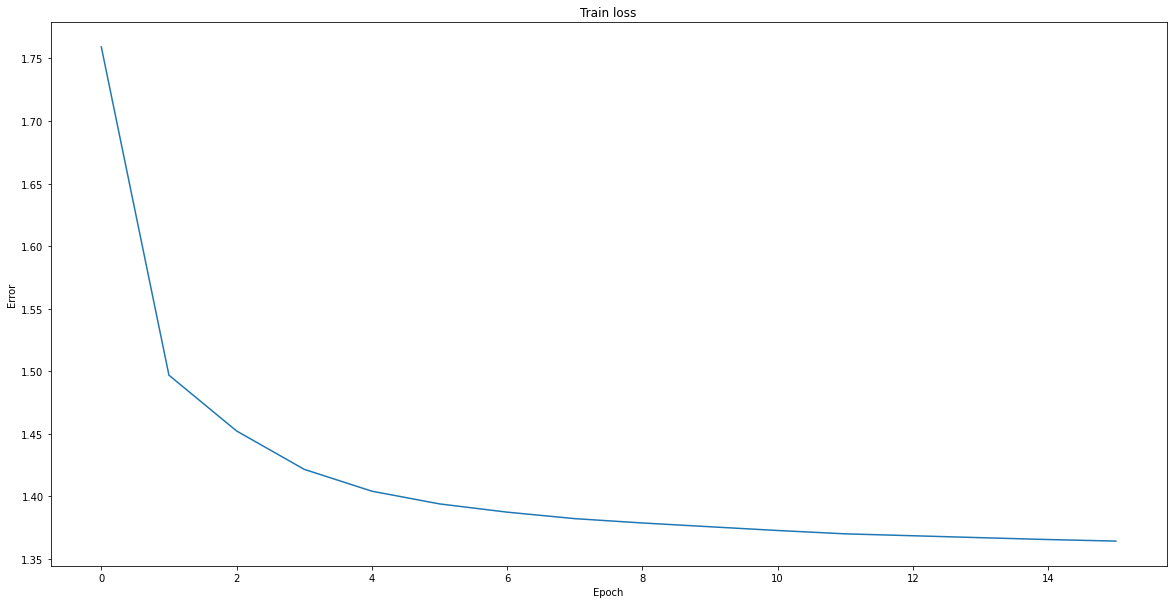

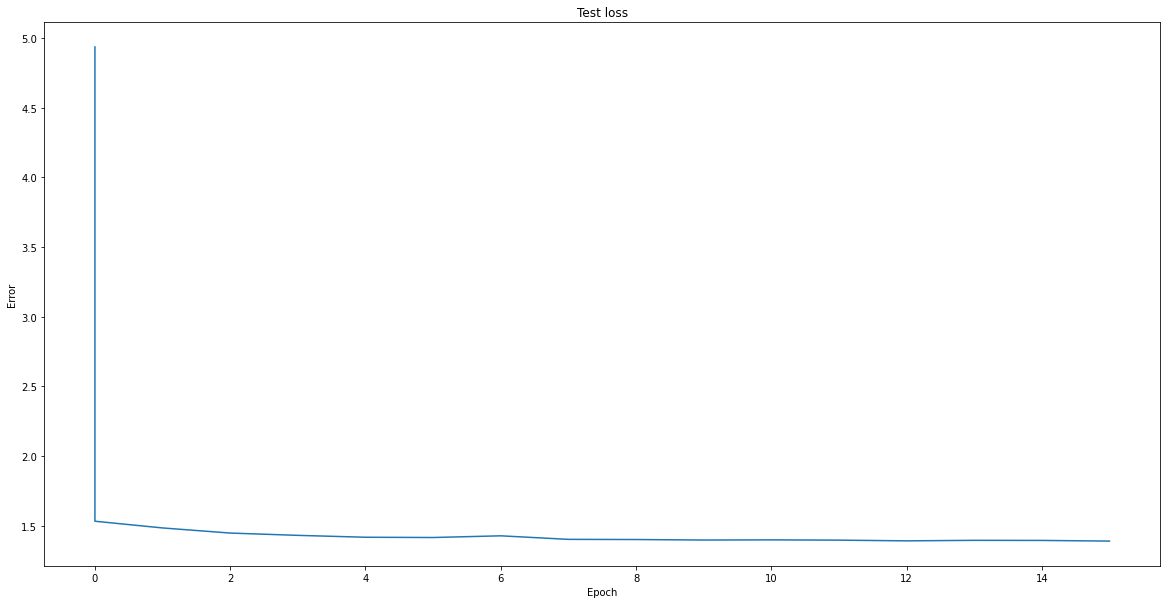

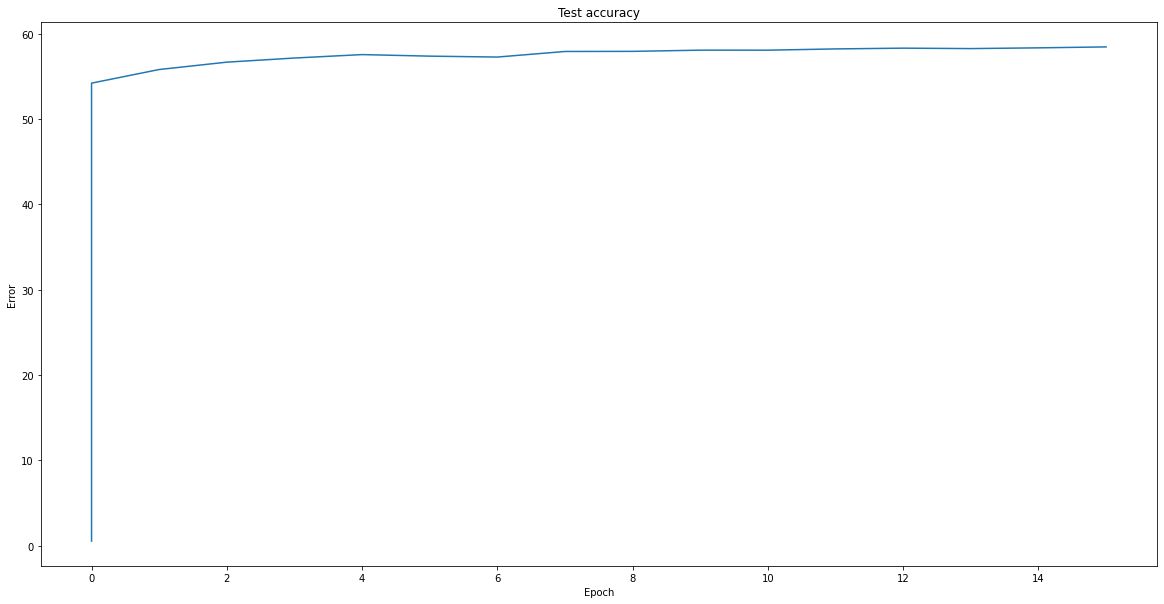

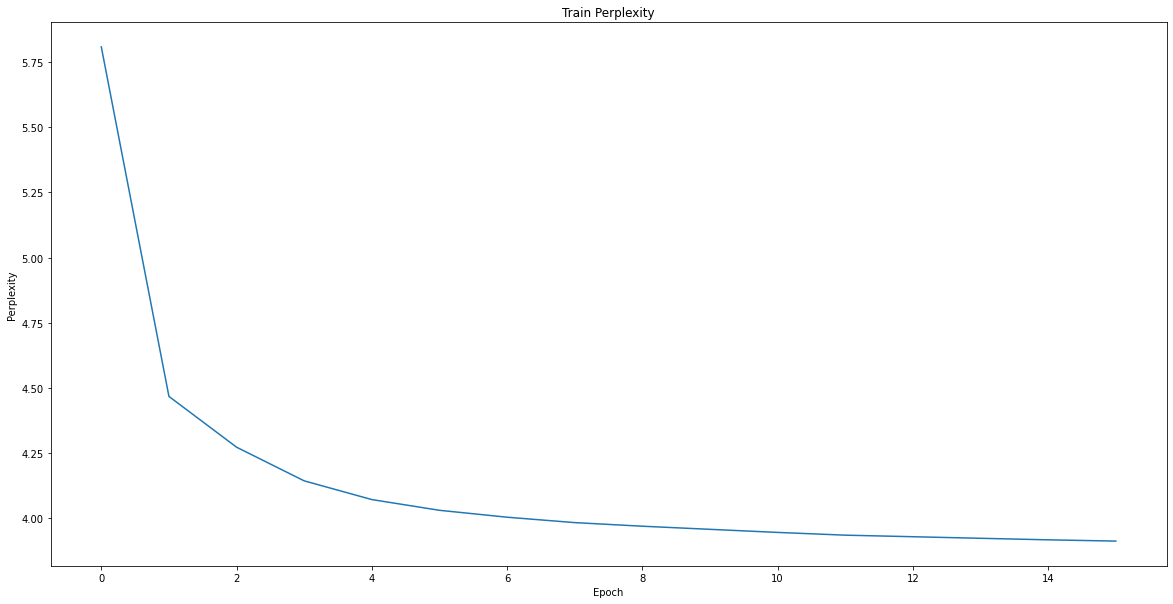

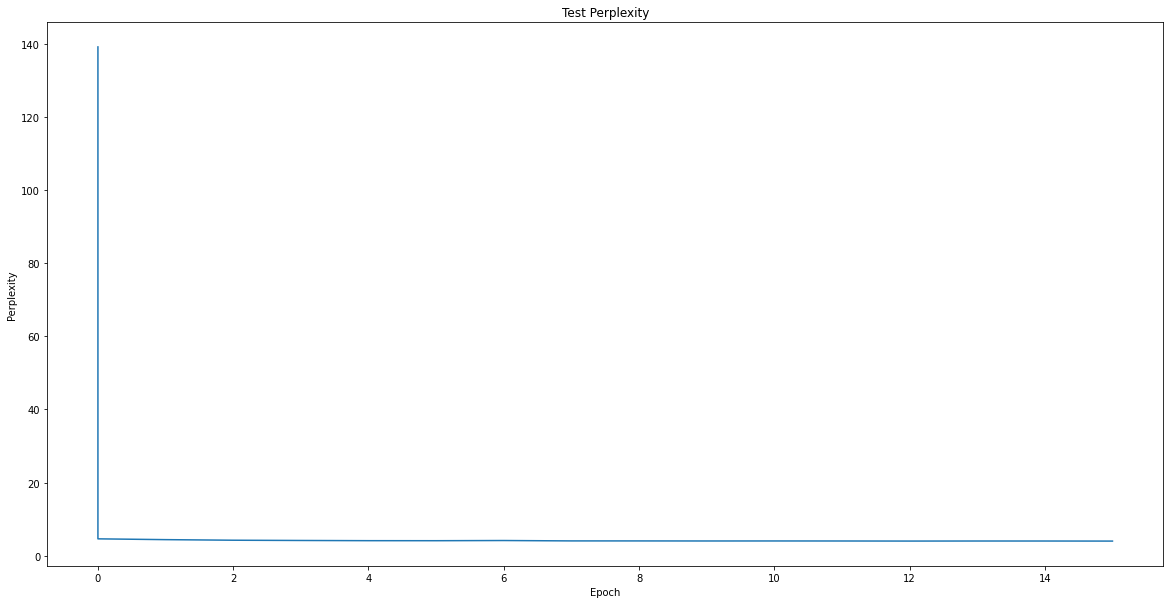

Max test perplexity:  4.009264053264861


In [10]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)
def repackage_cell_state(c):
    """Wraps cell states in new Tensors, to detach them from their history."""
    if isinstance(c, torch.Tensor):
        return c.detach()
    else:
        return tuple(repackage_cell_state(v) for v in c)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = torch.zeros(model.num_layers, train_loader.batch_size, model.feature_size).requires_grad_().to(device)
    cell_state = torch.zeros(model.num_layers, train_loader.batch_size, model.feature_size).requires_grad_().to(device)
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        # if hidden is not None:
        hidden = repackage_hidden(hidden)
        cell_state = repackage_cell_state(cell_state)
        optimizer.zero_grad()
        output, (hidden, cell_state) = model(data, hidden, cell_state)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = torch.zeros(model.num_layers, test_loader.batch_size, model.feature_size).to(device)
        cell_state = torch.zeros(model.num_layers, test_loader.batch_size, model.feature_size).to(device)
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, (hidden, cell_state) = model(data, hidden, cell_state)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 64
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 64
    EPOCHS = 15
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    DROPOUT = 0.2
    NUM_LAYERS = 2
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LSTMNet(data_train.vocab_size(), FEATURE_SIZE, NUM_LAYERS, DROPOUT).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            print(train_loss)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_losses)
        pt_util.plot(ep, np.exp(val), 'Train Perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, np.exp(val), 'Test Perplexity', 'Epoch', 'Perplexity')
        print('Max test perplexity: ', min(np.exp(val)))
        return model, vocab, device

final_model, vocab, device = main()

## Evaluate

In [20]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter, Snape, and Dumbledore walked into bar '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter, Snape, and Dumbledore walked into bar and started to the door of the corner of the corner of the door of the corner of the door of the corner of the door of the corner of the door of the stairs was still staring at the stairs and staring 
generated with sample	 Harry Potter, Snape, and Dumbledore walked into bar cardoc,

"Ares - here more courtry, putting him, I don't mean you inither Crouch."
"Would you know what to or him."
"Tou," said Harry. "I think..."
"That's I couldn't want --"
"Justing here as your la
generated with sample	 Harry Potter, Snape, and Dumbledore walked into bar stick to the first clear from the books teachers.
"Feet, what do you," said Harry.

"Ron's price," said Harry and scabbled.
"To some cithtard water-" said Ron, turning a shadach Morce.
"No," he said, 
generated with sample	 Harry Potter, Snape, and Dumbledore walked into bar grans in Harry's fudge.
"You've been cracking to here, Hermione is that?" graded Mr. Harry roating s